In [1]:
%config IPCompleter.use_jedi = False
# %xmode Verbose
# %xmode context
%pdb off
%load_ext autoreload
%autoreload 3
# !pip install viztracer
%load_ext viztracer
from viztracer import VizTracer
import sys
from pathlib import Path

# required to enable non-blocking interaction:
%gui qt5

import importlib
from copy import deepcopy
from numba import jit
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
# pd.options.mode.dtype_backend = 'pyarrow' # use new pyarrow backend instead of numpy
from attrs import define, field, fields, Factory, make_class
import tables as tb
from datetime import datetime, timedelta

# Pho's Formatting Preferences
import builtins

import IPython
from IPython.core.formatters import PlainTextFormatter
from IPython import get_ipython

from pyphocorehelpers.preferences_helpers import set_pho_preferences, set_pho_preferences_concise, set_pho_preferences_verbose
set_pho_preferences_concise()
# Jupyter-lab enable printing for any line on its own (instead of just the last one in the cell)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# BEGIN PPRINT CUSTOMIZATION ___________________________________________________________________________________________ #

## IPython pprint
from pyphocorehelpers.pprint import wide_pprint, wide_pprint_ipython, wide_pprint_jupyter, MAX_LINE_LENGTH
# Override default pprint
builtins.pprint = wide_pprint

from pyphocorehelpers.preferences_helpers import array_repr_with_graphical_preview, array_repr_with_graphical_shape, dataframe_show_more_button
from IPython.core.magic import register_line_magic

@register_line_magic
def config_ndarray_preview(line):
    """ Allows the user to change the thumbnail image size like:
    
    # call the line magic
    %config_ndarray_preview width=500 
    
    
    """
    from pyphocorehelpers.preferences_helpers import array_repr_with_graphical_preview

    key, value = line.split('=')
    key = key.strip()
    value = value.strip()

    ## defaults:
    width = None
    height = None
    if key == "width":
        width = int(value)
    elif key == "height":
        height = int(value)
    else:
        raise KeyError(f"Unknown configuration key: {key}")

    ## Run
    ip = get_ipython()
    ip = array_repr_with_graphical_preview(ip=ip, width=width, height=height) # Register the custom display function for NumPy arrays
    

ip = get_ipython()

# Register the custom display function for NumPy arrays
# ip.display_formatter.formatters['text/html'].for_type(np.ndarray, lambda arr: array_preview_with_graphical_shape_repr_html(arr))
# ip = array_repr_with_graphical_shape(ip=ip)
ip = array_repr_with_graphical_preview(ip=ip)
# ip = dataframe_show_more_button(ip=ip)

text_formatter: PlainTextFormatter = ip.display_formatter.formatters['text/plain']
text_formatter.max_width = MAX_LINE_LENGTH
text_formatter.for_type(object, wide_pprint_jupyter)


# END PPRINT CUSTOMIZATION ___________________________________________________________________________________________ #

from pyphocorehelpers.print_helpers import get_now_time_str, get_now_day_str
from pyphocorehelpers.indexing_helpers import get_dict_subset

## Pho's Custom Libraries:
from pyphocorehelpers.Filesystem.path_helpers import find_first_extant_path, file_uri_from_path
from pyphocorehelpers.Filesystem.open_in_system_file_manager import reveal_in_system_file_manager
import pyphocorehelpers.programming_helpers as programming_helpers

# NeuroPy (Diba Lab Python Repo) Loading
# from neuropy import core
from typing import Dict, List, Tuple, Optional, Callable, Union, Any
from typing_extensions import TypeAlias
from nptyping import NDArray
import neuropy.utils.type_aliases as types

from neuropy.analyses.placefields import PlacefieldComputationParameters
from neuropy.core.epoch import NamedTimerange, Epoch
from neuropy.core.ratemap import Ratemap
from neuropy.core.session.Formats.BaseDataSessionFormats import DataSessionFormatRegistryHolder
from neuropy.core.session.Formats.Specific.KDibaOldDataSessionFormat import KDibaOldDataSessionFormatRegisteredClass
from neuropy.utils.matplotlib_helpers import matplotlib_file_only, matplotlib_configuration, matplotlib_configuration_update
from neuropy.core.neuron_identities import NeuronIdentityTable, neuronTypesList, neuronTypesEnum
from neuropy.utils.mixins.AttrsClassHelpers import AttrsBasedClassHelperMixin, serialized_field, serialized_attribute_field, non_serialized_field, custom_define
from neuropy.utils.mixins.HDF5_representable import HDF_DeserializationMixin, post_deserialize, HDF_SerializationMixin, HDFMixin, HDF_Converter

## For computation parameters:
from neuropy.analyses.placefields import PlacefieldComputationParameters
from neuropy.utils.dynamic_container import DynamicContainer
from neuropy.utils.result_context import IdentifyingContext
from neuropy.core.session.Formats.BaseDataSessionFormats import find_local_session_paths
from neuropy.core.neurons import NeuronType
from neuropy.core.user_annotations import UserAnnotationsManager
from neuropy.core.position import Position
from neuropy.core.session.dataSession import DataSession
from neuropy.analyses.time_dependent_placefields import PfND_TimeDependent, PlacefieldSnapshot
from neuropy.utils.debug_helpers import debug_print_placefield, debug_print_subsession_neuron_differences, debug_print_ratemap, debug_print_spike_counts, debug_plot_2d_binning, print_aligned_columns, parameter_sweeps, _plot_parameter_sweep, compare_placefields_info
from neuropy.utils.indexing_helpers import NumpyHelpers, union_of_arrays, intersection_of_arrays, find_desired_sort_indicies, paired_incremental_sorting
from pyphocorehelpers.print_helpers import print_object_memory_usage, print_dataframe_memory_usage, print_value_overview_only, DocumentationFilePrinter, print_keys_if_possible, generate_html_string, document_active_variables

## Pho Programming Helpers:
import inspect
from pyphocorehelpers.print_helpers import DocumentationFilePrinter, TypePrintMode, print_keys_if_possible, debug_dump_object_member_shapes, print_value_overview_only, document_active_variables
from pyphocorehelpers.programming_helpers import IPythonHelpers, PythonDictionaryDefinitionFormat, MemoryManagement, inspect_callable_arguments, get_arguments_as_optional_dict, GeneratedClassDefinitionType, CodeConversion
from pyphocorehelpers.notebook_helpers import NotebookCellExecutionLogger
from pyphocorehelpers.gui.Qt.TopLevelWindowHelper import TopLevelWindowHelper, print_widget_hierarchy
from pyphocorehelpers.indexing_helpers import reorder_columns, reorder_columns_relative, dict_to_full_array

doc_output_parent_folder: Path = Path('EXTERNAL/DEVELOPER_NOTES/DataStructureDocumentation').resolve() # ../.
print(f"doc_output_parent_folder: {doc_output_parent_folder}")
assert doc_output_parent_folder.exists()

_notebook_path:Path = Path(IPythonHelpers.try_find_notebook_filepath(IPython.extract_module_locals())).resolve() # Finds the path of THIS notebook
# _notebook_execution_logger: NotebookCellExecutionLogger = NotebookCellExecutionLogger(notebook_path=_notebook_path, enable_logging_to_file=False) # Builds a logger that records info about this notebook

# pyPhoPlaceCellAnalysis:
from pyphoplacecellanalysis.General.Pipeline.NeuropyPipeline import NeuropyPipeline # get_neuron_identities
from pyphoplacecellanalysis.General.Mixins.ExportHelpers import export_pyqtgraph_plot
from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import batch_load_session, batch_extended_computations, batch_evaluate_required_computations, batch_extended_programmatic_figures
from pyphoplacecellanalysis.General.Pipeline.NeuropyPipeline import PipelineSavingScheme

import pyphoplacecellanalysis.External.pyqtgraph as pg

from pyphocorehelpers.exception_helpers import ExceptionPrintingContext, CapturedException
from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import batch_perform_all_plots
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.LongShortTrackComputations import JonathanFiringRateAnalysisResult
from pyphoplacecellanalysis.General.Mixins.CrossComputationComparisonHelpers import _find_any_context_neurons
from pyphoplacecellanalysis.General.Batch.runBatch import BatchSessionCompletionHandler # for `post_compute_validate(...)`
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import BasePositionDecoder
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionsResults
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.SpikeAnalysis import SpikeRateTrends # for `_perform_long_short_instantaneous_spike_rate_groups_analysis`
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.LongShortTrackComputations import SingleBarResult, InstantaneousSpikeRateGroupsComputation, TruncationCheckingResults # for `BatchSessionCompletionHandler`, `AcrossSessionsAggregator`
from pyphoplacecellanalysis.General.Mixins.CrossComputationComparisonHelpers import SplitPartitionMembership
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalPlacefieldGlobalComputationFunctions, DirectionalLapsResult, TrackTemplates, DecoderDecodedEpochsResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderGlobalComputationFunctions,  RankOrderComputationsContainer, RankOrderResult, RankOrderAnalyses
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import TrackTemplates
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.ComputationFunctionRegistryHolder import ComputationFunctionRegistryHolder, computation_precidence_specifying_function, global_function
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.SequenceBasedComputations import WCorrShuffle, SequenceBasedComputationsContainer
from neuropy.utils.mixins.binning_helpers import transition_matrix
from pyphoplacecellanalysis.Analysis.Decoder.transition_matrix import TransitionMatrixComputations
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import TrackTemplates

# Plotting
# import pylustrator # customization of figures
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
_bak_rcParams = mpl.rcParams.copy()

matplotlib.use('Qt5Agg')
# %matplotlib inline
# %matplotlib auto


# _restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
_restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')

# import pylustrator # call `pylustrator.start()` before creating your first figure in code.
from pyphoplacecellanalysis.Pho2D.matplotlib.visualize_heatmap import visualize_heatmap
from pyphoplacecellanalysis.Pho2D.matplotlib.visualize_heatmap import visualize_heatmap_pyqtgraph # used in `plot_kourosh_activity_style_figure`
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.SpikeRasters import plot_multiple_raster_plot, plot_raster_plot
from pyphoplacecellanalysis.General.Mixins.DataSeriesColorHelpers import UnitColoringMode, DataSeriesColorHelpers
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.SpikeRasters import _build_default_tick, build_scatter_plot_kwargs
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.Render2DScrollWindowPlot import Render2DScrollWindowPlotMixin, ScatterItemData
from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import batch_extended_programmatic_figures, batch_programmatic_figures
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.SpikeAnalysis import SpikeRateTrends
from pyphoplacecellanalysis.General.Mixins.SpikesRenderingBaseMixin import SpikeEmphasisState

from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import PAPER_FIGURE_figure_1_add_replay_epoch_rasters, PAPER_FIGURE_figure_1_full, PAPER_FIGURE_figure_3, main_complete_figure_generations
# from pyphoplacecellanalysis.SpecificResults.fourthYearPresentation import *

# Jupyter Widget Interactive
import ipywidgets as widgets
from IPython.display import display, HTML
from pyphocorehelpers.Filesystem.open_in_system_file_manager import reveal_in_system_file_manager
from pyphoplacecellanalysis.GUI.IPyWidgets.pipeline_ipywidgets import interactive_pipeline_widget, interactive_pipeline_files
from pyphocorehelpers.gui.Jupyter.simple_widgets import fullwidth_path_widget, render_colors

from datetime import datetime, date, timedelta
from pyphocorehelpers.print_helpers import get_now_day_str, get_now_rounded_time_str

DAY_DATE_STR: str = date.today().strftime("%Y-%m-%d")
DAY_DATE_TO_USE = f'{DAY_DATE_STR}' # used for filenames throught the notebook
print(f'DAY_DATE_STR: {DAY_DATE_STR}, DAY_DATE_TO_USE: {DAY_DATE_TO_USE}')

NOW_DATETIME: str = get_now_rounded_time_str()
NOW_DATETIME_TO_USE = f'{NOW_DATETIME}' # used for filenames throught the notebook
print(f'NOW_DATETIME: {NOW_DATETIME}, NOW_DATETIME_TO_USE: {NOW_DATETIME_TO_USE}')

from pyphocorehelpers.gui.Jupyter.simple_widgets import build_global_data_root_parent_path_selection_widget
all_paths = [Path('/Volumes/SwapSSD/Data'), Path('/Users/pho/data'), Path(r'/media/halechr/MAX/Data'), Path(r'/home/halechr/FastData'), Path(r'W:\Data'), Path(r'/home/halechr/cloud/turbo/Data'), Path(r'/Volumes/MoverNew/data'), Path(r'/home/halechr/turbo/Data'), Path(r'/Users/pho/cloud/turbo/Data')] # Path('/Volumes/FedoraSSD/FastData'), 
global_data_root_parent_path = None
def on_user_update_path_selection(new_path: Path):
    global global_data_root_parent_path
    new_global_data_root_parent_path = new_path.resolve()
    global_data_root_parent_path = new_global_data_root_parent_path
    print(f'global_data_root_parent_path changed to {global_data_root_parent_path}')
    assert global_data_root_parent_path.exists(), f"global_data_root_parent_path: {global_data_root_parent_path} does not exist! Is the right computer's config commented out above?"
            
global_data_root_parent_path_widget = build_global_data_root_parent_path_selection_widget(all_paths, on_user_update_path_selection)
global_data_root_parent_path_widget

Automatic pdb calling has been turned OFF
doc_output_parent_folder: C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\EXTERNAL\DEVELOPER_NOTES\DataStructureDocumentation
DAY_DATE_STR: 2024-08-07, DAY_DATE_TO_USE: 2024-08-07
NOW_DATETIME: 2024-08-07_0802AM, NOW_DATETIME_TO_USE: 2024-08-07_0802AM
global_data_root_parent_path changed to W:\Data


ToggleButtons(description='Data Root:', layout=Layout(width='auto'), options=(WindowsPath('W:/Data'),), style=ToggleButtonsStyle(button_width='max-content'), tooltip='global_data_root_parent_path', value=WindowsPath('W:/Data'))

# Load Pipeline

In [2]:
# ==================================================================================================================== #
# Load Data                                                                                                            #
# ==================================================================================================================== #

active_data_mode_name = 'kdiba'
local_session_root_parent_context = IdentifyingContext(format_name=active_data_mode_name) # , animal_name='', configuration_name='one', session_name=a_sess.session_name
local_session_root_parent_path = global_data_root_parent_path.joinpath('KDIBA')

# [*] - indicates bad or session with a problem
# 0, 1, 2, 3, 4, 5, 6, 7, [8], [9], 10, 11, [12], 13, 14, [15], [16], 17, 
# curr_context: IdentifyingContext = good_contexts_list[1] # select the session from all of the good sessions here.
curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-08_14-26-15') # 2024-04-30 - Completely cleaned. 2024-07-15 DONE with custom replays
# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-09_1-22-43') # Working wcorr_shuffle and trial_by_trial - DONE, might be the BEST SESSION, good example session with lots of place cells, clean replays, and clear bar graphs.
# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-12_15-55-31') # DONE, Good Pfs but no good replays ---- VERY weird effect of the replays, a sharp drop to strongly negative values more than 3/4 through the experiment.

# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-13_14-42-6') # BAD, 2023-07-14, unsure why still.
# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-07_16-40-19') # DONE, GREAT, both good Pfs and replays! Interesting see-saw! #TODO 2024-07-05 23:07: - [ ] This was the one I processed

# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-08_21-16-25') # DONE, Added replay selections. Very "jumpy" between the starts and ends of the track. 2024-07-10 DONE with custom replays
# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-09_22-24-40') # 2024-05-28 __ DEAD # 2024-01-10 new RANKORDER APOGEE | DONE, Added replay selections. A TON of putative replays in general, most bad, but some good. LOOKIN GOOD! 2024-07-10 DONE with custom replays
# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='twolong_LR_pf1Dsession_name='2006-4-12_15-25-59') # BAD, No Epochs
# curr_context = IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='two',session_name='2006-4-16_18-47-52')
# curr_context = IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='two',session_name='2006-4-17_12-52-15')
# curr_context = IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='two',session_name='2006-4-25_13-20-55')
# curr_context = IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='two',session_name='2006-4-28_12-38-13')
# curr_context = IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-02_17-46-44') # BAD: Confirmed frequent jumping off of the track in this session. DONE, good. Many good pfs, many good replays. Noticed very strange jumping off the track in the 3D behavior/spikes viewer. Is there something wrong with this session?
# curr_context = IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-02_19-28-0') # DONE, good?, replays selected, few  # BAD: Seems like in 3D view there's also jumping off of the track in this session.
# curr_context = IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-03_12-3-25') # DONE, very few replays

# curr_context = IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-09_12-15-3') ### KeyError: 'maze1_odd'
# curr_context = IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-09_22-4-5') ### 

# curr_context = IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='fet11-01_12-58-54') # NEWDONE, replays selected, quite a few replays but few are very good.

# curr_context = IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-08_21-16-25')

local_session_parent_path: Path = local_session_root_parent_path.joinpath(curr_context.animal, curr_context.exper_name) # 'gor01', 'one' - probably not needed anymore
basedir: Path = local_session_parent_path.joinpath(curr_context.session_name).resolve()
print(f'basedir: {str(basedir)}')

# Read if possible:
saving_mode = PipelineSavingScheme.SKIP_SAVING
force_reload = False

# 
# # Force write:
# saving_mode = PipelineSavingScheme.TEMP_THEN_OVERWRITE
# saving_mode = PipelineSavingScheme.OVERWRITE_IN_PLACE
# force_reload = True

## TODO: if loading is not possible, we need to change the `saving_mode` so that the new results are properly saved.


basedir: W:\Data\KDIBA\gor01\one\2006-6-08_14-26-15


In [3]:
extended_computations_include_includelist=['lap_direction_determination', 'pf_computation', 'firing_rate_trends', 'pfdt_computation',
    # 'pf_dt_sequential_surprise',
     'ratemap_peaks_prominence2d',
    'extended_stats',
    'long_short_decoding_analyses',
    'jonathan_firing_rate_analysis',
    'long_short_fr_indicies_analyses',
    'short_long_pf_overlap_analyses',
    'long_short_post_decoding',
    # 'long_short_rate_remapping',
    'long_short_inst_spike_rate_groups',
    'long_short_endcap_analysis',
    # 'spike_burst_detection',
    'split_to_directional_laps',
    'merged_directional_placefields',
    'rank_order_shuffle_analysis',
    # 'directional_train_test_split',
    'directional_decoders_decode_continuous',
    'directional_decoders_evaluate_epochs',
    'directional_decoders_epoch_heuristic_scoring',
    'perform_wcorr_shuffle_analysis',
    'trial_by_trial_metrics',
    'extended_pf_peak_information',
] # do only specified
force_recompute_override_computations_includelist = None
# force_recompute_override_computations_includelist = ['merged_directional_placefields']
# force_recompute_override_computations_includelist = ['split_to_directional_laps', 'merged_directional_placefields', 'rank_order_shuffle_analysis'] # , 'directional_decoders_decode_continuous'
# force_recompute_override_computations_includelist = ['directional_decoders_decode_continuous'] # 
# force_recompute_override_computations_includelist = ['trial_by_trial_metrics']
# force_recompute_override_computations_includelist = ['split_to_directional_laps', 'merged_directional_placefields', 'rank_order_shuffle_analysis', 'directional_decoders_decode_continuous'] # 

## 2024-06-25 - Load from saved custom

In [ ]:
# Loads custom pipeline pickles that were saved out via `custom_save_filepaths['pipeline_pkl'] = curr_active_pipeline.save_pipeline(saving_mode=PipelineSavingScheme.TEMP_THEN_OVERWRITE, active_pickle_filename=custom_save_filenames['pipeline_pkl'])`

## INPUTS: global_data_root_parent_path, active_data_mode_name, basedir, saving_mode, force_reload, custom_save_filenames
# custom_suffix: str = '_withNewKamranExportedReplays'

# custom_suffix: str = '_withNewComputedReplays'
custom_suffix: str = '_withNewComputedReplays-qclu_[1, 2]-frateThresh_5.0'


custom_save_filenames = {
    'pipeline_pkl':f'loadedSessPickle{custom_suffix}.pkl',
    'global_computation_pkl':f"global_computation_results{custom_suffix}.pkl",
    'pipeline_h5':f'pipeline{custom_suffix}.h5',
}
print(f'custom_save_filenames: {custom_save_filenames}')
custom_save_filepaths = {k:v for k, v in custom_save_filenames.items()}

# ==================================================================================================================== #
# PIPELINE LOADING                                                                                                     #
# ==================================================================================================================== #
# load the custom saved outputs
active_pickle_filename = custom_save_filenames['pipeline_pkl'] # 'loadedSessPickle_withParameters.pkl'
print(f'active_pickle_filename: "{active_pickle_filename}"')
# assert active_pickle_filename.exists()
active_session_h5_filename = custom_save_filenames['pipeline_h5'] # 'pipeline_withParameters.h5'
print(f'active_session_h5_filename: "{active_session_h5_filename}"')

# ==================================================================================================================== #
# Load Pipeline                                                                                                        #
# ==================================================================================================================== #
## DO NOT allow recompute if the file doesn't exist!!
# Computing loaded session pickle file results : "W:/Data/KDIBA/gor01/two/2006-6-07_16-40-19/loadedSessPickle_withNewComputedReplays.pkl"... done.
# Failure loading W:\Data\KDIBA\gor01\two\2006-6-07_16-40-19\loadedSessPickle_withNewComputedReplays.pkl.
proposed_load_pkl_path = basedir.joinpath(active_pickle_filename).resolve()

In [ ]:
## INPUTS: proposed_load_pkl_path
assert proposed_load_pkl_path.exists(), f"for a saved custom the file must exist!"

epoch_name_includelist=None
active_computation_functions_name_includelist=['lap_direction_determination', 'pf_computation','firing_rate_trends', 'position_decoding']
curr_active_pipeline: NeuropyPipeline = batch_load_session(global_data_root_parent_path, active_data_mode_name, basedir, epoch_name_includelist=epoch_name_includelist,
                                        computation_functions_name_includelist=active_computation_functions_name_includelist,
                                        saving_mode=saving_mode, force_reload=force_reload,
                                        skip_extended_batch_computations=True, debug_print=False, fail_on_exception=True, active_pickle_filename=proposed_load_pkl_path) # , active_pickle_filename = 'loadedSessPickle_withParameters.pkl'

## Post Compute Validate 2023-05-16:
was_updated = BatchSessionCompletionHandler.post_compute_validate(curr_active_pipeline) ## TODO: need to potentially re-save if was_updated. This will fail because constained versions not ran yet.
if was_updated:
    print(f'was_updated: {was_updated}')
    try:
        if saving_mode == PipelineSavingScheme.SKIP_SAVING:
            print(f'WARNING: PipelineSavingScheme.SKIP_SAVING but need to save post_compute_validate changes!!')
        else:
            curr_active_pipeline.save_pipeline(saving_mode=saving_mode)
    except BaseException as e:
        ## TODO: catch/log saving error and indicate that it isn't saved.
        exception_info = sys.exc_info()
        e = CapturedException(e, exception_info)
        print(f'ERROR RE-SAVING PIPELINE after update. error: {e}')

print(f'Pipeline loaded from custom pickle!!')
## OUTPUT: curr_active_pipeline


In [ ]:
# ==================================================================================================================== #
# Global computations loading:                                                                                            #
# ==================================================================================================================== #
# Loads saved global computations that were saved out via: `custom_save_filepaths['global_computation_pkl'] = curr_active_pipeline.save_global_computation_results(override_global_pickle_filename=custom_save_filenames['global_computation_pkl'])`
## INPUTS: custom_save_filenames
## INPUTS: curr_active_pipeline, override_global_computation_results_pickle_path, extended_computations_include_includelist

override_global_computation_results_pickle_path = None
# override_global_computation_results_pickle_path = custom_save_filenames['global_computation_pkl']
print(f'override_global_computation_results_pickle_path: "{override_global_computation_results_pickle_path}"')

# Pre-load ___________________________________________________________________________________________________________ #
force_recompute_global = force_reload
needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = batch_evaluate_required_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
print(f'Pre-load global computations: needs_computation_output_dict: {[k for k,v in needs_computation_output_dict.items() if (v is not None)]}')
# valid_computed_results_output_list

# Try Unpickling Global Computations to update pipeline ______________________________________________________________ #
if not force_reload: # not just force_reload, needs to recompute whenever the computation fails.
    try:
        # INPUTS: override_global_computation_results_pickle_path
        sucessfully_updated_keys, successfully_loaded_keys = curr_active_pipeline.load_pickled_global_computation_results(override_global_computation_results_pickle_path=override_global_computation_results_pickle_path,
                                                                                        allow_overwrite_existing=True, allow_overwrite_existing_allow_keys=extended_computations_include_includelist, ) # is new
        print(f'sucessfully_updated_keys: {sucessfully_updated_keys}\nsuccessfully_loaded_keys: {successfully_loaded_keys}')
    except FileNotFoundError as e:
        exception_info = sys.exc_info()
        e = CapturedException(e, exception_info)
        print(f'cannot load global results because pickle file does not exist! Maybe it has never been created? {e}')
    except BaseException as e:
        exception_info = sys.exc_info()
        e = CapturedException(e, exception_info)
        print(f'Unhandled exception: cannot load global results: {e}')
        raise

# Post-Load __________________________________________________________________________________________________________ #
force_recompute_global = force_reload
needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = batch_evaluate_required_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
print(f'Post-load global computations: needs_computation_output_dict: {[k for k,v in needs_computation_output_dict.items() if (v is not None)]}')

# Compute ____________________________________________________________________________________________________________ #
curr_active_pipeline.reload_default_computation_functions()
force_recompute_global = force_reload
# force_recompute_global = True
newly_computed_values = batch_extended_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=True, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
if (len(newly_computed_values) > 0):
    print(f'newly_computed_values: {newly_computed_values}.')
    if (saving_mode.value != 'skip_saving'):
        print(f'Saving global results...')
        try:
            # curr_active_pipeline.global_computation_results.persist_time = datetime.now()
            # Try to write out the global computation function results:
            curr_active_pipeline.save_global_computation_results()
        except Exception as e:
            exception_info = sys.exc_info()
            e = CapturedException(e, exception_info)
            print(f'\n\n!!WARNING!!: saving the global results threw the exception: {e}')
            print(f'\tthe global results are currently unsaved! proceed with caution and save as soon as you can!\n\n\n')
    else:
        print(f'\n\n!!WARNING!!: changes to global results have been made but they will not be saved since saving_mode.value == "skip_saving"')
        print(f'\tthe global results are currently unsaved! proceed with caution and save as soon as you can!\n\n\n')
else:
    print(f'no changes in global results.')

# Post-compute _______________________________________________________________________________________________________ #
# Post-hoc verification that the computations worked and that the validators reflect that. The list should be empty now.
needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = batch_evaluate_required_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=False, force_recompute_override_computations_includelist=[], debug_print=True)
print(f'Post-compute validation: needs_computation_output_dict: {[k for k,v in needs_computation_output_dict.items() if (v is not None)]}')


## Normal Pipeline Load

In [4]:
# ==================================================================================================================== #
# Load Pipeline                                                                                                        #
# ==================================================================================================================== #
# with VizTracer(output_file=f"viztracer_{get_now_time_str()}-full_session_LOO_decoding_analysis.json", min_duration=200, tracer_entries=3000000, ignore_frozen=True) as tracer:
# epoch_name_includelist = ['maze']
epoch_name_includelist = None
active_computation_functions_name_includelist=['lap_direction_determination', 'pf_computation',
                                            #    'pfdt_computation',
                                                'firing_rate_trends',
                                                # 'pf_dt_sequential_surprise', 
                                            #    'ratemap_peaks_prominence2d',
                                                'position_decoding', 
                                                # 'position_decoding_two_step', 
                                            #    'long_short_decoding_analyses', 'jonathan_firing_rate_analysis', 'long_short_fr_indicies_analyses', 'short_long_pf_overlap_analyses', 'long_short_post_decoding', 'long_short_rate_remapping',
                                            #     'long_short_inst_spike_rate_groups',
                                            #     'long_short_endcap_analysis',
                                            # 'split_to_directional_laps',
]

curr_active_pipeline: NeuropyPipeline = batch_load_session(global_data_root_parent_path, active_data_mode_name, basedir, epoch_name_includelist=epoch_name_includelist,
                                        computation_functions_name_includelist=active_computation_functions_name_includelist,
                                        saving_mode=saving_mode, force_reload=force_reload,
                                        skip_extended_batch_computations=True, debug_print=False, fail_on_exception=True) # , active_pickle_filename = 'loadedSessPickle_withParameters.pkl'



## Post Compute Validate 2023-05-16:
was_updated = BatchSessionCompletionHandler.post_compute_validate(curr_active_pipeline) ## TODO: need to potentially re-save if was_updated. This will fail because constained versions not ran yet.
if was_updated:
    print(f'was_updated: {was_updated}')
    try:
        curr_active_pipeline.save_pipeline(saving_mode=saving_mode)
    except Exception as e:
        ## TODO: catch/log saving error and indicate that it isn't saved.
        exception_info = sys.exc_info()
        e = CapturedException(e, exception_info)
        print(f'ERROR RE-SAVING PIPELINE after update. error: {e}')


Computing loaded session pickle file results : "W:/Data/KDIBA/gor01/one/2006-6-08_14-26-15/loadedSessPickle.pkl"... 

INFO:2024-08-07_08-08-20.Apogee.kdiba.gor01.one.2006-6-08_14-26-15:==========================================================================================
========== Logger INIT "2024-08-07_08-08-20.Apogee.kdiba.gor01.one.2006-6-08_14-26-15" ==============================
INFO:2024-08-07_08-08-20.Apogee.kdiba.gor01.one.2006-6-08_14-26-15:NeuropyPipeline.__setstate__(state="{'pipeline_name': 'kdiba_pipeline', 'session_data_type': 'kdiba', '_stage': <pyphoplacecellanalysis.General.Pipeline.Stages.Display.DisplayPipelineStage object at 0x000001B04F7CA220>}")


build_logger(full_logger_string="2024-08-07_08-08-20.Apogee.kdiba.gor01.one.2006-6-08_14-26-15", file_logging_dir: None):
done.
Loading pickled pipeline success: W:\Data\KDIBA\gor01\one\2006-6-08_14-26-15\loadedSessPickle.pkl.


INFO:2024-08-07_08-08-20.Apogee.kdiba.gor01.one.2006-6-08_14-26-15:select_filters(...) with: []
INFO:2024-08-07_08-08-20.Apogee.kdiba.gor01.one.2006-6-08_14-26-15:Performing perform_action_for_all_contexts with action EvaluationActions.EVALUATE_COMPUTATIONS on filtered_session with filter named "maze1_odd"...
INFO:2024-08-07_08-08-20.Apogee.kdiba.gor01.one.2006-6-08_14-26-15:WARNING: skipping computation because overwrite_extant_results=False and `active_computation_results[maze1_odd]` already exists and is non-None
INFO:2024-08-07_08-08-20.Apogee.kdiba.gor01.one.2006-6-08_14-26-15:	 TODO: this will prevent recomputation even when the excludelist/includelist or computation function definitions change. Rework so that this is smarter.
INFO:2024-08-07_08-08-20.Apogee.kdiba.gor01.one.2006-6-08_14-26-15:Performing perform_action_for_all_contexts with action EvaluationActions.EVALUATE_COMPUTATIONS on filtered_session with filter named "maze2_odd"...
INFO:2024-08-07_08-08-20.Apogee.kdiba.gor0

properties already present in pickled version. No need to save.
pipeline load success!
using provided computation_functions_name_includelist: ['lap_direction_determination', 'pf_computation', 'firing_rate_trends', 'position_decoding']
	 TODO: this will prevent recomputation even when the excludelist/includelist or computation function definitions change. Rework so that this is smarter.
	 TODO: this will prevent recomputation even when the excludelist/includelist or computation function definitions change. Rework so that this is smarter.
	 TODO: this will prevent recomputation even when the excludelist/includelist or computation function definitions change. Rework so that this is smarter.
	 TODO: this will prevent recomputation even when the excludelist/includelist or computation function definitions change. Rework so that this is smarter.
	 TODO: this will prevent recomputation even when the excludelist/includelist or computation function definitions change. Rework so that this is smar

In [5]:
force_recompute_global = force_reload
needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = batch_evaluate_required_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
print(f'Pre-load global computations: needs_computation_output_dict: {[k for k,v in needs_computation_output_dict.items() if (v is not None)]}')
# valid_computed_results_output_list

included includelist is specified: ['lap_direction_determination', 'pf_computation', 'firing_rate_trends', 'pfdt_computation', 'ratemap_peaks_prominence2d', 'extended_stats', 'long_short_decoding_analyses', 'jonathan_firing_rate_analysis', 'long_short_fr_indicies_analyses', 'short_long_pf_overlap_analyses', 'long_short_post_decoding', 'long_short_inst_spike_rate_groups', 'long_short_endcap_analysis', 'split_to_directional_laps', 'merged_directional_placefields', 'rank_order_shuffle_analysis', 'directional_decoders_decode_continuous', 'directional_decoders_evaluate_epochs', 'directional_decoders_epoch_heuristic_scoring', 'perform_wcorr_shuffle_analysis', 'trial_by_trial_metrics', 'extended_pf_peak_information'], so only performing these extended computations.
Running batch_evaluate_required_computations(...) with global_epoch_name: "maze_any"
done with all batch_evaluate_required_computations(...).
Pre-load global computations: needs_computation_output_dict: []


In [6]:
if not force_reload: # not just force_reload, needs to recompute whenever the computation fails.
    try:
        # curr_active_pipeline.load_pickled_global_computation_results()
        sucessfully_updated_keys, successfully_loaded_keys = curr_active_pipeline.load_pickled_global_computation_results(allow_overwrite_existing=True, allow_overwrite_existing_allow_keys=extended_computations_include_includelist) # is new
        print(f'sucessfully_updated_keys: {sucessfully_updated_keys}\nsuccessfully_loaded_keys: {successfully_loaded_keys}')
    except FileNotFoundError as e:
        exception_info = sys.exc_info()
        e = CapturedException(e, exception_info)
        print(f'cannot load global results because pickle file does not exist! Maybe it has never been created? {e}')
    except BaseException as e:
        exception_info = sys.exc_info()
        e = CapturedException(e, exception_info)
        print(f'Unhandled exception: cannot load global results: {e}')
        raise


Computing loaded session pickle file results : "W:/Data/KDIBA/gor01/one/2006-6-08_14-26-15/output/global_computation_results.pkl"... done.
sucessfully_updated_keys: ['DirectionalLaps', 'DirectionalMergedDecoders', 'RankOrder', 'DirectionalDecodersDecoded', 'DirectionalDecodersEpochsEvaluations', 'TrialByTrialActivity', 'long_short_leave_one_out_decoding_analysis', 'short_long_pf_overlap_analyses', 'long_short_fr_indicies_analysis', 'jonathan_firing_rate_analysis', 'long_short_post_decoding', 'long_short_inst_spike_rate_groups', 'long_short_endcap', 'SequenceBased']
successfully_loaded_keys: ['DirectionalLaps', 'DirectionalMergedDecoders', 'RankOrder', 'DirectionalDecodersDecoded', 'DirectionalDecodersEpochsEvaluations', 'TrialByTrialActivity', 'long_short_leave_one_out_decoding_analysis', 'short_long_pf_overlap_analyses', 'long_short_fr_indicies_analysis', 'jonathan_firing_rate_analysis', 'long_short_post_decoding', 'long_short_inst_spike_rate_groups', 'long_short_endcap', 'SequenceBas

In [7]:
force_recompute_global = force_reload
needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = batch_evaluate_required_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
print(f'Post-load global computations: needs_computation_output_dict: {[k for k,v in needs_computation_output_dict.items() if (v is not None)]}')

included includelist is specified: ['lap_direction_determination', 'pf_computation', 'firing_rate_trends', 'pfdt_computation', 'ratemap_peaks_prominence2d', 'extended_stats', 'long_short_decoding_analyses', 'jonathan_firing_rate_analysis', 'long_short_fr_indicies_analyses', 'short_long_pf_overlap_analyses', 'long_short_post_decoding', 'long_short_inst_spike_rate_groups', 'long_short_endcap_analysis', 'split_to_directional_laps', 'merged_directional_placefields', 'rank_order_shuffle_analysis', 'directional_decoders_decode_continuous', 'directional_decoders_evaluate_epochs', 'directional_decoders_epoch_heuristic_scoring', 'perform_wcorr_shuffle_analysis', 'trial_by_trial_metrics', 'extended_pf_peak_information'], so only performing these extended computations.
Running batch_evaluate_required_computations(...) with global_epoch_name: "maze_any"
done with all batch_evaluate_required_computations(...).
Post-load global computations: needs_computation_output_dict: []


In [8]:
curr_active_pipeline.reload_default_computation_functions()
force_recompute_global = force_reload
# force_recompute_global = True
newly_computed_values = batch_extended_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=True, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
if (len(newly_computed_values) > 0):
    print(f'newly_computed_values: {newly_computed_values}.')
    if (saving_mode.value != 'skip_saving'):
        print(f'Saving global results...')
        try:
            # curr_active_pipeline.global_computation_results.persist_time = datetime.now()
            # Try to write out the global computation function results:
            curr_active_pipeline.save_global_computation_results()
        except Exception as e:
            exception_info = sys.exc_info()
            e = CapturedException(e, exception_info)
            print(f'\n\n!!WARNING!!: saving the global results threw the exception: {e}')
            print(f'\tthe global results are currently unsaved! proceed with caution and save as soon as you can!\n\n\n')
    else:
        print(f'\n\n!!WARNING!!: changes to global results have been made but they will not be saved since saving_mode.value == "skip_saving"')
        print(f'\tthe global results are currently unsaved! proceed with caution and save as soon as you can!\n\n\n')
else:
    print(f'no changes in global results.')


included includelist is specified: ['lap_direction_determination', 'pf_computation', 'firing_rate_trends', 'pfdt_computation', 'ratemap_peaks_prominence2d', 'extended_stats', 'long_short_decoding_analyses', 'jonathan_firing_rate_analysis', 'long_short_fr_indicies_analyses', 'short_long_pf_overlap_analyses', 'long_short_post_decoding', 'long_short_inst_spike_rate_groups', 'long_short_endcap_analysis', 'split_to_directional_laps', 'merged_directional_placefields', 'rank_order_shuffle_analysis', 'directional_decoders_decode_continuous', 'directional_decoders_evaluate_epochs', 'directional_decoders_epoch_heuristic_scoring', 'perform_wcorr_shuffle_analysis', 'trial_by_trial_metrics', 'extended_pf_peak_information'], so only performing these extended computations.
Running batch_extended_computations(...) with global_epoch_name: "maze_any"
done with all batch_extended_computations(...).
no changes in global results.


In [9]:
# Post-hoc verification that the computations worked and that the validators reflect that. The list should be empty now.
needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = batch_evaluate_required_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=False, force_recompute_override_computations_includelist=[], debug_print=True)
print(f'Post-compute validation: needs_computation_output_dict: {[k for k,v in needs_computation_output_dict.items() if (v is not None)]}')

included includelist is specified: ['lap_direction_determination', 'pf_computation', 'firing_rate_trends', 'pfdt_computation', 'ratemap_peaks_prominence2d', 'extended_stats', 'long_short_decoding_analyses', 'jonathan_firing_rate_analysis', 'long_short_fr_indicies_analyses', 'short_long_pf_overlap_analyses', 'long_short_post_decoding', 'long_short_inst_spike_rate_groups', 'long_short_endcap_analysis', 'split_to_directional_laps', 'merged_directional_placefields', 'rank_order_shuffle_analysis', 'directional_decoders_decode_continuous', 'directional_decoders_evaluate_epochs', 'directional_decoders_epoch_heuristic_scoring', 'perform_wcorr_shuffle_analysis', 'trial_by_trial_metrics', 'extended_pf_peak_information'], so only performing these extended computations.
Running batch_evaluate_required_computations(...) with global_epoch_name: "maze_any"
done with all batch_evaluate_required_computations(...).
Post-compute validation: needs_computation_output_dict: []


## Shared Post-Pipeline load stuff

In [10]:
# BATCH_DATE_TO_USE: str = f'{DAY_DATE_TO_USE}_GL'
# BATCH_DATE_TO_USE: str = f'{DAY_DATE_TO_USE}_rMBP' # TODO: Change this as needed, templating isn't actually doing anything rn.
BATCH_DATE_TO_USE: str = f'{DAY_DATE_TO_USE}_Apogee'
# BATCH_DATE_TO_USE: str = f'{DAY_DATE_TO_USE}_Lab'
 
try:
    if custom_suffix is not None:
        BATCH_DATE_TO_USE = f'{BATCH_DATE_TO_USE}{custom_suffix}'
        print(f'Adding custom suffix: "{custom_suffix}" - BATCH_DATE_TO_USE: "{BATCH_DATE_TO_USE}"')
except NameError as err:
    custom_suffix = None
    print(f'NO CUSTOM SUFFIX.')

known_collected_output_paths = [Path(v).resolve() for v in ['/nfs/turbo/umms-kdiba/Data/Output/collected_outputs', '/home/halechr/FastData/collected_outputs/',
                                                           '/home/halechr/cloud/turbo/Data/Output/collected_outputs',
                                                           r'C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\output\collected_outputs',
                                                           '/Users/pho/data/collected_outputs',
                                                          'output/gen_scripts/']]
collected_outputs_path = find_first_extant_path(known_collected_output_paths)
assert collected_outputs_path.exists(), f"collected_outputs_path: {collected_outputs_path} does not exist! Is the right computer's config commented out above?"
# fullwidth_path_widget(scripts_output_path, file_name_label='Scripts Output Path:')
print(f'collected_outputs_path: {collected_outputs_path}')
# collected_outputs_path.mkdir(exist_ok=True)
# assert collected_outputs_path.exists()

## Build the output prefix from the session context:
active_context = curr_active_pipeline.get_session_context()
curr_session_name: str = curr_active_pipeline.session_name # '2006-6-08_14-26-15'
CURR_BATCH_OUTPUT_PREFIX: str = f"{BATCH_DATE_TO_USE}-{curr_session_name}"
print(f'CURR_BATCH_OUTPUT_PREFIX: "{CURR_BATCH_OUTPUT_PREFIX}"')

NO CUSTOM SUFFIX.
collected_outputs_path: K:\scratch\collected_outputs
CURR_BATCH_OUTPUT_PREFIX: "2024-08-07_Apogee-2006-6-08_14-26-15"


## Specific Recomputations

In [ ]:
any_most_recent_computation_time, each_epoch_latest_computation_time, each_epoch_each_result_computation_completion_times, (global_computations_latest_computation_time, global_computation_completion_times) = curr_active_pipeline.get_computation_times(debug_print=False)
# each_epoch_latest_computation_time
each_epoch_each_result_computation_completion_times

In [ ]:
# reload_exported_kdiba_session_position_info_mat_completion_function
from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.UserCompletionHelpers.batch_user_completion_helpers import reload_exported_kdiba_session_position_info_mat_completion_function

# Results can be extracted from batch output by 

# Extracts the callback results 'determine_session_t_delta_completion_function':
# extracted_callback_fn_results = {a_sess_ctxt:a_result.across_session_results.get('determine_session_t_delta_completion_function', {}) for a_sess_ctxt, a_result in global_batch_run.session_batch_outputs.items() if a_result is not None}

from neuropy.core.epoch import Epoch, ensure_dataframe
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import compute_diba_quiescent_style_replay_events, overwrite_replay_epochs_and_recompute, try_load_neuroscope_EVT_file_epochs, replace_replay_epochs, _get_custom_suffix_for_replay_filename, finalize_output_shuffled_wcorr
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import get_proper_global_spikes_df

from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.UserCompletionHelpers.batch_user_completion_helpers import SimpleBatchComputationDummy

a_dummy = SimpleBatchComputationDummy(BATCH_DATE_TO_USE, collected_outputs_path, True)
a_dummy.should_suppress_errors = False

## Settings:

# SimpleBatchComputationDummy = make_class('SimpleBatchComputationDummy', attrs=['BATCH_DATE_TO_USE', 'collected_outputs_path'])
# a_dummy = SimpleBatchComputationDummy(BATCH_DATE_TO_USE, collected_outputs_path)

_temp_batch_results_extended_dict = {}
## Combine the output of `reload_exported_kdiba_session_position_info_mat_completion_function` into two dataframes for the laps, one per-epoch and one per-time-bin
_temp_batch_results_extended_dict = _temp_batch_results_extended_dict | reload_exported_kdiba_session_position_info_mat_completion_function(a_dummy, None,
                                                curr_session_context=curr_active_pipeline.get_session_context(), curr_session_basedir=curr_active_pipeline.sess.basepath.resolve(), curr_active_pipeline=curr_active_pipeline,
                                                across_session_results_extended_dict=_temp_batch_results_extended_dict,
                                                # save_hdf=save_hdf, return_full_decoding_results=return_full_decoding_results,
                                                # desired_shared_decoding_time_bin_sizes=desired_shared_decoding_time_bin_sizes,
                                                )




In [ ]:
curr_active_pipeline.reload_default_computation_functions()

In [ ]:
curr_active_pipeline.filtered_sessions

In [ ]:
curr_active_pipeline.global_computation_results.computation_config.instantaneous_time_bin_size_seconds = 0.01

In [ ]:
extended_computations_include_includelist=['lap_direction_determination', 'pf_computation', 'firing_rate_trends', 'pfdt_computation',
    # 'pf_dt_sequential_surprise',
    #  'ratemap_peaks_prominence2d',
    'extended_stats',
    'long_short_decoding_analyses',
    'jonathan_firing_rate_analysis',
    'long_short_fr_indicies_analyses',
    'short_long_pf_overlap_analyses',
    'long_short_post_decoding',
    # 'long_short_rate_remapping',
    'long_short_inst_spike_rate_groups',
    'long_short_endcap_analysis',
    # 'spike_burst_detection',
    'split_to_directional_laps',
    'merged_directional_placefields',
    # 'rank_order_shuffle_analysis',
    # 'directional_decoders_decode_continuous',
    # 'directional_decoders_evaluate_epochs',
    # 'directional_decoders_epoch_heuristic_scoring',
] # do only specified

# ['split_to_directional_laps', 'merged_directional_placefields', 'rank_order_shuffle_analysis', 'directional_decoders_decode_continuous']

force_recompute_override_computations_includelist = [
    'directional_decoders_evaluate_epochs', 'directional_decoders_epoch_heuristic_scoring',
    'split_to_directional_laps', 'lap_direction_determination', 'DirectionalLaps',
    'merged_directional_placefields',
    'directional_decoders_decode_continuous',
]
# force_recompute_override_computations_includelist = None

newly_computed_values = batch_extended_computations(curr_active_pipeline, include_includelist=extended_computations_include_includelist, include_global_functions=True, fail_on_exception=True, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
newly_computed_values


In [ ]:
force_recompute_global

In [ ]:
# curr_active_pipeline.reload_default_computation_functions()
# force_recompute_override_computations_includelist = ['_decode_continuous_using_directional_decoders']
# curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['_decode_continuous_using_directional_decoders'], force_recompute_override_computations_includelist=force_recompute_override_computations_includelist,
# 												   enabled_filter_names=None, fail_on_exception=True, debug_print=False)
# curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['_decode_continuous_using_directional_decoders'], computation_kwargs_list=[{'time_bin_size': 0.025}], enabled_filter_names=None, fail_on_exception=True, debug_print=False)
# curr_active_pipeline.perform_specific_computation(extended_computations_include_includelist=['_decode_continuous_using_directional_decoders'], computation_kwargs_list=[{'time_bin_size': 0.02}], enabled_filter_names=None, fail_on_exception=True, debug_print=False)
# curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['merged_directional_placefields', 'directional_decoders_decode_continuous'], computation_kwargs_list=[{'laps_decoding_time_bin_size': 0.20}, {'time_bin_size': 0.20}], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['merged_directional_placefields'], computation_kwargs_list=[{'laps_decoding_time_bin_size': 0.025}], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

# 2024-04-20 - HACK -- FIXME: Invert the 'is_LR_dir' column since it is clearly reversed. No clue why.
# fails due to some types thing?
# 	err: Length of values (82) does not match length of index (80)


In [ ]:
curr_active_pipeline.reload_default_computation_functions()

In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['directional_decoders_evaluate_epochs'], computation_kwargs_list=[{'should_skip_radon_transform': False}], enabled_filter_names=None, fail_on_exception=True, debug_print=True)

In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['directional_decoders_epoch_heuristic_scoring'], enabled_filter_names=None, fail_on_exception=True, debug_print=False) # OK FOR PICKLE

In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['ratemap_peaks_prominence2d'], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['lap_direction_determination'], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['rank_order_shuffle_analysis'], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

In [39]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['EloyAnalysis'], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

===>|> for filtered_session with filter named "maze1_odd": Performing run_specific_computations_single_context(..., computation_functions_name_includelist=['pf2D_TwoStepDecoder', 'EloyAnalysis'])...
	run_specific_computations_single_context(including only 1 out of 16 registered computation functions): active_computation_functions: [<function PlacefieldDensityAnalysisComputationFunctions._perform_velocity_vs_pf_density_computation at 0x000001B046658790>]...


AssertionError: 

In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['trial_by_trial_metrics'], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['perform_wcorr_shuffle_analysis'], computation_kwargs_list=[{'num_shuffles': 350}], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['merged_directional_placefields', 'directional_decoders_decode_continuous', 'directional_decoders_evaluate_epochs', 'directional_decoders_epoch_heuristic_scoring'], computation_kwargs_list=[{'laps_decoding_time_bin_size': 0.2}, {'time_bin_size': 0.025}, {'should_skip_radon_transform': False}, {}], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

In [ ]:
['split_to_directional_laps', 'merged_directional_placefields', 'rank_order_shuffle_analysis', 'directional_decoders_decode_continuous']

In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=[
    'merged_directional_placefields', 
    'long_short_decoding_analyses', #'pipeline_complete_compute_long_short_fr_indicies',
    'jonathan_firing_rate_analysis',
    'long_short_fr_indicies_analyses',
    'short_long_pf_overlap_analyses',
    'long_short_post_decoding',
    'long_short_rate_remapping',
    'long_short_inst_spike_rate_groups',
    'long_short_endcap_analysis',
    ], enabled_filter_names=None, fail_on_exception=True, debug_print=False) # , computation_kwargs_list=[{'should_skip_radon_transform': False}]

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.Loading import saveData

# directional_decoders_epochs_decode_result
# save_path = Path("/Users/pho/data/KDIBA/gor01/one/2006-6-09_1-22-43/output/2024-04-25_CustomDecodingResults.pkl").resolve()
# save_path = curr_active_pipeline.get_output_path().joinpath("2024-04-28_CustomDecodingResults.pkl").resolve()
save_path = curr_active_pipeline.get_output_path().joinpath(f"{DAY_DATE_TO_USE}_CustomDecodingResults.pkl").resolve()

xbin = deepcopy(long_pf2D.xbin)
xbin_centers = deepcopy(long_pf2D.xbin_centers)
ybin = deepcopy(long_pf2D.ybin)
ybin_centers = deepcopy(long_pf2D.ybin_centers)

print(xbin_centers)
save_dict = {
'directional_decoders_epochs_decode_result': directional_decoders_epochs_decode_result.__getstate__(),
'xbin': xbin, 'xbin_centers': xbin_centers}

saveData(save_path, save_dict)
print(f'save_path: {save_path}')

In [ ]:
# 💾 Export CSVs: 
## INPUTS: directional_decoders_epochs_decode_result,

extracted_merged_scores_df = directional_decoders_epochs_decode_result.build_complete_all_scores_merged_df()
# extracted_merged_scores_df

print(f'\tAll scores df CSV exporting...')

## Export CSVs:
t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
export_df_dict = {'ripple_all_scores_merged_df': extracted_merged_scores_df}
_csv_export_paths = directional_decoders_epochs_decode_result.perform_export_dfs_dict_to_csvs(extracted_dfs_dict=export_df_dict, parent_output_path=collected_outputs_path.resolve(), active_context=active_context, session_name=curr_session_name, curr_session_t_delta=t_delta,
                                                                            #   user_annotation_selections={'ripple': any_good_selected_epoch_times},
                                                                            #   valid_epochs_selections={'ripple': filtered_valid_epoch_times},
                                                                            )

print(f'\t\tsuccessfully exported ripple_all_scores_merged_df to {collected_outputs_path}!')
_output_csv_paths_info_str: str = '\n'.join([f'{a_name}: "{file_uri_from_path(a_path)}"' for a_name, a_path in _csv_export_paths.items()])
print(f'\t\t\tCSV Paths: {_output_csv_paths_info_str}\n')

In [ ]:
t_delta

In [ ]:

# extracted_merged_scores_df.to_csv('test_(ripple_all_scores_merged_df).csv')

In [ ]:
decoder_ripple_radon_transform_df_dict
decoder_ripple_radon_transform_extras_dict

In [ ]:
decoder_ripple_radon_transform_df_dict
decoder_ripple_radon_transform_extras_dict

In [ ]:
# filtered_laps_simple_pf_pearson_merged_df
# filtered_ripple_simple_pf_pearson_merged_df
# decoder_ripple_weighted_corr_df_dict
ripple_weighted_corr_merged_df['ripple_start_t']


In [ ]:
wcorr_column_names = ['wcorr_long_LR', 'wcorr_long_RL', 'wcorr_short_LR', 'wcorr_short_RL']
filtered_ripple_simple_pf_pearson_merged_df.label = filtered_ripple_simple_pf_pearson_merged_df.label.astype('int64')
ripple_weighted_corr_merged_df['label'] = ripple_weighted_corr_merged_df['ripple_idx'].astype('int64')

filtered_ripple_simple_pf_pearson_merged_df.join(ripple_weighted_corr_merged_df[wcorr_column_names], on='start') # , on='label'
# filtered_ripple_simple_pf_pearson_merged_df.merge

In [ ]:
ripple_weighted_corr_merged_df

In [ ]:
print(list(ripple_weighted_corr_merged_df.columns))

In [ ]:
a_decoded_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = deepcopy(decoder_ripple_filter_epochs_decoder_result_dict)
a_decoded_filter_epochs_decoder_result_dict

In [ ]:
# paginated_multi_decoder_decoded_epochs_window.save_selections()

a_decoded_filter_epochs_decoder_result_dict.epochs.find_data_indicies_from_epoch_times([380.75])

## 💾 Continue Saving/Exporting stuff

In [ ]:
curr_active_pipeline.save_global_computation_results() # newly_computed_values: [('pfdt_computation', 'maze_any')]

In [ ]:
split_save_folder, split_save_paths, split_save_output_types, failed_keys = curr_active_pipeline.save_split_global_computation_results(debug_print=True) # encountered issue with pickling `long_short_post_decoding`:

In [ ]:
active_session_h5_filename = custom_save_filenames['pipeline_h5'] # 'pipeline_withParameters.h5'
print(f'active_session_h5_filename: "{active_session_h5_filename}"')
curr_active_pipeline.export_pipeline_to_h5(override_filename=active_session_h5_filename, fail_on_exception=False)

In [ ]:
curr_active_pipeline.export_pipeline_to_h5()

In [ ]:
curr_active_pipeline.clear_display_outputs()
curr_active_pipeline.clear_registered_output_files()

In [ ]:
curr_active_pipeline.save_pipeline(saving_mode=PipelineSavingScheme.TEMP_THEN_OVERWRITE) ## #TODO 2024-02-16 14:25: - [ ] PicklingError: Can't pickle <function make_set_closure_cell.<locals>.set_closure_cell at 0x7fd35e66b700>: it's not found as attr._compat.make_set_closure_cell.<locals>.set_closure_cell


#### Get computation times/info:

In [ ]:
any_most_recent_computation_time, each_epoch_latest_computation_time, each_epoch_each_result_computation_completion_times, (global_computations_latest_computation_time, global_computation_completion_times) = curr_active_pipeline.get_computation_times(debug_print=False)
# each_epoch_latest_computation_time
# each_epoch_each_result_computation_completion_times
# global_computation_completion_times

# curr_active_pipeline.get_merged_computation_function_validators()
# Get the names of the global and non-global computations:
all_validators_dict = curr_active_pipeline.get_merged_computation_function_validators()
global_only_validators_dict = {k:v for k, v in all_validators_dict.items() if v.is_global}
non_global_only_validators_dict = {k:v for k, v in all_validators_dict.items() if (not v.is_global)}
non_global_comp_names: List[str] = [v.short_name for k, v in non_global_only_validators_dict.items() if (not v.short_name.startswith('_DEP'))] # ['firing_rate_trends', 'spike_burst_detection', 'pf_dt_sequential_surprise', 'extended_stats', 'placefield_overlap', 'ratemap_peaks_prominence2d', 'velocity_vs_pf_simplified_count_density', 'EloyAnalysis', '_perform_specific_epochs_decoding', 'recursive_latent_pf_decoding', 'position_decoding_two_step', 'position_decoding', 'lap_direction_determination', 'pfdt_computation', 'pf_computation']
global_comp_names: List[str] = [v.short_name for k, v in global_only_validators_dict.items() if (not v.short_name.startswith('_DEP'))] # ['long_short_endcap_analysis', 'long_short_inst_spike_rate_groups', 'long_short_post_decoding', 'jonathan_firing_rate_analysis', 'long_short_fr_indicies_analyses', 'short_long_pf_overlap_analyses', 'long_short_decoding_analyses', 'PBE_stats', 'rank_order_shuffle_analysis', 'directional_decoders_epoch_heuristic_scoring', 'directional_decoders_evaluate_epochs', 'directional_decoders_decode_continuous', 'merged_directional_placefields', 'split_to_directional_laps']

# mappings between the long computation function names and their short names:
non_global_comp_names_map: Dict[str, str] = {v.computation_fn_name:v.short_name for k, v in non_global_only_validators_dict.items() if (not v.short_name.startswith('_DEP'))}
global_comp_names_map: Dict[str, str] = {v.computation_fn_name:v.short_name for k, v in global_only_validators_dict.items() if (not v.short_name.startswith('_DEP'))} # '_perform_long_short_endcap_analysis': 'long_short_endcap_analysis', '_perform_long_short_instantaneous_spike_rate_groups_analysis': 'long_short_inst_spike_rate_groups', ...}

# convert long function names to short-names:
each_epoch_each_result_computation_completion_times = {an_epoch:{non_global_comp_names_map.get(k, k):v for k,v in a_results_dict.items()} for an_epoch, a_results_dict in each_epoch_each_result_computation_completion_times.items()}
global_computation_completion_times = {global_comp_names_map.get(k, k):v for k,v in global_computation_completion_times.items()}

each_epoch_each_result_computation_completion_times
global_computation_completion_times

In [ ]:
from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import batch_evaluate_required_computations

# force_recompute_global = force_reload
force_recompute_global = True
active_probe_includelist = extended_computations_include_includelist
# active_probe_includelist = ['lap_direction_determination']
needs_computation_output_dict, valid_computed_results_output_list, remaining_include_function_names = batch_evaluate_required_computations(curr_active_pipeline, include_includelist=active_probe_includelist, include_global_functions=True, fail_on_exception=False, progress_print=True,
                                                    force_recompute=force_recompute_global, force_recompute_override_computations_includelist=force_recompute_override_computations_includelist, debug_print=False)
needs_computation_output_dict
# valid_computed_results_output_list
# remaining_include_function_names

In [ ]:
['merged_directional_placefields', ]

['long_short_decoding_analyses', 'long_short_fr_indicies_analyses', 'jonathan_firing_rate_analysis', 'extended_stats']

In [ ]:
replay_estimation_parameters = curr_active_pipeline.sess.config.preprocessing_parameters.epoch_estimation_parameters.replays
assert replay_estimation_parameters is not None
replay_estimation_parameters

In [ ]:

recompute_earlier_than_date = datetime(2024, 4, 1, 0, 0, 0)
recompute_earlier_than_date

each_epoch_needing_recompute = [an_epoch for an_epoch, last_computed_datetime in each_epoch_latest_computation_time.items() if (last_computed_datetime < recompute_earlier_than_date)]
each_epoch_needing_recompute
each_epoch_each_result_needing_recompute = {an_epoch:{a_computation_name:last_computed_datetime for a_computation_name, last_computed_datetime in last_computed_datetimes_dict.items() if (last_computed_datetime < recompute_earlier_than_date)} for an_epoch, last_computed_datetimes_dict in each_epoch_each_result_computation_completion_times.items()}
each_epoch_each_result_needing_recompute

In [ ]:
curr_active_pipeline.global_computation_results.computation_times
curr_active_pipeline.global_computation_results
# curr_active_pipeline.try_load_split_pickled_global_computation_results

global_computation_times = deepcopy(curr_active_pipeline.global_computation_results.computation_times.to_dict()) # DynamicParameters({'perform_rank_order_shuffle_analysis': datetime.datetime(2024, 4, 3, 5, 41, 31, 287680), '_decode_continuous_using_directional_decoders': datetime.datetime(2024, 4, 3, 5, 12, 7, 337326), '_perform_long_short_decoding_analyses': datetime.datetime(2024, 4, 3, 5, 43, 10, 361685), '_perform_long_short_pf_overlap_analyses': datetime.datetime(2024, 4, 3, 5, 43, 10, 489296), '_perform_long_short_firing_rate_analyses': datetime.datetime(2024, 4, 3, 5, 45, 3, 73472), '_perform_jonathan_replay_firing_rate_analyses': datetime.datetime(2024, 4, 3, 5, 45, 5, 168790), '_perform_long_short_post_decoding_analysis': datetime.datetime(2024, 2, 16, 18, 13, 4, 734621), '_perform_long_short_endcap_analysis': datetime.datetime(2024, 4, 3, 5, 45, 24, 274261), '_decode_and_evaluate_epochs_using_directional_decoders': datetime.datetime(2024, 4, 3, 5, 14, 37, 935482), '_perform_long_short_instantaneous_spike_rate_groups_analysis': datetime.datetime(2024, 4, 3, 5, 45, 24, 131955), '_split_to_directional_laps': datetime.datetime(2024, 4, 3, 5, 11, 22, 627789), '_build_merged_directional_placefields': datetime.datetime(2024, 4, 3, 5, 11, 28, 376078)})
global_computation_times

# Pho Interactive Pipeline Jupyter Widget

In [ ]:
import ipywidgets as widgets
from IPython.display import display
from pyphocorehelpers.Filesystem.open_in_system_file_manager import reveal_in_system_file_manager
from pyphoplacecellanalysis.GUI.IPyWidgets.pipeline_ipywidgets import interactive_pipeline_widget, interactive_pipeline_files

_pipeline_jupyter_widget = interactive_pipeline_widget(curr_active_pipeline=curr_active_pipeline)
# display(_pipeline_jupyter_widget)
_pipeline_jupyter_widget

# End Run

In [11]:
# (long_one_step_decoder_1D, short_one_step_decoder_1D), (long_one_step_decoder_2D, short_one_step_decoder_2D) = compute_short_long_constrained_decoders(curr_active_pipeline, recalculate_anyway=True)
long_epoch_name, short_epoch_name, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()
long_epoch_context, short_epoch_context, global_epoch_context = [curr_active_pipeline.filtered_contexts[a_name] for a_name in (long_epoch_name, short_epoch_name, global_epoch_name)]
long_epoch_obj, short_epoch_obj = [Epoch(curr_active_pipeline.sess.epochs.to_dataframe().epochs.label_slice(an_epoch_name.removesuffix('_any'))) for an_epoch_name in [long_epoch_name, short_epoch_name]] #TODO 2023-11-10 20:41: - [ ] Issue with getting actual Epochs from sess.epochs for directional laps: emerges because long_epoch_name: 'maze1_any' and the actual epoch label in curr_active_pipeline.sess.epochs is 'maze1' without the '_any' part.
long_session, short_session, global_session = [curr_active_pipeline.filtered_sessions[an_epoch_name] for an_epoch_name in [long_epoch_name, short_epoch_name, global_epoch_name]]
long_results, short_results, global_results = [curr_active_pipeline.computation_results[an_epoch_name].computed_data for an_epoch_name in [long_epoch_name, short_epoch_name, global_epoch_name]]
long_computation_config, short_computation_config, global_computation_config = [curr_active_pipeline.computation_results[an_epoch_name].computation_config for an_epoch_name in [long_epoch_name, short_epoch_name, global_epoch_name]]
long_pf1D, short_pf1D, global_pf1D = long_results.pf1D, short_results.pf1D, global_results.pf1D
long_pf2D, short_pf2D, global_pf2D = long_results.pf2D, short_results.pf2D, global_results.pf2D

assert short_epoch_obj.n_epochs > 0, f'long_epoch_obj: {long_epoch_obj}, short_epoch_obj: {short_epoch_obj}'
assert long_epoch_obj.n_epochs > 0, f'long_epoch_obj: {long_epoch_obj}, short_epoch_obj: {short_epoch_obj}'

t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
t_start, t_delta, t_end

(0.0, 1211.5580800310709, 2093.8978568242164)

In [12]:
# directional_merged_decoders_result = deepcopy(directional_decoders_epochs_decode_result)
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalPseudo2DDecodersResult

spikes_df = deepcopy(curr_active_pipeline.sess.spikes_df)

global_computation_results = curr_active_pipeline.global_computation_results

 # spikes_df = curr_active_pipeline.sess.spikes_df
rank_order_results = global_computation_results.computed_data['RankOrder'] # : "RankOrderComputationsContainer"
minimum_inclusion_fr_Hz: float = rank_order_results.minimum_inclusion_fr_Hz
# included_qclu_values: List[int] = rank_order_results.included_qclu_values
directional_laps_results: DirectionalLapsResult = global_computation_results.computed_data['DirectionalLaps']
track_templates: TrackTemplates = directional_laps_results.get_templates(minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz) # non-shared-only -- !! Is minimum_inclusion_fr_Hz=None the issue/difference?
# print(f'minimum_inclusion_fr_Hz: {minimum_inclusion_fr_Hz}')
# print(f'included_qclu_values: {included_qclu_values}')

# DirectionalMergedDecoders: Get the result after computation:
directional_merged_decoders_result: DirectionalPseudo2DDecodersResult = global_computation_results.computed_data['DirectionalMergedDecoders']
ripple_decoding_time_bin_size: float = directional_merged_decoders_result.ripple_decoding_time_bin_size
laps_decoding_time_bin_size: float = directional_merged_decoders_result.laps_decoding_time_bin_size
# pos_bin_size = _recover_position_bin_size(track_templates.get_decoders()[0]) # 3.793023081021702
# print(f'laps_decoding_time_bin_size: {laps_decoding_time_bin_size}, ripple_decoding_time_bin_size: {ripple_decoding_time_bin_size}, pos_bin_size: {pos_bin_size}')
# pos_bin_size: float = directional_decoders_epochs_decode_result.pos_bin_size

## Simple Pearson Correlation
assert spikes_df is not None
(laps_simple_pf_pearson_merged_df, ripple_simple_pf_pearson_merged_df), corr_column_names = directional_merged_decoders_result.compute_simple_spike_time_v_pf_peak_x_by_epoch(track_templates=track_templates, spikes_df=deepcopy(spikes_df))
## OUTPUTS: (laps_simple_pf_pearson_merged_df, ripple_simple_pf_pearson_merged_df), corr_column_names
## Computes the highest-valued decoder for this score:
best_decoder_index_col_name: str = 'best_decoder_index'
laps_simple_pf_pearson_merged_df[best_decoder_index_col_name] = laps_simple_pf_pearson_merged_df[corr_column_names].abs().apply(lambda row: np.argmax(row.values), axis=1)
ripple_simple_pf_pearson_merged_df[best_decoder_index_col_name] = ripple_simple_pf_pearson_merged_df[corr_column_names].abs().apply(lambda row: np.argmax(row.values), axis=1)


C:\Users\pho\repos\Spike3DWorkEnv\pyPhoPlaceCellAnalysis\src\pyphoplacecellanalysis\General\Pipeline\Stages\ComputationFunctions\MultiContextComputationFunctions\DirectionalPlacefieldGlobalComputationFunctions.py:1918: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  a_pearson_v = pearsonr(_an_arr[0], _an_arr[1]).statistic #ValueError: x and y must have length at least 2.
C:\Users\pho\repos\Spike3DWorkEnv\pyPhoPlaceCellAnalysis\src\pyphoplacecellanalysis\General\Pipeline\Stages\ComputationFunctions\MultiContextComputationFunctions\DirectionalPlacefieldGlobalComputationFunctions.py:1918: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  a_pearson_v = pearsonr(_an_arr[0], _an_arr[1]).statistic #ValueError: x and y must have length at least 2.


In [13]:
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import DecodedFilterEpochsResult, SingleEpochDecodedResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DecoderDecodedEpochsResult

directional_decoders_epochs_decode_result: DecoderDecodedEpochsResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalDecodersEpochsEvaluations']
directional_decoders_epochs_decode_result.add_all_extra_epoch_columns(curr_active_pipeline, track_templates=track_templates, required_min_percentage_of_active_cells=0.33333333, debug_print=False)

pos_bin_size: float = directional_decoders_epochs_decode_result.pos_bin_size
ripple_decoding_time_bin_size: float = directional_decoders_epochs_decode_result.ripple_decoding_time_bin_size
laps_decoding_time_bin_size: float = directional_decoders_epochs_decode_result.laps_decoding_time_bin_size
decoder_laps_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = directional_decoders_epochs_decode_result.decoder_laps_filter_epochs_decoder_result_dict
decoder_ripple_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = directional_decoders_epochs_decode_result.decoder_ripple_filter_epochs_decoder_result_dict

print(f'pos_bin_size: {pos_bin_size}')
print(f'ripple_decoding_time_bin_size: {ripple_decoding_time_bin_size}')
print(f'laps_decoding_time_bin_size: {laps_decoding_time_bin_size}')

# Radon Transforms:
decoder_laps_radon_transform_df_dict = directional_decoders_epochs_decode_result.decoder_laps_radon_transform_df_dict
decoder_ripple_radon_transform_df_dict = directional_decoders_epochs_decode_result.decoder_ripple_radon_transform_df_dict
decoder_laps_radon_transform_extras_dict = directional_decoders_epochs_decode_result.decoder_laps_radon_transform_extras_dict
decoder_ripple_radon_transform_extras_dict = directional_decoders_epochs_decode_result.decoder_ripple_radon_transform_extras_dict

# Weighted correlations:
laps_weighted_corr_merged_df: pd.DataFrame = directional_decoders_epochs_decode_result.laps_weighted_corr_merged_df
ripple_weighted_corr_merged_df: pd.DataFrame = directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df
decoder_laps_weighted_corr_df_dict: Dict[str, pd.DataFrame] = directional_decoders_epochs_decode_result.decoder_laps_weighted_corr_df_dict
decoder_ripple_weighted_corr_df_dict: Dict[str, pd.DataFrame] = directional_decoders_epochs_decode_result.decoder_ripple_weighted_corr_df_dict

# Pearson's correlations:
laps_simple_pf_pearson_merged_df: pd.DataFrame = directional_decoders_epochs_decode_result.laps_simple_pf_pearson_merged_df
ripple_simple_pf_pearson_merged_df: pd.DataFrame = directional_decoders_epochs_decode_result.ripple_simple_pf_pearson_merged_df

# laps_simple_pf_pearson_merged_df
# ripple_simple_pf_pearson_merged_df

## Drop rows where all are missing
corr_column_names = ['long_LR_pf_peak_x_pearsonr', 'long_RL_pf_peak_x_pearsonr', 'short_LR_pf_peak_x_pearsonr', 'short_RL_pf_peak_x_pearsonr']
# ripple_simple_pf_pearson_merged_df.dropna(subset=corr_column_names, axis='index', how='all') # 350/412 rows
filtered_laps_simple_pf_pearson_merged_df: pd.DataFrame = laps_simple_pf_pearson_merged_df.dropna(subset=corr_column_names, axis='index', how='any') # 320/412 rows
filtered_ripple_simple_pf_pearson_merged_df: pd.DataFrame = ripple_simple_pf_pearson_merged_df.dropna(subset=corr_column_names, axis='index', how='any') # 320/412 rows

## Update the `decoder_ripple_filter_epochs_decoder_result_dict` with the included epochs:
# decoder_ripple_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {a_name:decoder_ripple_filter_epochs_decoder_result_dict[a_name].filtered_by_epochs(filtered_ripple_simple_pf_pearson_merged_df.index) for a_name, a_df in decoder_ripple_filter_epochs_decoder_result_dict.items()}
# decoder_laps_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {a_name:decoder_laps_filter_epochs_decoder_result_dict[a_name].filtered_by_epochs(filtered_laps_simple_pf_pearson_merged_df.index) for a_name, a_df in decoder_laps_filter_epochs_decoder_result_dict.items()}
# decoder_ripple_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {a_name:decoder_ripple_filter_epochs_decoder_result_dict[a_name].filtered_by_epoch_times(filtered_ripple_simple_pf_pearson_merged_df[['start', 'stop']].to_numpy()) for a_name, a_df in decoder_ripple_filter_epochs_decoder_result_dict.items()}
# decoder_laps_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {a_name:decoder_laps_filter_epochs_decoder_result_dict[a_name].filtered_by_epoch_times(filtered_laps_simple_pf_pearson_merged_df[['start', 'stop']].to_numpy()) for a_name, a_df in decoder_laps_filter_epochs_decoder_result_dict.items()}
# decoder_ripple_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {a_name:decoder_ripple_filter_epochs_decoder_result_dict[a_name].filtered_by_epoch_times(filtered_ripple_simple_pf_pearson_merged_df['start'].to_numpy()) for a_name, a_df in decoder_ripple_filter_epochs_decoder_result_dict.items()}
# decoder_laps_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {a_name:decoder_laps_filter_epochs_decoder_result_dict[a_name].filtered_by_epoch_times(filtered_laps_simple_pf_pearson_merged_df['start'].to_numpy()) for a_name, a_df in decoder_laps_filter_epochs_decoder_result_dict.items()}


len(active_epochs_df): 611
min_num_unique_aclu_inclusions: 15
len(active_epochs_df): 345
pos_bin_size: 3.793023081021702
ripple_decoding_time_bin_size: 0.025
laps_decoding_time_bin_size: 0.25


In [14]:
## INPUTS: collected_outputs_path, directional_decoders_epochs_decode_result

active_context = curr_active_pipeline.get_session_context()
## add the additional contexts:
# active_context = active_context.adding_context_if_missing(custom_replay_name='TESTNEW', time_bin_size=directional_decoders_epochs_decode_result.ripple_decoding_time_bin_size)
# additional_session_context = None
# try:
# 	if custom_suffix is not None:
# 		additional_session_context = IdentifyingContext(custom_suffix=custom_suffix)
# 		print(f'Using custom suffix: "{custom_suffix}" - additional_session_context: "{additional_session_context}"')
# except NameError as err:
# 	additional_session_context = None
# 	print(f'NO CUSTOM SUFFIX.')    
    

## Export CSVs:
t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
_output_csv_paths = directional_decoders_epochs_decode_result.export_csvs(parent_output_path=collected_outputs_path, active_context=active_context, session_name=curr_session_name, curr_session_t_delta=t_delta,
                                                                            # user_annotation_selections={'ripple': any_good_selected_epoch_times},
                                                                            # valid_epochs_selections={'ripple': filtered_valid_epoch_times},
                                                                            )


print(f'\t\tsuccessfully exported directional_decoders_epochs_decode_result to {collected_outputs_path}!')
_output_csv_paths_info_str: str = '\n'.join([f'{a_name}: "{file_uri_from_path(a_path)}"' for a_name, a_path in _output_csv_paths.items()])
# print(f'\t\t\tCSV Paths: {_output_csv_paths}\n')
print(f'\t\t\tCSV Paths: {_output_csv_paths_info_str}\n')




build_complete_all_scores_merged_df(...):
needs Marginalized Probability columns. adding.
		successfully exported directional_decoders_epochs_decode_result to K:\scratch\collected_outputs!
			CSV Paths: laps_weighted_corr_merged_df: "file:///K:/scratch/collected_outputs/2024-08-07_0800AM-kdiba_gor01_one_2006-6-08_14-26-15-%28laps_weighted_corr_merged_df%29_tbin-0.25.csv"
ripple_weighted_corr_merged_df: "file:///K:/scratch/collected_outputs/2024-08-07_0800AM-kdiba_gor01_one_2006-6-08_14-26-15-%28ripple_weighted_corr_merged_df%29_tbin-0.025.csv"
laps_simple_pf_pearson_merged_df: "file:///K:/scratch/collected_outputs/2024-08-07_0800AM-kdiba_gor01_one_2006-6-08_14-26-15-%28laps_simple_pf_pearson_merged_df%29_tbin-0.25.csv"
ripple_simple_pf_pearson_merged_df: "file:///K:/scratch/collected_outputs/2024-08-07_0800AM-kdiba_gor01_one_2006-6-08_14-26-15-%28ripple_simple_pf_pearson_merged_df%29_tbin-0.025.csv"
ripple_all_scores_merged_df: "file:///K:/scratch/collected_outputs/2024-08-07_0800AM-kd

In [15]:
# I have several python variables I want to print: t_start, t_delta, t_end
# I want to generate a print statement that explicitly lists the variable name prior to its value like `print(f't_start: {t_start}, t_delta: {t_delta}, t_end: {t_end}')`
# Currently I have to t_start, t_delta, t_end
curr_active_pipeline.get_session_context()

print(f'{curr_active_pipeline.session_name}:\tt_start: {t_start}, t_delta: {t_delta}, t_end: {t_end}')

Context(format_name: 'kdiba', animal: 'gor01', exper_name: 'one', session_name: '2006-6-08_14-26-15')

2006-6-08_14-26-15:	t_start: 0.0, t_delta: 1211.5580800310709, t_end: 2093.8978568242164


In [16]:
## long_short_decoding_analyses:
from attrs import astuple
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.LongShortTrackComputations import LeaveOneOutDecodingAnalysis

curr_long_short_decoding_analyses: LeaveOneOutDecodingAnalysis = curr_active_pipeline.global_computation_results.computed_data['long_short_leave_one_out_decoding_analysis']
long_one_step_decoder_1D, short_one_step_decoder_1D, long_replays, short_replays, global_replays, long_shared_aclus_only_decoder, short_shared_aclus_only_decoder, shared_aclus, long_short_pf_neurons_diff, n_neurons, long_results_obj, short_results_obj, is_global = curr_long_short_decoding_analyses.long_decoder, curr_long_short_decoding_analyses.short_decoder, curr_long_short_decoding_analyses.long_replays, curr_long_short_decoding_analyses.short_replays, curr_long_short_decoding_analyses.global_replays, curr_long_short_decoding_analyses.long_shared_aclus_only_decoder, curr_long_short_decoding_analyses.short_shared_aclus_only_decoder, curr_long_short_decoding_analyses.shared_aclus, curr_long_short_decoding_analyses.long_short_pf_neurons_diff, curr_long_short_decoding_analyses.n_neurons, curr_long_short_decoding_analyses.long_results_obj, curr_long_short_decoding_analyses.short_results_obj, curr_long_short_decoding_analyses.is_global 
decoding_time_bin_size = long_one_step_decoder_1D.time_bin_size # 1.0/30.0 # 0.03333333333333333

## Get global `long_short_fr_indicies_analysis`:
long_short_fr_indicies_analysis_results = curr_active_pipeline.global_computation_results.computed_data['long_short_fr_indicies_analysis']
long_laps, long_replays, short_laps, short_replays, global_laps, global_replays = [long_short_fr_indicies_analysis_results[k] for k in ['long_laps', 'long_replays', 'short_laps', 'short_replays', 'global_laps', 'global_replays']]
long_short_fr_indicies_df = long_short_fr_indicies_analysis_results['long_short_fr_indicies_df']

## Get global 'long_short_post_decoding' results:
curr_long_short_post_decoding = curr_active_pipeline.global_computation_results.computed_data['long_short_post_decoding']
expected_v_observed_result, curr_long_short_rr = curr_long_short_post_decoding.expected_v_observed_result, curr_long_short_post_decoding.rate_remapping
rate_remapping_df, high_remapping_cells_only = curr_long_short_rr.rr_df, curr_long_short_rr.high_only_rr_df
Flat_epoch_time_bins_mean, Flat_decoder_time_bin_centers, num_neurons, num_timebins_in_epoch, num_total_flat_timebins, is_short_track_epoch, is_long_track_epoch, short_short_diff, long_long_diff = expected_v_observed_result.Flat_epoch_time_bins_mean, expected_v_observed_result.Flat_decoder_time_bin_centers, expected_v_observed_result.num_neurons, expected_v_observed_result.num_timebins_in_epoch, expected_v_observed_result.num_total_flat_timebins, expected_v_observed_result.is_short_track_epoch, expected_v_observed_result.is_long_track_epoch, expected_v_observed_result.short_short_diff, expected_v_observed_result.long_long_diff

jonathan_firing_rate_analysis_result: JonathanFiringRateAnalysisResult = curr_active_pipeline.global_computation_results.computed_data.jonathan_firing_rate_analysis
(epochs_df_L, epochs_df_S), (filter_epoch_spikes_df_L, filter_epoch_spikes_df_S), (good_example_epoch_indicies_L, good_example_epoch_indicies_S), (short_exclusive, long_exclusive, BOTH_subset, EITHER_subset, XOR_subset, NEITHER_subset), new_all_aclus_sort_indicies, assigning_epochs_obj = PAPER_FIGURE_figure_1_add_replay_epoch_rasters(curr_active_pipeline)
neuron_replay_stats_df, short_exclusive, long_exclusive, BOTH_subset, EITHER_subset, XOR_subset, NEITHER_subset = jonathan_firing_rate_analysis_result.get_cell_track_partitions(frs_index_inclusion_magnitude=0.05)

## Update long_exclusive/short_exclusive properties with `long_short_fr_indicies_df`
# long_exclusive.refine_exclusivity_by_inst_frs_index(long_short_fr_indicies_df, frs_index_inclusion_magnitude=0.5)
# short_exclusive.refine_exclusivity_by_inst_frs_index(long_short_fr_indicies_df, frs_index_inclusion_magnitude=0.5)


WARN: 2023-09-28 16:15: - [ ] fix the combination properties. Would work if we directly used the computed _is_L_only and _is_S_only above
WARN: 2023-09-28 16:15: - [ ] fix the combination properties. Would work if we directly used the computed _is_L_only and _is_S_only above


In [17]:
# Unpack all directional variables:
## {"even": "RL", "odd": "LR"}
long_LR_name, short_LR_name, global_LR_name, long_RL_name, short_RL_name, global_RL_name, long_any_name, short_any_name, global_any_name = ['maze1_odd', 'maze2_odd', 'maze_odd', 'maze1_even', 'maze2_even', 'maze_even', 'maze1_any', 'maze2_any', 'maze_any']

# Most popular
# long_LR_name, short_LR_name, long_RL_name, short_RL_name, global_any_name

# Unpacking for `(long_LR_name, long_RL_name, short_LR_name, short_RL_name)`
(long_LR_context, long_RL_context, short_LR_context, short_RL_context) = [curr_active_pipeline.filtered_contexts[a_name] for a_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)]
long_LR_epochs_obj, long_RL_epochs_obj, short_LR_epochs_obj, short_RL_epochs_obj, global_any_laps_epochs_obj = [curr_active_pipeline.computation_results[an_epoch_name].computation_config.pf_params.computation_epochs for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name, global_any_name)] # note has global also
(long_LR_session, long_RL_session, short_LR_session, short_RL_session) = [curr_active_pipeline.filtered_sessions[an_epoch_name] for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)] # sessions are correct at least, seems like just the computation parameters are messed up
(long_LR_results, long_RL_results, short_LR_results, short_RL_results) = [curr_active_pipeline.computation_results[an_epoch_name].computed_data for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)]
(long_LR_computation_config, long_RL_computation_config, short_LR_computation_config, short_RL_computation_config) = [curr_active_pipeline.computation_results[an_epoch_name].computation_config for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)]
(long_LR_pf1D, long_RL_pf1D, short_LR_pf1D, short_RL_pf1D) = (long_LR_results.pf1D, long_RL_results.pf1D, short_LR_results.pf1D, short_RL_results.pf1D)
(long_LR_pf2D, long_RL_pf2D, short_LR_pf2D, short_RL_pf2D) = (long_LR_results.pf2D, long_RL_results.pf2D, short_LR_results.pf2D, short_RL_results.pf2D)
(long_LR_pf1D_Decoder, long_RL_pf1D_Decoder, short_LR_pf1D_Decoder, short_RL_pf1D_Decoder) = (long_LR_results.pf1D_Decoder, long_RL_results.pf1D_Decoder, short_LR_results.pf1D_Decoder, short_RL_results.pf1D_Decoder)


In [18]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalPseudo2DDecodersResult, DirectionalLapsResult, DirectionalDecodersContinuouslyDecodedResult

directional_laps_results: DirectionalLapsResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalLaps']
directional_merged_decoders_result: DirectionalPseudo2DDecodersResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalMergedDecoders']   
rank_order_results: RankOrderComputationsContainer = curr_active_pipeline.global_computation_results.computed_data['RankOrder']
minimum_inclusion_fr_Hz: float = rank_order_results.minimum_inclusion_fr_Hz
included_qclu_values: float = rank_order_results.included_qclu_values
print(f'minimum_inclusion_fr_Hz: {minimum_inclusion_fr_Hz}')
print(f'included_qclu_values: {included_qclu_values}')

minimum_inclusion_fr_Hz: 5.0
included_qclu_values: [1, 2]


In [19]:
from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.BatchCompletionHandler import BatchSessionCompletionHandler

BatchSessionCompletionHandler.post_compute_validate(curr_active_pipeline=curr_active_pipeline)

DEPRICATION WARNING: workaround to allow subscripting ComputationResult objects. Will be depricated. key: computed_data
DEPRICATION WARNING: workaround to allow subscripting ComputationResult objects. Will be depricated. key: computed_data
DEPRICATION WARNING: workaround to allow subscripting ComputationResult objects. Will be depricated. key: computed_data
DEPRICATION WARNING: workaround to allow subscripting ComputationResult objects. Will be depricated. key: computed_data
DEPRICATION WARNING: workaround to allow subscripting ComputationResult objects. Will be depricated. key: computed_data
DEPRICATION WARNING: workaround to allow subscripting ComputationResult objects. Will be depricated. key: computed_data
were pipeline preprocessing parameters missing and updated?: False


False

In [20]:
list(directional_laps_results.directional_lap_specific_configs.keys()) # ['maze1_odd', 'maze1_even', 'maze2_odd', 'maze2_even']


['maze1_odd', 'maze1_even', 'maze2_odd', 'maze2_even']

In [21]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DecoderDecodedEpochsResult


if ('DirectionalDecodersEpochsEvaluations' in curr_active_pipeline.global_computation_results.computed_data) and (curr_active_pipeline.global_computation_results.computed_data['DirectionalDecodersEpochsEvaluations'] is not None):
    directional_decoders_epochs_decode_result: DecoderDecodedEpochsResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalDecodersEpochsEvaluations']
    directional_decoders_epochs_decode_result.add_all_extra_epoch_columns(curr_active_pipeline, track_templates=track_templates, required_min_percentage_of_active_cells=0.33333333, debug_print=False)

    ## UNPACK HERE via direct property access:
    pos_bin_size: float = directional_decoders_epochs_decode_result.pos_bin_size
    ripple_decoding_time_bin_size: float = directional_decoders_epochs_decode_result.ripple_decoding_time_bin_size
    laps_decoding_time_bin_size: float = directional_decoders_epochs_decode_result.laps_decoding_time_bin_size
    print(f'{pos_bin_size = }, {ripple_decoding_time_bin_size = }, {laps_decoding_time_bin_size = }') # pos_bin_size = 3.8054171165052444, ripple_decoding_time_bin_size = 0.025, laps_decoding_time_bin_size = 0.2
    decoder_laps_filter_epochs_decoder_result_dict = directional_decoders_epochs_decode_result.decoder_laps_filter_epochs_decoder_result_dict
    decoder_ripple_filter_epochs_decoder_result_dict = directional_decoders_epochs_decode_result.decoder_ripple_filter_epochs_decoder_result_dict
    decoder_laps_radon_transform_df_dict = directional_decoders_epochs_decode_result.decoder_laps_radon_transform_df_dict
    decoder_ripple_radon_transform_df_dict = directional_decoders_epochs_decode_result.decoder_ripple_radon_transform_df_dict

    # New items:
    decoder_laps_radon_transform_extras_dict = directional_decoders_epochs_decode_result.decoder_laps_radon_transform_extras_dict
    decoder_ripple_radon_transform_extras_dict = directional_decoders_epochs_decode_result.decoder_ripple_radon_transform_extras_dict

    # Weighted correlations:
    laps_weighted_corr_merged_df = directional_decoders_epochs_decode_result.laps_weighted_corr_merged_df
    ripple_weighted_corr_merged_df = directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df
    decoder_laps_weighted_corr_df_dict = directional_decoders_epochs_decode_result.decoder_laps_weighted_corr_df_dict
    decoder_ripple_weighted_corr_df_dict = directional_decoders_epochs_decode_result.decoder_ripple_weighted_corr_df_dict

    # Pearson's correlations:
    laps_simple_pf_pearson_merged_df = directional_decoders_epochs_decode_result.laps_simple_pf_pearson_merged_df
    ripple_simple_pf_pearson_merged_df = directional_decoders_epochs_decode_result.ripple_simple_pf_pearson_merged_df

len(active_epochs_df): 611
min_num_unique_aclu_inclusions: 15
len(active_epochs_df): 345
pos_bin_size = 3.793023081021702, ripple_decoding_time_bin_size = 0.025, laps_decoding_time_bin_size = 0.25


In [22]:
decoder_laps_filter_epochs_decoder_result_dict['long_LR'].filter_epochs

          start         stop label   duration  lap_id  lap_dir     score   velocity     intercept      speed     wcorr  P_decoder  pearsonr    travel  coverage      jump  sequential_correlation  monotonicity_score  laplacian_smoothness  longest_sequence_length  longest_sequence_length_ratio  direction_change_bin_ratio  congruent_dir_bins_ratio  total_congruent_direction_change  total_variation  integral_second_derivative  stddev_of_diff
0      5.635867    17.447765     0  11.811898       1        1  0.310622   9.654968    311.831663   9.654968 -0.947302   0.847013 -0.720827  0.063191  0.368421  0.003338            1.949730e+05        1.949730e+05          1.949730e+05                       10                       0.212766                    0.217391                  0.608696                        417.232539       622.055785               136576.019716       32.222871
1     31.862536    39.770308     1   7.907772       2        0  0.300046  -3.540155    107.798178   3.540155  0.716546

In [23]:
# active_config_name: str = 'maze_any'
active_config_name: str = global_epoch_name
## INPUTS: curr_active_pipeline, active_config_name
active_peak_prominence_2d_results = curr_active_pipeline.computation_results[active_config_name].computed_data.get('RatemapPeaksAnalysis', {}).get('PeakProminence2D', None)
if active_peak_prominence_2d_results is None:
    curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['ratemap_peaks_prominence2d'], enabled_filter_names=None, fail_on_exception=False, debug_print=False)
    # curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['ratemap_peaks_prominence2d'], enabled_filter_names=[short_LR_name, short_RL_name, long_any_name, short_any_name], fail_on_exception=False, debug_print=False) # or at least
    active_peak_prominence_2d_results = curr_active_pipeline.computation_results[active_config_name].computed_data.get('RatemapPeaksAnalysis', {}).get('PeakProminence2D', None)
    assert active_peak_prominence_2d_results is not None, f"bad even after computation"

# active_peak_prominence_2d_results

In [24]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalDecodersContinuouslyDecodedResult

if 'DirectionalDecodersDecoded' in curr_active_pipeline.global_computation_results.computed_data:
    directional_decoders_decode_result: DirectionalDecodersContinuouslyDecodedResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalDecodersDecoded']
    all_directional_pf1D_Decoder_dict: Dict[str, BasePositionDecoder] = directional_decoders_decode_result.pf1D_Decoder_dict
    pseudo2D_decoder: BasePositionDecoder = directional_decoders_decode_result.pseudo2D_decoder
    spikes_df = directional_decoders_decode_result.spikes_df
    continuously_decoded_result_cache_dict = directional_decoders_decode_result.continuously_decoded_result_cache_dict
    previously_decoded_keys: List[float] = list(continuously_decoded_result_cache_dict.keys()) # [0.03333]
    print(F'previously_decoded time_bin_sizes: {previously_decoded_keys}')


previously_decoded time_bin_sizes: [0.025]


In [25]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.SequenceBasedComputations import WCorrShuffle, SequenceBasedComputationsContainer

wcorr_shuffle_results: SequenceBasedComputationsContainer = curr_active_pipeline.global_computation_results.computed_data.get('SequenceBased', None)
if wcorr_shuffle_results is not None:    
    wcorr_ripple_shuffle: WCorrShuffle = wcorr_shuffle_results.wcorr_ripple_shuffle
    print(f'wcorr_ripple_shuffle.n_completed_shuffles: {wcorr_ripple_shuffle.n_completed_shuffles}')
else:
    print(f'SequenceBased is not computed.')

wcorr_ripple_shuffle.n_completed_shuffles: 1024


In [26]:
from pyphoplacecellanalysis.Analysis.reliability import TrialByTrialActivity
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import TrialByTrialActivityResult

directional_trial_by_trial_activity_result: TrialByTrialActivityResult = curr_active_pipeline.global_computation_results.computed_data.get('TrialByTrialActivity', None)

if directional_trial_by_trial_activity_result is not None:
    any_decoder_neuron_IDs = directional_trial_by_trial_activity_result.any_decoder_neuron_IDs
    active_pf_dt: PfND_TimeDependent = directional_trial_by_trial_activity_result.active_pf_dt
    directional_lap_epochs_dict: Dict[str, Epoch] = directional_trial_by_trial_activity_result.directional_lap_epochs_dict
    directional_active_lap_pf_results_dicts: Dict[str, TrialByTrialActivity] = directional_trial_by_trial_activity_result.directional_active_lap_pf_results_dicts
    ## OUTPUTS: directional_trial_by_trial_activity_result, directional_active_lap_pf_results_dicts
else:
    print(f'TrialByTrialActivity is not computed.')

In [27]:
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import DecodedFilterEpochsResult

most_recent_time_bin_size: float = directional_decoders_decode_result.most_recent_decoding_time_bin_size
# most_recent_time_bin_size
most_recent_continuously_decoded_dict = deepcopy(directional_decoders_decode_result.most_recent_continuously_decoded_dict)
# most_recent_continuously_decoded_dict

## Adds in the 'pseudo2D' decoder in:
time_bin_size: float = directional_decoders_decode_result.most_recent_decoding_time_bin_size
# time_bin_size: float = 0.01
print(f'time_bin_size: {time_bin_size}')
continuously_decoded_dict = continuously_decoded_result_cache_dict[time_bin_size]
pseudo2D_decoder_continuously_decoded_result = continuously_decoded_dict.get('pseudo2D', None)
if pseudo2D_decoder_continuously_decoded_result is None:
    # compute here...
    ## Currently used for both cases to decode:
    t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
    single_global_epoch_df: pd.DataFrame = pd.DataFrame({'start': [t_start], 'stop': [t_end], 'label': [0]}) # Build an Epoch object containing a single epoch, corresponding to the global epoch for the entire session:
    single_global_epoch: Epoch = Epoch(single_global_epoch_df)
    spikes_df = directional_decoders_decode_result.spikes_df
    pseudo2D_decoder_continuously_decoded_result: DecodedFilterEpochsResult = pseudo2D_decoder.decode_specific_epochs(spikes_df=deepcopy(spikes_df), filter_epochs=single_global_epoch, decoding_time_bin_size=time_bin_size, debug_print=False)
    continuously_decoded_dict['pseudo2D'] = pseudo2D_decoder_continuously_decoded_result
    continuously_decoded_dict

time_bin_size: 0.025


In [28]:
# NEW 2023-11-22 method: Get the templates (which can be filtered by frate first) and the from those get the decoders):        
# track_templates: TrackTemplates = directional_laps_results.get_shared_aclus_only_templates(minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz) # shared-only
track_templates: TrackTemplates = directional_laps_results.get_templates(minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz) # non-shared-only
long_LR_decoder, long_RL_decoder, short_LR_decoder, short_RL_decoder = track_templates.get_decoders()

# Unpack all directional variables:
## {"even": "RL", "odd": "LR"}
long_LR_name, short_LR_name, global_LR_name, long_RL_name, short_RL_name, global_RL_name, long_any_name, short_any_name, global_any_name = ['maze1_odd', 'maze2_odd', 'maze_odd', 'maze1_even', 'maze2_even', 'maze_even', 'maze1_any', 'maze2_any', 'maze_any']
# Unpacking for `(long_LR_name, long_RL_name, short_LR_name, short_RL_name)`
(long_LR_context, long_RL_context, short_LR_context, short_RL_context) = [curr_active_pipeline.filtered_contexts[a_name] for a_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)]
long_LR_epochs_obj, long_RL_epochs_obj, short_LR_epochs_obj, short_RL_epochs_obj, global_any_laps_epochs_obj = [curr_active_pipeline.computation_results[an_epoch_name].computation_config.pf_params.computation_epochs for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name, global_any_name)] # note has global also
(long_LR_session, long_RL_session, short_LR_session, short_RL_session) = [curr_active_pipeline.filtered_sessions[an_epoch_name] for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)] # sessions are correct at least, seems like just the computation parameters are messed up
(long_LR_results, long_RL_results, short_LR_results, short_RL_results) = [curr_active_pipeline.computation_results[an_epoch_name].computed_data for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)]
(long_LR_computation_config, long_RL_computation_config, short_LR_computation_config, short_RL_computation_config) = [curr_active_pipeline.computation_results[an_epoch_name].computation_config for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name)]
(long_LR_pf1D, long_RL_pf1D, short_LR_pf1D, short_RL_pf1D) = (long_LR_results.pf1D, long_RL_results.pf1D, short_LR_results.pf1D, short_RL_results.pf1D)
(long_LR_pf2D, long_RL_pf2D, short_LR_pf2D, short_RL_pf2D) = (long_LR_results.pf2D, long_RL_results.pf2D, short_LR_results.pf2D, short_RL_results.pf2D)
(long_LR_pf1D_Decoder, long_RL_pf1D_Decoder, short_LR_pf1D_Decoder, short_RL_pf1D_Decoder) = (long_LR_results.pf1D_Decoder, long_RL_results.pf1D_Decoder, short_LR_results.pf1D_Decoder, short_RL_results.pf1D_Decoder)

# `LongShortStatsItem` form (2024-01-02):
# LR_results_real_values = np.array([(a_result_item.long_stats_z_scorer.real_value, a_result_item.short_stats_z_scorer.real_value) for epoch_id, a_result_item in rank_order_results.LR_ripple.ranked_aclus_stats_dict.items()])
# RL_results_real_values = np.array([(a_result_item.long_stats_z_scorer.real_value, a_result_item.short_stats_z_scorer.real_value) for epoch_id, a_result_item in rank_order_results.RL_ripple.ranked_aclus_stats_dict.items()])
LR_results_long_short_z_diffs = np.array([a_result_item.long_short_z_diff for epoch_id, a_result_item in rank_order_results.LR_ripple.ranked_aclus_stats_dict.items()])
RL_results_long_short_z_diff = np.array([a_result_item.long_short_z_diff for epoch_id, a_result_item in rank_order_results.RL_ripple.ranked_aclus_stats_dict.items()])


In [29]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import TrainTestSplitResult

if 'TrainTestSplit' in curr_active_pipeline.global_computation_results.computed_data:
    directional_train_test_split_result: TrainTestSplitResult = curr_active_pipeline.global_computation_results.computed_data.get('TrainTestSplit', None)
    training_data_portion: float = directional_train_test_split_result.training_data_portion
    test_data_portion: float = directional_train_test_split_result.test_data_portion
    test_epochs_dict: Dict[str, pd.DataFrame] = directional_train_test_split_result.test_epochs_dict
    train_epochs_dict: Dict[str, pd.DataFrame] = directional_train_test_split_result.train_epochs_dict
    train_lap_specific_pf1D_Decoder_dict: Dict[str, BasePositionDecoder] = directional_train_test_split_result.train_lap_specific_pf1D_Decoder_dict

In [30]:
if 'burst_detection' in curr_active_pipeline.computation_results[global_epoch_name].computed_data:
    active_burst_intervals = curr_active_pipeline.computation_results[global_epoch_name].computed_data['burst_detection']['burst_intervals']
# active_burst_intervals

In [31]:
active_extended_stats = global_results.get('extended_stats', None)

In [32]:
# Time-dependent
long_pf1D_dt, short_pf1D_dt, global_pf1D_dt = long_results.pf1D_dt, short_results.pf1D_dt, global_results.pf1D_dt
long_pf2D_dt, short_pf2D_dt, global_pf2D_dt = long_results.pf2D_dt, short_results.pf2D_dt, global_results.pf2D_dt
global_pf1D_dt: PfND_TimeDependent = global_results.pf1D_dt
global_pf2D_dt: PfND_TimeDependent = global_results.pf2D_dt

In [33]:
## long_short_endcap_analysis: checks for cells localized to the endcaps that have their placefields truncated after shortening the track
truncation_checking_result: TruncationCheckingResults = curr_active_pipeline.global_computation_results.computed_data.long_short_endcap
disappearing_endcap_aclus = truncation_checking_result.disappearing_endcap_aclus
# disappearing_endcap_aclus
trivially_remapping_endcap_aclus = truncation_checking_result.minor_remapping_endcap_aclus
# trivially_remapping_endcap_aclus
significant_distant_remapping_endcap_aclus = truncation_checking_result.significant_distant_remapping_endcap_aclus
# significant_distant_remapping_endcap_aclus
appearing_aclus = jonathan_firing_rate_analysis_result.neuron_replay_stats_df[jonathan_firing_rate_analysis_result.neuron_replay_stats_df['track_membership'] == SplitPartitionMembership.RIGHT_ONLY].index
appearing_aclus

Int64Index([4, 11, 13, 23, 52, 58, 87], dtype='int64')

# POST-Compute:

In [34]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalPlacefieldGlobalDisplayFunctions
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.SpikeRasters import plot_multi_sort_raster_browser
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.ContainerBased.RankOrderRastersDebugger import RankOrderRastersDebugger

from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.SpikeRasters import paired_separately_sort_neurons, paired_incremental_sort_neurons # _display_directional_template_debugger
from neuropy.utils.indexing_helpers import paired_incremental_sorting, union_of_arrays, intersection_of_arrays, find_desired_sort_indicies
from pyphoplacecellanalysis.GUI.Qt.Widgets.ScrollBarWithSpinBox.ScrollBarWithSpinBox import ScrollBarWithSpinBox

from neuropy.utils.mixins.HDF5_representable import HDF_SerializationMixin
from pyphoplacecellanalysis.General.Model.ComputationResults import ComputedResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import TrackTemplates
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderAnalyses, RankOrderResult, ShuffleHelper, Zscorer, LongShortStatsTuple, DirectionalRankOrderLikelihoods, DirectionalRankOrderResult, RankOrderComputationsContainer
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import TimeColumnAliasesProtocol
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderComputationsContainer
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import DirectionalRankOrderResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalPseudo2DDecodersResult

## Display Testing
# from pyphoplacecellanalysis.External.pyqtgraph import QtGui
from pyphoplacecellanalysis.Pho2D.PyQtPlots.Extensions.pyqtgraph_helpers import pyqtplot_build_image_bounds_extent, pyqtplot_plot_image

spikes_df = curr_active_pipeline.sess.spikes_df
rank_order_results: RankOrderComputationsContainer = curr_active_pipeline.global_computation_results.computed_data['RankOrder']
minimum_inclusion_fr_Hz: float = rank_order_results.minimum_inclusion_fr_Hz
included_qclu_values: List[int] = rank_order_results.included_qclu_values
ripple_result_tuple, laps_result_tuple = rank_order_results.ripple_most_likely_result_tuple, rank_order_results.laps_most_likely_result_tuple
directional_laps_results: DirectionalLapsResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalLaps']
track_templates: TrackTemplates = directional_laps_results.get_templates(minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz) # non-shared-only -- !! Is minimum_inclusion_fr_Hz=None the issue/difference?
print(f'minimum_inclusion_fr_Hz: {minimum_inclusion_fr_Hz}')
print(f'included_qclu_values: {included_qclu_values}')
# ripple_result_tuple

## Unpacks `rank_order_results`: 
# global_replays = Epoch(deepcopy(curr_active_pipeline.filtered_sessions[global_epoch_name].replay))
# global_replays = TimeColumnAliasesProtocol.renaming_synonym_columns_if_needed(deepcopy(curr_active_pipeline.filtered_sessions[global_epoch_name].replay))
# active_replay_epochs, active_epochs_df, active_selected_spikes_df = combine_rank_order_results(rank_order_results, global_replays, track_templates=track_templates)
# active_epochs_df

# ripple_result_tuple.directional_likelihoods_tuple.long_best_direction_indices
dir_index_to_direction_name_map: Dict[int, str] = {0:'LR', 1:"RL"}


## All three DataFrames are the same number of rows, each with one row corresponding to an Epoch:
active_replay_epochs_df = deepcopy(rank_order_results.LR_ripple.epochs_df)
# active_replay_epochs_df

# Change column type to int8 for columns: 'long_best_direction_indices', 'short_best_direction_indices'
# directional_likelihoods_df = pd.DataFrame.from_dict(ripple_result_tuple.directional_likelihoods_tuple._asdict()).astype({'long_best_direction_indices': 'int8', 'short_best_direction_indices': 'int8'})
directional_likelihoods_df = ripple_result_tuple.directional_likelihoods_df
# directional_likelihoods_df

# 2023-12-15 - Newest method:
# laps_combined_epoch_stats_df = rank_order_results.laps_combined_epoch_stats_df

# ripple_combined_epoch_stats_df: pd.DataFrame  = rank_order_results.ripple_combined_epoch_stats_df
# ripple_combined_epoch_stats_df


# # Concatenate the three DataFrames along the columns axis:
# # Assert that all DataFrames have the same number of rows:
# assert len(active_replay_epochs_df) == len(directional_likelihoods_df) == len(ripple_combined_epoch_stats_df), "DataFrames have different numbers of rows."
# # Assert that all DataFrames have at least one row:
# assert len(active_replay_epochs_df) > 0, "active_replay_epochs_df is empty."
# assert len(directional_likelihoods_df) > 0, "directional_likelihoods_df is empty."
# assert len(ripple_combined_epoch_stats_df) > 0, "ripple_combined_epoch_stats_df is empty."
# merged_complete_epoch_stats_df: pd.DataFrame = pd.concat([active_replay_epochs_df.reset_index(drop=True, inplace=False), directional_likelihoods_df.reset_index(drop=True, inplace=False), ripple_combined_epoch_stats_df.reset_index(drop=True, inplace=False)], axis=1)
# merged_complete_epoch_stats_df = merged_complete_epoch_stats_df.set_index(active_replay_epochs_df.index, inplace=False)

# merged_complete_epoch_stats_df: pd.DataFrame = rank_order_results.ripple_merged_complete_epoch_stats_df ## New method
# merged_complete_epoch_stats_df.to_csv('output/2023-12-21_merged_complete_epoch_stats_df.csv')
# merged_complete_epoch_stats_df

laps_merged_complete_epoch_stats_df: pd.DataFrame = rank_order_results.laps_merged_complete_epoch_stats_df ## New method
ripple_merged_complete_epoch_stats_df: pd.DataFrame = rank_order_results.ripple_merged_complete_epoch_stats_df ## New method

# DirectionalMergedDecoders: Get the result after computation:
directional_merged_decoders_result: DirectionalPseudo2DDecodersResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalMergedDecoders']

all_directional_decoder_dict_value = directional_merged_decoders_result.all_directional_decoder_dict
all_directional_pf1D_Decoder_value = directional_merged_decoders_result.all_directional_pf1D_Decoder
# long_directional_pf1D_Decoder_value = directional_merged_decoders_result.long_directional_pf1D_Decoder
# long_directional_decoder_dict_value = directional_merged_decoders_result.long_directional_decoder_dict
# short_directional_pf1D_Decoder_value = directional_merged_decoders_result.short_directional_pf1D_Decoder
# short_directional_decoder_dict_value = directional_merged_decoders_result.short_directional_decoder_dict

all_directional_laps_filter_epochs_decoder_result_value = directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result
all_directional_ripple_filter_epochs_decoder_result_value = directional_merged_decoders_result.all_directional_ripple_filter_epochs_decoder_result

laps_directional_marginals, laps_directional_all_epoch_bins_marginal, laps_most_likely_direction_from_decoder, laps_is_most_likely_direction_LR_dir  = directional_merged_decoders_result.laps_directional_marginals_tuple
laps_track_identity_marginals, laps_track_identity_all_epoch_bins_marginal, laps_most_likely_track_identity_from_decoder, laps_is_most_likely_track_identity_Long = directional_merged_decoders_result.laps_track_identity_marginals_tuple
ripple_directional_marginals, ripple_directional_all_epoch_bins_marginal, ripple_most_likely_direction_from_decoder, ripple_is_most_likely_direction_LR_dir  = directional_merged_decoders_result.ripple_directional_marginals_tuple
ripple_track_identity_marginals, ripple_track_identity_all_epoch_bins_marginal, ripple_most_likely_track_identity_from_decoder, ripple_is_most_likely_track_identity_Long = directional_merged_decoders_result.ripple_track_identity_marginals_tuple

ripple_decoding_time_bin_size: float = directional_merged_decoders_result.ripple_decoding_time_bin_size
laps_decoding_time_bin_size: float = directional_merged_decoders_result.laps_decoding_time_bin_size

print(f'laps_decoding_time_bin_size: {laps_decoding_time_bin_size}, ripple_decoding_time_bin_size: {ripple_decoding_time_bin_size}')

laps_all_epoch_bins_marginals_df = directional_merged_decoders_result.laps_all_epoch_bins_marginals_df
ripple_all_epoch_bins_marginals_df = directional_merged_decoders_result.ripple_all_epoch_bins_marginals_df


minimum_inclusion_fr_Hz: 5.0
included_qclu_values: [1, 2]
laps_decoding_time_bin_size: 0.25, ripple_decoding_time_bin_size: 0.025


In [35]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import filter_and_update_epochs_and_spikes
# from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import HeuristicReplayScoring
from neuropy.core.epoch import find_data_indicies_from_epoch_times
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import _perform_filter_replay_epochs

filtered_epochs_df, filtered_decoder_filter_epochs_decoder_result_dict, filtered_ripple_all_epoch_bins_marginals_df = _perform_filter_replay_epochs(curr_active_pipeline, global_epoch_name, track_templates, decoder_ripple_filter_epochs_decoder_result_dict, ripple_all_epoch_bins_marginals_df, ripple_decoding_time_bin_size=ripple_decoding_time_bin_size,
                                                                                                                            should_only_include_user_selected_epochs=False)
filtered_epochs_df
# filtered_ripple_all_epoch_bins_marginals_df

len(active_epochs_df): 611
min_num_unique_aclu_inclusions: 15
len(active_epochs_df): 345
df_column_names: [['start', 'stop', 'label', 'duration', 'score', 'velocity', 'intercept', 'speed', 'wcorr', 'P_decoder', 'pearsonr', 'travel', 'coverage', 'jump', 'sequential_correlation', 'monotonicity_score', 'laplacian_smoothness', 'longest_sequence_length', 'longest_sequence_length_ratio', 'direction_change_bin_ratio', 'congruent_dir_bins_ratio', 'total_congruent_direction_change', 'total_variation', 'integral_second_derivative', 'stddev_of_diff', 'is_user_annotated_epoch', 'is_valid_epoch'], ['start', 'stop', 'label', 'duration', 'score', 'velocity', 'intercept', 'speed', 'wcorr', 'P_decoder', 'pearsonr', 'travel', 'coverage', 'jump', 'sequential_correlation', 'monotonicity_score', 'laplacian_smoothness', 'longest_sequence_length', 'longest_sequence_length_ratio', 'direction_change_bin_ratio', 'congruent_dir_bins_ratio', 'total_congruent_direction_change', 'total_variation', 'integral_second_

,start,stop,label,duration,end,n_unique_aclus
0,40.187177,40.488202,0,0.301025,40.488202,19
1,41.011916,41.359114,1,0.347197,41.359114,27
2,44.588736,44.829950,4,0.241213,44.829950,24
3,45.994329,46.249336,7,0.255007,46.249336,24
4,57.517979,57.987841,12,0.469862,57.987841,19
5,61.397145,61.662074,14,0.264929,61.662074,25
...,...,...,...,...,...,...
339,2033.583486,2033.962356,628,0.378870,2033.962356,17
340,2034.655153,2034.765468,629,0.110315,2034.765468,17
341,2043.892191,2044.079430,630,0.187238,2044.079430,15


### 2024-02-29 - 4pm - Filter the events for those meeting wcorr criteria:


In [36]:
min_wcorr_threshold: float = 0.33
min_wcorr_diff_threshold: float = 0.2

is_included_large_wcorr_diff = np.any((filtered_ripple_all_epoch_bins_marginals_df[['wcorr_abs_diff']].abs() > min_wcorr_diff_threshold), axis=1)
# is_included_large_wcorr_diff
is_included_high_wcorr = np.any((filtered_ripple_all_epoch_bins_marginals_df[['long_best_wcorr', 'short_best_wcorr']].abs() > min_wcorr_threshold), axis=1)

df = filtered_ripple_all_epoch_bins_marginals_df[is_included_large_wcorr_diff]
# df = filtered_ripple_all_epoch_bins_marginals_df[is_included_high_wcorr]
df

# delta_aligned_start_t

significant_epochs_start_ts = np.squeeze(df['ripple_start_t'].to_numpy()) ## for filtering

filtered_decoder_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {a_name:a_result.filtered_by_epoch_times(significant_epochs_start_ts) for a_name, a_result in filtered_decoder_filter_epochs_decoder_result_dict.items()} # working filtered
# filtered_decoder_filter_epochs_decoder_result_dict
filtered_epochs_df = filtered_epochs_df.epochs.matching_epoch_times_slice(significant_epochs_start_ts)
# filtered_ripple_all_epoch_bins_marginals_df = filtered_ripple_all_epoch_bins_marginals_df.epochs.matching_epoch_times_slice(significant_epochs_start_ts)

included_qclu_values: List[int] = rank_order_results.included_qclu_values
included_qclu_values

,P_LR,P_RL,P_Long,P_Short,ripple_idx,ripple_start_t,long_best_wcorr,short_best_wcorr,wcorr_abs_diff,long_best_pearsonr,short_best_pearsonr,pearsonr_abs_diff,session_name,delta_aligned_start_t,time_bin_size,is_user_annotated_epoch
2,0.387887,0.612113,0.598822,0.401178,4,44.588736,-0.379002,-0.165580,0.213422,-0.281180,-0.230215,0.050965,2006-6-08_14-26-15,-1166.969344,0.025,True
9,0.536527,0.463473,0.905894,0.094106,23,75.978877,-0.614905,-0.276555,0.338351,-0.495386,-0.507276,-0.011889,2006-6-08_14-26-15,-1135.579203,0.025,True
24,0.425100,0.574900,0.604226,0.395774,42,172.619462,-0.611312,-0.401674,0.209638,-0.532123,-0.554457,-0.022334,2006-6-08_14-26-15,-1038.938618,0.025,True
26,0.883683,0.116317,0.759934,0.240066,45,181.692272,-0.791222,-0.584631,0.206592,-0.636304,-0.464824,0.171479,2006-6-08_14-26-15,-1029.865808,0.025,True
30,0.958748,0.041252,0.787359,0.212641,51,193.647629,-0.385557,-0.038484,0.347073,-0.200356,-0.123780,0.076576,2006-6-08_14-26-15,-1017.910451,0.025,True
34,0.652924,0.347076,0.835664,0.164336,57,200.413890,0.503500,0.176169,0.327331,0.289950,0.230080,0.059870,2006-6-08_14-26-15,-1011.144190,0.025,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,0.776409,0.223591,0.372856,0.627144,546,1829.890975,-0.359631,-0.677888,-0.318257,0.312379,0.245434,0.066945,2006-6-08_14-26-15,618.332895,0.025,True
310,0.000008,0.999992,0.187500,0.812500,554,1840.474501,-0.808349,-0.597639,0.210710,-0.132984,0.087502,0.045482,2006-6-08_14-26-15,628.916421,0.025,True
312,0.998095,0.001905,0.429104,0.570896,557,1848.991524,-0.252728,-0.487949,-0.235221,0.780294,0.641355,0.138939,2006-6-08_14-26-15,637.433444,0.025,True


[1, 2]

In [ ]:
# ripple_merged_complete_epoch_stats_df
laps_merged_complete_epoch_stats_df
['long_best_direction_indices', 'short_best_direction_indices', 'combined_best_direction_indicies', 'long_relative_direction_likelihoods', 'short_relative_direction_likelihoods']

In [ ]:
## Find the time series of Long-likely events
# type(long_RL_results) # DynamicParameters
long_LR_pf1D_Decoder



In [ ]:
type(all_directional_decoder_dict_value)
list(all_directional_decoder_dict_value.keys()) # ['long_LR', 'long_RL', 'short_LR', 'short_RL']

In [ ]:
laps_all_epoch_bins_marginals_df
laps_most_likely_direction_from_decoder
long_

In [ ]:
type(ripple_result_tuple) # pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations.DirectionalRankOrderResult


In [ ]:
assert isinstance(ripple_result_tuple, DirectionalRankOrderResult) 

ripple_result_tuple.plot_histograms(num='test')

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import DirectionalRankOrderResult
from pyphocorehelpers.DataStructure.RenderPlots.MatplotLibRenderPlots import MatplotlibRenderPlots 

# @register_type_display(DirectionalRankOrderResult)
def plot_histograms(self: DirectionalRankOrderResult, **kwargs) -> "MatplotlibRenderPlots":
    """ 
    num='RipplesRankOrderZscore'
    """
    print(f'.plot_histograms(..., kwargs: {kwargs})')
    fig = plt.figure(layout="constrained", **kwargs)
    ax_dict = fig.subplot_mosaic(
        [
            ["long_short_best_z_score_diff", "long_short_best_z_score_diff"],
            ["long_best_z_scores", "short_best_z_scores"],
        ],
    )
    plots = (pd.DataFrame({'long_best_z_scores': self.long_best_dir_z_score_values}).hist(ax=ax_dict['long_best_z_scores'], bins=21, alpha=0.8),
        pd.DataFrame({'short_best_z_scores': self.short_best_dir_z_score_values}).hist(ax=ax_dict['short_best_z_scores'], bins=21, alpha=0.8),
        pd.DataFrame({'long_short_best_z_score_diff': self.long_short_best_dir_z_score_diff_values}).hist(ax=ax_dict['long_short_best_z_score_diff'], bins=21, alpha=0.8),
    )
    return MatplotlibRenderPlots(name='plot_histogram_figure', figures=[fig], axes=ax_dict)


# register_type_display(plot_histograms, DirectionalRankOrderResult)
## Call the newly added `plot_histograms` function on the `ripple_result_tuple` object which is of type `DirectionalRankOrderResult`:
assert isinstance(ripple_result_tuple, DirectionalRankOrderResult) 
ripple_result_tuple.plot_histograms(num='test')

In [ ]:
ripple_result_tuple.plot_histograms()

In [ ]:
# 💾 CSVs 
print(f'\t try saving to CSV...')
merged_complete_epoch_stats_df = rank_order_results.ripple_merged_complete_epoch_stats_df ## New method
merged_complete_epoch_stats_df
merged_complete_ripple_epoch_stats_df_output_path = curr_active_pipeline.get_output_path().joinpath(f'{DAY_DATE_TO_USE}_merged_complete_epoch_stats_df.csv').resolve()
merged_complete_epoch_stats_df.to_csv(merged_complete_ripple_epoch_stats_df_output_path)
print(f'\t saving to CSV: {merged_complete_ripple_epoch_stats_df_output_path} done.')

In [ ]:
print(f'\tdone. building global result.')
directional_laps_results: DirectionalLapsResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalLaps']
selected_spikes_df = deepcopy(curr_active_pipeline.global_computation_results.computed_data['RankOrder'].LR_ripple.selected_spikes_df)
# active_epochs = global_computation_results.computed_data['RankOrder'].ripple_most_likely_result_tuple.active_epochs
active_epochs = deepcopy(curr_active_pipeline.global_computation_results.computed_data['RankOrder'].LR_ripple.epochs_df)
track_templates = directional_laps_results.get_templates(minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz)

ripple_combined_epoch_stats_df, ripple_new_output_tuple = RankOrderAnalyses.pandas_df_based_correlation_computations(selected_spikes_df=selected_spikes_df, active_epochs_df=active_epochs, track_templates=track_templates, num_shuffles=100)

In [ ]:
# new_output_tuple (output_active_epoch_computed_values, valid_stacked_arrays, real_stacked_arrays, n_valid_shuffles) = ripple_new_output_tuple
curr_active_pipeline.global_computation_results.computed_data['RankOrder'].ripple_combined_epoch_stats_df, curr_active_pipeline.global_computation_results.computed_data['RankOrder'].ripple_new_output_tuple = ripple_combined_epoch_stats_df, ripple_new_output_tuple
print(f'done!')

# Call perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import _subfn_compute_complete_df_metrics
from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.UserCompletionHelpers.batch_user_completion_helpers import perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function
from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.UserCompletionHelpers.batch_user_completion_helpers import SimpleBatchComputationDummy

a_dummy = SimpleBatchComputationDummy(BATCH_DATE_TO_USE, collected_outputs_path, True)

## Settings:
return_full_decoding_results: bool = True
save_hdf: bool = True
save_csvs:bool = True
_across_session_results_extended_dict = {}

additional_session_context = None
try:
    if custom_suffix is not None:
        additional_session_context = IdentifyingContext(custom_suffix=custom_suffix)
        print(f'Using custom suffix: "{custom_suffix}" - additional_session_context: "{additional_session_context}"')
except NameError as err:
    additional_session_context = None
    print(f'NO CUSTOM SUFFIX.')    

# %pdb on
## Combine the output of `perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function` into two dataframes for the laps, one per-epoch and one per-time-bin
# desired_shared_decoding_time_bin_sizes = np.linspace(start=0.030, stop=0.5, num=10)
# desired_shared_decoding_time_bin_sizes = np.linspace(start=0.005, stop=0.03, num=10)
# _across_session_results_extended_dict = _across_session_results_extended_dict | perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function(a_dummy, None,
# 												curr_session_context=curr_active_pipeline.get_session_context(), curr_session_basedir=curr_active_pipeline.sess.basepath.resolve(), curr_active_pipeline=curr_active_pipeline,
# 												across_session_results_extended_dict=_across_session_results_extended_dict, save_hdf=save_hdf, return_full_decoding_results=return_full_decoding_results,
#                                                 desired_shared_decoding_time_bin_sizes=desired_shared_decoding_time_bin_sizes,
#                                                 )


# desired_laps_decoding_time_bin_size = [None] # doesn't work
desired_laps_decoding_time_bin_size = [1.5] # large so it doesn't take long
# desired_ripple_decoding_time_bin_size = [0.010, 0.020]
desired_ripple_decoding_time_bin_size = [0.020, 0.025]

custom_all_param_sweep_options, param_sweep_option_n_values = parameter_sweeps(desired_laps_decoding_time_bin_size=desired_laps_decoding_time_bin_size,
                                                                                desired_ripple_decoding_time_bin_size=desired_ripple_decoding_time_bin_size,
                                                                        use_single_time_bin_per_epoch=[False],
                                                                        minimum_event_duration=[desired_ripple_decoding_time_bin_size[-1]])


_across_session_results_extended_dict = _across_session_results_extended_dict | perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function(a_dummy, None,
                                                curr_session_context=curr_active_pipeline.get_session_context(), curr_session_basedir=curr_active_pipeline.sess.basepath.resolve(), curr_active_pipeline=curr_active_pipeline,
                                                across_session_results_extended_dict=_across_session_results_extended_dict, save_hdf=save_hdf, save_csvs=save_csvs, return_full_decoding_results=return_full_decoding_results,
                                                # desired_shared_decoding_time_bin_sizes = np.linspace(start=0.030, stop=0.5, num=4),
                                                custom_all_param_sweep_options=custom_all_param_sweep_options, # directly provide the parameter sweeps
                                                # additional_session_context=additional_session_context,
                                                additional_session_context=IdentifyingContext(custom_suffix=None)
                                                )


if return_full_decoding_results:
    # with `return_full_decoding_results == True`
    out_path, output_laps_decoding_accuracy_results_df, output_extracted_result_tuples, combined_multi_timebin_outputs_tuple, output_full_directional_merged_decoders_result, output_directional_decoders_epochs_decode_results_dict = _across_session_results_extended_dict['perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function']
    # validate the result:
    {k:v.all_directional_laps_filter_epochs_decoder_result.decoding_time_bin_size for k,v in output_full_directional_merged_decoders_result.items()}
    # assert np.all([np.isclose(dict(k)['desired_shared_decoding_time_bin_size'], v.all_directional_laps_filter_epochs_decoder_result.decoding_time_bin_size) for k,v in output_full_directional_merged_decoders_result.items()]), f"the desired time_bin_size in the parameters should match the one used that will appear in the decoded result"

else:
    # with `return_full_decoding_results == False`
    out_path, output_laps_decoding_accuracy_results_df, output_extracted_result_tuples, combined_multi_timebin_outputs_tuple = _across_session_results_extended_dict['perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function']
    output_full_directional_merged_decoders_result = None


(several_time_bin_sizes_laps_df, laps_out_path, several_time_bin_sizes_time_bin_laps_df, laps_time_bin_marginals_out_path), (several_time_bin_sizes_ripple_df, ripple_out_path, several_time_bin_sizes_time_bin_ripple_df, ripple_time_bin_marginals_out_path) = combined_multi_timebin_outputs_tuple


In [ ]:
several_time_bin_sizes_ripple_df

ripple_out_path # 'K:/scratch/collected_outputs/2024-07-05-kdiba_gor01_two_2006-6-07_16-40-19__withNewKamranExportedReplays-(ripple_marginals_df).csv'
# 'K:/scratch/collected_outputs/2024-07-05-kdiba_gor01_two_2006-6-07_16-40-19__withNewComputedReplays-qclu_[1, 2]-frateThresh_5.0-(ripple_marginals_df).csv'
several_time_bin_sizes_time_bin_ripple_df

ripple_time_bin_marginals_out_path # 'K:/scratch/collected_outputs/2024-07-05-kdiba_gor01_two_2006-6-07_16-40-19__withNewKamranExportedReplays-(ripple_time_bin_marginals_df).csv'
# 'K:/scratch/collected_outputs/2024-07-05-kdiba_gor01_two_2006-6-07_16-40-19__withNewComputedReplays-qclu_[1, 2]-frateThresh_5.0-(ripple_time_bin_marginals_df).csv'


In [ ]:
v: DecoderDecodedEpochsResult = list(output_directional_decoders_epochs_decode_results_dict.values())[0]
v.add_all_extra_epoch_columns(curr_active_pipeline=curr_active_pipeline, track_templates=track_templates)
# _out = v.export_csvs(parent_output_path=collected_outputs_path, active_context=curr_active_pipeline.get_session_context(), session_name=curr_active_pipeline.session_name, curr_session_t_delta=t_delta)

# assert self.collected_outputs_path.exists()
# curr_session_name: str = curr_active_pipeline.session_name # '2006-6-08_14-26-15'
# CURR_BATCH_OUTPUT_PREFIX: str = f"{self.BATCH_DATE_TO_USE}-{curr_session_name}"
# print(f'CURR_BATCH_OUTPUT_PREFIX: {CURR_BATCH_OUTPUT_PREFIX}')

# from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import batch_extended_computations
# curr_active_pipeline.reload_default_computation_functions()
# batch_extended_computations(curr_active_pipeline, include_includelist=['merged_directional_placefields'], include_global_functions=True, fail_on_exception=True, force_recompute=False)
# directional_merged_decoders_result = curr_active_pipeline.global_computation_results.computed_data['DirectionalMergedDecoders']

# active_context = curr_active_pipeline.get_session_context()
# _out = directional_merged_decoders_result.compute_and_export_marginals_df_csvs(parent_output_path=self.collected_outputs_path, active_context=active_context)
# print(f'successfully exported marginals_df_csvs to {self.collected_outputs_path}!')
# (laps_marginals_df, laps_out_path), (ripple_marginals_df, ripple_out_path) = _out
# (laps_marginals_df, laps_out_path, laps_time_bin_marginals_df, laps_time_bin_marginals_out_path), (ripple_marginals_df, ripple_out_path, ripple_time_bin_marginals_df, ripple_time_bin_marginals_out_path) = _out
# print(f'\tlaps_out_path: {laps_out_path}\n\tripple_out_path: {ripple_out_path}\n\tdone.')


In [ ]:
_across_session_results_extended_dict['perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function']

In [ ]:
## Take extra computations from `_decode_and_evaluate_epochs_using_directional_decoders` and integrate into the multi-time-bin results from `perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function`
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import _compute_all_df_score_metrics

should_skip_radon_transform = True
## Recompute the epoch scores/metrics such as radon transform and wcorr:

a_sweep_tuple, a_pseudo_2D_result = list(output_full_directional_merged_decoders_result.items())[0]
a_decoder_laps_filter_epochs_decoder_result_dict = deepcopy(a_pseudo_2D_result.all_directional_laps_filter_epochs_decoder_result)
a_decoder_ripple_filter_epochs_decoder_result_dict = deepcopy(a_pseudo_2D_result.all_directional_ripple_filter_epochs_decoder_result)

(decoder_laps_filter_epochs_decoder_result_dict, decoder_ripple_filter_epochs_decoder_result_dict), merged_df_outputs_tuple, raw_dict_outputs_tuple = _compute_all_df_score_metrics(directional_merged_decoders_result, track_templates,
                                                                                                                                                                                    decoder_laps_filter_epochs_decoder_result_dict=a_decoder_laps_filter_epochs_decoder_result_dict, decoder_ripple_filter_epochs_decoder_result_dict=a_decoder_ripple_filter_epochs_decoder_result_dict,
                                                                                                                                                                                    spikes_df=deepcopy(curr_active_pipeline.sess.spikes_df),
                                                                                                                                                                                    should_skip_radon_transform=should_skip_radon_transform)
laps_radon_transform_merged_df, ripple_radon_transform_merged_df, laps_weighted_corr_merged_df, ripple_weighted_corr_merged_df, laps_simple_pf_pearson_merged_df, ripple_simple_pf_pearson_merged_df = merged_df_outputs_tuple
decoder_laps_radon_transform_df_dict, decoder_ripple_radon_transform_df_dict, decoder_laps_radon_transform_extras_dict, decoder_ripple_radon_transform_extras_dict, decoder_laps_weighted_corr_df_dict, decoder_ripple_weighted_corr_df_dict = raw_dict_outputs_tuple

In [ ]:
# `_perform_compute_custom_epoch_decoding`

a_sweep_tuple
# a_pseudo_2D_result.all_directional_laps_filter_epochs_decoder_result
# a_pseudo_2D_result
# a_pseudo_2D_result.short_directional_decoder_dict

In [ ]:
# print_keys_if_possible('several_time_bin_sizes_laps_df', several_time_bin_sizes_laps_df)
print_keys_if_possible('output_full_directional_merged_decoders_result', output_full_directional_merged_decoders_result, max_depth=3)

In [ ]:
# get_file_pat
collected_outputs_path

In [ ]:
output_laps_decoding_accuracy_results_df

In [ ]:
import seaborn as sns
# from neuropy.utils.matplotlib_helpers import pho_jointplot
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import pho_jointplot, plot_histograms
sns.set_theme(style="ticks")

# def pho_jointplot(*args, **kwargs):
# 	""" wraps sns.jointplot to allow adding titles/axis labels/etc."""
# 	title = kwargs.pop('title', None)
# 	_out = sns.jointplot(*args, **kwargs)
# 	if title is not None:
# 		plt.suptitle(title)
# 	return _out

common_kwargs = dict(ylim=(0,1), hue='time_bin_size') # , marginal_kws=dict(bins=25, fill=True)
# sns.jointplot(data=a_laps_all_epoch_bins_marginals_df, x='lap_start_t', y='P_Long', kind="scatter", color="#4CB391")
pho_jointplot(data=several_time_bin_sizes_laps_df, x='delta_aligned_start_t', y='P_Long', kind="scatter", **common_kwargs, title='Laps: per epoch') #color="#4CB391")
pho_jointplot(data=several_time_bin_sizes_ripple_df, x='delta_aligned_start_t', y='P_Long', kind="scatter", **common_kwargs, title='Ripple: per epoch')
pho_jointplot(data=several_time_bin_sizes_time_bin_ripple_df, x='delta_aligned_start_t', y='P_Long', kind="scatter", **common_kwargs, title='Ripple: per time bin')
pho_jointplot(data=several_time_bin_sizes_time_bin_laps_df, x='delta_aligned_start_t', y='P_Long', kind="scatter", **common_kwargs, title='Laps: per time bin')

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import plot_histograms

# You can use it like this:
plot_histograms('Laps', 'One Session', several_time_bin_sizes_time_bin_laps_df, "several")
plot_histograms('Ripples', 'One Session', several_time_bin_sizes_time_bin_ripple_df, "several")

In [ ]:
several_time_bin_sizes_ripple_df

In [ ]:
# sns.displot(
#     several_time_bin_sizes_laps_df, x="P_Long", col="species", row="time_bin_size",
#     binwidth=3, height=3, facet_kws=dict(margin_titles=True),
# )

sns.displot(
    several_time_bin_sizes_laps_df, x='delta_aligned_start_t', y='P_Long', row="time_bin_size",
    binwidth=3, height=3, facet_kws=dict(margin_titles=True),
)


# 2024-01-31 - Reinvestigation regarding remapping

In [ ]:
## long_short_endcap_analysis:
truncation_checking_result: TruncationCheckingResults = curr_active_pipeline.global_computation_results.computed_data.long_short_endcap
truncation_checking_result

## From Jonathan Long/Short Peaks

adds `active_peak_prominence_2d_results` to existing `neuron_replay_stats_df` from `jonathan_firing_rate_analysis_result`, adding the `['long_pf2D_peak_x', 'long_pf2D_peak_y'] + ['short_pf2D_peak_x', 'short_pf2D_peak_y']` columns

In [ ]:
jonathan_firing_rate_analysis_result: JonathanFiringRateAnalysisResult = curr_active_pipeline.global_computation_results.computed_data.jonathan_firing_rate_analysis
neuron_replay_stats_df: pd.DataFrame = deepcopy(jonathan_firing_rate_analysis_result.neuron_replay_stats_df)
neuron_replay_stats_df, all_modified_columns = jonathan_firing_rate_analysis_result.add_peak_promenance_pf_peaks(curr_active_pipeline=curr_active_pipeline, track_templates=track_templates)
neuron_replay_stats_df, all_modified_columns = jonathan_firing_rate_analysis_result.add_directional_pf_maximum_peaks(track_templates=track_templates)
both_included_neuron_stats_df = deepcopy(neuron_replay_stats_df[neuron_replay_stats_df['LS_pf_peak_x_diff'].notnull()]).drop(columns=['track_membership', 'neuron_type'])
neuron_replay_stats_df

In [ ]:
type(jonathan_firing_rate_analysis_result) # pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.LongShortTrackComputations.JonathanFiringRateAnalysisResult

rdf_df: pd.DataFrame = deepcopy(jonathan_firing_rate_analysis_result.rdf.rdf)
rdf_df

In [ ]:
# Save DataFrame to JSON
output_path = Path(f'output/{get_now_day_str()}_rdf_df.json').resolve()
rdf_df.to_json(output_path, orient='records', lines=True) ## This actually looks pretty good!
output_path

In [ ]:
# Save DataFrame to JSON
output_path = Path(f'output/{get_now_day_str()}_neuron_replay_stats_df.json').resolve()
neuron_replay_stats_df.to_json(output_path, orient='records', lines=True) ## This actually looks pretty good!
output_path

In [ ]:
join_columns = ['start', 'end']
invalid_columns = ['active_aclus', 'is_neuron_active', 'firing_rates']
invalid_df_subset = rdf_df[join_columns + invalid_columns]
invalid_df_subset

# Reload DataFrame from JSON
df_read: pd.DataFrame = pd.read_json(output_path, orient='records', lines=True)
df_read

# rdf_df.convert_dtypes().dtypes
# rdf_df.dtypes

In [ ]:
long_pf_aclus = both_included_neuron_stats_df.aclu[both_included_neuron_stats_df.has_long_pf].to_numpy()
short_pf_aclus = both_included_neuron_stats_df.aclu[both_included_neuron_stats_df.has_short_pf].to_numpy()

long_pf_aclus, short_pf_aclus

# 2024-04-09 - Maximum peaks only for each template. 

In [ ]:
from pyphocorehelpers.indexing_helpers import NumpyHelpers
from neuropy.utils.indexing_helpers import intersection_of_arrays, union_of_arrays
from neuropy.utils.indexing_helpers import unwrap_single_item

from typing import Dict, List, Tuple, Optional, Callable, Union, Any
from typing import NewType
from typing_extensions import TypeAlias
from nptyping import NDArray
import neuropy.utils.type_aliases as types
DecoderName = NewType('DecoderName', str)

from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import TrackTemplates

# from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import _get_directional_pf_peaks_dfs

# (LR_only_decoder_aclu_MAX_peak_maps_df, RL_only_decoder_aclu_MAX_peak_maps_df), AnyDir_decoder_aclu_MAX_peak_maps_df = _get_directional_pf_peaks_dfs(track_templates, drop_aclu_if_missing_long_or_short=False)

(LR_only_decoder_aclu_MAX_peak_maps_df, RL_only_decoder_aclu_MAX_peak_maps_df), AnyDir_decoder_aclu_MAX_peak_maps_df = track_templates.get_directional_pf_maximum_peaks_dfs(drop_aclu_if_missing_long_or_short=False)


AnyDir_decoder_aclu_MAX_peak_maps_df
# LR_only_decoder_aclu_MAX_peak_maps_df
# RL_only_decoder_aclu_MAX_peak_maps_df

long_peak_x = LR_only_decoder_aclu_MAX_peak_maps_df['long_LR'].to_numpy()
short_peak_x = LR_only_decoder_aclu_MAX_peak_maps_df['short_LR'].to_numpy()
peak_x_diff = LR_only_decoder_aclu_MAX_peak_maps_df['peak_diff'].to_numpy()
# decoder_aclu_peak_maps_dict

## OUTPUTS: AnyDir_decoder_aclu_MAX_peak_maps_df,
## OUTPUTS: LR_only_decoder_aclu_MAX_peak_maps_df, long_peak_x, long_peak_x, peak_x_diff
## OUTPUTS: RL_only_decoder_aclu_MAX_peak_maps_df, long_peak_x, long_peak_x, peak_x_diff

AnyDir_decoder_aclu_MAX_peak_maps_df
LR_only_decoder_aclu_MAX_peak_maps_df
RL_only_decoder_aclu_MAX_peak_maps_df


In [ ]:
a_filtered_flat_peaks_df: pd.DataFrame = deepcopy(AnyDir_decoder_aclu_MAX_peak_maps_df).reset_index(drop=False, names=['aclu'])
a_filtered_flat_peaks_df

In [ ]:
active_peak_prominence_2d_results.filtered_flat_peaks_df

binned_peak_columns = ['peak_center_binned_x', 'peak_center_binned_y']
continuous_peak_columns = ['peak_center_x', 'peak_center_y']

['peak_prominence', 'peak_relative_height', 'slice_level_multiplier']

['neuron_id', 'neuron_peak_firing_rate']


## 2024-02-08 - Filter to find only the clear remap examples

In [ ]:
from pyphoplacecellanalysis.Analysis.reliability import TrialByTrialActivity
from pyphocorehelpers.indexing_helpers import dict_to_full_array

any_decoder_neuron_IDs = deepcopy(track_templates.any_decoder_neuron_IDs)
any_decoder_neuron_IDs

### Get num peaks exclusion:

In [ ]:
## INPUTS: `directional_active_lap_pf_results_dicts`, not sure why

neuron_ids_dict = {k:v.neuron_ids for k,v in directional_active_lap_pf_results_dicts.items()}
neuron_ids_dict

### Get stability for each cell

#### 2024-02-08 - 3pm - new stability dataframe to look at stability of each cell across decoders


In [ ]:
## INPUTS: directional_active_lap_pf_results_dicts

# for k,v in directional_active_lap_pf_results_dicts.items():
# stability_dict = {k:v.aclu_to_stability_score_dict for k,v in directional_active_lap_pf_results_dicts.items()}
# stability_dict = {k:dict_to_full_array(v.aclu_to_stability_score_dict, full_indicies=any_decoder_neuron_IDs, fill_value=0.0) for k,v in directional_active_lap_pf_results_dicts.items()}
# stability_dict


# list(stability_dict.values())

stability_dict = {k:list(v.aclu_to_stability_score_dict.values()) for k,v in directional_active_lap_pf_results_dicts.items()}
# stability_dict
## all the same size hopefully!
# [len(v) for v in list(stability_dict.values())]

stability_df: pd.DataFrame = pd.DataFrame({'aclu': any_decoder_neuron_IDs, **stability_dict})
# stability_df.rename(dict(zip([], [])))
stability_df

## OUTPUTS: stability_df, stability_dict

# 2024-02-02 - napari_plot_directional_trial_by_trial_activity_viz Trial-by-trial Correlation Matrix C

### 🎨 Show Trial-by-trial Correlation Matrix C in `napari`

In [ ]:
import napari
from pyphoplacecellanalysis.GUI.Napari.napari_helpers import napari_plot_directional_trial_by_trial_activity_viz, napari_trial_by_trial_activity_viz, build_aclu_label, napari_export_image_sequence

In [ ]:
from magicgui.widgets import ComboBox, Container

# annotating a paramater as `napari.Viewer` will automatically provide
# the viewer that the function is embedded in, when the function is added to
# the viewer with add_function_widget.
def my_function(viewer: napari.Viewer):
    print(viewer, f"with {len(viewer.layers)} layers")

# Add our magic function to napari
directional_viewer.window.add_function_widget(my_function)


In [ ]:

## Directional
directional_viewer, directional_image_layer_dict, custom_direction_split_layers_dict = napari_plot_directional_trial_by_trial_activity_viz(directional_active_lap_pf_results_dicts, include_trial_by_trial_correlation_matrix=True)
a_result = list(directional_active_lap_pf_results_dicts.values())[0]
a_matrix_IDX_to_aclu_map = {v:k for k, v in a_result.aclu_to_matrix_IDX_map.items()}
on_update_slider, points_layer = build_aclu_label(directional_viewer, a_matrix_IDX_to_aclu_map)


In [ ]:
## INPUTS: directional_trial_by_trial_activity_result
for a_decoder_name, a_result in directional_trial_by_trial_activity_result.directional_active_lap_pf_results_dicts.items():
    # a_result.z_scored_tuning_map_matrix

    if a_decoder_name == 'maze_any':
        # smoothed_spikes_maps_matrix
        curr_cum_z_scored_tuning_map_matrix = np.cumsum(a_result.z_scored_tuning_map_matrix, axis=0) 
        # curr_cum_z_scored_tuning_map_matrix = curr_cum_z_scored_tuning_map_matrix / np.nansum(curr_cum_z_scored_tuning_map_matrix, axis=2, keepdims=True) # sum across all position bins for each neuron
        
        ## Global:
        # viewer, image_layer_dict = napari_trial_by_trial_activity_viz(a_result.z_scored_tuning_map_matrix, a_result.C_trial_by_trial_correlation_matrix, title=f'Trial-by-trial Correlation Matrix C - Decoder {a_decoder_name}', axis_labels=('aclu', 'lap', 'xbin')) # GLOBAL
        
        # viewer, image_layer_dict = napari_trial_by_trial_activity_viz(curr_cum_z_scored_tuning_map_matrix, a_result.C_trial_by_trial_correlation_matrix, title=f'Trial-by-trial Cumulative Decoder {a_decoder_name}', axis_labels=('aclu', 'lap', 'xbin')) # GLOBAL
        a_viewer, image_layer_dict = napari_trial_by_trial_activity_viz(a_result.z_scored_tuning_map_matrix, a_result.C_trial_by_trial_correlation_matrix, curr_cum_z_scored_tuning_map_matrix, title=f'Trial-by-trial Cumulative Decoder {a_decoder_name}', axis_labels=('aclu', 'lap', 'xbin')) # GLOBAL
        a_matrix_IDX_to_aclu_map = {v:k for k, v in a_result.aclu_to_matrix_IDX_map.items()}

        on_update_slider, points_layer = build_aclu_label(a_viewer, a_matrix_IDX_to_aclu_map)


# 2023-09-07 - Track Graphics Testing

## 🟢🖼️🎨 2024-02-16 - NOW - Working Track Remapping Diagram Figure!!

In [ ]:
from pyphoplacecellanalysis.Pho2D.track_shape_drawing import plot_bidirectional_track_remapping_diagram, _plot_track_remapping_diagram

collector = plot_bidirectional_track_remapping_diagram(track_templates, grid_bin_bounds=long_pf2D.config.grid_bin_bounds, active_context=curr_active_pipeline.build_display_context_for_session(display_fn_name='plot_bidirectional_track_remapping_diagram'),
                                                        enable_adjust_overlapping_text=False, draw_point_aclu_labels=False, enable_interactivity=False, is_dark_mode=False)

In [ ]:
curr_active_pipeline.prepare_for_display()
curr_active_pipeline.reload_default_display_functions()

curr_active_pipeline.display('_display_directional_track_remapping_diagram', save_figure=True, is_dark_mode=False)

In [ ]:
drop_aclu_if_missing_long_or_short = True
# LR_only_decoder_aclu_MAX_peak_maps_df, RL_only_decoder_aclu_MAX_peak_maps_df = _get_directional_pf_peaks_dfs(track_templates, drop_aclu_if_missing_long_or_short=drop_aclu_if_missing_long_or_short)
# drop_aclu_if_missing_long_or_short =False
(LR_only_decoder_aclu_MAX_peak_maps_df, RL_only_decoder_aclu_MAX_peak_maps_df), AnyDir_decoder_aclu_MAX_peak_maps_df = track_templates.get_directional_pf_maximum_peaks_dfs(drop_aclu_if_missing_long_or_short=drop_aclu_if_missing_long_or_short)

In [ ]:
AnyDir_decoder_aclu_MAX_peak_maps_df

In [ ]:
_by_ANY = AnyDir_decoder_aclu_MAX_peak_maps_df.sort_values(by=['long_LR', 'long_RL'], inplace=False)
long_peak_sorted_unit_colors_ndarray_map = dict(zip(_by_ANY.index.to_numpy(), list(_unit_colors_ndarray_map.values())))
long_peak_sorted_unit_colors_ndarray_map

# LR_only_decoder_aclu_MAX_peak_maps_df.index

In [ ]:
AnyDir_decoder_aclu_MAX_peak_maps_df

In [ ]:
sort_helper_neuron_id_to_sort_IDX_dicts[0]

In [ ]:
long_peak_sorted_unit_colors_ndarray_map_LR = dict(zip(sorted_neuron_IDs_lists[0], list(_unit_colors_ndarray_map.values())))
long_peak_sorted_unit_colors_ndarray_map_RL = dict(zip(sorted_neuron_IDs_lists[1], list(_unit_colors_ndarray_map.values())))
long_peak_sorted_unit_colors_ndarray_map_LR
long_peak_sorted_unit_colors_ndarray_map_RL

In [ ]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

colormap = mcolors.ListedColormap(['white'])
normalize = mcolors.Normalize(vmin=active_aclus.min(), vmax=active_aclus.max())
scalar_map = cm.ScalarMappable(norm=normalize, cmap=colormap)

# Create a constant colormap with only white color

color = scalar_map.to_rgba(active_aclus)

color = [_unit_colors_ndarray_map[an_aclu] for an_aclu in active_aclus]


In [ ]:
curr_active_pipeline.clear_display_outputs()

In [ ]:
## INPUTS:
neuron_replay_stats_df

_active_LR_aclus = np.array(list(_output_by_aclu_dict_LR.keys()))
_active_LR_aclus

is_active_LR_aclus = np.isin(neuron_replay_stats_df.aclu, _active_LR_aclus)
_temp_neuron_replay_stats_df = neuron_replay_stats_df[is_active_LR_aclus]

is_active_LR_long_peak_either_cap_dict = _temp_neuron_replay_stats_df['is_long_peak_either_cap'].to_dict()
is_active_LR_long_peak_either_cap_dict


# either_cap_aclu = {k:v for k,v in is_active_LR_long_peak_either_cap_dict.items() if (v is True)}

active_LR_either_cap_aclus = np.array([k for k,v in is_active_LR_long_peak_either_cap_dict.items() if (v is True)])
active_LR_either_cap_aclus


In [ ]:
# Set Selected ACLUS manually:

## `FakePickEvent` is used to highlight specified aclus by emulating a selection event.
#  matplotlib.backend_bases.PickEvent
import attrs
FakePickEvent = attrs.make_class("FakePickEvent", {k:field() for k in ("ind", )})

included_aclus = [45, 24, 17, 64]

In [ ]:
## INPUTS: included_aclus, LR_only_decoder_aclu_MAX_peak_maps_df, RL_only_decoder_aclu_MAX_peak_maps_df, _outputs_tuple_LR, _outputs_tuple_RL
included_aclus = active_LR_either_cap_aclus
# LR:
LR_included_indicies = np.where(np.isin(LR_only_decoder_aclu_MAX_peak_maps_df.index, included_aclus))[0] # LR_included_indicies # [ 6,  9, 22, 36]
LR_fake_event: FakePickEvent = FakePickEvent(ind=np.array(LR_included_indicies))
_output_dict_LR, _output_by_aclu_dict_LR = _outputs_tuple_LR
scatter_select_function_LR = _output_dict_LR['scatter_select_function']
scatter_select_function_LR(LR_fake_event)

## RL:
RL_included_indicies = np.where(np.isin(RL_only_decoder_aclu_MAX_peak_maps_df.index, included_aclus))[0]
RL_fake_event: FakePickEvent = FakePickEvent(ind=np.array(RL_included_indicies))
_output_dict_RL, _output_by_aclu_dict_RL = _outputs_tuple_RL
scatter_select_function_RL = _output_dict_RL['scatter_select_function']
scatter_select_function_RL(RL_fake_event)

In [ ]:
curr_active_pipeline.sess.preprocessing_parameters

# 🎨 2024-02-06 - Other Plotting

In [ ]:
from pyphoplacecellanalysis.Pho2D.PyQtPlots.TimeSynchronizedPlotters.TimeSynchronizedPlacefieldsPlotter import TimeSynchronizedPlacefieldsPlotter

#  Create a new `SpikeRaster2D` instance using `_display_spike_raster_pyqtplot_2D` and capture its outputs:
curr_active_pipeline.reload_default_display_functions()
curr_active_pipeline.prepare_for_display()

In [ ]:
from pyphocorehelpers.gui.Qt.tree_helpers import find_tree_item_by_text
from pyphoplacecellanalysis.GUI.Qt.MainApplicationWindows.LauncherWidget.LauncherWidget import LauncherWidget

widget = LauncherWidget()
treeWidget = widget.mainTreeWidget # QTreeWidget
widget.build_for_pipeline(curr_active_pipeline=curr_active_pipeline)
widget.show()

In [ ]:
from pyphoplacecellanalysis.GUI.Qt.SpikeRasterWindows.Spike3DRasterWindowWidget import Spike3DRasterWindowWidget

# Gets the existing SpikeRasterWindow or creates a new one if one doesn't already exist:
spike_raster_window, (active_2d_plot, active_3d_plot, main_graphics_layout_widget, main_plot_widget, background_static_scroll_plot_widget) = Spike3DRasterWindowWidget.find_or_create_if_needed(curr_active_pipeline, force_create_new=True)
spike_raster_window

In [ ]:
add_renderables_menu = active_2d_plot.ui.menus.custom_context_menus.add_renderables[0].programmatic_actions_dict
menu_commands = ['AddTimeIntervals.PBEs', 'AddTimeIntervals.Ripples', 'AddTimeIntervals.Replays', 'AddTimeIntervals.Laps'] # , 'AddTimeIntervals.SessionEpochs'
for a_command in menu_commands:
    add_renderables_menu[a_command].trigger()

In [ ]:
spike_raster_window.build_epoch_intervals_visual_configs_widget()

In [ ]:
## Downsample the preview background scroller for more fluid scrolling? Or is that not the problem?


In [ ]:
## Disconnect the connection to see if that's what lagging out the scrolling


In [ ]:
spike_raster_window.connection_man.active_connections


In [ ]:
active_2d_plot.rate_limited_signal_scrolled_proxy

In [ ]:
active_2d_plot.enable_debug_print = True

In [ ]:
with VizTracer(output_file=f"viztracer_{get_now_time_str()}-SpikeRaster2D_update_time.json", min_duration=200, tracer_entries=3000000, ignore_frozen=True) as tracer:
    active_2d_plot.update_scroll_window_region(441.0, 442.0, block_signals=False)

In [ ]:
## Add the legends:
legends_dict = active_2d_plot.build_or_update_all_epoch_interval_rect_legends()

In [ ]:
## Remove the legends
active_2d_plot.remove_all_epoch_interval_rect_legends()

In [ ]:
from pyphoplacecellanalysis.PhoPositionalData.plotting.mixins.epochs_plotting_mixins import EpochDisplayConfig, _get_default_epoch_configs
from pyphoplacecellanalysis.GUI.Qt.Widgets.EpochRenderConfigWidget.EpochRenderConfigWidget import EpochRenderConfigWidget, EpochRenderConfigsListWidget

## Build right-sidebar epoch interval configs widget:
spike_raster_window.build_epoch_intervals_visual_configs_widget()


In [ ]:
""" `Plotted Rects` -> `configs widget`""" 
active_2d_plot.build_or_update_epoch_render_configs_widget()

In [ ]:
## Update plots from configs:
#     configs widget -> `Plotted Rects` 
active_2d_plot.update_epochs_from_configs_widget()

In [ ]:
an_epochs_display_list_widget = active_2d_plot.ui['epochs_render_configs_widget']
_out_configs = deepcopy(an_epochs_display_list_widget.configs_from_states())
_out_configs

# {'diba_evt_file': EpochDisplayConfig(brush_color='#008000', brush_opacity=0.7843137254901961, desired_height_ratio=1.0, height=10.0, isVisible=True, name='diba_evt_file', pen_color='#008000', pen_opacity=0.6078431372549019, y_location=-52.0),
#  'initial_loaded': EpochDisplayConfig(brush_color='#ffffff', brush_opacity=0.7843137254901961, desired_height_ratio=1.0, height=10.0, isVisible=True, name='initial_loaded', pen_color='#ffffff', pen_opacity=0.6078431372549019, y_location=-42.0),
#  'PBEs': EpochDisplayConfig(brush_color='#aa55ff', brush_opacity=0.7843137254901961, desired_height_ratio=1.0, height=10.0, isVisible=True, name='PBEs', pen_color='#aaaaff', pen_opacity=0.6078431372549019, y_location=-32.0),
#  'Ripples': EpochDisplayConfig(brush_color='#0000ff', brush_opacity=0.7843137254901961, desired_height_ratio=1.0, height=10.0, isVisible=True, name='Ripples', pen_color='#0000ff', pen_opacity=0.6078431372549019, y_location=-22.0),
#  'Laps': EpochDisplayConfig(brush_color='#ff0000', brush_opacity=0.7843137254901961, desired_height_ratio=1.0, height=10.0, isVisible=True, name='Laps', pen_color='#ff0000', pen_opacity=0.6078431372549019, y_location=-12.0),
#  'normal_computed': EpochDisplayConfig(brush_color='#800080', brush_opacity=0.7843137254901961, desired_height_ratio=1.0, height=10.0, isVisible=True, name='normal_computed', pen_color='#800080', pen_opacity=0.6078431372549019, y_location=-62.0),
#  'diba_quiescent_method_replay_epochs': EpochDisplayConfig(brush_color='#ffa500', brush_opacity=0.7843137254901961, desired_height_ratio=1.0, height=10.0, isVisible=True, name='diba_quiescent_method_replay_epochs', pen_color='#ffa500', pen_opacity=0.6078431372549019, y_location=-72.0)}


In [ ]:
update_dict = {k:v.to_dict() for k, v in _out_configs.items()}
update_dict

In [ ]:
def _on_update_rendered_intervals(active_2d_plot):
    print(f'_on_update_rendered_intervals(...)')
    _legends_dict = active_2d_plot.build_or_update_all_epoch_interval_rect_legends()
    epoch_display_configs = active_2d_plot.extract_interval_display_config_lists()
    an_epochs_display_list_widget = active_2d_plot.ui.get('epochs_render_configs_widget', None)
    if an_epochs_display_list_widget is None:
        # create a new one:    
        an_epochs_display_list_widget:EpochRenderConfigsListWidget = EpochRenderConfigsListWidget(epoch_display_configs, parent=a_layout_widget)
        active_2d_plot.ui.epochs_render_configs_widget = an_epochs_display_list_widget
    else:
        an_epochs_display_list_widget.update_from_configs(configs=epoch_display_configs)

_a_connection = active_2d_plot.sigRenderedIntervalsListChanged.connect(_on_update_rendered_intervals)

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster import EpochRenderingMixin

@function_attributes(short_name=None, tags=['epoch_intervals', 'layout', 'update', 'IMPORTANT'], input_requires=[], output_provides=[], uses=[], used_by=[], creation_date='2024-07-03 05:21', related_items=[])
def rebuild_epoch_interval_layouts_given_normalized_heights(active_2d_plot, desired_epoch_render_stack_height:float=70.0):
    """ Re-builds the stacked epoch layout to prevent them from overlapping and to normalize their height
    
    desired_epoch_render_stack_height: total height for all of the epochs
    
    """
    from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster import EpochRenderingMixin
    active_epochs_formatting_dict = active_2d_plot.extract_interval_display_config_lists() ## gets existing formatting dict

    # extracts only the height, considers only the first config if the entry is a list:
    # original_epoch_display_config_heights = {k:v[0].to_dict()['height'] for k, v in active_epochs_formatting_dict.items()} # {'Replays': 1.9, 'Laps': 0.9, 'diba_evt_file': 10.0, 'initial_loaded': 10.0, 'diba_quiescent_method_replay_epochs': 10.0, 'Ripples': 0.9, 'normal_computed': 10.0}
    # original_epoch_display_config_heights ## original heights
    required_vertical_offsets, required_interval_heights = EpochRenderingMixin.build_stacked_epoch_layout((len(active_epochs_formatting_dict) * [1.0]), epoch_render_stack_height=desired_epoch_render_stack_height, interval_stack_location='below') # ratio of heights to each interval
    stacked_epoch_layout_dict = {interval_key:dict(y_location=y_location, height=height) for interval_key, y_location, height in zip(list(active_epochs_formatting_dict.keys()), required_vertical_offsets, required_interval_heights)} # Build a stacked_epoch_layout_dict to update the display
    # stacked_epoch_layout_dict # {'LapsAll': {'y_location': -3.6363636363636367, 'height': 3.6363636363636367}, 'LapsTrain': {'y_location': -21.818181818181817, 'height': 18.18181818181818}, 'LapsTest': {'y_location': -40.0, 'height': 18.18181818181818}}
    # stacked_epoch_layout_dict

    # replaces 'y_location', 'position' for each dict:
    update_dict = {k:(v[0].to_dict()|stacked_epoch_layout_dict[k]) for k, v in active_epochs_formatting_dict.items()} # builds a proper update dict from the `active_epochs_formatting_dict` and the new position and height adjustments
    # update_dict
    active_2d_plot.update_rendered_intervals_visualization_properties(update_dict=update_dict)

rebuild_epoch_interval_layouts_given_normalized_heights(active_2d_plot, desired_epoch_render_stack_height=60.0)

In [ ]:
# epoch_display_configs = {k:get_dict_subset(v[0].to_dict(), ['height', 'y_location']) for k, v in active_2d_plot.extract_interval_display_config_lists().items()}
# epoch_display_configs

## Re-build the stacked epochs to prevent them from overlapping:

from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster import EpochRenderingMixin


active_epochs_formatting_dict = active_2d_plot.extract_interval_display_config_lists()

epoch_display_config_heights = {k:v[0].to_dict()['height'] for k, v in active_epochs_formatting_dict.items()} # {'Replays': 1.9, 'Laps': 0.9, 'diba_evt_file': 10.0, 'initial_loaded': 10.0, 'diba_quiescent_method_replay_epochs': 10.0, 'Ripples': 0.9, 'normal_computed': 10.0}
epoch_display_config_heights
required_vertical_offsets, required_interval_heights = EpochRenderingMixin.build_stacked_epoch_layout((len(active_epochs_formatting_dict) * [1.0]), epoch_render_stack_height=70.0, interval_stack_location='below') # ratio of heights to each interval
stacked_epoch_layout_dict = {interval_key:dict(y_location=y_location, height=height) for interval_key, y_location, height in zip(list(active_epochs_formatting_dict.keys()), required_vertical_offsets, required_interval_heights)} # Build a stacked_epoch_layout_dict to update the display
# stacked_epoch_layout_dict # {'LapsAll': {'y_location': -3.6363636363636367, 'height': 3.6363636363636367}, 'LapsTrain': {'y_location': -21.818181818181817, 'height': 18.18181818181818}, 'LapsTest': {'y_location': -40.0, 'height': 18.18181818181818}}
# stacked_epoch_layout_dict

# replaces 'y_location', 'position' for each dict:
update_dict = {k:(v[0].to_dict()|stacked_epoch_layout_dict[k]) for k, v in active_epochs_formatting_dict.items()}
update_dict


active_2d_plot.update_rendered_intervals_visualization_properties(update_dict=update_dict)


In [ ]:
## Extract/Save all active epochs:
active_epochs_formatting_dict: Dict[str, List[EpochDisplayConfig]] = deepcopy(active_2d_plot.extract_interval_display_config_lists())
active_epochs_formatting_dict

# an_epochs_display_list_widget.configs_from_states()


an_epochs_display_list_widget = active_2d_plot.ui.get('epochs_render_configs_widget', None)
if an_epochs_display_list_widget is None:
    raise NotImplementedError
    # create a new one:    
    an_epochs_display_list_widget:EpochRenderConfigsListWidget = EpochRenderConfigsListWidget(active_epochs_formatting_dict, parent=a_layout_widget)
    active_2d_plot.ui.epochs_render_configs_widget = an_epochs_display_list_widget
else:
    an_epochs_display_list_widget.update_from_configs(configs=active_epochs_formatting_dict)



In [ ]:
active_epochs_confgs_dict: Dict[str, EpochDisplayConfig] = deepcopy(an_epochs_display_list_widget.configs_from_states())
active_epochs_confgs_dict



In [ ]:
saveData('SpikeRaster2D_saved_Epochs.pkl', active_epochs_confgs_dict)




In [ ]:
active_epochs_formatting_dict['Replays'][0].brush_QColor

In [ ]:
## Restore/Load all active epochs:
# update_dict = {k:(v[0].to_dict()|stacked_epoch_layout_dict[k]) for k, v in active_epochs_formatting_dict.items()}

update_dict = {k:v.to_dict() for k, v in active_epochs_confgs_dict.items()} ## from active_epochs_confgs_dict
update_dict

## Updates intervals themselves
active_2d_plot.update_rendered_intervals_visualization_properties(update_dict=update_dict)

## updates configs:
# active_2d_plot.

In [ ]:
_out_all_rendered_intervals_dict = active_2d_plot.get_all_rendered_intervals_dict()


In [ ]:
active_epochs_interval_datasources_dict: Dict[str, IntervalsDatasource] = active_2d_plot.interval_datasources
active_epochs_interval_datasources_dict

In [ ]:
out_dict = {}
rendered_epoch_names = active_2d_plot.interval_datasource_names
print(f'rendered_epoch_names: {rendered_epoch_names}')
for a_name in rendered_epoch_names:
    a_render_container = active_2d_plot.rendered_epochs[a_name]
    out_dict[a_name] = a_render_container

out_dict

In [ ]:
main_plot_widget.setVisible(False) ## top plot disappeared

In [ ]:
main_plot_widget.setVisible(True)

In [ ]:
## Find Connections
active_2d_plot.setVisible(True)

In [ ]:
# active_2d_plot.get_all_rendered_intervals_dict()
active_2d_plot.interval_datasources
# active_2d_plot.interval_rendering_plots
active_2d_plot.interval_datasource_names

In [ ]:
active_2d_plot.setVisible(False)

In [ ]:
spike_raster_window.isVisible()

In [ ]:
from neuropy.core.epoch import ensure_Epoch, Epoch, ensure_dataframe
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.RenderTimeEpochs.Specific2DRenderTimeEpochs import General2DRenderTimeEpochs, inline_mkColor
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster import Spike2DRaster
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.RenderTimeEpochs.EpochRenderingMixin import EpochRenderingMixin, RenderedEpochsItemsContainer
from pyphoplacecellanalysis.General.Model.Datasources.IntervalDatasource import IntervalsDatasource
from neuropy.utils.mixins.time_slicing import TimeColumnAliasesProtocol

## Add various replay epochs as interval rects:

## INPUTS: replay_epoch_variations

# replay_epoch_variations


## Use the three dataframes as separate Epoch series:
custom_replay_dfs_dict = {k:ensure_dataframe(deepcopy(v)) for k, v in replay_epoch_variations.items()}
custom_replay_keys = list(custom_replay_dfs_dict.keys()) # 
print(f'{custom_replay_keys}') # ['initial_loaded', 'normal_computed', 'diba_evt_file', 'diba_quiescent_method_replay_epochs']


_color_rotation_order = ['white', 'purple', 'green', 'orange', 'pink', 'red']

custom_replay_epochs_formatting_dict = {
    'initial_loaded':dict(pen_color=inline_mkColor('white', 0.8), brush_color=inline_mkColor('white', 0.5)),
    'normal_computed':dict(pen_color=inline_mkColor('purple', 0.8), brush_color=inline_mkColor('purple', 0.5)),
    'diba_evt_file':dict(pen_color=inline_mkColor('green', 0.8), brush_color=inline_mkColor('green', 0.5)),
    'diba_quiescent_method_replay_epochs':dict(pen_color=inline_mkColor('orange', 0.8), brush_color=inline_mkColor('orange', 0.5)),
}

# required_vertical_offsets, required_interval_heights = EpochRenderingMixin.build_stacked_epoch_layout((len(custom_replay_dfs_dict) * [1.0]), epoch_render_stack_height=40.0, interval_stack_location='below') # ratio of heights to each interval
# stacked_epoch_layout_dict = {interval_key:dict(y_location=y_location, height=height) for interval_key, y_location, height in zip(list(custom_replay_epochs_formatting_dict.keys()), required_vertical_offsets, required_interval_heights)} # Build a stacked_epoch_layout_dict to update the display
stacked_epoch_layout_dict = {interval_key:dict(y_location=y_location, height=height) for interval_key, y_location, height in zip(list(custom_replay_epochs_formatting_dict.keys()), *EpochRenderingMixin.build_stacked_epoch_layout((len(custom_replay_dfs_dict) * [1.0]), epoch_render_stack_height=40.0, interval_stack_location='below'))} # Build a stacked_epoch_layout_dict to update the display
# replaces 'y_location', 'position' for each dict:
custom_replay_epochs_formatting_dict = {k:(v|stacked_epoch_layout_dict[k]) for k, v in custom_replay_epochs_formatting_dict.items()}
# custom_replay_epochs_formatting_dict

# OUTPUTS: train_test_split_laps_dfs_dict, custom_replay_epochs_formatting_dict
## INPUTS: train_test_split_laps_dfs_dict
custom_replay_dfs_dict = {k:TimeColumnAliasesProtocol.renaming_synonym_columns_if_needed(df=v, required_columns_synonym_dict=IntervalsDatasource._time_column_name_synonyms) for k, v in custom_replay_dfs_dict.items()}

## Build interval datasources for them:
custom_replay_dfs_datasources_dict = {k:General2DRenderTimeEpochs.build_render_time_epochs_datasource(v) for k, v in custom_replay_dfs_dict.items()}
## INPUTS: active_2d_plot, train_test_split_laps_epochs_formatting_dict, train_test_split_laps_dfs_datasources_dict
assert len(custom_replay_epochs_formatting_dict) == len(custom_replay_dfs_datasources_dict)
for k, an_interval_ds in custom_replay_dfs_datasources_dict.items():
    an_interval_ds.update_visualization_properties(lambda active_df, **kwargs: General2DRenderTimeEpochs._update_df_visualization_columns(active_df, **(custom_replay_epochs_formatting_dict[k] | kwargs)))


## Full output: train_test_split_laps_dfs_datasources_dict


# actually add the epochs:
for k, an_interval_ds in custom_replay_dfs_datasources_dict.items():
    active_2d_plot.add_rendered_intervals(an_interval_ds, name=f'{k}', debug_print=False) # adds the interval


In [ ]:
active_2d_plot.params.enable_time_interval_legend_in_right_margin = False


In [ ]:
## They can later be updated via:
active_2d_plot.update_rendered_intervals_visualization_properties(custom_replay_epochs_formatting_dict)


In [ ]:
# new_replay_epochs.to_file('new_replays.csv')
new_replay_epochs_df

In [ ]:
rank_order_results.minimum_inclusion_fr_Hz

In [ ]:
track_templates.long_LR_decoder.neuron_IDs

In [ ]:
# Create a new `SpikeRaster2D` instance using `_display_spike_raster_pyqtplot_2D` and capture its outputs:
active_2d_plot, active_3d_plot, spike_raster_window = curr_active_pipeline.plot._display_spike_rasters_pyqtplot_2D()

In [ ]:
# Gets the existing SpikeRasterWindow or creates a new one if one doesn't already exist:
from pyphocorehelpers.gui.Qt.TopLevelWindowHelper import TopLevelWindowHelper
import pyphoplacecellanalysis.External.pyqtgraph as pg # Used to get the app for TopLevelWindowHelper.top_level_windows
## For searching with `TopLevelWindowHelper.all_widgets(...)`:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster import Spike2DRaster
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike3DRaster import Spike3DRaster
from pyphoplacecellanalysis.GUI.Qt.SpikeRasterWindows.Spike3DRasterWindowWidget import Spike3DRasterWindowWidget

found_spike_raster_windows = TopLevelWindowHelper.all_widgets(pg.mkQApp(), searchType=Spike3DRasterWindowWidget)

if len(found_spike_raster_windows) < 1:
    # no existing spike_raster_windows. Make a new one
    print(f'no existing SpikeRasterWindow. Creating a new one.')
    # Create a new `SpikeRaster2D` instance using `_display_spike_raster_pyqtplot_2D` and capture its outputs:
    active_2d_plot, active_3d_plot, spike_raster_window = curr_active_pipeline.plot._display_spike_rasters_pyqtplot_2D()

else:
    print(f'found {len(found_spike_raster_windows)} existing Spike3DRasterWindowWidget windows using TopLevelWindowHelper.all_widgets(...). Will use the most recent.')
    # assert len(found_spike_raster_windows) == 1, f"found {len(found_spike_raster_windows)} Spike3DRasterWindowWidget windows using TopLevelWindowHelper.all_widgets(...) but require exactly one."
    # Get the most recent existing one and reuse that:
    spike_raster_window = found_spike_raster_windows[0]


# Extras:
active_2d_plot = spike_raster_window.spike_raster_plt_2d # <pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster.Spike2DRaster at 0x196c7244280>
active_3d_plot = spike_raster_window.spike_raster_plt_3d # <pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster.Spike2DRaster at 0x196c7244280>
main_graphics_layout_widget = active_2d_plot.ui.main_graphics_layout_widget # GraphicsLayoutWidget
main_plot_widget = active_2d_plot.plots.main_plot_widget # PlotItem
background_static_scroll_plot_widget = active_2d_plot.plots.background_static_scroll_window_plot # PlotItem

In [ ]:
_display_items = widget.get_display_function_items()
_display_items

In [ ]:
a_fcn_name = '_display_batch_pho_jonathan_replay_firing_rate_comparison'
a_fn_handle = widget._perform_get_display_function_code(a_fcn_name=a_fcn_name)
assert a_fn_handle is not None
# args = []
# kwargs = {}
a_disp_fn_item = widget.get_display_function_item(a_fn_name=a_fcn_name)
assert a_disp_fn_item is not None, f"a_disp_fn_item is None! for a_fn_name='{a_fcn_name}'"

a_disp_fn_item.is_global



In [ ]:
_out = curr_active_pipeline.display(display_function=a_fcn_name, active_session_configuration_context=None)

In [ ]:
from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import BatchPhoJonathanFiguresHelper

active_out_figures_dict = BatchPhoJonathanFiguresHelper.run(curr_active_pipeline, neuron_replay_stats_df, n_max_page_rows=10, disable_top_row=True, write_png=False, write_vector_format=False)


In [ ]:
_out.figures

In [ ]:
_display_spike_rasters_pyqtplot_3D_with_2D_controls

In [ ]:
print(list(_display_items.keys()))


In [ ]:
from pyphocorehelpers.DataStructure.RenderPlots.MatplotLibRenderPlots import FigureCollector
from pyphoplacecellanalysis.SpecificResults.fourthYearPresentation import fig_remapping_cells

collector: FigureCollector = fig_remapping_cells(curr_active_pipeline)


In [ ]:

if not isinstance(curr_active_pipeline.global_computation_results.computed_data.jonathan_firing_rate_analysis, JonathanFiringRateAnalysisResult):
    jonathan_firing_rate_analysis_result = JonathanFiringRateAnalysisResult(**curr_active_pipeline.global_computation_results.computed_data.jonathan_firing_rate_analysis.to_dict())
else:
    jonathan_firing_rate_analysis_result = curr_active_pipeline.global_computation_results.computed_data.jonathan_firing_rate_analysis

neuron_replay_stats_df = jonathan_firing_rate_analysis_result.neuron_replay_stats_df.copy()
neuron_replay_stats_df


In [ ]:
_sorted_neuron_stats_df = neuron_replay_stats_df.sort_values(by=sortby, ascending=[True, True, True], inplace=False).copy() # also did test_df = neuron_replay_stats_df.sort_values(by=['long_pf_peak_x'], inplace=False, ascending=True).copy()
_sorted_neuron_stats_df = _sorted_neuron_stats_df[np.isin(_sorted_neuron_stats_df.index, curr_any_context_neurons)] # clip to only those neurons included in `curr_any_context_neurons`
_sorted_aclus = _sorted_neuron_stats_df.index.to_numpy()
_sorted_neuron_IDXs = _sorted_neuron_stats_df.neuron_IDX.to_numpy()
if debug_print:
    print(f'_sorted_aclus: {_sorted_aclus}')
    print(f'_sorted_neuron_IDXs: {_sorted_neuron_IDXs}')

## Use this sort for the 'curr_any_context_neurons' sort order:
new_all_aclus_sort_indicies, desired_sort_arr = find_desired_sort_indicies(curr_any_context_neurons, _sorted_aclus)


In [ ]:
# _directional_laps_overview = curr_active_pipeline.plot._display_directional_laps_overview(curr_active_pipeline.computation_results, a)
# _directional_laps_overview = curr_active_pipeline.display('_display_directional_laps_overview')
# _directional_laps_overview = curr_active_pipeline.display('_display_grid_bin_bounds_validation')
_directional_laps_overview = curr_active_pipeline.display('_display_long_short_pf1D_comparison')

_directional_laps_overview


### 🟢🔝🖼️🎨 2024-06-06 - Works to render the contour curve at a fixed promenence (the shape of the placefield's cap/crest) for each placefield:

In [ ]:
from pyphoplacecellanalysis.Pho3D.PyVista.peak_prominences import render_all_neuron_peak_prominence_2d_results_on_pyvista_plotter

display_output = {}
active_config_name = long_LR_name
print(f'active_config_name: {active_config_name}')
active_peak_prominence_2d_results = curr_active_pipeline.computation_results[active_config_name].computed_data.get('RatemapPeaksAnalysis', {}).get('PeakProminence2D', None)
pActiveTuningCurvesPlotter = None

t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
active_config_modifiying_kwargs = {
    'plotting_config': {'should_use_linear_track_geometry': True, 
                        't_start': t_start, 't_delta': t_delta, 't_end': t_end,
                        }
}
display_output = display_output | curr_active_pipeline.display('_display_3d_interactive_tuning_curves_plotter', active_config_name, extant_plotter=display_output.get('pActiveTuningCurvesPlotter', None),
                                                panel_controls_mode='Qt', should_nan_non_visited_elements=False, zScalingFactor=2000.0, active_config_modifiying_kwargs=active_config_modifiying_kwargs,
                                                params_kwargs=dict(should_use_linear_track_geometry=True, **{'t_start': t_start, 't_delta': t_delta, 't_end': t_end}),
                                            ) # Works now!
ipcDataExplorer = display_output['ipcDataExplorer']
display_output['pActiveTuningCurvesPlotter'] = display_output.pop('plotter') # rename the key from the generic "plotter" to "pActiveSpikesBehaviorPlotter" to avoid collisions with others
pActiveTuningCurvesPlotter = display_output['pActiveTuningCurvesPlotter']
root_dockAreaWindow, placefieldControlsContainerWidget, pf_widgets = display_output['pane'] # for Qt mode

active_peak_prominence_2d_results = curr_active_pipeline.computation_results[active_config_name].computed_data.get('RatemapPeaksAnalysis', {}).get('PeakProminence2D', None)
render_all_neuron_peak_prominence_2d_results_on_pyvista_plotter(ipcDataExplorer, active_peak_prominence_2d_results)


### 2024-06-06 - Works to disable/hide all elements except the contour curves:

In [ ]:
all_placefield_surfaces_are_hidden: bool = True
all_placefield_points_are_hidden: bool = True

disabled_peak_subactors_names_list = ['boxes', 'text', 'peak_points']
# disabled_peak_subactors_names_list = ['text', 'peak_points']
for active_neuron_id, a_plot_dict in ipcDataExplorer.plots['tuningCurvePlotActors'].items():
    if a_plot_dict is not None:
        # a_plot_dict.peaks
        print(f'active_neuron_id: {active_neuron_id}, a_plot_dict.keys(): {list(a_plot_dict.keys())}')
        # ['main', 'points', 'peaks']
        if a_plot_dict.main is not None:
            if all_placefield_surfaces_are_hidden:
                a_plot_dict.main.SetVisibility(False)
                # pass
            
        if a_plot_dict.points is not None:
            if all_placefield_points_are_hidden:
                a_plot_dict.points.SetVisibility(False)
                # pass

        if a_plot_dict.peaks is not None:
            print(f'active_neuron_id: {active_neuron_id}, a_plot_dict.peaks: {list(a_plot_dict.peaks.keys())}')
            for a_subactor_name in disabled_peak_subactors_names_list:
                a_subactor = a_plot_dict.peaks.get(a_subactor_name, None)
                if a_subactor is not None:
                    a_subactor.SetVisibility(False)
            # if all_placefield_surfaces_are_hidden:
            #     a_plot_dict.main.SetVisibility(False) # Change the visibility to match the current tuning_curve_visibility_state

# Once done, render
ipcDataExplorer.p.render()


### 2024-06-05 - Offset the long and short track to match the `_plot_track_remapping_diagram` 2D remapping figure

[/c:/Users/pho/repos/Spike3DWorkEnv/pyPhoPlaceCellAnalysis/src/pyphoplacecellanalysis/Pho2D/track_shape_drawing.py:1236](vscode://file/c:/Users/pho/repos/Spike3DWorkEnv/pyPhoPlaceCellAnalysis/src/pyphoplacecellanalysis/Pho2D/track_shape_drawing.py:1236)
```python
# From `Pho2D.track_shape_drawing.a_dir_decoder_aclu_MAX_peak_maps_df`
_plot_track_remapping_diagram
```

In [ ]:

track_half_offset: float = 25.0

# Long:
actor = ipcDataExplorer.long_maze_bg
# Get the current position
current_position = actor.GetPosition()
# Translate by 5.0 units in the y-direction
# new_position = (current_position[0], current_position[1] + 5.0, current_position[2])
new_position = (current_position[0], track_half_offset, current_position[2])
# Set the new position
actor.SetPosition(new_position)

## Short
actor = ipcDataExplorer.short_maze_bg
# Get the current position
current_position = actor.GetPosition()
# Translate by 5.0 units in the y-direction
# new_position = (current_position[0], current_position[1] + 5.0, current_position[2])
new_position = (current_position[0], -track_half_offset, current_position[2])
# Set the new position
actor.SetPosition(new_position)

In [ ]:
curr_active_pipeline.reload_default_display_functions()
_out_graphics_dict = curr_active_pipeline.display('_display_two_step_decoder_prediction_error_2D', 'maze_any') # 'maze_any'

update_fn = _out_graphics_dict.plot_data['draw_update_fn']
num_frames = _out_graphics_dict.plot_data['num_frames']

print(f'num_frames: {num_frames}')


In [ ]:
import matplotlib.animation as animation


all_save_paths = {}

ani = animation.FuncAnimation(_out_graphics_dict.figures[0], update_fn, frames=num_frames, blit=False, repeat=False, interval=20, save_count=50)

# ani.to_html5_video()

# # To save the animation using Pillow as a gif
# _temp_gif_save_path = Path('scatter.gif').resolve()
# writer = animation.PillowWriter(fps=15, metadata=dict(artist='Pho Hale'), bitrate=1800)
# ani.save(_temp_gif_save_path, writer=writer)


In [ ]:
ani.pause()

In [ ]:

plt.show()

# # Save the animation to a BytesIO buffer
# buf = io.BytesIO()
# ani.save(buf, codec='gif', writer='imagemagick', fps=10)
# buf.seek(0)

# # Display the GIF
# display(Image(data=buf.getvalue(), format='gif'))
# Display the GIF
# assert _temp_gif_save_path.exists()
# Image(_temp_gif_save_path)


# for i in np.arange(num_frames):
#     update_fn(i) ## Adjust the slider, using its callbacks as well to update the displayed epoch.
    
#     # _out_rank_order_event_raster_debugger.on_update_epoch_IDX(an_epoch_idx=i)
#     active_epoch_label = self.active_epoch_label

#     save_paths = []

#     for a_decoder, a_plot in self.root_plots_dict.items():
#         curr_filename_prefix = f'Epoch{active_epoch_label}_{a_decoder}'
#         # a_plot.setYRange(-0.5, float(self.max_n_neurons))
#         out_path = export_path.joinpath(f'{curr_filename_prefix}_plot.png').resolve()
#         export_pyqtgraph_plot(a_plot, savepath=out_path, background=pg.mkColor(0, 0, 0, 0))
#         save_paths.append(out_path)

#     all_save_paths[active_epoch_label] = save_paths


In [ ]:
plt.close()

In [ ]:
'_display_long_short_laps', '_display_long_short_pf1D_comparison', 

In [ ]:
'_display_two_step_decoder_prediction_error_2D'


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Image, display
import io
from pyphocorehelpers.plotting.media_output_helpers import fig_to_clipboard


# Generate the frames for the animation
fig, ax = plt.subplots()
x = np.linspace(0, 2*np.pi, 100)
line, = ax.plot(x, np.sin(x))

def update(frame):
    line.set_ydata(np.sin(x + frame / 10.0))
    return line,

frames = len(x) - 1
ani = animation.FuncAnimation(fig, update, frames=frames, blit=True, repeat=True, interval=50)

# To save the animation using Pillow as a gif
_temp_gif_save_path = Path('scatter.gif').resolve()
writer = animation.PillowWriter(fps=15, metadata=dict(artist='Me'), bitrate=1800)
ani.save(_temp_gif_save_path, writer=writer)

plt.show()

# # Save the animation to a BytesIO buffer
# buf = io.BytesIO()
# ani.save(buf, codec='gif', writer='imagemagick', fps=10)
# buf.seek(0)

# # Display the GIF
# display(Image(data=buf.getvalue(), format='gif'))
# Display the GIF
assert _temp_gif_save_path.exists()
Image(_temp_gif_save_path)


# fig_to_clipboard(fig, format='gif')


In [ ]:
%matplotlib qt
active_identifying_session_ctx = curr_active_pipeline.sess.get_context() # 'bapun_RatN_Day4_2019-10-15_11-30-06'

graphics_output_dict = curr_active_pipeline.display('_display_long_short_laps')
graphics_output_dict

In [ ]:
fig, axs, plot_data = graphics_output_dict['fig'], graphics_output_dict['axs'], graphics_output_dict['plot_data']

In [ ]:
_display_grid_bin_bounds_validation

In [ ]:
curr_active_pipeline.plot._display_long_short_laps()


In [ ]:
# Create a new `SpikeRaster2D` instance using `_display_spike_raster_pyqtplot_2D` and capture its outputs:
# active_2d_plot, active_3d_plot, spike_raster_window = curr_active_pipeline.plot._display_spike_rasters_pyqtplot_2D()

_out_graphics_dict = curr_active_pipeline.display('_display_spike_rasters_pyqtplot_2D', 'maze_any') # 'maze_any'
assert isinstance(_out_graphics_dict, dict)
active_2d_plot, active_3d_plot, spike_raster_window = _out_graphics_dict['spike_raster_plt_2d'], _out_graphics_dict['spike_raster_plt_3d'], _out_graphics_dict['spike_raster_window']

In [ ]:
add_renderables_menu = active_2d_plot.ui.menus.custom_context_menus.add_renderables[0].programmatic_actions_dict
menu_commands = ['AddTimeIntervals.PBEs', 'AddTimeIntervals.Ripples', 'AddTimeIntervals.Replays', 'AddTimeIntervals.Laps', 'AddTimeIntervals.SessionEpochs']
for a_command in menu_commands:
    add_renderables_menu[a_command].trigger()

In [ ]:
print(list(add_renderables_menu.keys()))


In [ ]:
print_keys_if_possible('add_renderables_menu', add_renderables_menu)

In [ ]:
# 3d_interactive_tuning_curves_plotter
t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
active_config_modifiying_kwargs = {
    'plotting_config': {'should_use_linear_track_geometry': True, 
                        't_start': t_start, 't_delta': t_delta, 't_end': t_end,
                        }
}
_out_graphics_dict = curr_active_pipeline.display('_display_3d_interactive_tuning_curves_plotter', active_session_configuration_context=global_epoch_context,
                                            active_config_modifiying_kwargs=active_config_modifiying_kwargs,
                                            params_kwargs=dict(should_use_linear_track_geometry=True, **{'t_start': t_start, 't_delta': t_delta, 't_end': t_end}),
                                           )
ipcDataExplorer = _out_graphics_dict['ipcDataExplorer'] # InteractivePlaceCellTuningCurvesDataExplorer 
p = _out_graphics_dict['plotter']
pane = _out_graphics_dict['pane']

In [ ]:
curr_active_pipeline.prepare_for_display()
_out = curr_active_pipeline.display(display_function='_display_3d_interactive_spike_and_behavior_browser', active_session_configuration_context=global_epoch_context) # , computation_kwargs_list=[{'laps_decoding_time_bin_size': 0.025}]
ipspikesDataExplorer = _out['ipspikesDataExplorer']
p = _out['plotter']

In [ ]:
iplapsDataExplorer

In [ ]:
curr_active_pipeline.prepare_for_display()

an_image_file_path = Path('an_image.png').resolve()
_out = curr_active_pipeline.display(display_function='_display_3d_image_plotter', active_session_configuration_context=global_epoch_context, image_file=an_image_file_path)


In [ ]:
for a_name, a_config in curr_active_pipeline.active_configs.items():
    print(f'a_config.plotting_config.should_use_linear_track_geometry: {a_config.plotting_config.should_use_linear_track_geometry}')
    a_config.plotting_config.should_use_linear_track_geometry = True



In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.ContainerBased.TemplateDebugger import TemplateDebugger


_out = TemplateDebugger.init_templates_debugger(track_templates) # , included_any_context_neuron_ids


In [ ]:
from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import batch_perform_all_plots


_out = batch_perform_all_plots(curr_active_pipeline=curr_active_pipeline, enable_neptune=True)


In [ ]:
# Sample 2D matrix
from pyphoplacecellanalysis.Pho2D.track_shape_drawing import pv

matrix = np.random.rand(10, 10)

# Coordinates
x, y = np.meshgrid(np.arange(matrix.shape[1]), np.arange(matrix.shape[0]))
z = matrix.flatten()

# Colors based on recency of updates (for example purposes, random values)
colors = np.random.rand(matrix.size)

# Create the plotter
plotter = pv.Plotter()

# Add points (dots)
points = np.column_stack((x.flatten(), y.flatten(), z))
point_cloud = pv.PolyData(points)
point_cloud['colors'] = colors
plotter.add_mesh(point_cloud, render_points_as_spheres=True, point_size=10, scalars='colors', cmap='viridis')

# Add stems
for i in range(len(z)):
    line = pv.Line([x.flatten()[i], y.flatten()[i], 0], [x.flatten()[i], y.flatten()[i], z[i]])
    plotter.add_mesh(line, color='black')

# Show plot
plotter.show()

In [ ]:
curr_active_pipeline.plot.display_function_items

# '_display_directional_template_debugger'


In [ ]:
curr_active_pipeline.reload_default_display_functions()

In [ ]:
curr_active_pipeline.prepare_for_display()
directional_laps_overview = curr_active_pipeline.display(display_function='_display_directional_laps_overview')

In [ ]:
_pic_placefields = curr_active_pipeline.display('_display_1d_placefields', long_LR_context)


In [ ]:
_pic_placefields_short_LR = curr_active_pipeline.display('_display_1d_placefields', short_LR_context)



In [ ]:
curr_active_pipeline.registered_display_function_docs_dict

In [ ]:
curr_active_pipeline.registered_display_function_docs_dict

In [ ]:
def find_immediate_dependencies(remaining_comp_specifiers_dict, provided_global_keys):
    dependent_validators = {}
    for a_name, a_validator in remaining_comp_specifiers_dict.items():
        # set(provided_global_keys)
        # set(a_validator.results_specification.requires_global_keys)
        if a_validator.is_dependency_in_required_global_keys(provided_global_keys):
            dependent_validators[a_name] = a_validator
        # (provided_global_keys == (a_validator.results_specification.requires_global_keys or []))

    for a_name, a_found_validator in dependent_validators.items():
        new_provided_global_keys = a_found_validator.results_specification.provides_global_keys
        provided_global_keys.extend(new_provided_global_keys)
        remaining_comp_specifiers_dict.pop(a_name) # remove

    remaining_comp_specifiers_dict = {k:v for k,v in remaining_comp_specifiers_dict.items() if k not in dependent_validators}
    # dependent_validators
    # remaining_comp_specifiers_dict
    print(f'len(remaining_comp_specifiers_dict): {len(remaining_comp_specifiers_dict)}, dependent_validators: {dependent_validators}')
    return remaining_comp_specifiers_dict, dependent_validators, provided_global_keys

'_display_directional_laps_overview'

# 🎨 2024-04-23 - 3D Posterior Plot
<!-- t_delta -->


In [ ]:
from pyphoplacecellanalysis.GUI.PyVista.InteractivePlotter.InteractiveCustomDataExplorer import InteractiveCustomDataExplorer

curr_active_pipeline.prepare_for_display()
t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
_out = curr_active_pipeline.display(display_function='_display_3d_interactive_custom_data_explorer', active_session_configuration_context=global_epoch_context,
                                    params_kwargs=dict(should_use_linear_track_geometry=True, **{'t_start': t_start, 't_delta': t_delta, 't_end': t_end}),
                                    )
iplapsDataExplorer: InteractiveCustomDataExplorer = _out['iplapsDataExplorer']
pActiveInteractiveLapsPlotter = _out['plotter']


In [ ]:
pActiveInteractiveLapsPlotter[1]

In [ ]:
pActiveInteractiveLapsPlotter

In [ ]:
iplapsDataExplorer.active_config.plotting_config.subplots_shape # '1|5'
iplapsDataExplorer.active_config.plotting_config.plotter_type # 'BackgroundPlotter'

In [ ]:
subplots_shape_str: str = '1|5'
subplots_shape_arr_strs = subplots_shape_str.split('|')

subplots_shape = [int(k) for k in subplots_shape_arr_strs]
subplots_shape

total_n_plots: int = np.prod(subplots_shape)
if total_n_plots > 1:
    iplapsDataExplorer.active_config.plotting_config.plotter_type = 'BackgroundPlotter'

In [ ]:
# iplapsDataExplorer.p.

p = iplapsDataExplorer.p[0,0]
p
# p = self.p[0,0]

In [ ]:
# _out_global = curr_active_pipeline.display(display_function='_display_3d_interactive_spike_and_behavior_browser', active_session_configuration_context=global_epoch_context) # , config_override_kwargs={'plotting_config': {'should_use_linear_track_geometry': True}}
# ipspikesDataExplorer = _out_global['ipspikesDataExplorer']
# p = _out_global['plotter']

In [ ]:
## INPUTS: active_config

t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
active_config_modifiying_kwargs = {
    'plotting_config': {'should_use_linear_track_geometry': True, 
                        't_start': t_start, 't_delta': t_delta, 't_end': t_end,
                        }
}
_out_global = curr_active_pipeline.display(display_function='_display_3d_interactive_spike_and_behavior_browser', active_session_configuration_context=global_epoch_context,
                                            active_config_modifiying_kwargs=active_config_modifiying_kwargs,
                                            params_kwargs=dict(enable_historical_spikes=False, enable_recent_spikes=False, should_use_linear_track_geometry=True, **{'t_start': t_start, 't_delta': t_delta, 't_end': t_end}),
                                           )
ipspikesDataExplorer = _out_global['ipspikesDataExplorer']
p = _out_global['plotter']


In [ ]:

for k, v in active_config_modifiying_kwargs.items():
    curr_subdict = active_config.get(k, {})
    for sub_k, sub_v in v.items():
        try:
            curr_subdict[sub_k] = sub_v # apply the update
        except TypeError as err:
            # TypeError: 'PlottingConfig' object does not support item assignment
            setattr(curr_subdict, sub_k, sub_v)



In [ ]:

active_config.plotting_config.should_use_linear_track_geometry
active_config.plotting_config.t_delta


In [ ]:
from pyphoplacecellanalysis.PhoPositionalData.plotting.time_animations import TrackConfigurationTimeAnimationRoutine

t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
custom_track_animatior: TrackConfigurationTimeAnimationRoutine = TrackConfigurationTimeAnimationRoutine(t_start=t_start, t_delta=t_delta, t_end=t_end, 
        long_maze_bg=ipspikesDataExplorer.plots['long_maze_bg'], short_maze_bg=ipspikesDataExplorer.plots['short_maze_bg'], debug_print=True,
    )



In [ ]:
from pyphoplacecellanalysis.GUI.PyVista.InteractivePlotter.InteractiveSliderWrapper import InteractiveSliderWrapper

# interactive_plotter = ipspikesDataExplorer.ui.interactive_plotter # PhoInteractivePlotter

active_timestamp_slider_wrapper: InteractiveSliderWrapper = ipspikesDataExplorer.ui.interactive_plotter.interface_properties.active_timestamp_slider_wrapper # InteractiveSliderWrapper 
active_timestamp_slider_wrapper.curr_value # 17659.517659
active_timestamp_slider_wrapper.curr_index # 17659


curr_i: int = int(active_timestamp_slider_wrapper.curr_index)
active_window_sample_indicies = np.squeeze(ipspikesDataExplorer.params.pre_computed_window_sample_indicies[curr_i,:]) # Get the current precomputed indicies for this curr_i

## Spike Plotting:
# Get the times that fall within the current plot window:
curr_time_fixedSegments = ipspikesDataExplorer.t[active_window_sample_indicies] # New Way
t_start = curr_time_fixedSegments[0]
t_stop = curr_time_fixedSegments[-1]

# 
t_start, t_stop
# custom_track_animatior.on_update_current_window(t_start=t_start, t_stop=t_stop)
# curr_index
active_timestamp_slider_wrapper.slider_obj.SetEnabled(False) # hide the typical timestamp slider

In [ ]:

active_one_step_decoder = deepcopy(global_results.pf2D_Decoder)


In [ ]:
# _update_nearest_decoded_most_likely_position_callback, _conn = add_nearest_decoded_position_indicator_circle(self, active_one_step_decoder, _debug_print = False)

_update_nearest_decoded_most_likely_position_callback, _conn = ipspikesDataExplorer.add_nearest_decoded_position_indicator_circle(active_one_step_decoder=active_one_step_decoder, debug_print=True)


In [ ]:
from pyphoplacecellanalysis.PhoPositionalData.plotting.mixins.decoder_plotting_mixins import DecodedTrajectoryPyVistaPlotter

## plots a decoder posterior viewer with two sliders: one for epoch_idx and another for epoch_time_bin_idx within that epoch
active_one_step_decoder = deepcopy(global_results.pf2D_Decoder) # just used for position binning info
# a_result: DecodedFilterEpochsResult = deepcopy(decoder_laps_filter_epochs_decoder_result_dict['long_LR'])
a_result: DecodedFilterEpochsResult = deepcopy(decoder_ripple_filter_epochs_decoder_result_dict['long_LR'])

a_decoded_trajectory_pyvista_plotter: DecodedTrajectoryPyVistaPlotter = ipspikesDataExplorer.add_decoded_posterior_bars(a_result=a_result,
                                                                                                                         xbin=active_one_step_decoder.xbin, xbin_centers=active_one_step_decoder.xbin_centers, ybin=active_one_step_decoder.ybin, ybin_centers=active_one_step_decoder.ybin_centers,
                                                                                                                         enable_plot_all_time_bins_in_epoch_mode=False)


In [ ]:
ipspikesDataExplorer.params.curr_view_window_length_samples

In [ ]:
ipspikesDataExplorer.clear_all_added_decoded_posterior_plots()
ipspikesDataExplorer.p.clear_slider_widgets() # does not actually clear the added sliders
ipspikesDataExplorer.on_slider_update_mesh(3)

In [ ]:

# ipspikesDataExplorer.params.curr_view_window_length_samples # 299
ipspikesDataExplorer.params.curr_view_window_length_samples = 60.0 * 5.0 * ipspikesDataExplorer.active_session.position.sampling_rate # 5 minutes



In [ ]:
ipspikesDataExplorer.params

In [ ]:
from mpl_interactions.widgets import RangeSlider

In [ ]:
# ipspikesDataExplorer.add_grid_bin_bounds_box(
ipspikesDataExplorer.on_slider_update_mesh

# 🖼️🎨 2024-02-28 - WE gotta see the replays on the 3D track. Or the 2D track.
2024-04-28 - This is working in both 3D and 2D!

In [ ]:
## INPUTS: directional_laps_results, global_replays, decoder_ripple_filter_epochs_decoder_result_dict

# global_pf1D
# long_replays
# direction_max_indices = ripple_all_epoch_bins_marginals_df[['P_Long', 'P_Short']].values.argmax(axis=1)
# track_identity_max_indices = ripple_all_epoch_bins_marginals_df[['P_Long', 'P_Short']].values.argmax(axis=1)

## How do I get the replays?
# long_replay_df: pd.DataFrame = long_replays.to_dataframe() ## These work.
# global_replay_df: pd.DataFrame = global_replays.to_dataframe() ## These work.
# global_replay_df

In [ ]:
## 1D version:
## INPUTS: directional_laps_results, decoder_ripple_filter_epochs_decoder_result_dict
xbin = deepcopy(directional_laps_results.get_decoders()[0].xbin)
xbin_centers = deepcopy(directional_laps_results.get_decoders()[0].xbin_centers)
ybin_centers = None
ybin = None

a_decoded_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = deepcopy(decoder_laps_filter_epochs_decoder_result_dict)
# a_decoded_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = deepcopy(decoder_ripple_filter_epochs_decoder_result_dict)
# a_decoded_filter_epochs_decoder_result_dict

## 1D:
a_result: DecodedFilterEpochsResult = a_decoded_filter_epochs_decoder_result_dict['long_LR'] # 1D

## OUTPUTS: a_decoded_filter_epochs_decoder_result_dict, xbin_centers, ybin_centers

In [ ]:
## 2D version:
from neuropy.analyses.placefields import PfND
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import BayesianPlacemapPositionDecoder
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import _compute_lap_and_ripple_epochs_decoding_for_decoder

## INPUTS: long_results, short_results
# long_one_step_decoder_2D

long_one_step_decoder_2D, short_one_step_decoder_2D  = [results_data.get('pf2D_Decoder', None) for results_data in (long_results, short_results)]
one_step_decoder_dict_2D: Dict[str, BayesianPlacemapPositionDecoder] = dict(zip(('long', 'short'), (long_one_step_decoder_2D, short_one_step_decoder_2D)))
long_pf2D = long_results.pf2D
# short_pf2D = short_results.pf2D

xbin = deepcopy(long_pf2D.xbin)
xbin_centers = deepcopy(long_pf2D.xbin_centers)
ybin = deepcopy(long_pf2D.ybin)
ybin_centers = deepcopy(long_pf2D.ybin_centers)

## OUTPUTS: one_step_decoder_dict_2D, xbin_centers, ybin_centers

## INPUTS: one_step_decoder_dict_2D

# DirectionalMergedDecoders: Get the result after computation:
directional_merged_decoders_result: DirectionalPseudo2DDecodersResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalMergedDecoders']
ripple_decoding_time_bin_size: float = directional_merged_decoders_result.ripple_decoding_time_bin_size
laps_decoding_time_bin_size: float = directional_merged_decoders_result.laps_decoding_time_bin_size
pos_bin_size: Tuple[float, float] = list(one_step_decoder_dict_2D.values())[0].pos_bin_size

print(f'laps_decoding_time_bin_size: {laps_decoding_time_bin_size}, ripple_decoding_time_bin_size: {ripple_decoding_time_bin_size}, pos_bin_size: {pos_bin_size}')

## Decode epochs for the two decoders ('long', 'short'):
LS_decoder_laps_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {}
LS_decoder_ripple_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {}

for a_name, a_decoder in one_step_decoder_dict_2D.items():
    LS_decoder_laps_filter_epochs_decoder_result_dict[a_name], LS_decoder_ripple_filter_epochs_decoder_result_dict[a_name] = _compute_lap_and_ripple_epochs_decoding_for_decoder(a_decoder, curr_active_pipeline, desired_laps_decoding_time_bin_size=laps_decoding_time_bin_size, desired_ripple_decoding_time_bin_size=ripple_decoding_time_bin_size)

# LS_decoder_ripple_filter_epochs_decoder_result_dict


In [ ]:
## 2D:
# Choose the ripple epochs to plot:
a_decoded_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = deepcopy(LS_decoder_ripple_filter_epochs_decoder_result_dict)
a_result: DecodedFilterEpochsResult = a_decoded_filter_epochs_decoder_result_dict['long'] # 2D
# Choose the laps epochs to plot:
# a_decoded_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = deepcopy(LS_decoder_laps_filter_epochs_decoder_result_dict)
# a_decoded_filter_epochs_decoder_result_dict


# a_result: DecodedFilterEpochsResult = LS_decoder_laps_filter_epochs_decoder_result_dict['long'] # 2D

In [ ]:
from pyphoplacecellanalysis.PhoPositionalData.plotting.mixins.decoder_plotting_mixins import DecodedTrajectoryMatplotlibPlotter

## INPUTS: a_result: DecodedFilterEpochsResult, an_epoch_idx: int = 18
# e.g. `a_result: DecodedFilterEpochsResult = a_decoded_filter_epochs_decoder_result_dict['long_LR']`

# a_result: DecodedFilterEpochsResult = a_decoded_filter_epochs_decoder_result_dict['long_LR'] # 1D

## Convert to plottable posteriors
# an_epoch_idx: int = 0

# valid_aclus = deepcopy(decoder_aclu_peak_location_df_merged.aclu.unique())
num_filter_epochs: int = a_result.num_filter_epochs
a_decoded_traj_plotter = DecodedTrajectoryMatplotlibPlotter(a_result=a_result, xbin=xbin, xbin_centers=xbin_centers, ybin=ybin, ybin_centers=ybin_centers)
fig, axs, laps_pages = a_decoded_traj_plotter.plot_decoded_trajectories_2d(global_session, curr_num_subplots=8, active_page_index=0, plot_actual_lap_lines=False, use_theoretical_tracks_instead=True)

integer_slider = a_decoded_traj_plotter.plot_epoch_with_slider_widget(an_epoch_idx=6)
integer_slider

In [ ]:
type(laps_pages)

In [ ]:
heatmaps[0].remove()

# an_ax.remove(heatmaps[0])

In [ ]:
an_ax = axs[0][0]

In [ ]:


# plotActors, data_dict = plot_3d_stem_points(pCustom, active_epoch_placefields2D.ratemap.xbin, active_epoch_placefields2D.ratemap.ybin, active_epoch_placefields2D.ratemap.occupancy)

In [ ]:
update_plot(value=2)

## add to 3D plotter:

In [ ]:
from pyphoplacecellanalysis.GUI.PyVista.InteractivePlotter.InteractiveCustomDataExplorer import InteractiveCustomDataExplorer
from pyphoplacecellanalysis.PhoPositionalData.plotting.mixins.decoder_plotting_mixins import DecodedTrajectoryPyVistaPlotter
from pyphoplacecellanalysis.Pho3D.PyVista.graphs import plot_3d_stem_points, plot_3d_binned_bars

curr_active_pipeline.prepare_for_display()
t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
_out = curr_active_pipeline.display(display_function='_display_3d_interactive_custom_data_explorer', active_session_configuration_context=global_epoch_context,
                                    params_kwargs=dict(should_use_linear_track_geometry=True, **{'t_start': t_start, 't_delta': t_delta, 't_end': t_end}),
                                    )
iplapsDataExplorer: InteractiveCustomDataExplorer = _out['iplapsDataExplorer']
pActiveInteractiveLapsPlotter = _out['plotter']


In [ ]:

## INPUTS: a_result, xbin_centers, ybin_centers, iplapsDataExplorer
# a_decoded_trajectory_pyvista_plotter: DecodedTrajectoryPyVistaPlotter = DecodedTrajectoryPyVistaPlotter(a_result=a_result, xbin=xbin, xbin_centers=xbin_centers, ybin=ybin, ybin_centers=ybin_centers, p=iplapsDataExplorer.p)
# a_decoded_trajectory_pyvista_plotter.build_ui()
# a_decoded_trajectory_pyvista_plotter: DecodedTrajectoryPyVistaPlotter = iplapsDataExplorer.add_decoded_posterior_bars(a_result=a_result, xbin=xbin, xbin_centers=xbin_centers, ybin=ybin, ybin_centers=ybin_centers, enable_plot_all_time_bins_in_epoch_mode=True)

a_decoded_trajectory_pyvista_plotter: DecodedTrajectoryPyVistaPlotter = iplapsDataExplorer.add_decoded_posterior_bars(a_result=a_result, xbin=xbin, xbin_centers=xbin_centers, ybin=ybin, ybin_centers=ybin_centers, enable_plot_all_time_bins_in_epoch_mode=False, active_plot_fn=plot_3d_stem_points)

In [ ]:
a_decoded_trajectory_pyvista_plotter: DecodedTrajectoryPyVistaPlotter = iplapsDataExplorer.add_decoded_posterior_bars(a_result=a_result, xbin=xbin, xbin_centers=xbin_centers, ybin=ybin, ybin_centers=ybin_centers, enable_plot_all_time_bins_in_epoch_mode=False, active_plot_fn=None)

In [ ]:
iplapsDataExplorer.clear_all_added_decoded_posterior_plots()

In [ ]:
a_decoded_trajectory_pyvista_plotter.data_dict

In [ ]:
update_plot_fn = a_decoded_trajectory_pyvista_plotter.data_dict['plot_3d_binned_bars[55.63197815967686]']['update_plot_fn']
# update_plot_fn(1)

In [ ]:
# a_posterior_p_x_given_n, n_epoch_timebins = a_decoded_trajectory_pyvista_plotter._perform_get_curr_posterior(a_result=a_result, an_epoch_idx=a_decoded_trajectory_pyvista_plotter.curr_epoch_idx, time_bin_index=np.arange(a_decoded_trajectory_pyvista_plotter.curr_n_time_bins))
# np.shape(a_posterior_p_x_given_n)


a_posterior_p_x_given_n, n_epoch_timebins = a_decoded_trajectory_pyvista_plotter.get_curr_posterior(an_epoch_idx=a_decoded_trajectory_pyvista_plotter.curr_epoch_idx, time_bin_index=np.arange(a_decoded_trajectory_pyvista_plotter.curr_n_time_bins))
np.shape(a_posterior_p_x_given_n)

n_epoch_timebins

In [ ]:
v = a_decoded_trajectory_pyvista_plotter.plotActors['plot_3d_binned_bars[49.11980797704307]']
# v['main'].remove()

a_decoded_trajectory_pyvista_plotter.p.remove_actor(v['main'])

In [ ]:
from pyphoplacecellanalysis.Pho3D.PyVista.graphs import clear_3d_binned_bars_plots

clear_3d_binned_bars_plots(p=a_decoded_trajectory_pyvista_plotter.p, plotActors=a_decoded_trajectory_pyvista_plotter.plotActors)


In [ ]:
a_decoded_trajectory_pyvista_plotter.plotActors_CenterLabels

In [ ]:
a_decoded_trajectory_pyvista_plotter.perform_update_plot_epoch_time_bin_range(value=None) # select all

In [ ]:
a_decoded_trajectory_pyvista_plotter.perform_clear_existing_decoded_trajectory_plots()
iplapsDataExplorer.p.update()
iplapsDataExplorer.p.render()

In [ ]:
time_bin_index = np.arange(a_decoded_trajectory_pyvista_plotter.curr_n_time_bins)
type(time_bin_index)

In [ ]:
a_decoded_trajectory_pyvista_plotter.slider_epoch.RemoveAllObservers()
a_decoded_trajectory_pyvista_plotter.slider_epoch.Off()
# a_decoded_trajectory_pyvista_plotter.slider_epoch.FastDelete()
a_decoded_trajectory_pyvista_plotter.slider_epoch = None

a_decoded_trajectory_pyvista_plotter.slider_epoch_time_bin.RemoveAllObservers()
a_decoded_trajectory_pyvista_plotter.slider_epoch_time_bin.Off()
# a_decoded_trajectory_pyvista_plotter.slider_epoch_time_bin.FastDelete()
a_decoded_trajectory_pyvista_plotter.slider_epoch_time_bin = None
iplapsDataExplorer.p.clear_slider_widgets()
iplapsDataExplorer.p.update()
iplapsDataExplorer.p.render()

In [ ]:
from pyphoplacecellanalysis.PhoPositionalData.plotting.mixins.decoder_plotting_mixins import DecoderRenderingPyVistaMixin

(plotActors, data_dict), (plotActors_CenterLabels, data_dict_CenterLabels) = DecoderRenderingPyVistaMixin.perform_plot_posterior_bars(iplapsDataExplorer.p, xbin=xbin, ybin=ybin, xbin_centers=xbin_centers, ybin_centers=ybin_centers,
                                               posterior_p_x_given_n=a_posterior_p_x_given_n)


In [ ]:
0.20720657697753883 * 24.130508176591324

# 🖼️🎨 Rasters Debugger (via `RankOrderRastersDebugger`)
<!-- ![image.png|350](attachment:image.png) -->
![image.png](attachment:image.png){ width=300; max-width: 300px; }
<!-- <img src="path_to_your_image.png" style="max-width: 300px;" /> -->

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.ContainerBased.RankOrderRastersDebugger import RankOrderRastersDebugger

long_epoch_name, short_epoch_name, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()
global_spikes_df = deepcopy(curr_active_pipeline.computation_results[global_epoch_name]['computed_data'].pf1D.spikes_df)

In [ ]:
global_laps = deepcopy(curr_active_pipeline.filtered_sessions[global_epoch_name].laps) # .trimmed_to_non_overlapping()
global_laps_epochs_df = global_laps.to_dataframe()

RL_active_epoch_selected_spikes_fragile_linear_neuron_IDX_dict = None
LR_active_epoch_selected_spikes_fragile_linear_neuron_IDX_dict = None
_out_laps_rasters: RankOrderRastersDebugger = RankOrderRastersDebugger.init_rank_order_debugger(global_spikes_df, global_laps_epochs_df, track_templates, rank_order_results, RL_active_epoch_selected_spikes_fragile_linear_neuron_IDX_dict, LR_active_epoch_selected_spikes_fragile_linear_neuron_IDX_dict)
_out_laps_rasters

In [ ]:
# long_epoch_name, short_epoch_name, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()
# global_spikes_df = deepcopy(curr_active_pipeline.computation_results[global_epoch_name]['computed_data'].pf1D.spikes_df)
# global_laps = deepcopy(curr_active_pipeline.filtered_sessions[global_epoch_name].laps) # .trimmed_to_non_overlapping()
# global_laps_epochs_df = global_laps.to_dataframe()
global_ripple_epochs_df = global_replays.to_dataframe()

RL_active_epoch_selected_spikes_fragile_linear_neuron_IDX_dict = None
LR_active_epoch_selected_spikes_fragile_linear_neuron_IDX_dict = None
_out_ripple_rasters: RankOrderRastersDebugger = RankOrderRastersDebugger.init_rank_order_debugger(global_spikes_df, global_ripple_epochs_df, track_templates, rank_order_results, RL_active_epoch_selected_spikes_fragile_linear_neuron_IDX_dict, LR_active_epoch_selected_spikes_fragile_linear_neuron_IDX_dict)
_out_ripple_rasters

In [ ]:
RL_active_epoch_selected_spikes_fragile_linear_neuron_IDX_dict = None
LR_active_epoch_selected_spikes_fragile_linear_neuron_IDX_dict = None
# rank_order_results
# used_rank_order_results = deepcopy(rank_order_results)
used_rank_order_results = None
_out_ripple_rasters: RankOrderRastersDebugger = RankOrderRastersDebugger.init_rank_order_debugger(global_spikes_df, deepcopy(filtered_ripple_simple_pf_pearson_merged_df),
                                                                                                   track_templates, used_rank_order_results,
                                                                                                    RL_active_epoch_selected_spikes_fragile_linear_neuron_IDX_dict, LR_active_epoch_selected_spikes_fragile_linear_neuron_IDX_dict)
_out_ripple_rasters

In [ ]:

long_epoch_name, short_epoch_name, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()
global_spikes_df = deepcopy(curr_active_pipeline.computation_results[global_epoch_name]['computed_data'].pf1D.spikes_df)
_out_ripple_rasters: RankOrderRastersDebugger = RankOrderRastersDebugger.init_rank_order_debugger(global_spikes_df, deepcopy(filtered_ripple_simple_pf_pearson_merged_df),
                                                                                                   track_templates, None,
                                                                                                    None, None,
                                                                                                    dock_add_locations = dict(zip(('long_LR', 'long_RL', 'short_LR', 'short_RL'), (['right'], ['right'], ['right'], ['right']))),
                                                                                                    )
_out_ripple_rasters.set_top_info_bar_visibility(False)


In [ ]:
_out_ripple_rasters.set_top_info_bar_visibility(False)

In [ ]:
# Hide top info bar:
LongShortColumnsInfo_dock_layout, LongShortColumnsInfo_dock_Dock = _out_ripple_rasters.plots.dock_widgets['LongShortColumnsInfo_dock']
# LongShortColumnsInfo_dock_layout.hide() # No use
# _out_ripple_rasters.ui.long_short_info_layout.hide() # No use
LongShortColumnsInfo_dock_Dock.hide()

In [ ]:
LongShortColumnsInfo_dock_Dock.hide()

In [ ]:
# found_IDX = _out_ripple_rasters.find_nearest_time_index(193.65)
# if found_IDX is not None:
#     print(f'found_IDX: {found_IDX}')
#     _out_ripple_rasters.programmatically_update_epoch_IDX(found_IDX)


_out_ripple_rasters.programmatically_update_epoch_IDX_from_epoch_start_time(193.65)



In [ ]:
_out_ripple_rasters.on_update_epoch_IDX(45)
# on_update_epoch_IDX


In [ ]:
_a_ScrollBarWithSpinBox = _out_ripple_rasters.ui.ctrls_widget # ScrollBarWithSpinBox 
_a_ScrollBarWithSpinBox.setValue(45)

In [ ]:
curr_active_pipeline.plot._display_directional_template_debugger()

In [ ]:
_out = curr_active_pipeline.display('_display_directional_template_debugger')


In [ ]:
_out = curr_active_pipeline.display('_display_directional_track_template_pf1Ds')


In [ ]:
curr_active_pipeline.reload_default_display_functions()

In [ ]:
_out = curr_active_pipeline.display('_display_two_step_decoder_prediction_error_2D', global_epoch_context, variable_name='p_x_given_n')


In [ ]:
_out = curr_active_pipeline.display('_display_plot_most_likely_position_comparisons', global_epoch_context) # , variable_name='p_x_given_n'


In [ ]:
_out = curr_active_pipeline.display('_display_directional_laps_overview')


In [ ]:
_out = curr_active_pipeline.display('_display_directional_laps_overview')


In [ ]:
'_display_directional_laps_overview'

In [ ]:
# '_display_directional_merged_pfs'
_out = curr_active_pipeline.display('_display_directional_merged_pfs', plot_all_directions=False, plot_long_directional=True, )

In [ ]:
'_display_1d_placefield_occupancy'
'_display_placemaps_pyqtplot_2D'
 '_display_2d_placefield_occupancy'

In [ ]:
_out = curr_active_pipeline.display('_display_2d_placefield_occupancy', global_any_name)

In [ ]:
_out = curr_active_pipeline.display('_display_grid_bin_bounds_validation')

In [ ]:
from neuropy.utils.matplotlib_helpers import add_rectangular_selector, add_range_selector


# epoch_name = global_any_name
epoch_name = short_epoch_name
computation_result = curr_active_pipeline.computation_results[epoch_name]
grid_bin_bounds = computation_result.computation_config['pf_params'].grid_bin_bounds
epoch_context = curr_active_pipeline.filtered_contexts[epoch_name]
            
fig, ax = computation_result.computed_data.pf2D.plot_occupancy(identifier_details_list=[epoch_name], active_context=epoch_context) 

# rect_selector, set_extents, reset_extents = add_rectangular_selector(fig, ax, initial_selection=grid_bin_bounds) # (24.82, 257.88), (125.52, 149.19)

In [ ]:
from pyphoplacecellanalysis.Pho2D.track_shape_drawing import add_vertical_track_bounds_lines

grid_bin_bounds = deepcopy(long_pf2D.config.grid_bin_bounds)
long_track_line_collection, short_track_line_collection = add_vertical_track_bounds_lines(grid_bin_bounds=grid_bin_bounds, ax=ax)

In [ ]:
from neuropy.utils.mixins.peak_location_representing import compute_placefield_center_of_mass_positions


epoch_name = global_any_name
computation_result = curr_active_pipeline.computation_results[epoch_name]
grid_bin_bounds = deepcopy(computation_result.computation_config['pf_params'].grid_bin_bounds)
epoch_context = curr_active_pipeline.filtered_contexts[epoch_name]


In [ ]:
grid_bin_bounds = deepcopy(long_pf2D.config.grid_bin_bounds)
long_pf2D.xbin
long_pf2D.ybin

In [ ]:
occupancy = deepcopy(long_pf2D.occupancy) # occupancy.shape # (60, 15)
xbin = deepcopy(long_pf2D.xbin)
ybin = deepcopy(long_pf2D.ybin)


In [ ]:
from scipy import ndimage # used for `compute_placefield_center_of_masses`
from neuropy.utils.mixins.peak_location_representing import compute_occupancy_center_of_mass_positions


In [ ]:
occupancy_x_center_dict = {k:compute_occupancy_center_of_mass_positions(v.pf.occupancy, xbin=v.pf.xbin, ybin=v.pf.ybin).item() for k, v in track_templates.get_decoders_dict().items()}
occupancy_x_center_dict # {'long_LR': 162.99271603199625, 'long_RL': 112.79866056603696, 'short_LR': 138.45611791646, 'short_RL': 130.78889937230684}

occupancy_mask_x_center_dict = {k:compute_occupancy_center_of_mass_positions(v.pf.visited_occupancy_mask, xbin=v.pf.xbin, ybin=v.pf.ybin).item() for k, v in track_templates.get_decoders_dict().items()}
occupancy_mask_x_center_dict # {'long_LR': 135.66781520875904, 'long_RL': 130.0042755113645, 'short_LR': 133.77996864296085, 'short_RL': 143.21920147195175}


# {k:compute_occupancy_center_of_mass_positions(v.pf.occupancy, xbin=v.pf.xbin, ybin=v.pf.ybin).item() for k, v in track_templates.get_decoders_dict().items()}


In [ ]:
occupancy = deepcopy(long_pf2D.occupancy) # occupancy.shape # (60, 15)
xbin = deepcopy(long_pf2D.xbin)
ybin = deepcopy(long_pf2D.ybin)

# masked_nonzero_occupancy = deepcopy(long_pf2D.nan_never_visited_occupancy)

masked_nonzero_occupancy = deepcopy(long_pf2D.visited_occupancy_mask)

# occupancy_CoM_positions = compute_occupancy_center_of_mass_positions(occupancy, xbin=long_pf2D.xbin, ybin=long_pf2D.ybin)
occupancy_CoM_positions = compute_occupancy_center_of_mass_positions(masked_nonzero_occupancy, xbin=long_pf2D.xbin, ybin=long_pf2D.ybin) # array([127.704, 145.63])
occupancy_CoM_positions


In [ ]:
occupancy

In [ ]:
long_pf2D.nan_never_visited_occupancy



In [ ]:
curr_active_pipeline.registered_display_function_docs_dict


'_display_grid_bin_bounds_validation'

In [ ]:
## Extracting on 2024-02-06 to display the LR/RL directions instead of the All/Long/Short pfs:
def _display_directional_merged_pfs(owning_pipeline_reference, global_computation_results, computation_results, active_configs, include_includelist=None, save_figure=True, included_any_context_neuron_ids=None,
                                    plot_all_directions=True, plot_long_directional=False, plot_short_directional=False, **kwargs):
    """ Plots the merged pseduo-2D pfs/ratemaps. Plots: All-Directions, Long-Directional, Short-Directional in seperate windows. 
    
    History: this is the Post 2022-10-22 display_all_pf_2D_pyqtgraph_binned_image_rendering-based method:
    """
    from pyphoplacecellanalysis.Pho2D.PyQtPlots.plot_placefields import pyqtplot_plot_image_array, display_all_pf_2D_pyqtgraph_binned_image_rendering
    from pyphoplacecellanalysis.GUI.PyQtPlot.BinnedImageRenderingWindow import BasicBinnedImageRenderingWindow 
    from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import LayoutScrollability

    defer_render = kwargs.pop('defer_render', False)
    directional_merged_decoders_result: DirectionalPseudo2DDecodersResult = global_computation_results.computed_data['DirectionalMergedDecoders']
    active_merged_pf_plots_data_dict = {} #empty dict
    
    if plot_all_directions:
        active_merged_pf_plots_data_dict[owning_pipeline_reference.build_display_context_for_session(track_config='All-Directions', display_fn_name='display_all_pf_2D_pyqtgraph_binned_image_rendering')] = directional_merged_decoders_result.all_directional_pf1D_Decoder.pf # all-directions
    if plot_long_directional:
        active_merged_pf_plots_data_dict[owning_pipeline_reference.build_display_context_for_session(track_config='Long-Directional', display_fn_name='display_all_pf_2D_pyqtgraph_binned_image_rendering')] = directional_merged_decoders_result.long_directional_pf1D_Decoder.pf # Long-only
    if plot_short_directional:
        active_merged_pf_plots_data_dict[owning_pipeline_reference.build_display_context_for_session(track_config='Short-Directional', display_fn_name='display_all_pf_2D_pyqtgraph_binned_image_rendering')] = directional_merged_decoders_result.short_directional_pf1D_Decoder.pf # Short-only

    out_plots_dict = {}
    
    for active_context, active_pf_2D in active_merged_pf_plots_data_dict.items():
        # figure_format_config = {} # empty dict for config
        figure_format_config = {'scrollability_mode': LayoutScrollability.NON_SCROLLABLE} # kwargs # kwargs as default figure_format_config
        out_all_pf_2D_pyqtgraph_binned_image_fig: BasicBinnedImageRenderingWindow  = display_all_pf_2D_pyqtgraph_binned_image_rendering(active_pf_2D, figure_format_config) # output is BasicBinnedImageRenderingWindow
    
        # Set the window title from the context
        out_all_pf_2D_pyqtgraph_binned_image_fig.setWindowTitle(f'{active_context.get_description()}')
        out_plots_dict[active_context] = out_all_pf_2D_pyqtgraph_binned_image_fig

        # Tries to update the display of the item:
        names_list = [v for v in list(out_all_pf_2D_pyqtgraph_binned_image_fig.plots.keys()) if v not in ('name', 'context')]
        for a_name in names_list:
            # Adjust the size of the text for the item by passing formatted text
            a_plot: pg.PlotItem = out_all_pf_2D_pyqtgraph_binned_image_fig.plots[a_name].mainPlotItem # PlotItem 
            # no clue why 2 is a good value for this...
            a_plot.titleLabel.setMaximumHeight(2)
            a_plot.layout.setRowFixedHeight(0, 2)
            

        if not defer_render:
            out_all_pf_2D_pyqtgraph_binned_image_fig.show()

    return out_plots_dict

# 2023-12-18 - Simpily detect bimodal cells:

In [ ]:
from neuropy.utils.mixins.peak_location_representing import ContinuousPeakLocationRepresentingMixin
from neuropy.core.ratemap import Ratemap
from scipy.signal import find_peaks
from pyphocorehelpers.indexing_helpers import reorder_columns, reorder_columns_relative

_restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
# curr_active_pipeline.display('_display_1d_placefields', 'maze1_any', sortby=None)

# active_ratemap = deepcopy(long_pf1D.ratemap)
active_ratemap: Ratemap = deepcopy(long_LR_pf1D.ratemap)
peaks_dict, aclu_n_peaks_dict, peaks_results_df = active_ratemap.compute_tuning_curve_modes(height=0.2, width=None)


## INPUTS: track_templates
included_columns = ['pos', 'peak_heights'] # the columns of interest that you want in the final dataframe.
included_columns_renamed = dict(zip(included_columns, ['peak', 'peak_height']))
decoder_peaks_results_dfs = [a_decoder.pf.ratemap.get_tuning_curve_peak_df(height=0.2, width=None) for a_decoder in (track_templates.long_LR_decoder, track_templates.long_RL_decoder, track_templates.short_LR_decoder, track_templates.short_RL_decoder)]
prefix_names = [f'{a_decoder_name}_' for a_decoder_name in track_templates.get_decoder_names()]
all_included_columns = ['aclu', 'series_idx', 'subpeak_idx'] + included_columns # Used to filter out the unwanted columns from the output

# [['aclu', 'series_idx', 'subpeak_idx', 'pos']]

# rename_list_fn = lambda a_prefix: {'pos': f"{a_prefix}pos"}
rename_list_fn = lambda a_prefix: {a_col_name:f"{a_prefix}{included_columns_renamed[a_col_name]}" for a_col_name in included_columns}

# column_names = [f'{a_decoder_name}_peak' for a_decoder_name in track_templates.get_decoder_names()]

# dataFrames = decoder_peaks_results_dfs
# names = self.get_decoder_names()

# rename 'pos' column in each dataframe and then reduce to perform cumulative outer merge
result_df = decoder_peaks_results_dfs[0][all_included_columns].rename(columns=rename_list_fn(prefix_names[0]))
for df, a_prefix in zip(decoder_peaks_results_dfs[1:], prefix_names[1:]):
    result_df = pd.merge(result_df, df[all_included_columns].rename(columns=rename_list_fn(a_prefix)), on=['aclu', 'series_idx', 'subpeak_idx'], how='outer')

# result = reorder_columns(result, column_name_desired_index_dict=dict(zip(['Long_LR_evidence', 'Long_RL_evidence', 'Short_LR_evidence', 'Short_RL_evidence'], np.arange(4)+4)))

## Move the "height" columns to the end
# list(filter(lambda column: column.endswith('_peak_heights'), result.columns))
# result_df = reorder_columns(result_df, column_name_desired_index_dict=dict(zip(list(filter(lambda column: column.endswith('_peak_heights'), result_df.columns)), np.arange(len(result_df.columns)-4, len(result_df.columns)))))
# result_df

# print(list(result.columns))

## Move the "height" columns to the end
result_df: pd.DataFrame = reorder_columns_relative(result_df, column_names=list(filter(lambda column: column.endswith('_peak_heights'), result_df.columns)), relative_mode='end').sort_values(['aclu', 'series_idx', 'subpeak_idx']).reset_index(drop=True)
result_df

In [ ]:
## Manually Excluded endcap aclus:
IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-09_1-22-43')
excluded_endcap_aclus: NDArray = np.array(list(set([40, 60, 85, 102, 52, 6] + [83, 60, 52, 102, 40] + [59, 67, 95, 28, 101] + [14, 15, 87, 71] + [43, 84, 87, 19, 33, 51, 53])))
excluded_endcap_aclus


np.array([  6,  14,  15,  19,  28,  33,  40,  43,  51,  52,  53,  59,  60,  67,  71,  83,  84,  85,  87,  95, 101, 102])



In [ ]:
decoder_peaks_dict_dict, decoder_aclu_n_peaks_dict_dict, decoder_peaks_results_df_dict = track_templates.get_decoders_tuning_curve_modes()
decoder_aclu_n_peaks_dict_dict
# decoder_peaks_results_df_dict
# decoder_peaks_dict_dict

In [ ]:
test_aclu = 51

{k:v[test_aclu] for k, v in decoder_aclu_n_peaks_dict_dict.items()}



In [ ]:
peaks_results_df = track_templates.get_decoders_aclu_peak_location_df().sort_values(['aclu', 'series_idx', 'subpeak_idx']).reset_index(drop=True) ## Does not seem to merge entries as I would expect via intution. It keeps LR/RL peaks distinct and leaves pd.NA values for the entries.
peaks_results_df

In [ ]:
aclu_n_peaks_dict: Dict = peaks_results_df.groupby(['aclu']).agg(subpeak_idx_count=('subpeak_idx', 'count')).reset_index().set_index('aclu').to_dict()['subpeak_idx_count'] # number of peaks ("models" for each aclu)
aclu_n_peaks_dict

# peaks_results_df = peaks_results_df.groupby(['aclu']).agg(subpeak_idx_count=('subpeak_idx', 'count')).reset_index()

# peaks_results_df[peaks_results_df.aclu == 5]
# peaks_results_df.aclu.value_counts()

aclu_n_peaks_dict[51]

In [ ]:
active_ratemap.n_neurons
curr_active_pipeline.display('_display_1d_placefields', 'maze1_any', included_unit_neuron_IDs=active_ratemap.neuron_ids, sortby=np.arange(active_ratemap.n_neurons))

In [ ]:

aclu_n_peaks_dict
unimodal_only_aclus = np.array(list(unimodal_peaks_dict.keys()))
unimodal_only_aclus
curr_active_pipeline.display('_display_1d_placefields', 'maze1_any', included_unit_neuron_IDs=unimodal_only_aclus, sortby=np.arange(active_ratemap.n_neurons))

# 🖼️🎨 2024-02-08 - `PhoPaginatedMultiDecoderDecodedEpochsWindow` - Plot Ripple Metrics like Radon Transforms, WCorr, Simple Pearson, etc.

In [ ]:
from neuropy.core.epoch import ensure_dataframe
from pyphoplacecellanalysis.Pho2D.stacked_epoch_slices import PhoPaginatedMultiDecoderDecodedEpochsWindow
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import RadonTransformPlotDataProvider
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import filter_and_update_epochs_and_spikes
from pyphoplacecellanalysis.Analysis.Decoder.heuristic_replay_scoring import HeuristicReplayScoring

## INPUTS: directional_decoders_epochs_decode_result, filtered_epochs_df
decoder_ripple_filter_epochs_decoder_result_dict = deepcopy(directional_decoders_epochs_decode_result.decoder_ripple_filter_epochs_decoder_result_dict)
filtered_decoder_filter_epochs_decoder_result_dict: Dict[types.DecoderName, DecodedFilterEpochsResult] = {a_name:a_result.filtered_by_epoch_times(filtered_epochs_df[['start', 'stop']].to_numpy()) for a_name, a_result in decoder_ripple_filter_epochs_decoder_result_dict.items()} # working filtered

ripple_decoding_time_bin_size: float = directional_decoders_epochs_decode_result.ripple_decoding_time_bin_size
pos_bin_size: float = directional_decoders_epochs_decode_result.pos_bin_size
print(f'{pos_bin_size = }, {ripple_decoding_time_bin_size = }')

# 0.025

## OUTPUTS: filtered_decoder_filter_epochs_decoder_result_dict

In [ ]:

## INPUTS: directional_decoders_epochs_decode_result, decoder_ripple_filter_epochs_decoder_result_dict
## UPDATES: filtered_decoder_filter_epochs_decoder_result_dict

# 2024-03-04 - Filter out the epochs based on the criteria:
filtered_epochs_df, active_spikes_df = filter_and_update_epochs_and_spikes(curr_active_pipeline, global_epoch_name, track_templates, epoch_id_key_name='ripple_epoch_id', no_interval_fill_value=-1)

## filter the epochs by something and only show those:
# INPUTS: filtered_epochs_df
# filtered_ripple_simple_pf_pearson_merged_df = filtered_ripple_simple_pf_pearson_merged_df.epochs.matching_epoch_times_slice(active_epochs_df[['start', 'stop']].to_numpy())
decoder_ripple_filter_epochs_decoder_result_dict = directional_decoders_epochs_decode_result.decoder_ripple_filter_epochs_decoder_result_dict

## Update the `decoder_ripple_filter_epochs_decoder_result_dict` with the included epochs:
filtered_decoder_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {a_name:a_result.filtered_by_epoch_times(filtered_epochs_df[['start', 'stop']].to_numpy()) for a_name, a_result in decoder_ripple_filter_epochs_decoder_result_dict.items()} # working filtered
# print(f"any_good_selected_epoch_times.shape: {any_good_selected_epoch_times.shape}") # (142, 2)

pre_cols = {a_name:set(a_result.filter_epochs.columns) for a_name, a_result in filtered_decoder_filter_epochs_decoder_result_dict.items()}

# 🟪 2024-02-29 - `compute_pho_heuristic_replay_scores`
filtered_decoder_filter_epochs_decoder_result_dict, _out_new_scores = HeuristicReplayScoring.compute_all_heuristic_scores(track_templates=track_templates, a_decoded_filter_epochs_decoder_result_dict=filtered_decoder_filter_epochs_decoder_result_dict)
## 2024-03-08 - Also constrain the user-selected ones (just to try it):
decoder_user_selected_epoch_times_dict, any_good_selected_epoch_times = DecoderDecodedEpochsResult.load_user_selected_epoch_times(curr_active_pipeline, track_templates=track_templates)
# ## Constrain again now by the user selections
# filtered_decoder_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = {a_name:a_result.filtered_by_epoch_times(any_good_selected_epoch_times) for a_name, a_result in filtered_decoder_filter_epochs_decoder_result_dict.items()}
# filtered_decoder_filter_epochs_decoder_result_dict

## Instead, add in the 'is_user_annotated_epoch' column instead of filtering
## INPUTS: any_good_selected_epoch_times
num_user_selected_times: int = len(any_good_selected_epoch_times)
print(f'num_user_selected_times: {num_user_selected_times}')
any_good_selected_epoch_indicies = None
print(f'adding user annotation column!')

directional_decoders_epochs_decode_result.add_all_extra_epoch_columns(curr_active_pipeline, track_templates=track_templates, required_min_percentage_of_active_cells=0.33333333, debug_print=False)


## OUT: filtered_decoder_filter_epochs_decoder_result_dict

# ## specifically long_LR
# filter_epochs: pd.DataFrame = deepcopy(ensure_dataframe(filtered_decoder_filter_epochs_decoder_result_dict['long_LR'].filter_epochs))


## OUTPUTS: filtered_epochs_df
# filtered_epochs_df


In [ ]:
filtered_decoder_filter_epochs_decoder_result_dict['long_LR'].filter_epochs

### 2024-05-09 - get the most-likely decoder for each epoch using the sequenceless probabilities and used this to selected the appopriate column for each of the heuristic measures.
Modifies `extracted_merged_scores_df`, adding "*_BEST" columns for each specified heuristic score column


In [ ]:
extracted_merged_scores_df: pd.DataFrame =  directional_decoders_epochs_decode_result.build_complete_all_scores_merged_df()
# extracted_merged_scores_df

ripple_weighted_corr_merged_df = deepcopy(directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df)

## Need 'best_decoder_index':... actually 'most_likely_decoder_index'

# best_decoder_index = deepcopy(directional_merged_decoders_result.all_directional_ripple_filter_epochs_decoder_result.filter_epochs['best_decoder_index']) # hope this is correct and not just like the best wcorr or something
best_decoder_index = deepcopy(directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df['most_likely_decoder_index'])

new_heuristic_checking_columns = ['total_variation', 'integral_second_derivative', 'stddev_of_diff', 'score'] # , 'integral_second_derivative', 'stddev_of_diff', 'score'
# best_decoder_names = [['long_LR', 'long_RL', 'short_LR', 'short_RL'][an_idx] for an_idx in best_decoder_index]
## Example: extracted_merged_scores_df[['total_variation_long_LR', 'total_variation_long_RL', 'total_variation_short_LR', 'total_variation_short_RL']]

for a_score_col in new_heuristic_checking_columns:
    curr_score_col_decoder_col_names = [f"{a_score_col}_{a_decoder_name}" for a_decoder_name in ['long_LR', 'long_RL', 'short_LR', 'short_RL']]
    # print(f'curr_score_col_decoder_col_names: {curr_score_col_decoder_col_names}')
    # extracted_merged_scores_df
    _final_out = [extracted_merged_scores_df[curr_score_col_decoder_col_names].to_numpy()[epoch_idx, a_decoder_idx] for epoch_idx, a_decoder_idx in zip(np.arange(np.shape(extracted_merged_scores_df)[0]), best_decoder_index.to_numpy())]
    extracted_merged_scores_df[f"{a_score_col}_BEST"] = _final_out # extracted_merged_scores_df[curr_score_col_decoder_col_names].to_numpy()[best_decoder_index]

extracted_merged_scores_df

In [ ]:
from pyphoplacecellanalysis.Pho2D.stacked_epoch_slices import PhoPaginatedMultiDecoderDecodedEpochsWindow, DecodedEpochSlicesPaginatedFigureController, EpochSelectionsObject, ClickActionCallbacks
from pyphoplacecellanalysis.GUI.Qt.Widgets.ThinButtonBar.ThinButtonBarWidget import ThinButtonBarWidget
from pyphoplacecellanalysis.GUI.Qt.Widgets.PaginationCtrl.PaginationControlWidget import PaginationControlWidget, PaginationControlWidgetState
from neuropy.core.user_annotations import UserAnnotationsManager
from pyphoplacecellanalysis.Resources import GuiResources, ActionIcons, silx_resources_rc
## INPUTS filtered_decoder_filter_epochs_decoder_result_dict
# decoder_decoded_epochs_result_dict: generic
app, paginated_multi_decoder_decoded_epochs_window, pagination_controller_dict = PhoPaginatedMultiDecoderDecodedEpochsWindow.init_from_track_templates(curr_active_pipeline, track_templates,
                                                                                                # decoder_decoded_epochs_result_dict=decoder_ripple_filter_epochs_decoder_result_dict,
                                                                                                decoder_decoded_epochs_result_dict=filtered_decoder_filter_epochs_decoder_result_dict,
                                                                                                # decoder_decoded_epochs_result_dict=high_wcorr_only_filtered_decoder_filter_epochs_decoder_result_dict,
                                                                                                epochs_name='ripple',
                                                                                                included_epoch_indicies=None, debug_print=False,
                                                                                                params_kwargs={'enable_per_epoch_action_buttons': False,
                                                                                                    'skip_plotting_most_likely_positions': True, 'skip_plotting_measured_positions': True, 
                                                                                                    'enable_decoded_most_likely_position_curve': False, 'enable_radon_transform_info': False, 'enable_weighted_correlation_info': True,
                                                                                                    # 'enable_radon_transform_info': False, 'enable_weighted_correlation_info': False,
                                                                                                    # 'disable_y_label': True,
                                                                                                    'isPaginatorControlWidgetBackedMode': True,
                                                                                                    'enable_update_window_title_on_page_change': False, 'build_internal_callbacks': True,
                                                                                                    # 'debug_print': True,
                                                                                                    'max_subplots_per_page': 10,
                                                                                                    'scrollable_figure': False,
                                                                                                    # 'posterior_heatmap_imshow_kwargs': dict(vmin=0.0075),
                                                                                                    'use_AnchoredCustomText': False,
                                                                                                    'should_suppress_callback_exceptions': False,
                                                                                                })


In [ ]:
from types import MethodType
from attrs import asdict, astuple
from pyphocorehelpers.gui.Qt.ExceptionPrintingSlot import pyqtExceptionPrintingSlot
from pyphoplacecellanalysis.GUI.Qt.Widgets.ThinButtonBar.ThinButtonBarWidget import build_programmatic_buttons, ProgrammaticButtonConfig

global_thin_button_bar_widget: ThinButtonBarWidget = paginated_multi_decoder_decoded_epochs_window.global_thin_button_bar_widget

## INPUT: global_thin_button_bar_widget
button_config_list = [
#  dict(icon_path=':/png/gui/icons/document-open.png', name="OpenFile"),
#  dict(icon_path=':/png/gui/icons/document-save.png', name="SaveFile"),
#  dict(icon_path=':/png/gui/icons/crosshair.png', name="Crosshairs"),
#  dict(icon_path=':/png/gui/icons/crop.png', name="Crop"),
#  dict(icon_path=':/png/gui/icons/selected.png', name="Selections"),
#  dict(icon_path=':/png/gui/icons/view-raw.png', name="CopyAsArray"),
 dict(icon_path=':/png/gui/icons/view-refresh.png', name="Refresh", callback=(lambda self, *args, **kwargs: paginated_multi_decoder_decoded_epochs_window.refresh_current_page())), ## captures: paginated_multi_decoder_decoded_epochs_window
 dict(icon_path=':/png/gui/icons/nxdata-create.png', name="AddDataOverlays", callback=(lambda self, *args, **kwargs: paginated_multi_decoder_decoded_epochs_window.add_data_overlays(decoder_laps_filter_epochs_decoder_result_dict, filtered_decoder_filter_epochs_decoder_result_dict))), ## captures: paginated_multi_decoder_decoded_epochs_window, decoder_laps_filter_epochs_decoder_result_dict, filtered_decoder_filter_epochs_decoder_result_dict
 dict(icon_path=':/png/gui/icons/mask-clear-all.png', name="RemoveDataOverlays", callback=(lambda self, *args, **kwargs: paginated_multi_decoder_decoded_epochs_window.remove_data_overlays())), ## captures: paginated_multi_decoder_decoded_epochs_window
 dict(icon_path=':/png/gui/icons/document-print.png', name="PrintUserAnnotations", callback=(lambda self, *args, **kwargs: paginated_multi_decoder_decoded_epochs_window.print_user_annotations())), ## captures: paginated_multi_decoder_decoded_epochs_window
 dict(icon_path=':/png/gui/icons/image-select-erase.png', name="LoadUserAnnotations", callback=(lambda self, *args, **kwargs: paginated_multi_decoder_decoded_epochs_window.restore_selections_from_user_annotations())), ## captures: paginated_multi_decoder_decoded_epochs_window
   

]
button_config_dict = {v['name']:v for v in button_config_list}

new_buttons_config_dict, new_buttons_dict = build_programmatic_buttons(global_thin_button_bar_widget, button_config_dict=button_config_dict, clear_all_existing=True)






# _tmp_out_selections = paginated_multi_decoder_decoded_epochs_window.restore_selections_from_user_annotations()

# global_thin_button_bar_widget.horizontalLayout_ButtonContainer

In [ ]:
paginated_multi_decoder_decoded_epochs_window.plotData

In [ ]:
paginated_multi_decoder_decoded_epochs_window.add_data_overlays(decoder_laps_filter_epochs_decoder_result_dict, filtered_decoder_filter_epochs_decoder_result_dict)


In [ ]:
paginated_multi_decoder_decoded_epochs_window.global_thin_button_bar_widget

# paginated_multi_decoder_decoded_epochs_window.pagination_controllers

In [ ]:
paginated_multi_decoder_decoded_epochs_window.remove_data_overlays()

In [ ]:
_tmp_out_selections = paginated_multi_decoder_decoded_epochs_window.restore_selections_from_user_annotations()

In [ ]:
_tmp_out_selections = paginated_multi_decoder_decoded_epochs_window.restore_selections_from_user_annotations(source='diba_evt_file')

In [ ]:
# global_paginator_controller_widget.
global_thin_button_bar_widget.horizontalLayout.removeWidget(global_paginator_controller_widget)
global_paginator_controller_widget.setParent(None)
global_paginator_controller_widget.deleteLater()
global_paginator_controller_widget 

In [ ]:
from pyphoplacecellanalysis.GUI.Qt.Mixins.ComboBoxMixins import build_combo_box

new_combo_box = build_combo_box(label='Format', options=['Numpy','Png', 'Svg'])

global_thin_button_bar_widget.horizontalLayout.addWidget(new_combo_box) # add the pagination control widget




In [ ]:
global_thin_button_bar_widget.label_message = "\n\t".join(np.arange(80).astype(str))


In [ ]:
txtLineEdit = global_thin_button_bar_widget.ui.txtLineEdit # PyQt5.QtWidgets.QLineEdit
txtLineEdit.toolTip()
txtLineEdit.text()

In [ ]:
from PyQt5.QtCore import Qt

line_edit = txtLineEdit
full_text: str = "\n".join(np.arange(80).astype(str))
txtLineEdit.setToolTip(full_text)

fm = line_edit.fontMetrics()
available_width = int(round(line_edit.width() * 0.8))  - 2  # Subtracting a small margin
elided_text = fm.elidedText(full_text, Qt.ElideRight, available_width)
line_edit.setText(elided_text)
print(f'fm: {fm}')
print(f'available_width: {available_width}')
print(f'elided_text: {elided_text}')

In [ ]:
txtLineEdit.size()

In [ ]:
global_thin_button_bar_widget.clear_all_buttons()

In [ ]:
new_buttons_dict[ 'RemoveDataOverlays'].click()

In [ ]:
paginated_multi_decoder_decoded_epochs_window.restore_selections_from_user_annotations()


In [ ]:
a_btn.pressed.disconnect()
a_btn.disconnect()

In [ ]:
getattr(global_thin_button_bar_widget, a_fn_name)(global_thin_button_bar_widget)

In [ ]:
a_dummy_btn_config.on_click_fn()
a_dummy_btn_config.fn_name

In [ ]:
global_thin_button_bar_widget.clear_all_buttons()


In [ ]:
self.perform_update_titles_from_context(page_idx=page_idx, included_page_data_indicies=included_page_data_indicies)
update_titles(self, window_title: str, suptitle: str = None)


def update_titles(self, window_title: str, suptitle: str = None):
    """ sets the suptitle and window title for the figure """
    if suptitle is None:
        suptitle = window_title # same as window title
    # Set the window title:
    self.ui.mw.setWindowTitle(window_title)
    self.ui.mw.fig.suptitle(suptitle, wrap=True) # set the plot suptitle
    self.ui.mw.draw()

In [ ]:
from pyphoplacecellanalysis.Pho2D.stacked_epoch_slices import ClickActionCallbacks

is_enabled = True
for a_name, a_pagination_controller in paginated_multi_decoder_decoded_epochs_window.pagination_controllers.items():
    # a_pagination_controller.params.debug_print = True    
    print(f"a_pagination_controller.params['on_middle_click_item_callbacks']: {a_pagination_controller.params['on_middle_click_item_callbacks']}")
    print(f"a_pagination_controller.params['on_secondary_click_item_callbacks']: {a_pagination_controller.params.get('on_secondary_click_item_callbacks', {})}")
    a_pagination_controller.params.should_suppress_callback_exceptions = False
    
    if not a_pagination_controller.params.has_attr('on_middle_click_item_callbacks'):
        a_pagination_controller.params['on_middle_click_item_callbacks'] = {}
        
    if not a_pagination_controller.params.has_attr('on_secondary_click_item_callbacks'):
        a_pagination_controller.params['on_secondary_click_item_callbacks'] = {}
        

    if is_enabled:
        # a_pagination_controller.params.on_middle_click_item_callbacks['copy_click_time_to_clipboard_callback'] = ClickActionCallbacks.copy_click_time_to_clipboard_callback
        a_pagination_controller.params.on_secondary_click_item_callbacks['copy_click_time_to_clipboard_callback'] = ClickActionCallbacks.copy_click_time_to_clipboard_callback
    else:
        # a_pagination_controller.params.on_middle_click_item_callbacks.pop('copy_click_time_to_clipboard_callback', None)
        a_pagination_controller.params.on_secondary_click_item_callbacks.pop('copy_click_time_to_clipboard_callback', None)
        
    a_pagination_controller.params.on_secondary_click_item_callbacks.pop('copy_epoch_times_to_clipboard_callback', None)

        


# paginated_multi_decoder_decoded_epochs_window.params.on_middle_click_item_callbacks['copy_axis_image_to_clipboard_callback'] = ClickActionCallbacks.copy_axis_image_to_clipboard_callback

In [ ]:
## printing the callback values don't seem to work until after `paginated_multi_decoder_decoded_epochs_window.add_data_overlays(...)` is called.
# paginated_multi_decoder_decoded_epochs_window.enable_middle_click_selected_epoch_times_to_clipboard(is_enabled=False)
paginated_multi_decoder_decoded_epochs_window.enable_middle_click_selected_epoch_times_to_clipboard(is_enabled=True)

# clicked_epoch = np.array([132.51138943410479, 132.79100273095537])

# clicked_epoch = np.array([149.95935746072792, 150.25439218967222])

In [ ]:
from pyphoplacecellanalysis.GUI.Qt.Widgets.ThinButtonBar.ThinButtonBarWidget import ThinButtonBarWidget

a_name = 'long_RL'
a_pagination_controller = paginated_multi_decoder_decoded_epochs_window.pagination_controllers[a_name]
a_controlled_widget = a_pagination_controller.ui.mw # MatplotlibTimeSynchronizedWidget

thin_button_bar_widget: ThinButtonBarWidget = a_controlled_widget.ui.thin_button_bar_widget
# thin_button_bar_widget.label_message = "<controlled>"
# thin_button_bar_widget.txtLineEdit
# thin_button_bar_widget.ui.txtLineEdit.setText('test')
# thin_button_bar_widget.ui.txtLineEdit.text

# thin_button_bar_widget.parent().update()
# a_controlled_widget.update()
# print_keys_if_possible('a_pagination_controller.ui', a_pagination_controller.ui, max_depth=2)
# thin_button_bar_widget.label_message


In [ ]:
## INPUTS: a_pagination_controller
a_decoder_decoded_epochs_result: DecodedFilterEpochsResult = a_pagination_controller.plots_data.filter_epochs_decoder_result

active_epoch_data_idx: int = 28
print(f'active_epoch_data_idx: {active_epoch_data_idx}')
active_captured_single_epoch_result: SingleEpochDecodedResult = a_decoder_decoded_epochs_result.get_result_for_epoch(active_epoch_idx=active_epoch_data_idx)
active_captured_single_epoch_result

## Outputs: active_captured_single_epoch_result

# filter_epochs_decoder_result.filter_epochs
# filter_epochs_decoder_result.p_x_given_n_list[

In [ ]:
included_page_data_indicies, (curr_page_active_filter_epochs, curr_page_epoch_labels, curr_page_time_bin_containers, curr_page_posterior_containers) = a_pagination_controller.plots_data.paginator.get_page_data(page_idx=a_pagination_controller.current_page_idx)

# for i, curr_ax in enumerate(self.plots.axs):
    
curr_page_rel_idx: int = 0
curr_slice_idx: int = included_page_data_indicies[curr_page_rel_idx]
curr_epoch_slice = curr_page_active_filter_epochs[curr_page_rel_idx]
curr_time_bin_container = curr_page_time_bin_containers[curr_page_rel_idx]
curr_posterior_container = curr_page_posterior_containers[curr_page_rel_idx]
curr_time_bins = curr_time_bin_container.centers
curr_posterior = curr_posterior_container.p_x_given_n
curr_most_likely_positions = curr_posterior_container.most_likely_positions_1D

curr_posterior

In [ ]:
a_pagination_controller.get_total_pages()


In [ ]:
for i, (a_name, a_pagination_controller) in enumerate(paginated_multi_decoder_decoded_epochs_window.pagination_controllers.items()):
    print(f'i: {i}, a_name: {a_name}')

In [ ]:
paginated_multi_decoder_decoded_epochs_window.any_good_selected_epoch_times

In [ ]:
paginated_multi_decoder_decoded_epochs_window.show_message("test message", durationMs=8000)

In [ ]:
paginated_multi_decoder_decoded_epochs_window.remove_data_overlays()

In [ ]:
filtered_decoder_filter_epochs_decoder_result_dict['long_LR'].filter_epochs


In [ ]:
## Get radon transform data:
a_pagination_controller = pagination_controller_dict['long_LR']
radon_transform_data = a_pagination_controller.plots_data['radon_transform_data']
radon_transform_data

In [ ]:
paginated_multi_decoder_decoded_epochs_window.restore_selections_from_user_annotations()


In [ ]:
# active_selections_dict = paginated_multi_decoder_decoded_epochs_window.save_selections()
# paginated_multi_decoder_decoded_epochs_window.ui.print = print
_annotations = paginated_multi_decoder_decoded_epochs_window.print_user_annotations()
_annotations



In [ ]:
pagination_controller_dict['long_LR'].params.xbin

In [ ]:
paginated_multi_decoder_decoded_epochs_window.remove_data_overlays()

In [ ]:
paginated_multi_decoder_decoded_epochs_window.add_data_overlays(decoder_laps_filter_epochs_decoder_result_dict, filtered_decoder_filter_epochs_decoder_result_dict)

In [ ]:
paginated_multi_decoder_decoded_epochs_window.params.xbin

In [ ]:
# Show crosshair at cursor position
plt.connect('motion_notify_event', lambda event: plt.gcf().gca().format_coord(event.xdata, event.ydata))

In [ ]:
paginated_multi_decoder_decoded_epochs_window.add_data_overlays(decoder_laps_filter_epochs_decoder_result_dict, filtered_decoder_filter_epochs_decoder_result_dict)

In [ ]:

print_keys_if_possible('paginated_multi_decoder_decoded_epochs_window', paginated_multi_decoder_decoded_epochs_window.ui, max_depth=2)

In [ ]:
from pyphocorehelpers.gui.Qt.widgets.toast_notification_widget import ToastWidget, ToastShowingWidgetMixin
# paginated_multi_decoder_decoded_epochs_window.ui._contents.windows

for a_name, a_window in paginated_multi_decoder_decoded_epochs_window.ui._contents.windows.items():
    message = 'This is a toast message!'
    a_window.toast.show_message(message)


In [ ]:
clicked_epoch = np.array([1316.0564141790383, 1316.2703788694926])

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.ContainerBased.RankOrderRastersDebugger import RankOrderRastersDebugger
from pyphoplacecellanalysis.Pho2D.stacked_epoch_slices import build_attached_raster_viewer_widget

_out_ripple_rasters, update_attached_raster_viewer_epoch_callback = build_attached_raster_viewer_widget(paginated_multi_decoder_decoded_epochs_window=paginated_multi_decoder_decoded_epochs_window, track_templates=track_templates, active_spikes_df=active_spikes_df, filtered_ripple_simple_pf_pearson_merged_df=filtered_ripple_simple_pf_pearson_merged_df)


In [ ]:
paginated_multi_decoder_decoded_epochs_window.log

In [ ]:
win = _out_ripple_rasters.ui.root_dockAreaWindow
win.setWindowTitle(f'Debug Directional Template Rasters <Controlled by DecodedEpochSlices window>')


In [ ]:
_out_ripple_rasters.setWindowTitle(f'Debug Directional Template Rasters <Controlled by DecodedEpochSlices window>')

In [ ]:
clicked_epoch_start_stop_time = [488.296 488.484]
start_t = 488.29642327222973
found_IDX = 24

# ripple_idx=80, ripple_start_t=488.29642327222973


In [ ]:
@function_attributes(short_name=None, tags=['callback'], input_requires=[], output_provides=[], uses=[], used_by=[], creation_date='2024-04-29 17:16', related_items=[])
def an_alt_clicked_epoch_callback(self, event, clicked_ax, clicked_data_index, clicked_epoch_is_selected, clicked_epoch_start_stop_time):
    """ called when the user middle-clicks an epoch 
    
    captures: _out_ripple_rasters
    """
    print(f'an_alt_clicked_epoch_callback(clicked_data_index: {clicked_data_index}, clicked_epoch_is_selected: {clicked_epoch_is_selected}, clicked_epoch_start_stop_time: {clicked_epoch_start_stop_time})')
    if clicked_epoch_start_stop_time is not None:
        if len(clicked_epoch_start_stop_time) == 2:
            start_t, end_t = clicked_epoch_start_stop_time
            print(f'start_t: {start_t}')
            _out_ripple_rasters.programmatically_update_epoch_IDX_from_epoch_start_time(start_t)

In [ ]:
## Enable programmatically updating the rasters viewer to the clicked epoch index when middle clicking on a posterior.
@function_attributes(short_name=None, tags=['callback'], input_requires=[], output_provides=[], uses=[], used_by=[], creation_date='2024-04-29 17:16', related_items=[])
def an_alt_clicked_epoch_callback(self, event, clicked_ax, clicked_data_index, clicked_epoch_is_selected, clicked_epoch_start_stop_time):
    """ called when the user middle-clicks an epoch 
    
    captures: _out_ripple_rasters
    """
    print(f'an_alt_clicked_epoch_callback(clicked_data_index: {clicked_data_index}, clicked_epoch_is_selected: {clicked_epoch_is_selected}, clicked_epoch_start_stop_time: {clicked_epoch_start_stop_time})')
    if clicked_epoch_start_stop_time is not None:
        if len(clicked_epoch_start_stop_time) == 2:
            start_t, end_t = clicked_epoch_start_stop_time
            print(f'start_t: {start_t}')
            _out_ripple_rasters.programmatically_update_epoch_IDX_from_epoch_start_time(start_t)


for a_name, a_pagination_controller in paginated_multi_decoder_decoded_epochs_window.pagination_controllers.items():
    # a_pagination_controller.params.debug_print = True
    if not a_pagination_controller.params.has_attr('on_middle_click_item_callbacks'):
        a_pagination_controller.params['on_middle_click_item_callbacks'] = {}    
    a_pagination_controller.params.on_middle_click_item_callbacks['an_alt_clicked_epoch_callback'] = an_alt_clicked_epoch_callback



In [ ]:
# Attempting to set identical low and high xlims makes transformation singular; automatically expanding. Is this what is causing the white posteriors?


In [ ]:
paginated_multi_decoder_decoded_epochs_window.draw()

In [ ]:
# paginated_multi_decoder_decoded_epochs_window.pagination_controllers['long_LR'].params.posterior_heatmap_imshow_kwargs = dict(vmin=0.0)


In [ ]:

# paginated_multi_decoder_decoded_epochs_window.update_params(posterior_heatmap_imshow_kwargs = dict(vmin=0.0))

paginated_multi_decoder_decoded_epochs_window.update_params(enable_per_epoch_action_buttons=True)
paginated_multi_decoder_decoded_epochs_window.refresh_current_page()


In [ ]:
paginated_multi_decoder_decoded_epochs_window.get_children_props('params')
# paginated_multi_decoder_decoded_epochs_window.get_children_props('plots')
# paginated_multi_decoder_decoded_epochs_window.get_children_props('plots.fig')
paginated_multi_decoder_decoded_epochs_window.get_children_props('plots.fig')
# paginated_multi_decoder_decoded_epochs_window.get_children_props('params.posterior_heatmap_imshow_kwargs')

In [ ]:
# paginated_multi_decoder_decoded_epochs_window# AttributeError: 'PhoPaginatedMultiDecoderDecodedEpochsWindow' object has no attribute 'params'

paginated_multi_decoder_decoded_epochs_window.pagination_controllers['long_LR'].params.should_suppress_callback_exceptions = False 

In [ ]:
paginated_multi_decoder_decoded_epochs_window.jump_to_page(3)

In [ ]:
paginated_multi_decoder_decoded_epochs_window.draw()

In [ ]:
paginated_multi_decoder_decoded_epochs_window.debug_print = True

In [ ]:
for k, v in paginated_multi_decoder_decoded_epochs_window.pagination_controllers.items():
    # v.params.enable_radon_transform_info = False
    # v.params.enable_weighted_correlation_info = False
    v._subfn_clear_selectability_rects()
    
# paginated_multi_decoder_decoded_epochs_window.draw()

In [ ]:
for a_name, a_ctrlr in paginated_multi_decoder_decoded_epochs_window.pagination_controllers.items():
    a_ctrlr.perform_update_selections(defer_render=False)


In [ ]:
paginated_multi_decoder_decoded_epochs_window.draw()

In [ ]:

# with Ctx(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-08_21-16-25',display_fn_name='DecodedEpochSlices',epochs='ripple',user_annotation='selections') as ctx:
# 	user_annotations[ctx + Ctx(decoder='long_LR')] = [[785.7379401021171, 785.9232737672282]]
# 	user_annotations[ctx + Ctx(decoder='long_RL')] = [[427.4610240198672, 427.55720829055645]]
# 	user_annotations[ctx + Ctx(decoder='short_LR')] = [[833.3391086903866, 833.4508065531263]]
# 	user_annotations[ctx + Ctx(decoder='short_RL')] = [[491.7975491596153, 492.17844624456484], [940.0164351915009, 940.2191870877286]]

# with Ctx(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-08_21-16-25',display_fn_name='DecodedEpochSlices',epochs='ripple',user_annotation='selections') as ctx:
# 	user_annotations[ctx + Ctx(decoder='long_LR')] = [array([785.738, 785.923])]
# 	user_annotations[ctx + Ctx(decoder='long_RL')] = [array([427.461, 427.557])]
# 	user_annotations[ctx + Ctx(decoder='short_LR')] = [array([833.339, 833.451])]
# 	user_annotations[ctx + Ctx(decoder='short_RL')] = [array([491.798, 492.178]), array([940.016, 940.219])]

# with Ctx(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-08_21-16-25',display_fn_name='DecodedEpochSlices',epochs='ripple',user_annotation='selections') as ctx:
# 	user_annotations[ctx + Ctx(decoder='long_LR')] = [[785.7379401021171, 785.9232737672282]]
# 	user_annotations[ctx + Ctx(decoder='long_RL')] = [[427.4610240198672, 427.55720829055645]]
# 	user_annotations[ctx + Ctx(decoder='short_LR')] = [[833.3391086903866, 833.4508065531263]]
# 	user_annotations[ctx + Ctx(decoder='short_RL')] = [[491.7975491596153, 492.17844624456484], [940.0164351915009, 940.2191870877286]]

# with Ctx(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-02_19-28-0',display_fn_name='DecodedEpochSlices',epochs='ripple',user_annotation='selections') as ctx:
# 	user_annotations[ctx + Ctx(decoder='long_LR')] = [[208.356, 208.523], [693.842, 693.975], [954.574, 954.679]]
# 	user_annotations[ctx + Ctx(decoder='long_RL')] = [[224.037, 224.312]]
# 	user_annotations[ctx + Ctx(decoder='short_LR')] = [[145.776, 146.022], [198.220, 198.582], [220.041, 220.259], [511.570, 511.874], [865.238, 865.373]]
# 	user_annotations[ctx + Ctx(decoder='short_RL')] = [[191.817, 192.100], [323.147, 323.297]]



In [ ]:
with VizTracer(output_file=f"viztracer_{get_now_time_str()}-paginated_multi_decoder_decoded_epochs_window_page.json", min_duration=200, tracer_entries=3000000, ignore_frozen=True) as tracer:
    paginated_multi_decoder_decoded_epochs_window.jump_to_page(2)

In [ ]:
paginated_multi_decoder_decoded_epochs_window.jump_to_page(1)

In [ ]:
decoder_ripple_filter_epochs_decoder_result_dict['long_LR'].filter_epochs

In [ ]:
track_templates.get_decoder_names()

In [ ]:
for k, v in paginated_multi_decoder_decoded_epochs_window.pagination_controllers.items():
    # v.params.enable_radon_transform_info = False
    # v.params.enable_weighted_correlation_info = False
    v.params.enable_radon_transform_info = True
    v.params.enable_weighted_correlation_info = True
    v.params.debug_enabled = True

paginated_multi_decoder_decoded_epochs_window.draw()

In [ ]:
for k, v in paginated_multi_decoder_decoded_epochs_window.pagination_controllers.items():
    print(f'decoder[{k}]:')
    v.params.name
    # v.params.on_render_page_callbacks
    # v.params.enable_radon_transform_info
    len(v.plots_data.radon_transform_data)


In [ ]:
paginated_multi_decoder_decoded_epochs_window.debug_print = True

In [ ]:
paginated_multi_decoder_decoded_epochs_window.debug_print = True

In [ ]:
paginated_multi_decoder_decoded_epochs_window.add_data_overlays(decoder_laps_filter_epochs_decoder_result_dict, decoder_ripple_filter_epochs_decoder_result_dict)
paginated_multi_decoder_decoded_epochs_window.draw()

In [ ]:
paginated_multi_decoder_decoded_epochs_window.refresh_current_page()

In [ ]:
def _sub_subfn_wrapped_in_brackets(s: str, bracket_strings = ("[", "]")) -> str:
        return bracket_strings[0] + s + bracket_strings[1]
    
def _sub_subfn_format_nested_list(arr, precision:int=3, num_sep=", ", array_sep=', ') -> str:
    """
    Converts a nested list of floats into a single string,
    with each float formatted to the specified precision.
    
    arr = np.array([[491.798, 492.178], [940.016, 940.219]])
    _sub_subfn_format_nested_list(arr)

    >> '[[491.798, 492.178], [940.016, 940.219]]'

    arr = np.array([[785.738, 785.923]])
    _sub_subfn_format_nested_list(arr)
    >> '[[785.738, 785.923]]'
    """
    return _sub_subfn_wrapped_in_brackets(array_sep.join([_sub_subfn_wrapped_in_brackets(num_sep.join([f"{num:.{precision}f}" for num in row])) for row in arr]))
    
# arr = np.array([[491.798, 492.178], [940.016, 940.219]])
arr = np.array([[785.738, 785.923]])
_sub_subfn_format_nested_list(arr)

### 2024-02-29 3pm - Get the active user-annotated epoch times from the `paginated_multi_decoder_decoded_epochs_window` and use these to filter `filtered_ripple_simple_pf_pearson_merged_df`

In [ ]:

# Inputs: paginated_multi_decoder_decoded_epochs_window, filtered_ripple_simple_pf_pearson_merged_df
any_good_selected_epoch_times = deepcopy(paginated_multi_decoder_decoded_epochs_window.any_good_selected_epoch_times)
any_good_selected_epoch_indicies = deepcopy(paginated_multi_decoder_decoded_epochs_window.find_data_indicies_from_epoch_times(paginated_multi_decoder_decoded_epochs_window.any_good_selected_epoch_times))


## 🔶 2024-03-01 - Get the active user-annotated epoch times from the `UserAnnotationsManager` and use these to filter `filtered_ripple_simple_pf_pearson_merged_df`

In [ ]:
from neuropy.utils.misc import numpyify_array
from neuropy.utils.result_context import IdentifyingContext
from neuropy.core.epoch import EpochsAccessor
from neuropy.core.epoch import find_data_indicies_from_epoch_times
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DecoderDecodedEpochsResult
## Get from UserAnnotations directly instead of the intermediate viewer

## # inputs: any_good_selected_epoch_times, any_good_selected_epoch_times, any_good_selected_epoch_indicies 

decoder_user_selected_epoch_times_dict, any_good_selected_epoch_times = DecoderDecodedEpochsResult.load_user_selected_epoch_times(curr_active_pipeline, track_templates=track_templates)
# any_good_selected_epoch_indicies = filtered_ripple_simple_pf_pearson_merged_df.epochs.matching_epoch_times_slice(any_good_selected_epoch_times)
# any_good_selected_epoch_indicies = filtered_ripple_simple_pf_pearson_merged_df.epochs.find_data_indicies_from_epoch_times(any_good_selected_epoch_times)
# any_good_selected_epoch_indicies
# Add user-selection columns to df
a_df = deepcopy(filtered_ripple_simple_pf_pearson_merged_df)
# a_df = deepcopy(ripple_weighted_corr_merged_df)
a_df['is_user_annotated_epoch'] = False
# any_good_selected_epoch_indicies = a_df.epochs.find_data_indicies_from_epoch_times(any_good_selected_epoch_times)
any_good_selected_epoch_indicies = find_data_indicies_from_epoch_times(a_df, np.squeeze(any_good_selected_epoch_times[:,0]), t_column_names=['ripple_start_t',])
# any_good_selected_epoch_indicies = find_data_indicies_from_epoch_times(a_df, any_good_selected_epoch_times, t_column_names=['ripple_start_t',])
any_good_selected_epoch_indicies
# a_df['is_user_annotated_epoch'] = np.isin(a_df.index.to_numpy(), any_good_selected_epoch_indicies)
a_df['is_user_annotated_epoch'].loc[any_good_selected_epoch_indicies] = True # Here's another .iloc issue! Changing to .loc
a_df


In [ ]:
df = DecoderDecodedEpochsResult.filter_epochs_dfs_by_annotation_times(curr_active_pipeline, any_good_selected_epoch_times, ripple_decoding_time_bin_size, filtered_ripple_simple_pf_pearson_merged_df, ripple_weighted_corr_merged_df)
df

### 2024-02-29 - 4pm - Filter the events for those meeting wcorr criteria:


In [ ]:
min_wcorr_threshold: float = 0.33
min_wcorr_diff_threshold: float = 0.2

is_included_large_wcorr_diff = np.any((df[['wcorr_abs_diff']].abs() > min_wcorr_diff_threshold), axis=1)
is_included_high_wcorr = np.any((df[['long_best_wcorr', 'short_best_wcorr']].abs() > min_wcorr_threshold), axis=1)

df = df[is_included_high_wcorr]
df

# delta_aligned_start_t

In [ ]:
# Shifts the absolute times to delta-relative values, as would be needed to draw on a 'delta_aligned_start_t' axis:
delta_relative_t_start, delta_relative_t_delta, delta_relative_t_end = np.array([earliest_delta_aligned_t_start, t_delta, latest_delta_aligned_t_end]) - t_delta
delta_relative_t_start, delta_relative_t_delta, delta_relative_t_end

In [ ]:
df['_wcorr_y_col'] = df['long_best_wcorr'].abs()
df['_wcorr_y_col_y_diff_col'] = df['long_best_wcorr'].abs() - df['short_best_wcorr'].abs()
# df.plot.scatter(x='ripple_start_t', y='wcorr_y_col')
df.plot.scatter(x='delta_aligned_start_t', y='_wcorr_y_col_y_diff_col')



In [ ]:
# df['pearsonr_long_abs'] = df['long_best_pf_peak_x_pearsonr'].abs()
# df['pearsonr_short_abs'] = df['short_best_pf_peak_x_pearsonr'].abs()
# df['pearsonr_diff'] = df['long_best_pf_peak_x_pearsonr'].abs() - df['short_best_pf_peak_x_pearsonr'].abs()

# df.plot.scatter(x='delta_aligned_start_t', y='pearsonr_long_abs')
# df.plot.scatter(x='delta_aligned_start_t', y='pearsonr_short_abs')
df.plot.scatter(x='delta_aligned_start_t', y='pearsonr_abs_diff')

In [ ]:
ripple_weighted_corr_merged_df

In [ ]:
paginated_multi_decoder_decoded_epochs_window.debug_print = True

### Add utility footer

In [ ]:
from pyphoplacecellanalysis.GUI.PyQtPlot.DockingWidgets.DynamicDockDisplayAreaContent import CustomDockDisplayConfig, get_utility_dock_colors
from pyphoplacecellanalysis.GUI.Qt.Widgets.ThinButtonBar.ThinButtonBarWidget import ThinButtonBarWidget


def _add_utility_footer(paginated_multi_decoder_decoded_epochs_window):
    ui = paginated_multi_decoder_decoded_epochs_window.ui._contents
    # ui.dock_widgets
    # ui.dock_configs


    ## Build the utility controls at the bottom:
    ctrls_dock_config = CustomDockDisplayConfig(custom_get_colors_callback_fn=get_utility_dock_colors, showCloseButton=True, orientation='horizontal')

    button_bar_height = 21
    ctrls_button_bar_widget = ThinButtonBarWidget()
    ctrls_button_bar_widget.setObjectName("ctrls_button_bar")
    # Set the background color to blue with 40% opacity (RGBA)
    ctrls_button_bar_widget.setStyleSheet("background-color: rgba(0, 0, 255, 102);")

    ctrl_layout = pg.LayoutWidget()
    ctrl_layout.addWidget(ctrls_button_bar_widget, row=1, rowspan=1, col=1, colspan=2)
    ctrl_widgets_dict = dict(ctrls_widget=ctrls_button_bar_widget)
    # Set the background color to green with 40% opacity (RGBA)
    ctrl_layout.setStyleSheet("background-color: rgba(0, 255, 10, 102);")

    # ctrl_layout.setSizePolicy(

    def onCopySelectionsClicked():
        print(f'onCopySelectionsClicked()')
        saved_selections_contexts_dict = paginated_multi_decoder_decoded_epochs_window.print_user_annotations()

    ctrl_widgets_dict['copy_selection_connection'] = ctrls_button_bar_widget.sigCopySelections.connect(onCopySelectionsClicked)

    ui.dock_widgets['bottom_controls'] = paginated_multi_decoder_decoded_epochs_window.add_display_dock(identifier='bottom_controls', widget=ctrl_layout, dockSize=(600, button_bar_height), dockAddLocationOpts=['bottom'], display_config=ctrls_dock_config, autoOrientation=False)
    # ui.dock_widgets['bottom_controls'][1].hideTitleBar()
    ui.dock_widgets['bottom_controls']

    button_bar_height = 21

    a_layout = ui.dock_widgets['bottom_controls'][0]
    a_layout.size()
    a_layout.setContentsMargins(0,0,0,0)
    a_layout.setFixedHeight(21)
    ui.dock_widgets['bottom_controls'][1].size()
    ui.dock_widgets['bottom_controls'][1].setContentsMargins(0,0,0,0)
    ui.dock_widgets['bottom_controls'][1].setStyleSheet("background-color: rgba(255, 10, 10, 102);") # RED

    # ui.dock_widgets['bottom_controls'][1].hideTitleBar()
    # ui.dock_widgets['bottom_controls'][1].size

    return ctrl_layout, ctrls_dock_config, ui


ctrl_layout, ctrls_dock_config, ui = _add_utility_footer(paginated_multi_decoder_decoded_epochs_window=new_wcorr_shuffle_paginated_multi_decoder_decoded_epochs_window)


In [ ]:
paginated_multi_decoder_decoded_epochs_window=new_wcorr_shuffle_paginated_multi_decoder_decoded_epochs_window
ui = paginated_multi_decoder_decoded_epochs_window.ui._contents

layout_widget, dock_item = ui.dock_widgets['bottom_controls']
layout_widget.size()
# Set the background color to light grey
layout_widget.setStyleSheet("background-color: red;")

# layout_widget.setBackgroundColor('black')
layout_widget.setAutoFillBackground(True)

In [ ]:
 ui.dock_widgets['bottom_controls'][1].size()
 ui.dock_widgets['bottom_controls'][1].setFixedHeight(21)


In [ ]:
ui.dock_widgets['bottom_controls'][1].children()
# [<pyphoplacecellanalysis.External.pyqtgraph.dockarea.DockDrop.DropAreaOverlay object at 0x00000175C7D24820>,
#  <PyQt5.QtWidgets.QGridLayout object at 0x00000175C7D248B0>,
#  <pyphoplacecellanalysis.External.pyqtgraph.dockarea.Dock.DockLabel object at 0x00000175C7D24E50>,
#  <PyQt5.QtWidgets.QWidget object at 0x00000175C7D245E0>,
#  <pyphoplacecellanalysis.External.pyqtgraph.dockarea.DockDrop.DropAreaOverlay object at 0x00000175C7D24B80>]

ui.dock_widgets['bottom_controls'][1].layout


In [ ]:
dock_item.showTitleBar()

In [ ]:
dock_item.setOrientation('horizontal')

In [ ]:
dock_item.setContentsMargins(0,0,0,0)

In [ ]:
layout_widget.setContentsMargins(0,0,0,0)

In [ ]:
ui.dock_widgets['bottom_controls'][0].resize(600, 21)


In [ ]:
paginated_multi_decoder_decoded_epochs_window.find_display_dock('bottom_controls')

In [ ]:
paginated_multi_decoder_decoded_epochs_window.remove_display_dock('bottom_controls')

In [ ]:
from neuropy.core.user_annotations import UserAnnotationsManager

## Set epoch annotations from selections epochs 
annotations_man = UserAnnotationsManager()
user_annotations = annotations_man.get_user_annotations()
new_selections_dict = paginated_multi_decoder_decoded_epochs_window.restore_selections_from_user_annotations(user_annotations)


In [ ]:
loaded_selections_objs_dict = {a_name:EpochSelectionsObject(epoch_times=a_selections_values) for a_name, a_selections_values in loaded_selections_dict.items()}
loaded_selections_objs_dict

## Select just the selected epoch times


In [ ]:
saved_selections_context_dict = {a_name:v.figure_ctx.adding_context_if_missing(user_annotation='selections') for a_name, v in saved_selections_dict.items()}

In [ ]:
user_annotations

In [ ]:
paginated_multi_decoder_decoded_epochs_window.print_user_annotations()

In [ ]:
## Remove the excessively long plot titles?
# root_dockAreaWindow.update
pagination_controller_dict = paginated_multi_decoder_decoded_epochs_window.pagination_controllers
all_widgets = {a_decoder_name:a_pagination_controller.ui.mw for a_decoder_name, a_pagination_controller in pagination_controller_dict.items()}
all_windows = {a_decoder_name:a_pagination_controller.ui.mw.window() for a_decoder_name, a_pagination_controller in pagination_controller_dict.items()}
all_separate_plots = {a_decoder_name:a_pagination_controller.plots for a_decoder_name, a_pagination_controller in pagination_controller_dict.items()}
all_separate_plots_data = {a_decoder_name:a_pagination_controller.plots_data for a_decoder_name, a_pagination_controller in pagination_controller_dict.items()}
all_separate_params = {a_decoder_name:a_pagination_controller.params for a_decoder_name, a_pagination_controller in pagination_controller_dict.items()}
all_separate_current_page_idx = {a_decoder_name:a_pagination_controller.current_page_idx for a_decoder_name, a_pagination_controller in pagination_controller_dict.items()}
all_separate_current_page_idx

In [ ]:
# all_separate_plots

all_separate_weighted_corr_plots = {a_decoder_name:a_pagination_controller.plots.get('weighted_corr', {}) for a_decoder_name, a_pagination_controller in pagination_controller_dict.items()}
all_separate_weighted_corr_plots

In [ ]:
self.ui.print = self.private_print # builtins.print # the print function to use

In [ ]:
from neuropy.core.epoch import EpochsAccessor

# MLM
# {a_name:a_ctrlr.params.is_selected for a_name, a_ctrlr in root_dockAreaWindow.pagination_controllers.items()}
# {a_name:a_ctrlr.selected_epoch_times for a_name, a_ctrlr in root_dockAreaWindow.pagination_controllers.items()}

any_good_selected_epoch_times: NDArray = paginated_multi_decoder_decoded_epochs_window.any_good_selected_epoch_times # drops duplicate rows (present in multiple decoders), and sorts them ascending
# any_good_selected_epoch_times
# Only at the decoder-level
any_good_epoch_idxs_list = [a_ctrlr.find_data_indicies_from_epoch_times(any_good_selected_epoch_times) for a_name, a_ctrlr in paginated_multi_decoder_decoded_epochs_window.pagination_controllers.items()]
any_good_epoch_idxs: NDArray = any_good_epoch_idxs_list[0]
any_good_epoch_idxs

In [ ]:
filtered_ripple_simple_pf_pearson_merged_df

In [ ]:

# filtered_ripple_simple_pf_pearson_merged_df.epochs.find_data_indicies_from_epoch_times(any_good_selected_epoch_times)
# filtered_ripple_simple_pf_pearson_merged_df.epochs.matching_epoch_times_slice(any_good_selected_epoch_times)

found_data_indicies = filtered_ripple_simple_pf_pearson_merged_df.epochs.find_data_indicies_from_epoch_times(epoch_times=any_good_selected_epoch_times)
df = filtered_ripple_simple_pf_pearson_merged_df.epochs._obj.iloc[found_data_indicies].copy().reset_index(drop=True)
df

In [ ]:
filtered_ripple_simple_pf_pearson_merged_df


In [ ]:
hand_selected_ripple_simple_pf_pearson_merged_df = filtered_ripple_simple_pf_pearson_merged_df.iloc[any_good_epoch_idxs, :].reset_index(drop=True)
hand_selected_ripple_simple_pf_pearson_merged_df

In [ ]:
# hand_selected_ripple_simple_pf_pearson_merged_df['best_decoder_index']

is_most_likely_long = (hand_selected_ripple_simple_pf_pearson_merged_df['P_Long'] >= 0.5)
# is_most_likely_long

long_likely_hand_selected_ripple_simple_pf_pearson_merged_df = hand_selected_ripple_simple_pf_pearson_merged_df[is_most_likely_long]
long_likely_hand_selected_ripple_simple_pf_pearson_merged_df


## 🖼️🎨 Plot laps to compare between decoders:

In [ ]:
from neuropy.core.epoch import Epoch, ensure_dataframe
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import add_laps_groundtruth_information_to_dataframe

# decoder_laps_filter_epochs_decoder_result_dict['long_LR'].filter_epochs # looks like 'lap_dir' column is wrong
updated_laps_dfs_dict = {}

## Update the .filter_epochs:
for k, v in decoder_laps_filter_epochs_decoder_result_dict.items():
    updated_laps_dfs_dict[k] = Epoch(add_laps_groundtruth_information_to_dataframe(curr_active_pipeline=curr_active_pipeline, result_laps_epochs_df=ensure_dataframe(v.filter_epochs)))
    decoder_laps_filter_epochs_decoder_result_dict[k].filter_epochs =  updated_laps_dfs_dict[k]

# updated_laps_dfs_dict['long_LR']
decoder_laps_filter_epochs_decoder_result_dict['long_LR'].filter_epochs


In [ ]:
laps_app, laps_paginated_multi_decoder_decoded_epochs_window, laps_pagination_controller_dict = PhoPaginatedMultiDecoderDecodedEpochsWindow.init_from_track_templates(curr_active_pipeline, track_templates,
                            decoder_decoded_epochs_result_dict=decoder_laps_filter_epochs_decoder_result_dict, epochs_name='laps', included_epoch_indicies=None, 
    params_kwargs={'enable_per_epoch_action_buttons': False,
    'skip_plotting_most_likely_positions': True, 'skip_plotting_measured_positions': False, 
    # 'enable_decoded_most_likely_position_curve': False, 'enable_radon_transform_info': True, 'enable_weighted_correlation_info': False,
    'enable_decoded_most_likely_position_curve': False, 'enable_radon_transform_info': True, 'enable_weighted_correlation_info': True,
    # 'disable_y_label': True,
    # 'isPaginatorControlWidgetBackedMode': True,
    # 'enable_update_window_title_on_page_change': False, 'build_internal_callbacks': True,
    # 'debug_print': True,
    'max_subplots_per_page': 10,
    'scrollable_figure': True,
    # 'posterior_heatmap_imshow_kwargs': dict(vmin=0.0075),
    'use_AnchoredCustomText': False,
    })


In [ ]:
from neuropy.core.epoch import Epoch, ensure_dataframe

## INPUTS: decoder_laps_filter_epochs_decoder_result_dict

## Highlight the correct ones:
# {k:Epoch(add_laps_groundtruth_information_to_dataframe(curr_active_pipeline=curr_active_pipeline, result_laps_epochs_df=ensure_dataframe(v.filter_epochs))) for k, v in decoder_laps_filter_epochs_decoder_result_dict.items()}

## Select the true laps by emulating user_annotations:
filter_epochs = ensure_dataframe(deepcopy(decoder_laps_filter_epochs_decoder_result_dict['long_LR'].filter_epochs)) 
# filter_epochs

decoder_name_idx_map = {'long_LR': 0, 'long_RL': 1, 'short_LR': 2, 'short_RL': 3} 
selections_dict = {}
figure_ctx_dict = laps_paginated_multi_decoder_decoded_epochs_window.figure_ctx_dict
loaded_selections_context_dict = {a_name:a_figure_ctx.adding_context_if_missing(user_annotation='selections') for a_name, a_figure_ctx in figure_ctx_dict.items()}

for a_name, an_idx in decoder_name_idx_map.items():
    a_selections_context = loaded_selections_context_dict[a_name]
    selections_dict[a_selections_context] = filter_epochs[filter_epochs['true_decoder_index'] == an_idx][['start', 'stop']].to_numpy()


## Clearing the existing selection rects and them having them rebuilt when the selection is updated fixes them being shifted.
for k, v in laps_pagination_controller_dict.items():
    v._subfn_clear_selectability_rects()

# _tmp_out_selections = laps_paginated_multi_decoder_decoded_epochs_window.restore_selections_from_user_annotations(user_annotations=selections_dict)

In [ ]:
laps_paginated_multi_decoder_decoded_epochs_window.add_data_overlays(decoder_laps_filter_epochs_decoder_result_dict, decoder_ripple_filter_epochs_decoder_result_dict)


In [ ]:
laps_paginated_multi_decoder_decoded_epochs_window.remove_data_overlays(defer_refresh=False)

In [ ]:
laps_paginated_multi_decoder_decoded_epochs_window.remov

In [ ]:
## Clearing the existing selection rects and them having them rebuilt when the selection is updated fixes them being shifted.
for k, v in laps_pagination_controller_dict.items():
    v._subfn_clear_selectability_rects()



In [ ]:
laps_paginated_multi_decoder_decoded_epochs_window.draw()

In [ ]:
filtered_ripple_simple_pf_pearson_merged_df

In [ ]:
decoder_laps_filter_epochs_decoder_result_dict

In [ ]:
# list(decoder_laps_filter_epochs_decoder_result_dict.keys())
decoder_laps_filter_epochs_decoder_result_dict['long_LR'].filter_epochs

In [ ]:
## Get the figure from the axes:
a_fig = ax.get_figure()
a_fig.canvas.draw()

In [ ]:
a_controlling_pagination_controller = laps_paginated_multi_decoder_decoded_epochs_window.contents.pagination_controllers['long_LR'] # DecodedEpochSlicesPaginatedFigureController
a_pagination_controller_figure_widget = paginator_controller_widget = a_controlling_pagination_controller.ui.mw # MatplotlibTimeSynchronizedWidget
paginator_controller_widget = a_controlling_pagination_controller.ui.mw.ui.paginator_controller_widget # PaginationControlWidget
# paginator_controller_widget
a_pagination_controller_figure_widget.draw()

In [ ]:
axs = a_controlling_pagination_controller.plots.axs

In [ ]:
ax.get_figure().canvas.draw()


In [ ]:
selection_rectangles_dict = a_controlling_pagination_controller.plots.get('selection_rectangles_dict', None)
selection_rectangles_dict


In [ ]:
# a_controlling_pagination_controller.plots.fig.canvas.draw_idle()
# a_controlling_pagination_controller.plots.fig.canvas.draw()
# paginator_controller_widget.update()
a_pagination_controller_figure_widget.draw()

In [ ]:
paginator_controller_widget.go_to_page(3)
# paginator_controller_widget.jump_to_page(3)

In [ ]:
a_controlling_pagination_controller.ui.mw.ui.paginator_controller_widget.jump_to_page

new_obj.plots_data.paginator
new_obj.params.active_identifying_figure_ctx
new_obj.on_paginator_control_widget_jump_to_page(page_idx=0)
new_obj.ui.connections['paginator_controller_widget_jump_to_page']


In [ ]:
for i, extant_plots in a_plots['weighted_corr'].items():
    extant_wcorr_text = extant_plots.get('wcorr_text', None)
    # extant_wcorr_text = extant_plots.pop('wcorr_text', None)
    print(f'extant_wcorr_text: {extant_wcorr_text}')
    # plot the radon transform line on the epoch:
    if (extant_wcorr_text is not None):
        # already exists, clear the existing ones. 
        # Let's assume we want to remove the 'Quadratic' line (line2)
        print(f'removing extant text object at index: {i}.')
        # extant_wcorr_text.remove()
        extant_wcorr_text.remove()

In [ ]:
for a_name, a_pagination_controller in pagination_controller_dict.items():
    display_context = a_pagination_controller.params.get('active_identifying_figure_ctx', IdentifyingContext())

    # Get context for current page of items:
    current_page_idx: int = int(a_pagination_controller.current_page_idx)
    a_paginator = a_pagination_controller.paginator
    total_num_pages = int(a_paginator.num_pages)
    page_context = display_context.overwriting_context(page=current_page_idx, num_pages=total_num_pages)
    print(page_context)

    ## Get the figure/axes:
    a_plots = a_pagination_controller.plots # RenderPlots
    a_plot_data = a_pagination_controller.plots_data

    a_params = a_pagination_controller.params
    a_params.skip_plotting_measured_positions

    figs = a_plots.fig
    axs = a_plots.axs

    # # with mpl.rc_context({'figure.figsize': (8.4, 4.8), 'figure.dpi': '220', 'savefig.transparent': True, 'ps.fonttype': 42, }):
    # with mpl.rc_context({'figure.figsize': (16.8, 4.8), 'figure.dpi': '420', 'savefig.transparent': True, 'ps.fonttype': 42, }):
    #     curr_active_pipeline.output_figure(final_context=page_context, fig=figs, write_vector_format=True)

## 💾 Export Paginated Content

In [ ]:
# laps_paginated_multi_decoder_decoded_epochs_window.export_all_pages(curr_active_pipeline)
paginated_multi_decoder_decoded_epochs_window.export_all_pages(curr_active_pipeline)

In [ ]:
paginated_multi_decoder_decoded_epochs_window.export_decoder_pagination_controller_figure_page(curr_active_pipeline)

## 🔷🎨 Single Decoder Version (`DecodedEpochSlicesPaginatedFigureController`)

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import plot_1D_most_likely_position_comparsions
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import _subfn_update_decoded_epoch_slices
from pyphoplacecellanalysis.Pho2D.stacked_epoch_slices import DecodedEpochSlicesPaginatedFigureController # `plot_decoded_epoch_slices_paginated`
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import WeightedCorrelationPaginatedPlotDataProvider
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import DecodedPositionsPlotDataProvider, DecodedAndActualPositionsPlotData
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import perform_plot_1D_single_most_likely_position_curve

# Inputs: epochs_name, decoder_ripple_filter_epochs_decoder_result_dict, curr_active_pipeline
epochs_name = 'ripple'

(a_name, a_decoder) = tuple(track_templates.get_decoders_dict().items())[0]

# a_decoder_decoded_epochs_result = decoder_ripple_filter_epochs_decoder_result_dict[a_name]

# a_decoder_decoded_epochs_result = decoder_ripple_filter_epochs_decoder_result_dict[a_name]
a_decoder_decoded_epochs_result = deepcopy(filtered_decoder_filter_epochs_decoder_result_dict[a_name]) ## FILTERED

_out_pagination_controller = DecodedEpochSlicesPaginatedFigureController.init_from_decoder_data(active_filter_epochs=a_decoder_decoded_epochs_result.filter_epochs,
                                                                                    filter_epochs_decoder_result= a_decoder_decoded_epochs_result,
                                                                                    xbin=a_decoder.xbin, global_pos_df=curr_active_pipeline.sess.position.df,
                                                                                    a_name=f'DecodedEpochSlices[{a_name}]', active_context=curr_active_pipeline.build_display_context_for_session(display_fn_name='DecodedEpochSlices', epochs=epochs_name, decoder=a_name),
                                                                                    max_subplots_per_page=32,
                                                                                    params_kwargs={'skip_plotting_most_likely_positions': True, 'skip_plotting_measured_positions': True, 'enable_per_epoch_action_buttons': False,
                                                                                                    'enable_decoded_most_likely_position_curve': True, #'enable_radon_transform_info': True, 'enable_weighted_correlation_info': True,
                                                                                                    'enable_radon_transform_info': True, 'enable_weighted_correlation_info': True,
                                                                                                    # 'disable_y_label': True,
                                                                                                    'isPaginatorControlWidgetBackedMode': True,
                                                                                                    'enable_update_window_title_on_page_change': False, 'build_internal_callbacks': True,
                                                                                                    # 'debug_print': True,
                                                                                                    'max_subplots_per_page': 32,
                                                                                                    'scrollable_figure': True,
                                                                                                    # 'posterior_heatmap_imshow_kwargs': dict(vmin=0.0075),
                                                                                                    'use_AnchoredCustomText': True,
                                                                                                    'disable_toolbar': False,
                                                                                    }, 
                                                                                    # disable_toolbar=False
                                                                                    )

_out_pagination_controller.params.should_suppress_callback_exceptions = False
_out_pagination_controller.add_data_overlays(a_decoder_decoded_epochs_result)
_tmp_out_selections = _out_pagination_controller.restore_selections_from_user_annotations()

In [ ]:
fig = _out_pagination_controller.plots.fig
# fig.toolbar

In [ ]:
# type(_out_pagination_controller)

_out_pagination_controller.plot_widget._buildUI_setup_statusbar()

single_epoch_field_names


In [ ]:
# on_selected_epochs_changed

active_captured_single_epoch_result: SingleEpochDecodedResult = a_decoder_decoded_epochs_result.get_result_for_epoch(active_epoch_idx=3)

def get_selected_posterior_on_secondary_clicked_callback(self, event, clicked_ax, clicked_data_index, clicked_epoch_is_selected, clicked_epoch_start_stop_time):
    """ called when the user alt-clicks an epoch 
    
    captures: active_captured_single_epoch_result
    """
    global active_captured_single_epoch_result
    if self.params.debug_print:
        print(f'get_selected_posterior_on_secondary_clicked_callback(clicked_data_index: {clicked_data_index}, clicked_epoch_is_selected: {clicked_epoch_is_selected}, clicked_epoch_start_stop_time: {clicked_epoch_start_stop_time})')
    if clicked_epoch_start_stop_time is not None:
        if len(clicked_epoch_start_stop_time) == 2:
            start_t, end_t = clicked_epoch_start_stop_time
            # print(f'start_t: {start_t}')
            clicked_data_index: int = _out_pagination_controller.find_data_indicies_from_epoch_times(epoch_times=np.array([start_t, end_t]))[0]
            if self.params.debug_print:
                print(f'\tclicked_data_index: {clicked_data_index}')            
            active_captured_single_epoch_result = a_decoder_decoded_epochs_result.get_result_for_epoch(active_epoch_idx=clicked_data_index)
            if self.params.debug_print:
                print(f'\tactive_captured_single_epoch_result.epoch_info_tuple: {active_captured_single_epoch_result.epoch_info_tuple}')
                print(f'\tdone.')


# BEGIN FUNCTION BODY ________________________________________________________________________________________________ #
if not _out_pagination_controller.params.has_attr('on_middle_click_item_callbacks'):
    _out_pagination_controller.params['on_middle_click_item_callbacks'] = {}

_out_pagination_controller.params.on_middle_click_item_callbacks['get_selected_posterior_on_secondary_clicked_callback'] = get_selected_posterior_on_secondary_clicked_callback


In [ ]:
a_decoder_decoded_epochs_result.active_filter_epochs

In [ ]:
from pyphocorehelpers.plotting.media_output_helpers import get_array_as_image

posterior_image = active_captured_single_epoch_result.get_posterior_as_image(desired_width=2048)
posterior_image


In [ ]:
from scipy.signal import convolve2d

# Define 8x8 blur filter kernel
blur_kernel = np.ones((8, 8)) / 64

# Apply blur to a 2D matrix
blurred_matrix = convolve2d(active_captured_single_epoch_result.p_x_given_n, blur_kernel, mode='same', boundary='wrap')

get_array_as_image(blurred_matrix, desired_height=400)



In [ ]:
{i:col for i, col in enumerate(a_decoder_decoded_epochs_result.active_filter_epochs.columns)}

column_indicies = np.arange(12, 19)
column_indicies

In [ ]:
_out_pagination_controller.params.debug_print


## 2024-04-30 Heuristic 

In [ ]:
# *position_relative": mapped between the ends of the track, 0.0 to 1.0
most_likely_position_relative = (np.squeeze(active_captured_single_epoch_result.most_likely_position_indicies) / float(active_captured_single_epoch_result.n_xbins-1))
most_likely_position_relative


plt.hlines([0], colors='k', xmin=active_captured_single_epoch_result.time_bin_edges[0], xmax=active_captured_single_epoch_result.time_bin_edges[-1])
plt.step(active_captured_single_epoch_result.time_bin_container.centers[1:], np.diff(most_likely_position_relative))
plt.scatter(active_captured_single_epoch_result.time_bin_container.centers, most_likely_position_relative, color='r')


In [ ]:
import pyphoplacecellanalysis.External.pyqtgraph as pg
from pyphoplacecellanalysis.External.pyqtgraph.Qt import QtGui, QtCore, QtWidgets
# from pyphoplacecellanalysis.External.pyqtgraph.parametertree.parameterTypes.file import popupFilePicker
from pyphoplacecellanalysis.External.pyqtgraph.widgets.FileDialog import FileDialog

from silx.gui import qt
from silx.gui.dialog.ImageFileDialog import ImageFileDialog
from silx.gui.dialog.DataFileDialog import DataFileDialog
import silx.io

from pyphoplacecellanalysis.GUI.IPyWidgets.pipeline_ipywidgets import saveFile

app = pg.mkQApp('silx_testing')
app

In [ ]:
import numpy as np
from silx.gui.plot import Plot2D

matrix = np.random.rand(10, 10)  # Example 2D matrix
plot = Plot2D()
plot.addImage(matrix, colormap="viridis", vmin=0, vmax=1)
plot.show()

In [ ]:
from pyphoplacecellanalysis.Analysis.Decoder.heuristic_replay_scoring import HeuristicReplayScoring

HeuristicReplayScoring.bin_wise_track_coverage_score_fn(a_result=a_decoder_decoded_epochs_result, an_epoch_idx=active_captured_single_epoch_result.epoch_data_index, a_decoder_track_length=170.0)

# np.diff(active_captured_single_epoch_result.most_likely_position_indicies)

In [ ]:
ax = _out_pagination_controller.plots.axs[0]
ax

In [ ]:
ax.format_coord

In [ ]:
# Find ascending sequences of most-likely positions




def format_coord(x, y):
    col = round(x)
    row = round(y)
    nrows, ncols = X.shape
    if 0 <= col < ncols and 0 <= row < nrows:
        z = X[row, col]
        return f'x={x:1.4f}, y={y:1.4f}, z={z:1.4f}'
    else:
        return f'x={x:1.4f}, y={y:1.4f}'


ax.format_coord = format_coord


In [ ]:
# _out_pagination_controller.plot_widget.setStatusTip('LONG STATUS TIP TEST')

_out_pagination_controller.plot_widget.update_status('LONG STATUS TIP TEST')


In [ ]:
# _out_pagination_controller.plots.radon_transform
fig = _out_pagination_controller.plots.fig

# plt.subplots_adjust(left=0.15, right=0.85, top=0.9, bottom=0.1)
# Adjust the margins using subplots_adjust
fig.subplots_adjust(left=0.15, right=0.85, bottom=0.15, top=0.85)

# Adjust the margins using the Figure object
# fig.set_tight_layout(dict(rect=[0.1, 0.2, 0.8, 0.8]))
# fig.tight_layout(dict(rect=[0.1, 0.2, 0.8, 0.8]))
# fig.tight_layout(pad=1.0, rect=[0.1, 0.1, 0.8, 0.8])
_out_pagination_controller.draw()

In [ ]:
(a_name, a_decoder) = tuple(track_templates.get_decoders_dict().items())[0]
a_name

## 🔷🎨 2024-03-06 - Uni Page Scrollable Version

In [ ]:
# decoder_decoded_epochs_result_dict: generic
single_page_app, single_page_paginated_multi_decoder_decoded_epochs_window, single_page_pagination_controller_dict = PhoPaginatedMultiDecoderDecodedEpochsWindow.init_from_track_templates(curr_active_pipeline, track_templates,
                                                                                                decoder_decoded_epochs_result_dict=decoder_ripple_filter_epochs_decoder_result_dict, epochs_name='ripple',
                                                                                                included_epoch_indicies=None, debug_print=False,
                                                                                                params_kwargs={'skip_plotting_most_likely_positions': False, 'enable_per_epoch_action_buttons': False,
                                                                                                               'enable_radon_transform_info': False, 'enable_weighted_correlation_info': True,
                                                                                                                # 'enable_radon_transform_info': False, 'enable_weighted_correlation_info': False,
                                                                                                                # 'disable_y_label': True,
                                                                                                                'isPaginatorControlWidgetBackedMode': True,
                                                                                                                'enable_update_window_title_on_page_change': False, 'build_internal_callbacks': True,
                                                                                                                # 'debug_print': True,
                                                                                                                'max_subplots_per_page': 64,
                                                                                                                'scrollable_figure': True,
                                                                                                                })


In [ ]:
single_page_paginated_multi_decoder_decoded_epochs_window.add_data_overlays(decoder_laps_filter_epochs_decoder_result_dict, decoder_ripple_filter_epochs_decoder_result_dict)
_tmp_out_selections = single_page_paginated_multi_decoder_decoded_epochs_window.restore_selections_from_user_annotations()

In [ ]:
# for curr_results_obj: LeaveOneOutDecodingAnalysisResult object
num_filter_epochs:int = curr_results_obj.active_filter_epochs.n_epochs

# `active_filter_epochs_df` native columns approach
active_filter_epochs_df = curr_results_obj.active_filter_epochs.to_dataframe().copy()
assert np.isin(['score', 'velocity', 'intercept', 'speed'], active_filter_epochs_df.columns).all()
epochs_linear_fit_df = active_filter_epochs_df[['score', 'velocity', 'intercept', 'speed']].copy() # get the `epochs_linear_fit_df` as a subset of the filter epochs df
# epochs_linear_fit_df approach
assert curr_results_obj.all_included_filter_epochs_decoder_result.num_filter_epochs == np.shape(epochs_linear_fit_df)[0]

num_filter_epochs:int = curr_results_obj.all_included_filter_epochs_decoder_result.num_filter_epochs # curr_results_obj.num_filter_epochs
try:
    time_bin_containers: List[BinningContainer] = deepcopy(curr_results_obj.time_bin_containers)
except AttributeError as e:
    # AttributeError: 'LeaveOneOutDecodingAnalysisResult' object has no attribute 'time_bin_containers' is expected when `curr_results_obj: LeaveOneOutDecodingAnalysisResult - for Long/Short plotting`
    time_bin_containers: List[BinningContainer] = deepcopy(curr_results_obj.all_included_filter_epochs_decoder_result.time_bin_containers) # for curr_results_obj: LeaveOneOutDecodingAnalysisResult - for Long/Short plotting

radon_transform_data = RadonTransformPlotDataProvider._subfn_build_radon_transform_plotting_data(active_filter_epochs_df=active_filter_epochs_df,
            num_filter_epochs = num_filter_epochs, time_bin_containers = time_bin_containers, radon_transform_column_names=['score', 'velocity', 'intercept', 'speed'])
    

In [ ]:
paginated_multi_decoder_decoded_epochs_window.export

In [ ]:
# _display_long_and_short_stacked_epoch_slices
curr_active_pipeline.reload_default_display_functions()
_out_dict = curr_active_pipeline.display('_display_long_and_short_stacked_epoch_slices', save_figure=True)

## Other:

In [ ]:
_out = _out_pagination_controller.plots['radon_transform'][7]
extant_line = _out['line'] # matplotlib.lines.Line2D
extant_line.linestyle = 'none'
# extant_line.draw()



In [ ]:
print(list(curr_active_pipeline.filtered_contexts.keys())) # ['maze1_odd', 'maze2_odd', 'maze_odd', 'maze1_even', 'maze2_even', 'maze_even', 'maze1_any', 'maze2_any', 'maze_any']

# Converting between decoder names and filtered epoch names:
# {'long':'maze1', 'short':'maze2'}
# {'LR':'odd', 'RL':'even'}
long_LR_name, short_LR_name, long_RL_name, short_RL_name = ['maze1_odd', 'maze2_odd', 'maze1_even', 'maze2_even']
decoder_name_to_session_context_name: Dict[str,str] = dict(zip(track_templates.get_decoder_names(), (long_LR_name, long_RL_name, short_LR_name, short_RL_name))) # {'long_LR': 'maze1_odd', 'long_RL': 'maze1_even', 'short_LR': 'maze2_odd', 'short_RL': 'maze2_even'}
session_context_to_decoder_name: Dict[str,str] = dict(zip((long_LR_name, long_RL_name, short_LR_name, short_RL_name), track_templates.get_decoder_names())) # {'maze1_odd': 'long_LR', 'maze1_even': 'long_RL', 'maze2_odd': 'short_LR', 'maze2_even': 'short_RL'}

decoder_name_to_session_context_name
session_context_to_decoder_name

In [ ]:
active_num_slices: int = _out_pagination_controller.params.active_num_slices
single_plot_fixed_height: float = _out_pagination_controller.params.single_plot_fixed_height
all_plots_height: float = _out_pagination_controller.params.all_plots_height
print(f'all_plots_height: {all_plots_height}')

In [ ]:
laps_weighted_corr_merged_df

In [ ]:
from PendingNotebookCode import _add_maze_id_to_epochs


## Add new weighted correlation results as new columns in existing filter_epochs df:
active_filter_epochs = long_results_obj.active_filter_epochs
# Add the maze_id to the active_filter_epochs so we can see how properties change as a function of which track the replay event occured on:
active_filter_epochs = _add_maze_id_to_epochs(active_filter_epochs, short_session.t_start)
active_filter_epochs._df['weighted_corr_LONG'] = epoch_long_weighted_corr_results[:,0]
active_filter_epochs._df['weighted_corr_SHORT'] = epoch_short_weighted_corr_results[:,0]
active_filter_epochs._df['weighted_corr_spearman_LONG'] = epoch_long_weighted_corr_results[:,1]
active_filter_epochs._df['weighted_corr_spearman_SHORT'] = epoch_short_weighted_corr_results[:,1]


active_filter_epochs
active_filter_epochs.to_dataframe()
## plot the `weighted_corr_LONG` over time

# fig, axes = plt.subplots(ncols=1, nrows=active_num_rows, sharex=True, sharey=sharey, figsize=figsize)

## Weighted Correlation during replay epochs:
_out_ax = active_filter_epochs._df.plot.scatter(x='start', y='weighted_corr_LONG', title='weighted_corr during replay events', marker="s",  s=5, label=f'Long', alpha=0.8)
active_filter_epochs._df.plot.scatter(x='start', y='weighted_corr_SHORT', xlabel='Replay Epoch Time', ylabel='Weighted Correlation', ax=_out_ax, marker="s", c='r', s=5, label=f'Short', alpha=0.8)
_out_ax.axhline(y=0.0, linewidth=1, color='k') # the y=0.0 line
## Weighted Spearman Correlation during replay epochs:
_out_ax = active_filter_epochs._df.plot.scatter(x='start', y='weighted_corr_spearman_LONG', title='weighted_spearman_corr during replay events', marker="s",  s=5, label=f'Long', alpha=0.8)
active_filter_epochs._df.plot.scatter(x='start', y='weighted_corr_spearman_SHORT', xlabel='Replay Epoch Time', ylabel='Weighted Spearman Correlation', ax=_out_ax, marker="s", c='r', s=5, label=f'Short', alpha=0.8)
_out_ax.axhline(y=0.0, linewidth=1, color='k') # the y=0.0 line
_out_ax = active_filter_epochs._df.plot.scatter(x='start', y='score_LONG', title='Radon Transform Score during replay events', marker="s",  s=5, label=f'Long', alpha=0.8)
active_filter_epochs._df.plot.scatter(x='start', y='score_SHORT', xlabel='Replay Epoch Time', ylabel='Replay Radon Transform Score', ax=_out_ax, marker="s", c='r', s=5, label=f'Short', alpha=0.8)
_out_ax.axhline(y=0.0, linewidth=1, color='k') # the y=0.0 line


In [ ]:
curr_active_pipeline.reload_default_display_functions()
example_stacked_epoch_graphics = curr_active_pipeline.display('_display_long_and_short_stacked_epoch_slices', defer_render=False, save_figure=False)


# 2024-02-15 - Do simple spike-t vs. template pf peak correlation like Kamran suggested this morning

Replays can be of trajectories on either the current track configuration or on a temporally distant one (such as a trajectory on the long track after the track has been shortened). 
The goal of the decoder scoring methods are to evaluate how likely each decoder was. This means for each Epoch we obtain a score for all four decoders: Long_LR, Long_RL, Short_LR, Short_RL

#### `posterior decoder likelihoods` - This scoring method produces a probability that the

#### Radon Transform - TODO

#### `compute_simple_spike_time_v_pf_peak_x_by_epoch` - This epoch scoring metric plots the placefield peak x position against the time in seconds of each spike relative to the start of the epoch. 



## TODO 2024-02-15 8pm - Add in to previous result:

In [ ]:
from pyphoplacecellanalysis.Analysis.reliability import TrialByTrialActivity

# (laps_radon_transform_merged_df, ripple_radon_transform_merged_df, laps_weighted_corr_merged_df, ripple_weighted_corr_merged_df)
# (laps_radon_transform_merged_df, ripple_radon_transform_merged_df, laps_weighted_corr_merged_df, ripple_weighted_corr_merged_df)
laps_simple_pf_pearson_merged_df
# laps_radon_transform_merged_df

In [ ]:
directional_lap_epochs_dict = dict(zip((long_LR_name, long_RL_name, short_LR_name, short_RL_name), (long_LR_epochs_obj, long_RL_epochs_obj, short_LR_epochs_obj, short_RL_epochs_obj)))
directional_active_lap_pf_results_dicts = TrialByTrialActivity.directional_compute_trial_by_trial_correlation_matrix(active_pf_dt=active_pf_dt, directional_lap_epochs_dict=directional_lap_epochs_dict, included_neuron_IDs=any_decoder_neuron_IDs)

decoder_aclu_peak_location_df_merged = deepcopy(track_templates.get_directional_pf_maximum_peaks_dfs(drop_aclu_if_missing_long_or_short=False))
# decoder_aclu_peak_location_df_merged[np.isin(decoder_aclu_peak_location_df_merged['aclu'], both_included_neuron_stats_df.aclu.to_numpy())]
decoder_aclu_peak_location_df_merged


In [ ]:
a_result: TrialByTrialActivity = directional_active_lap_pf_results_dicts['long_LR']
# a_result.sp


# 💾 2024-03-04 - Export `DecoderDecodedEpochsResult` CSVs with user annotations for epochs:

In [ ]:
from neuropy.core.epoch import ensure_dataframe
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DecoderDecodedEpochsResult
from pyphoplacecellanalysis.Analysis.Decoder.heuristic_replay_scoring import HeuristicReplayScoring

# 2024-03-04 - Filter out the epochs based on the criteria:
_, _, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()
filtered_epochs_df, active_spikes_df = filter_and_update_epochs_and_spikes(curr_active_pipeline, global_epoch_name, track_templates, epoch_id_key_name='ripple_epoch_id', no_interval_fill_value=-1)
filtered_valid_epoch_times = filtered_epochs_df[['start', 'stop']].to_numpy()

## 2024-03-08 - Also constrain the user-selected ones (just to try it):
decoder_user_selected_epoch_times_dict, any_user_selected_epoch_times = DecoderDecodedEpochsResult.load_user_selected_epoch_times(curr_active_pipeline, track_templates=track_templates)

a_result_dict = deepcopy(directional_decoders_epochs_decode_result.decoder_ripple_filter_epochs_decoder_result_dict)
# {a_name:ensure_dataframe(a_result.filter_epochs) for a_name, a_result in a_result_dict.items()}

directional_decoders_epochs_decode_result.add_all_extra_epoch_columns(curr_active_pipeline, track_templates=track_templates, required_min_percentage_of_active_cells=0.33333333, debug_print=True)

# 🟪 2024-02-29 - `compute_pho_heuristic_replay_scores`
directional_decoders_epochs_decode_result.decoder_ripple_filter_epochs_decoder_result_dict, _out_new_scores = HeuristicReplayScoring.compute_all_heuristic_scores(track_templates=track_templates, a_decoded_filter_epochs_decoder_result_dict=directional_decoders_epochs_decode_result.decoder_ripple_filter_epochs_decoder_result_dict)

## Merge the heuristic columns into the wcorr df columns for exports
directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df

# {a_name:DecoderDecodedEpochsResult.try_add_is_user_annotated_epoch_column(ensure_dataframe(a_result.filter_epochs), any_good_selected_epoch_times=filtered_valid_epoch_times) for a_name, a_result in a_result_dict.items()}

for a_name, a_result in a_result_dict.items():
    # a_result.add_all_extra_epoch_columns(curr_active_pipeline, track_templates=track_templates, required_min_percentage_of_active_cells=0.33333333, debug_print=True)

    ## Merge the heuristic columns into the wcorr df columns for exports
    # directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df
    a_wcorr_result = directional_decoders_epochs_decode_result.decoder_ripple_weighted_corr_df_dict[a_name]
    
    # did_update_user_annotation_col = DecoderDecodedEpochsResult.try_add_is_user_annotated_epoch_column(ensure_dataframe(a_result.filter_epochs), any_good_selected_epoch_times=any_user_selected_epoch_times, t_column_names=None)
    # print(f'did_update_user_annotation_col: {did_update_user_annotation_col}')
    # did_update_is_valid = DecoderDecodedEpochsResult.try_add_is_valid_epoch_column(ensure_dataframe(a_result.filter_epochs), any_good_selected_epoch_times=filtered_valid_epoch_times, t_column_names=None)
    # print(f'did_update_is_valid: {did_update_is_valid}')

# ['start',]

a_result_dict = deepcopy(directional_decoders_epochs_decode_result.decoder_ripple_filter_epochs_decoder_result_dict)

# {a_name:ensure_dataframe(a_result.filter_epochs) for a_name, a_result in a_result_dict.items()}

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DecoderDecodedEpochsResult
from pathlib import Path

# 💾 export_csvs

# BATCH_DATE_TO_USE: str = f'{get_now_day_str()}_APOGEE' # TODO: Change this as needed, templating isn't actually doing anything rn.

known_collected_outputs_paths = [Path(v).resolve() for v in ('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs', '/Users/pho/Dropbox (University of Michigan)/MED-DibaLabDropbox/Data/Pho/Outputs/output/collected_outputs', '/home/halechr/cloud/turbo/Data/Output/collected_outputs', '/home/halechr/FastData/gen_scripts/', '/home/halechr/FastData/collected_outputs/', 'output/gen_scripts/')]
collected_outputs_path = find_first_extant_path(known_collected_outputs_paths)
assert collected_outputs_path.exists(), f"collected_outputs_path: '{collected_outputs_path}' does not exist! Is the right computer's config commented out above?"
print(f'collected_outputs_path: "{collected_outputs_path}"')
active_context = curr_active_pipeline.get_session_context()
curr_session_name: str = curr_active_pipeline.session_name # '2006-6-08_14-26-15'
CURR_BATCH_OUTPUT_PREFIX: str = f"{BATCH_DATE_TO_USE}-{curr_session_name}"
print(f'CURR_BATCH_OUTPUT_PREFIX: {CURR_BATCH_OUTPUT_PREFIX}')

decoder_user_selected_epoch_times_dict, any_good_selected_epoch_times = DecoderDecodedEpochsResult.load_user_selected_epoch_times(curr_active_pipeline, track_templates=track_templates)
print(f'\tComputation complete. Exporting .CSVs...')

# 2024-03-04 - Filter out the epochs based on the criteria:
_, _, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()
filtered_epochs_df, active_spikes_df = filter_and_update_epochs_and_spikes(curr_active_pipeline, global_epoch_name, track_templates, epoch_id_key_name='ripple_epoch_id', no_interval_fill_value=-1)
filtered_valid_epoch_times = filtered_epochs_df[['start', 'stop']].to_numpy()

## Export CSVs:
t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
_output_csv_paths = directional_decoders_epochs_decode_result.export_csvs(parent_output_path=collected_outputs_path.resolve(), active_context=active_context, session_name=curr_session_name, curr_session_t_delta=t_delta,
                                                                              user_annotation_selections={'ripple': any_good_selected_epoch_times},
                                                                              valid_epochs_selections={'ripple': filtered_valid_epoch_times})

print(f'\t\tsuccessfully exported directional_decoders_epochs_decode_result to {collected_outputs_path}!')
_output_csv_paths_info_str: str = '\n'.join([f'{a_name}: "{file_uri_from_path(a_path)}"' for a_name, a_path in _output_csv_paths.items()])
# print(f'\t\t\tCSV Paths: {_output_csv_paths}\n')
print(f'\t\t\tCSV Paths: {_output_csv_paths_info_str}\n')

# {'laps_weighted_corr_merged_df': WindowsPath('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-02-16_0750PM-kdiba_gor01_two_2006-6-07_16-40-19-(laps_weighted_corr_merged_df)_tbin-0.025.csv'),
#  'ripple_weighted_corr_merged_df': WindowsPath('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-02-16_0750PM-kdiba_gor01_two_2006-6-07_16-40-19-(ripple_weighted_corr_merged_df)_tbin-0.025.csv'),
#  'laps_simple_pf_pearson_merged_df': WindowsPath('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-02-16_0750PM-kdiba_gor01_two_2006-6-07_16-40-19-(laps_simple_pf_pearson_merged_df)_tbin-0.025.csv'),
#  'ripple_simple_pf_pearson_merged_df': WindowsPath('C:/Users/pho/repos/Spike3DWorkEnv/Spike3D/output/collected_outputs/2024-02-16_0750PM-kdiba_gor01_two_2006-6-07_16-40-19-(ripple_simple_pf_pearson_merged_df)_tbin-0.025.csv')}


In [ ]:
directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df

In [ ]:
filtered_epochs_df

In [ ]:
any_good_selected_epoch_times

# 2024-03-04 - Filter out the epochs based on the criteria:

In [ ]:
# from neuropy.utils.mixins.time_slicing import add_epochs_id_identity
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import filter_and_update_epochs_and_spikes

# 2024-03-04 - Filter out the epochs based on the criteria:
filtered_epochs_df, active_spikes_df = filter_and_update_epochs_and_spikes(curr_active_pipeline, global_epoch_name, track_templates, required_min_percentage_of_active_cells=0.333333, epoch_id_key_name='ripple_epoch_id', no_interval_fill_value=-1)
filtered_epochs_df

# 2024-03-27 - Look at active set cells

In [ ]:
from neuropy.utils.mixins.HDF5_representable import HDFConvertableEnum
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.LongShortTrackComputations import JonathanFiringRateAnalysisResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.LongShortTrackComputations import TruncationCheckingResults


## long_short_endcap_analysis:
truncation_checking_result: TruncationCheckingResults = curr_active_pipeline.global_computation_results.computed_data.long_short_endcap

truncation_checking_result: TruncationCheckingResults = curr_active_pipeline.global_computation_results.computed_data.long_short_endcap
truncation_checking_aclus_dict, jonathan_firing_rate_analysis_result.neuron_replay_stats_df = truncation_checking_result.build_truncation_checking_aclus_dict(neuron_replay_stats_df=jonathan_firing_rate_analysis_result.neuron_replay_stats_df)

frs_index_inclusion_magnitude:float = 0.5

jonathan_firing_rate_analysis_result = JonathanFiringRateAnalysisResult(**curr_active_pipeline.global_computation_results.computed_data.jonathan_firing_rate_analysis.to_dict())

## Unrefined:
# neuron_replay_stats_df, short_exclusive, long_exclusive, BOTH_subset, EITHER_subset, XOR_subset, NEITHER_subset = jonathan_firing_rate_analysis_result.get_cell_track_partitions(frs_index_inclusion_magnitude=frs_index_inclusion_magnitude)

## Refine the LxC/SxC designators using the firing rate index metric:

## Get global `long_short_fr_indicies_analysis`:
long_short_fr_indicies_analysis_results = curr_active_pipeline.global_computation_results.computed_data['long_short_fr_indicies_analysis']
long_short_fr_indicies_df = long_short_fr_indicies_analysis_results['long_short_fr_indicies_df']
jonathan_firing_rate_analysis_result.refine_exclusivity_by_inst_frs_index(long_short_fr_indicies_df, frs_index_inclusion_magnitude=frs_index_inclusion_magnitude)

neuron_replay_stats_df, *exclusivity_tuple = jonathan_firing_rate_analysis_result.get_cell_track_partitions(frs_index_inclusion_magnitude=frs_index_inclusion_magnitude)
# short_exclusive, long_exclusive, BOTH_subset, EITHER_subset, XOR_subset, NEITHER_subset = exclusivity_tuple
exclusivity_aclus_tuple = [v.track_exclusive_aclus for v in exclusivity_tuple]
exclusivity_aclus_dict = dict(zip(['short_exclusive', 'long_exclusive', 'BOTH', 'EITHER', 'XOR', 'NEITHER'], exclusivity_aclus_tuple))
any_aclus = union_of_arrays(*exclusivity_aclus_tuple)
exclusivity_aclus_dict['any'] = any_aclus
refined_exclusivity_aclus_tuple = [v.get_refined_track_exclusive_aclus() for v in exclusivity_tuple]
neuron_replay_stats_df: pd.DataFrame = HDFConvertableEnum.convert_dataframe_columns_for_hdf(neuron_replay_stats_df)

# These keys exhaustively span all aclus:
exhaustive_key_names = ['short_exclusive', 'long_exclusive', 'BOTH', 'NEITHER']
assert np.all(any_aclus == union_of_arrays(*[exclusivity_aclus_dict[k] for k in exhaustive_key_names]))
exhaustive_key_dict = {k:v for k, v in exclusivity_aclus_dict.items() if k in exhaustive_key_names}


neuron_replay_stats_df

In [ ]:
old_any_aclus = np.array([  3,   4,   5,   7,  10,  11,  13,  14,  15,  17,  23,  24,  25,  26,  31,  32,  33,  34,  45,  49,  50,  51,  52,  54,  55,  58,  61,  64,  68,  69,  70,  71,  73,  74,  75,  76,  78,  81,  82,  83,  84,  85,  87,  90,  92,  93,  96,  97, 102, 109])
old_appearing_aclus = np.array([ 4, 11, 13, 23, 52, 58, 87])

In [ ]:
any_aclus = union_of_arrays(*[v for v in truncation_checking_aclus_dict.values() if len(v) > 0])
any_aclus


In [ ]:
neuron_replay_stats_df

In [ ]:
from neuropy.core.ratemap import Ratemap
from neuropy.analyses.placefields import PfND
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import perform_sweep_lap_groud_truth_performance_testing, _perform_variable_time_bin_lap_groud_truth_performance_testing

desired_laps_decoding_time_bin_size: float = 0.75

## INPUTS: exclusivity_aclus_tuple, desired_laps_decoding_time_bin_size: float
# short_exclusive, long_exclusive, BOTH_subset, EITHER_subset, XOR_subset, NEITHER_subset = exclusivity_aclus_tuple
# included_neuron_ids_list = [short_exclusive, long_exclusive, BOTH_subset, EITHER_subset, XOR_subset, NEITHER_subset]

# included_neuron_ids_list = [*exclusivity_aclus_tuple]

## INPUTS: truncation_checking_aclus_dict
included_neuron_ids_list = list(truncation_checking_aclus_dict.values())
row_names = list(truncation_checking_aclus_dict.keys())

_output_tuples_list = perform_sweep_lap_groud_truth_performance_testing(curr_active_pipeline, 
                                                                        included_neuron_ids_list=included_neuron_ids_list,
                                                                        desired_laps_decoding_time_bin_size=desired_laps_decoding_time_bin_size)

percent_laps_correctness_df: pd.DataFrame = pd.DataFrame.from_records([complete_decoded_context_correctness_tuple.percent_correct_tuple for (a_directional_merged_decoders_result, result_laps_epochs_df, complete_decoded_context_correctness_tuple) in _output_tuples_list],
                          columns=("track_ID_correct", "dir_correct", "complete_correct"), index=row_names)
percent_laps_correctness_df


# 2024-03-29 - Rigorous Decoder Performance assessment
Quantify cell contributions to decoders

In [ ]:
# Inputs: all_directional_pf1D_Decoder, alt_directional_merged_decoders_result
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import TrainTestLapsSplitting, CustomDecodeEpochsResult, decoder_name, epoch_split_key, get_proper_global_spikes_df

## INPUTS: directional_laps_results, track_templates, directional_laps_results

## Split the lap epochs into training and test periods.
##### Ideally we could test the lap decoding error by sampling randomly from the time bins and omitting 1/6 of time bins from the placefield building (effectively the training data). These missing bins will be used as the "test data" and the decoding error will be computed by decoding them and subtracting the actual measured position during these bins.

# ### Get the laps to train on
# training_data_portion: float = 9.0/10.0
# test_data_portion: float = 1.0 - training_data_portion # test data portion is 1/6 of the total duration
# print(f'training_data_portion: {training_data_portion}, test_data_portion: {test_data_portion}')

# decoders_dict = deepcopy(track_templates.get_decoders_dict())

# # debug_output_hdf5_file_path = Path('output', 'laps_train_test_split.h5').resolve()
# debug_output_hdf5_file_path = None

# # (train_epochs_dict, test_epochs_dict), train_lap_specific_pf1D_Decoder_dict, split_train_test_lap_specific_configs = TrainTestLapsSplitting.compute_train_test_split_laps_decoders(directional_laps_results, track_templates, training_data_portion=training_data_portion,
# #                                                                                                                                                              debug_output_hdf5_file_path=debug_output_hdf5_file_path, debug_plot=False, debug_print=True)  # type: Tuple[Tuple[Dict[str, Any], Dict[str, Any]], Dict[str, BasePositionDecoder], Any]

# train_lap_specific_pf1D_Decoder_dict: Dict[str, BasePositionDecoder] = train_lap_specific_pf1D_Decoder_dict


from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import TrainTestSplitResult

directional_train_test_split_result: TrainTestSplitResult = curr_active_pipeline.global_computation_results.computed_data.get('TrainTestSplit', None)

training_data_portion: float = directional_train_test_split_result.training_data_portion
test_data_portion: float = directional_train_test_split_result.test_data_portion
print(f'training_data_portion: {training_data_portion}, test_data_portion: {test_data_portion}')

test_epochs_dict: Dict[str, pd.DataFrame] = directional_train_test_split_result.test_epochs_dict
train_epochs_dict: Dict[str, pd.DataFrame] = directional_train_test_split_result.train_epochs_dict
train_lap_specific_pf1D_Decoder_dict: Dict[str, BasePositionDecoder] = directional_train_test_split_result.train_lap_specific_pf1D_Decoder_dict


# Tuple[Tuple[Dict, Dict], Dict[str, BasePositionDecoder], Dict]

# OUTPUTS: train_test_split_laps_df_dict

# ## Get test epochs:
# train_epoch_names: List[str] = [k for k in train_test_split_laps_df_dict.keys() if k.endswith('_train')]
# test_epoch_names: List[str] = [k for k in train_test_split_laps_df_dict.keys() if k.endswith('_test')]
# train_lap_specific_pf1D_Decoder_dict: Dict[str,BasePositionDecoder] = {k.split('_train', maxsplit=1)[0]:split_train_test_lap_specific_pf1D_Decoder_dict[k] for k in train_epoch_names} # the `k.split('_train', maxsplit=1)[0]` part just gets the original key like 'long_LR'
# test_epochs_dict: Dict[str,Epoch] = {k.split('_test', maxsplit=1)[0]:v for k,v in train_test_split_laps_epoch_obj_dict.items() if k.endswith('_test')} # the `k.split('_test', maxsplit=1)[0]` part just gets the original key like 'long_LR'

# a_training_test_split_laps_epoch_obj_dict[a_training_test_names[0]].to_hdf('output/laps_train_test_split.h5', f'{a_train_epoch_name}/laps_training_df')


In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import _do_custom_decode_epochs_dict

active_laps_decoding_time_bin_size: float = 0.75

global_spikes_df: pd.DataFrame = get_proper_global_spikes_df(curr_active_pipeline)
global_measured_position_df: pd.DataFrame = deepcopy(curr_active_pipeline.sess.position.to_dataframe()).dropna(subset=['lap']) # computation_result.sess.position.to_dataframe()

# Dict[epoch_split_key, Dict[decoder_name, CustomDecodeEpochsResult]]

## INPUTS: flat_epochs_to_decode_dict, active_laps_decoding_time_bin_size
## Decoding of the test epochs (what matters):
test_decoder_results_dict: Dict[decoder_name, CustomDecodeEpochsResult] = _do_custom_decode_epochs_dict(global_spikes_df=global_spikes_df, global_measured_position_df=global_measured_position_df,
                                                                                                                                 pf1D_Decoder_dict=train_lap_specific_pf1D_Decoder_dict,
                                                                                                                                 epochs_to_decode_dict=test_epochs_dict, 
                                                                                                                                 decoding_time_bin_size=active_laps_decoding_time_bin_size,
                                                                                                                                 decoder_and_epoch_keys_independent=False)


# flat_epochs_to_decode_dict = {f'{k}_train':v for k,v in train_epochs_dict.items()} | {f'{k}_test':v for k,v in test_epochs_dict.items()} # (train_epochs_dict, test_epochs_dict)
# final_decoder_results_dict: Dict[epoch_split_key, Dict[decoder_name, CustomDecodeEpochsResult]] = _do_custom_decode_epochs_dict(curr_active_pipeline,
#                                                                                                                                  pf1D_Decoder_dict=train_lap_specific_pf1D_Decoder_dict,
#                                                                                                                                  epochs_to_decode_dict=flat_epochs_to_decode_dict,
#                                                                                                                                  decoding_time_bin_size=active_laps_decoding_time_bin_size,
#                                                                                                                                  decoder_and_epoch_keys_independent=True) # epochs_to_decode_dict.keys(): ['long_LR_train', 'long_RL_train', 'short_LR_train', 'short_RL_train', 'long_LR_test', 'long_RL_test', 'short_LR_test', 'short_RL_test']
# matched_decoder_epochs_final_decoder_results_dict: Dict[decoder_name, CustomDecodeEpochsResult] = {k:v[k.replace('_train', '').replace('_test', '')] for k, v in final_decoder_results_dict.items()} # flatten down to only the matching decoder
# matched_decoder_epochs_final_decoder_results_dict
# print(list(matched_decoder_epochs_final_decoder_results_dict.keys())) # ['long_LR_train', 'long_RL_train', 'short_LR_train', 'short_RL_train', 'long_LR_test', 'long_RL_test', 'short_LR_test', 'short_RL_test']


In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import compute_weighted_correlations

train_decoded_results_dict: Dict[str, DecodedFilterEpochsResult] = {k:v.decoder_result for k, v in test_decoder_results_dict.items()}

weighted_corr_data_dict = compute_weighted_correlations(train_decoded_results_dict, debug_print=True)
weighted_corr_data_dict


In [ ]:

train_decoded_wcorr_df = pd.concat(weighted_corr_data_dict)
train_decoded_wcorr_df

In [ ]:
# a_decoded_measured_diff_df: pd.DataFrame = test_decoder_results_dict['long_LR'].measured_decoded_position_comparion.decoded_measured_diff_df
train_decoded_measured_diff_df_dict: Dict[str, pd.DataFrame] = {k:v.measured_decoded_position_comparion.decoded_measured_diff_df for k, v in test_decoder_results_dict.items()}

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import pho_jointplot
import seaborn as sns

plot_key: str = 'err_cm'

# Plot each list as a separate time series
plt.figure(figsize=(10, 6))
for key, value in train_decoded_measured_diff_df_dict.items():
    # sns.lineplot(x=range(len(value)), y=value, label=key)
    _out_line = sns.lineplot(data=value, x='t', y=plot_key, label=key)
    _out_scatter = sns.scatterplot(data=value, x='t', y=plot_key) # no `, label=key` because we only want one entry in the legend

plt.xlabel('lap_center_t (sec)')
plt.ylabel('mean_error [cm]')
plt.title('LAp Decoding Error')
plt.legend()
plt.show()

In [ ]:
active_epochs_dict = {k:Epoch(ensure_dataframe(v.measured_decoded_position_comparion.decoded_measured_diff_df)) for k, v in test_decoder_results_dict.items()}
active_epochs_dict

In [ ]:
active_epochs_dict = {k:Epoch(ensure_dataframe(v)) for k, v in train_decoded_measured_diff_df_dict.items()}
active_epochs_dict

# 2024-04-03 - Time-bin effect on lap decoding:

In [ ]:
from attrs import make_class
from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.UserCompletionHelpers.batch_user_completion_helpers import perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function

return_full_decoding_results: bool = True
desired_laps_decoding_time_bin_size = np.linspace(start=0.030, stop=1.0, num=4)


a_dummy = SimpleBatchComputationDummy(BATCH_DATE_TO_USE, collected_outputs_path, False)
custom_all_param_sweep_options, param_sweep_option_n_values = parameter_sweeps(desired_laps_decoding_time_bin_size=desired_laps_decoding_time_bin_size,
                                                                        use_single_time_bin_per_epoch=[False],
                                                                        minimum_event_duration=[desired_laps_decoding_time_bin_size[-1]])


_across_session_results_extended_dict = {}
## Combine the output of `perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function` into two dataframes for the laps, one per-epoch and one per-time-bin
_across_session_results_extended_dict = _across_session_results_extended_dict | perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function(a_dummy, None,
                                                curr_session_context=curr_active_pipeline.get_session_context(), curr_session_basedir=curr_active_pipeline.sess.basepath.resolve(), curr_active_pipeline=curr_active_pipeline,
                                                across_session_results_extended_dict=_across_session_results_extended_dict, return_full_decoding_results=return_full_decoding_results,
                                                save_hdf=True, save_csvs=True,
                                                # desired_shared_decoding_time_bin_sizes = np.linspace(start=0.030, stop=0.5, num=4),
                                                custom_all_param_sweep_options=custom_all_param_sweep_options, # directly provide the parameter sweeps
                                                )
if return_full_decoding_results:
    # with `return_full_decoding_results == True`
    out_path, output_laps_decoding_accuracy_results_df, output_extracted_result_tuples, combined_multi_timebin_outputs_tuple, output_full_directional_merged_decoders_result = _across_session_results_extended_dict['perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function']
    # validate the result:
    # {k:v.all_directional_laps_filter_epochs_decoder_result.decoding_time_bin_size for k,v in output_full_directional_merged_decoders_result.items()}
    # assert np.all([np.isclose(dict(k)['desired_shared_decoding_time_bin_size'], v.all_directional_laps_filter_epochs_decoder_result.decoding_time_bin_size) for k,v in output_full_directional_merged_decoders_result.items()]), f"the desired time_bin_size in the parameters should match the one used that will appear in the decoded result"


else:
    # with `return_full_decoding_results == False`
    out_path, output_laps_decoding_accuracy_results_df, output_extracted_result_tuples, combined_multi_timebin_outputs_tuple = _across_session_results_extended_dict['perform_sweep_decoding_time_bin_sizes_marginals_dfs_completion_function']
    output_full_directional_merged_decoders_result = None

(several_time_bin_sizes_laps_df, laps_out_path, several_time_bin_sizes_time_bin_laps_df, laps_time_bin_marginals_out_path), (several_time_bin_sizes_ripple_df, ripple_out_path, several_time_bin_sizes_time_bin_ripple_df, ripple_time_bin_marginals_out_path) = combined_multi_timebin_outputs_tuple


In [ ]:
a_dummy

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import _show_sweep_result

## INPUTS: output_full_directional_merged_decoders_result


## RUN
global_measured_position_df: pd.DataFrame = deepcopy(curr_active_pipeline.sess.position.to_dataframe()).dropna(subset=['lap']) # computation_result.sess.position.to_dataframe()
# sweep_key_name: str="desired_shared_decoding_time_bin_size"
sweep_key_name: str="desired_laps_decoding_time_bin_size"
_out_pagination_controller, (all_swept_measured_positions_dfs_dict, all_swept_decoded_positions_df_dict, all_swept_decoded_measured_diff_df_dict) = _show_sweep_result(output_full_directional_merged_decoders_result, global_measured_position_df=global_measured_position_df,
                                                                                                                                                        xbin=long_results_obj.original_1D_decoder.xbin,
                                                                                                                                                        active_context=curr_active_pipeline.build_display_context_for_session(display_fn_name='DecodedEpochSlices', epochs='laps', decoder='all_dir'),
                                                                                                                                                        sweep_params_idx=2, sweep_key_name=sweep_key_name, max_subplots_per_page=4)
# _out_pagination_controller



In [ ]:
desired_laps_decoding_time_bin_size

In [ ]:
## Context Mask - provides additional information about an Identifying context, like whether a certain component of it should print:
# has tags like 'print_debug', 'print_session', 'print_across_sessions'


In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import CustomDecodeEpochsResult


## INPUTS: output_full_directional_merged_decoders_result

# Interpolated measured position DataFrame - looks good
global_measured_position_df: pd.DataFrame = deepcopy(curr_active_pipeline.sess.position.to_dataframe()).dropna(subset=['lap']) # computation_result.sess.position.to_dataframe()
all_swept_measured_positions_dfs_dict, all_swept_decoded_positions_df_dict, all_swept_decoded_measured_diff_df_dict = CustomDecodeEpochsResult.build_measured_decoded_position_comparison({k:deepcopy(v.all_directional_laps_filter_epochs_decoder_result) for k, v in output_full_directional_merged_decoders_result.items()}, global_measured_position_df=global_measured_position_df)
# all_swept_decoded_measured_diff_df_dict = {k:pd.DataFrame(v, columns=['t', 'err']) for k, v in all_swept_decoded_measured_diff_df_dict.items()}

# global_measured_position_df: pd.DataFrame = deepcopy(curr_active_pipeline.sess.position.to_dataframe()).dropna(subset=['lap']) # computation_result.sess.position.to_dataframe()
# test_measured_positions_dfs_dict, test_decoded_positions_df_dict, test_decoded_measured_diff_df_dict = CustomDecodeEpochsResult.build_measured_decoded_position_comparison(test_laps_decoder_results_dict, global_measured_position_df=global_measured_position_df)
# train_measured_positions_dfs_dict, train_decoded_positions_df_dict, train_decoded_measured_diff_df_dict = CustomDecodeEpochsResult.build_measured_decoded_position_comparison(train_laps_decoder_results_dict, global_measured_position_df=global_measured_position_df)


## OUTPUTS: all_swept_measured_positions_dfs_dict, all_swept_decoded_positions_df_dict, all_swept_decoded_measured_diff_df_dict
all_swept_decoded_measured_diff_df_dict

In [ ]:
import seaborn as sns

# # Plot the time series using Seaborn
# plt.figure(figsize=(10, 6))
# sns.lineplot(data=df_melted, x=df_melted.index, y='value', hue='type')
# plt.xlabel('Index')
# plt.ylabel('Value')
# plt.title('Time Series Plot')
# plt.show()

sweep_key_name: str="desired_laps_decoding_time_bin_size"

## INPUTS: all_swept_decoded_measured_diff_df_dict, sweep_key_name,


# Plot each list as a separate time series
plt.figure(figsize=(10, 6))
for key, error_df in all_swept_decoded_measured_diff_df_dict.items():
    # convert frozenset back to dict
    a_sweep_params_dict = {s[0]:s[1] for i, s in enumerate(key)}
    # error_df['err_cm'] = np.sqrt(error_df['err'])

    # plot_key: str = 'err'
    plot_key: str = 'err_cm'
    
    key_label = f'{round(a_sweep_params_dict[sweep_key_name], ndigits=3)}s'
    # sns.lineplot(x=range(len(value)), y=value, label=key)
    _out_line = sns.lineplot(data=error_df, x='t', y=plot_key, label=key_label)
    _out_scatter = sns.scatterplot(data=error_df, x='t', y=plot_key) #  label=key_label, legend=None


plt.xlabel('lap_center_t (sec)')
plt.ylabel('mean_squared_error')
plt.title('All Swept Time Bin Sizes Lap Decoding Error')
plt.legend()
plt.show()


In [ ]:
#### 2024-04-03 - Interactively show the lap decoding performance for a single time bin size:
from pyphoplacecellanalysis.Pho2D.stacked_epoch_slices import DecodedEpochSlicesPaginatedFigureController


_out_pagination_controller = DecodedEpochSlicesPaginatedFigureController.init_from_decoder_data(an_all_directional_laps_filter_epochs_decoder_result.active_filter_epochs,
                                                                                                                                                                                        an_all_directional_laps_filter_epochs_decoder_result,
                                                                                                                                                                                        xbin=long_results_obj.original_1D_decoder.xbin, global_pos_df=global_session.position.df,
                                                                                                                                                                                        active_context=curr_active_pipeline.build_display_context_for_session(display_fn_name='DecodedEpochSlices',
                                                                                                                                                                                                                                                                                                                                #   t_bin=f'{an_all_directional_laps_filter_epochs_decoder_result.decoding_time_bin_size}s',
                                                                                                                                                                                                                                                                                                                                    t_bin=f"{a_sweep_params_dict['desired_shared_decoding_time_bin_size']}s",
                                                                                                                                                                                                                                                                                                                                     epochs='laps', decoder='all_dir'),
                                                                                                                                                                                        a_name='an_all_directional_laps_filter_epochs_decoder_result', max_subplots_per_page=20)
_out_pagination_controller

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import compute_weighted_correlations


# out_wcorr_df_dict = compute_weighted_correlations({k:[a_p_x_given_n for a_p_x_given_n in deepcopy(v.all_directional_laps_filter_epochs_decoder_result.p_x_given_n_list)] for k, v in output_full_directional_merged_decoders_result.items()})



In [ ]:
a_result: DirectionalPseudo2DDecodersResult = list(output_full_directional_merged_decoders_result.values())[-2]
all_directional_laps_filter_epochs_decoder_result: DecodedFilterEpochsResult = a_result.all_directional_laps_filter_epochs_decoder_result

# out_wcorr_df_dict = compute_weighted_correlations({k:deepcopy(v.all_directional_laps_filter_epochs_decoder_result) for k, v in output_full_directional_merged_decoders_result.items()})
# out_wcorr_df_dict = compute_weighted_correlations({'out': all_directional_laps_filter_epochs_decoder_result})



# Completely Different

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import add_laps_groundtruth_information_to_dataframe

laps_weighted_corr_merged_df = add_laps_groundtruth_information_to_dataframe(curr_active_pipeline=curr_active_pipeline, result_laps_epochs_df=laps_weighted_corr_merged_df)
laps_weighted_corr_merged_df

In [ ]:
laps_weighted_corr_merged_df[laps_weighted_corr_merged_df['best_decoder_index'] != laps_weighted_corr_merged_df['true_decoder_index']]

In [ ]:
laps_weighted_corr_merged_df[laps_weighted_corr_merged_df['best_decoder_index'] == laps_weighted_corr_merged_df['true_decoder_index']]

In [ ]:
laps_weighted_corr_merged_df.to_clipboard(excel=True)

In [ ]:
## INPUTS: decoder_laps_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult], decoder_laps_radon_transform_df_dict, decoder_laps_radon_transform_extras_dict,
# laps_weighted_corr_merged_df: pd.DataFrame, decoder_laps_weighted_corr_df_dict: Dict[str, pd.DataFrame],
# laps_simple_pf_pearson_merged_df: pd.DataFrame
# laps_simple_pf_pearson_merged_df
laps_weighted_corr_merged_df

# ['best_decoder_index'] # gives the index of the decoder with the best value of wcorr


In [ ]:
## Get the ground truth for the decoded laps:
groudtruth_laps_epochs_df: pd.DataFrame = directional_merged_decoders_result.add_groundtruth_information(curr_active_pipeline=curr_active_pipeline)
groudtruth_laps_epochs_df


In [ ]:
groundtruth_column_names = ['maze_id', 'is_LR_dir', 'is_most_likely_track_identity_Long', 'is_most_likely_direction_LR']
groudtruth_laps_epochs_df[groundtruth_column_names]

lap_idxs = groudtruth_laps_epochs_df['lap_id'] - 1
lap_idxs
## add the truth columns to `laps_weighted_corr_merged_df`:
laps_weighted_corr_merged_df[groundtruth_column_names] = groudtruth_laps_epochs_df[groundtruth_column_names]
laps_weighted_corr_merged_df

## 📈 2024-03-07 - measured v. best-decoded Position + Derivatives Plotting


In [ ]:
from pyphoplacecellanalysis.Analysis.position_derivatives import _compute_pos_derivs
from pyphoplacecellanalysis.Analysis.Decoder.heuristic_replay_scoring import HeuristicReplayScoring, HeuristicScoresTuple


measured_position_df = deepcopy(curr_active_pipeline.sess.position.to_dataframe())
# # lap positions only:
# measured_position_df = measured_position_df[~measured_position_df['lap'].isnull()] # only get the positions during the laps
# measured_position_df['lap'] = measured_position_df['lap'].astype('int64')
measured_position_df

new_measured_pos_df: pd.DataFrame = _compute_pos_derivs(measured_position_df['t'].to_numpy(), position = deepcopy(measured_position_df['lin_pos'].to_numpy()), decoding_time_bin_size=laps_decoding_time_bin_size) 
# new_measured_pos_df

extra_column_names = ['lap', 'lap_dir'] # 'y', 
assert np.shape(new_measured_pos_df)[0] == np.shape(measured_position_df)[0]
new_measured_pos_df[extra_column_names] = measured_position_df[extra_column_names].copy()

# lap positions only:
new_measured_pos_df = new_measured_pos_df[~new_measured_pos_df['lap'].isnull()] # only get the positions during the laps
new_measured_pos_df['lap'] = new_measured_pos_df['lap'].astype('int64')
new_measured_pos_df


# new_measured_pos_df['lap_dir'] = new_measured_pos_df['lap_dir'].astype('int64')

# new_measured_pos_df

# new_measured_pos_df.describe()


# a_decoded_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = deepcopy(decoder_ripple_filter_epochs_decoder_result_dict)
a_decoded_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = deepcopy(decoder_laps_filter_epochs_decoder_result_dict)

# all_epochs_position_derivatives_df_dict_dict = {}
all_epochs_position_derivatives_df_dict: Dict[str, pd.DataFrame] = {}
_out_new_scores = {}

# a_decoded_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = deepcopy(decoder_ripple_filter_epochs_decoder_result_dict)
for an_epoch_type_name, a_decoded_filter_epochs_decoder_result_dict in zip(('lap', 'ripple'), (deepcopy(decoder_laps_filter_epochs_decoder_result_dict), deepcopy(decoder_ripple_filter_epochs_decoder_result_dict))):
    # all_epochs_position_derivatives_df_dict_dict[an_epoch_type_name] =
    # any_good_selected_epoch_times = deepcopy(paginated_multi_decoder_decoded_epochs_window.any_good_selected_epoch_times)
    # any_good_selected_epoch_indicies = deepcopy(paginated_multi_decoder_decoded_epochs_window.find_data_indicies_from_epoch_times(paginated_multi_decoder_decoded_epochs_window.any_good_selected_epoch_times))
    # any_good_selected_epoch_indicies

    # with suppress_print_context():
    # with disable_function_context(builtins, "print"):
    # _out_new_scores = {}
    # an_epoch_idx: int = 0 # 7
    axs = None
    # all_epochs_position_derivatives_df_dict: Dict[str, pd.DataFrame] = {}
    for a_decoder_name, a_result in a_decoded_filter_epochs_decoder_result_dict.items():
        # print(f'\na_name: {a_name}')
        combined_key: str = f"_".join([an_epoch_type_name, a_decoder_name])
                                      
        # 🟪 2024-02-29 - `compute_pho_heuristic_replay_scores`
        # directional_decoders_epochs_decode_result.decoder_ripple_filter_epochs_decoder_result_dict, _out_new_scores = HeuristicReplayScoring.compute_all_heuristic_scores(track_templates=track_templates, a_decoded_filter_epochs_decoder_result_dict=directional_decoders_epochs_decode_result.decoder_ripple_filter_epochs_decoder_result_dict)
        _out_new_scores[combined_key] = [HeuristicReplayScoring.compute_pho_heuristic_replay_scores(a_result=a_result, an_epoch_idx=an_epoch_idx, enable_debug_plot=False, debug_plot_axs=axs, debug_plot_name=f"{combined_key}") for an_epoch_idx in np.arange(a_result.num_filter_epochs)]
        all_epochs_position_derivatives_df_dict[combined_key] = pd.concat([a_scores.position_derivatives_df for a_scores in _out_new_scores[combined_key]], ignore_index=True)

_out_new_scores

## Outputs: all_epochs_position_derivatives_df_dict, _out_new_scores, (measured_position_df, new_measured_pos_df)

    

In [ ]:
from pyphoplacecellanalysis.Analysis.position_derivatives import debug_plot_helper_add_position_and_derivatives


fig, debug_plot_axs = debug_plot_helper_add_position_and_derivatives(new_measured_pos_df['t'].to_numpy(), new_measured_pos_df['x'].to_numpy(), new_measured_pos_df['vel_x'].to_numpy(), new_measured_pos_df['accel_x'].to_numpy(),
                                                                        debug_plot_axs=None, debug_plot_name='measured', common_plot_kwargs=dict(color='k', markersize='5', marker='.', linestyle='None', alpha=0.35))


In [ ]:
from pyphoplacecellanalysis.Analysis.position_derivatives import debug_plot_position_and_derivatives_figure

## INPUTS: new_measured_pos_df, all_epochs_position_derivatives_df_dict
fig, debug_plot_axs = debug_plot_position_and_derivatives_figure(new_measured_pos_df, all_epochs_position_derivatives_df_dict, debug_plot_axs=None, debug_figure_title=None, enable_debug_plot = True)


In [ ]:
from pyphoplacecellanalysis.Analysis.position_derivatives import debug_plot_position_derivatives_stack

# fig = debug_plot_position_derivatives_stack(new_measured_pos_df, all_epochs_position_derivatives_df_dict)
fig = debug_plot_position_derivatives_stack(new_measured_pos_df, all_epochs_position_derivatives_df_dict, show_scatter=True)
fig

In [ ]:

from pyphocorehelpers.Filesystem.path_helpers import sanitize_filename_for_Windows

def save_plotly(a_fig, a_fig_context):
    """ 
    captures: TODAY_DAY_DATE
    """
    fig_save_path: Path = figures_folder.joinpath('_'.join([get_now_day_str(), sanitize_filename_for_Windows(a_fig_context.get_description())])).resolve()
    figure_out_paths = {'.html': fig_save_path.with_suffix('.html'), '.png': fig_save_path.with_suffix('.png')}
    a_fig.write_html(figure_out_paths['.html'])
    display(fullwidth_path_widget(figure_out_paths['.html'], file_name_label='.html'))
    # print(file_uri_from_path(figure_out_paths['.html']))
    a_fig.write_image(figure_out_paths['.png'])
    # print(file_uri_from_path(figure_out_paths['.png']))
    display(fullwidth_path_widget(figure_out_paths['.png'], file_name_label='.png'))
    return figure_out_paths


figures_folder = Path('output').resolve()
a_fig_context = curr_active_pipeline.build_display_context_for_session(display_fn_name='debug_plot_position_derivatives_stack')
save_plotly(fig, a_fig_context)

# fig_save_path: Path = figures_folder.joinpath('_'.join([get_now_day_str(), sanitize_filename_for_Windows(a_fig_context.get_description())])).resolve()
# figure_out_paths = {'.html': fig_save_path.with_suffix('.html'), '.png': fig_save_path.with_suffix('.png')}
# a_fig.write_html(figure_out_paths['.html'])
# display(fullwidth_path_widget(figure_out_paths['.html'], file_name_label='.html'))



## Other

In [ ]:
## INPUTS: df1, df2
position_deriv_column_names1 = pos_deriv_column_names
df1 = measured_position_df[position_deriv_column_names1]

position_deriv_column_names2 = ['x', 'vel_x', 'accel_x']
df2 = deepcopy(all_epochs_position_derivatives_df[position_deriv_column_names2])

# Set up the figure and axes.
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 6))

# List of columns to compare
columns_to_compare = ['col1', 'col2', 'col3']


# Loop through the list of columns and create a histogram for each.
for i, (col1, col2) in enumerate(zip(position_deriv_column_names1, position_deriv_column_names2)):
# for i, col in enumerate(columns_to_compare):
    # Use the same bin edges for both histograms by computing them from the combined range of both DataFrames
    combined_range = pd.concat([df1[col1], df2[col2]])
    bins = np.histogram_bin_edges(combined_range, bins='auto')

    # Plot the first DataFrame histogram
    df1[col1].hist(bins=bins, ax=axes[i], alpha=0.5, label='Decoded')

    # Plot the second DataFrame histogram
    df2[col2].hist(bins=bins, ax=axes[i], alpha=0.5, label='Measured')

    # Set the title and labels
    axes[i].set_title(f'Histogram of {col1}')
    axes[i].set_xlabel(col1)
    axes[i].set_ylabel('Frequency')

    # Add a legend
    axes[i].legend()

# Adjust layout for readability
plt.tight_layout()

# Show the plot
plt.show()

# 💾🖼️ 2024-04-27 - Save Posteriors as Yellow-Blue plots to file:

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import save_posterior

# directional_decoders_decode_result.continuously_decoded_result_cache_dict
# laps_marginals_df

# ## Get the result after computation:
# directional_merged_decoders_result = curr_active_pipeline.global_computation_results.computed_data['DirectionalMergedDecoders']

# all_directional_decoder_dict_value = directional_merged_decoders_result.all_directional_decoder_dict
# all_directional_pf1D_Decoder_value = directional_merged_decoders_result.all_directional_pf1D_Decoder
# # long_directional_pf1D_Decoder_value = directional_merged_decoders_result.long_directional_pf1D_Decoder
# # long_directional_decoder_dict_value = directional_merged_decoders_result.long_directional_decoder_dict
# # short_directional_pf1D_Decoder_value = directional_merged_decoders_result.short_directional_pf1D_Decoder
# # short_directional_decoder_dict_value = directional_merged_decoders_result.short_directional_decoder_dict

# all_directional_laps_filter_epochs_decoder_result_value = directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result
# all_directional_ripple_filter_epochs_decoder_result_value = directional_merged_decoders_result.all_directional_ripple_filter_epochs_decoder_result

# laps_directional_marginals, laps_directional_all_epoch_bins_marginal, laps_most_likely_direction_from_decoder, laps_is_most_likely_direction_LR_dir  = directional_merged_decoders_result.laps_directional_marginals_tuple
# laps_track_identity_marginals, laps_track_identity_all_epoch_bins_marginal, laps_most_likely_track_identity_from_decoder, laps_is_most_likely_track_identity_Long = directional_merged_decoders_result.laps_track_identity_marginals_tuple
# ripple_directional_marginals, ripple_directional_all_epoch_bins_marginal, ripple_most_likely_direction_from_decoder, ripple_is_most_likely_direction_LR_dir  = directional_merged_decoders_result.ripple_directional_marginals_tuple
# ripple_track_identity_marginals, ripple_track_identity_all_epoch_bins_marginal, ripple_most_likely_track_identity_from_decoder, ripple_is_most_likely_track_identity_Long = directional_merged_decoders_result.ripple_track_identity_marginals_tuple

# ripple_decoding_time_bin_size: float = directional_merged_decoders_result.all_directional_ripple_filter_epochs_decoder_result.decoding_time_bin_size
# ripple_decoding_time_bin_size
# laps_decoding_time_bin_size: float = directional_merged_decoders_result.all_directional_laps_filter_epochs_decoder_result.decoding_time_bin_size
# laps_decoding_time_bin_size

# laps_all_epoch_bins_marginals_df = directional_merged_decoders_result.laps_all_epoch_bins_marginals_df
# ripple_all_epoch_bins_marginals_df = directional_merged_decoders_result.ripple_all_epoch_bins_marginals_df

# ripple_all_epoch_bins_marginals_df
# ripple_directional_marginals

directional_merged_decoders_result.perform_compute_marginals()
directional_merged_decoders_result.ripple_all_epoch_bins_marginals_df

# parent_array_as_image_output_folder = Path(r'E:\Dropbox (Personal)\Active\Kamran Diba Lab\Presentations\2024-05-30 - Pho iNAV Poster\Exports\array_as_image').resolve()
parent_array_as_image_output_folder = Path(r'output\Exports\array_as_image').resolve()
parent_array_as_image_output_folder.mkdir(parents=True, exist_ok=True)
assert parent_array_as_image_output_folder.exists()

In [ ]:
# clicked_epoch = np.array([169.95631618227344, 170.15983607806265])
clicked_epoch = np.array([132.51138943410479, 132.79100273095537])
clicked_epoch

In [ ]:
# np.shape(directional_merged_decoders_result.all_directional_ripple_filter_epochs_decoder_result.p_x_given_n_list[1])
         
# directional_merged_decoders_result.all_directional_ripple_filter_epochs_decoder_result.marginal_x_list
active_marginals_df: pd.DataFrame = deepcopy(directional_merged_decoders_result.ripple_all_epoch_bins_marginals_df)
# active_marginals_df.ripple_idx
# directional_merged_decoders_result.all_directional_ripple_filter_epochs_decoder_result.marginal_x_list

In [ ]:
active_filter_epochs_decoder_result: DecodedFilterEpochsResult = deepcopy(directional_merged_decoders_result.all_directional_ripple_filter_epochs_decoder_result)
active_filter_epochs_decoder_result.filter_epochs.epochs.find_data_indicies_from_epoch_times(np.atleast_1d(clicked_epoch[0]))

# active_filter_epochs_decoder_result.all_directional_ripple_filter_epochs_decoder_result

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import save_posterior
from pyphocorehelpers.plotting.media_output_helpers import get_array_as_image_stack, save_array_as_image_stack

def save_marginals_arrays_as_image(directional_merged_decoders_result: DirectionalPseudo2DDecodersResult, parent_array_as_image_output_folder: Path, epoch_id_identifier_str: str = 'ripple', epoch_ids=None):
    """
    """
    assert epoch_id_identifier_str in ['ripple', 'lap']
    # active_marginals_df: pd.DataFrame = deepcopy(ripple_all_epoch_bins_marginals_df)
    active_marginals_df: pd.DataFrame = deepcopy(directional_merged_decoders_result.ripple_all_epoch_bins_marginals_df)
    # ripple_filter_epochs_decoder_result = deepcopy(directional_merged_decoders_result.all_directional_ripple_filter_epochs_decoder_result)
    # ripple_filter_epochs_decoder_result = deepcopy(directional_merged_decoders_result.all_directional_ripple_filter_epochs_decoder_result)
    active_filter_epochs_decoder_result: DecodedFilterEpochsResult = deepcopy(directional_merged_decoders_result.all_directional_ripple_filter_epochs_decoder_result)

    raw_posterior_active_marginals = deepcopy(active_filter_epochs_decoder_result.p_x_given_n_list)

    collapsed_per_lap_epoch_marginal_track_identity_point = active_marginals_df[['P_Long', 'P_Short']].to_numpy().astype(float)
    collapsed_per_lap_epoch_marginal_dir_point = active_marginals_df[['P_LR', 'P_RL']].to_numpy().astype(float)

    ripple_directional_marginals, ripple_directional_all_epoch_bins_marginal, ripple_most_likely_direction_from_decoder, ripple_is_most_likely_direction_LR_dir = directional_merged_decoders_result.ripple_directional_marginals_tuple
    # directional_merged_decoders_result.ripple_track_identity_marginals_tuple = DirectionalPseudo2DDecodersResult.determine_long_short_likelihoods(directional_merged_decoders_result.all_directional_ripple_filter_epochs_decoder_result)
    ripple_track_identity_marginals, ripple_track_identity_all_epoch_bins_marginal, ripple_most_likely_track_identity_from_decoder, ripple_is_most_likely_track_identity_Long = directional_merged_decoders_result.ripple_track_identity_marginals_tuple

    # raw_posterior_laps_marginals
    # raw_posterior_active_marginals = directional_merged_decoders_result.build_non_marginalized_raw_posteriors(active_filter_epochs_decoder_result)
    # raw_posterior_active_marginals

    # INPUTS:
    # raw_posterior_laps_marginals = deepcopy(raw_posterior_laps_marginals)
    # active_directional_marginals = deepcopy(laps_directional_marginals)
    # active_track_identity_marginals = deepcopy(laps_track_identity_marginals)
    # raw_posterior_active_marginals = deepcopy(raw_posterior_laps_marginals)
    active_directional_marginals = deepcopy(ripple_directional_marginals)
    active_track_identity_marginals = deepcopy(ripple_track_identity_marginals)

    assert parent_array_as_image_output_folder.exists()

    if epoch_ids is None:
        epoch_ids = np.arange(active_filter_epochs_decoder_result.num_filter_epochs)

    for epoch_id in epoch_ids:
        raw_tuple, marginal_dir_tuple, marginal_track_identity_tuple, marginal_dir_point_tuple, marginal_track_identity_point_tuple = save_posterior(raw_posterior_active_marginals, active_directional_marginals,
                                                                            active_track_identity_marginals, collapsed_per_lap_epoch_marginal_dir_point, collapsed_per_lap_epoch_marginal_track_identity_point,
                                                                                    parent_array_as_image_output_folder=parent_array_as_image_output_folder, epoch_id_identifier_str=epoch_id_identifier_str, epoch_id=epoch_id,
                                                                                    debug_print=True)
        





save_marginals_arrays_as_image(directional_merged_decoders_result=directional_merged_decoders_result, parent_array_as_image_output_folder=parent_array_as_image_output_folder, epoch_id_identifier_str='ripple', epoch_ids=[17])



# 🎯🟢 2024-05-24 - Shuffed WCorr Stats
💯🚧 2024-07-18 - BUG - this only uses the epochs from the `curr_active_pipeline`, meaning if you want to look at some of the different ones you need to load the custom-exported result.

In [ ]:
## wcorr is computed on each decoded posterior: `curr_results_obj.p_x_given_n_list`

## Actually need to shuffle the unit idenities and recompute the posteriors

from typing import Dict, List, Tuple, Optional, Callable, Union, Any
from typing_extensions import TypeAlias
from nptyping import NDArray
from typing import NewType

import neuropy.utils.type_aliases as types
from neuropy.utils.misc import build_shuffled_ids, shuffle_ids # used in _SHELL_analyze_leave_one_out_decoding_results
from neuropy.utils.mixins.binning_helpers import find_minimum_time_bin_duration

from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalPseudo2DDecodersResult
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import DecodedFilterEpochsResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DecoderDecodedEpochsResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.SequenceBasedComputations import WCorrShuffle, SequenceBasedComputationsContainer

from neuropy.utils.mixins.indexing_helpers import get_dict_subset

DecodedEpochsResultsDict = NewType('DecodedEpochsResultsDict', Dict[types.DecoderName, DecodedFilterEpochsResult]) # A Dict containing the decoded filter epochs result for each of the four 1D decoder names
ShuffleIdx = NewType('ShuffleIdx', int)

wcorr_shuffle_results: SequenceBasedComputationsContainer = curr_active_pipeline.global_computation_results.computed_data.get('SequenceBased', None)
if wcorr_shuffle_results is not None:    
    wcorr_ripple_shuffle: WCorrShuffle = wcorr_shuffle_results.wcorr_ripple_shuffle
    wcorr_ripple_shuffle: WCorrShuffle = WCorrShuffle(**get_dict_subset(wcorr_ripple_shuffle.to_dict(), subset_excludelist=['_VersionedResultMixin_version']))
    curr_active_pipeline.global_computation_results.computed_data.SequenceBased.wcorr_ripple_shuffle = wcorr_ripple_shuffle
    filtered_epochs_df: pd.DataFrame = deepcopy(wcorr_ripple_shuffle.filtered_epochs_df)
    print(f'wcorr_ripple_shuffle.n_completed_shuffles: {wcorr_ripple_shuffle.n_completed_shuffles}')
else:
    print(f'SequenceBased is not computed.')

# wcorr_ripple_shuffle: WCorrShuffle = WCorrShuffle.init_from_templates(curr_active_pipeline=curr_active_pipeline, enable_saving_entire_decoded_shuffle_result=True)

n_epochs: int = wcorr_ripple_shuffle.n_epochs
print(f'n_epochs: {n_epochs}')
n_completed_shuffles: int = wcorr_ripple_shuffle.n_completed_shuffles
print(f'n_completed_shuffles: {n_completed_shuffles}')
wcorr_ripple_shuffle.compute_shuffles(num_shuffles=2, curr_active_pipeline=curr_active_pipeline)
n_completed_shuffles: int = wcorr_ripple_shuffle.n_completed_shuffles
print(f'n_completed_shuffles: {n_completed_shuffles}')
desired_ripple_decoding_time_bin_size: float = wcorr_shuffle_results.wcorr_ripple_shuffle.all_templates_decode_kwargs['desired_ripple_decoding_time_bin_size']
print(f'{desired_ripple_decoding_time_bin_size = }')
# filtered_epochs_df

# 7m - 200 shuffles
# (_out_p, _out_p_dict), (_out_shuffle_wcorr_ZScore_LONG, _out_shuffle_wcorr_ZScore_SHORT), (total_n_shuffles_more_extreme_than_real_df, total_n_shuffles_more_extreme_than_real_dict), _out_shuffle_wcorr_arr = wcorr_ripple_shuffle.post_compute(decoder_names=deepcopy(TrackTemplates.get_decoder_names()))
wcorr_ripple_shuffle_all_df, all_shuffles_wcorr_df = wcorr_ripple_shuffle.build_all_shuffles_dataframes(decoder_names=deepcopy(TrackTemplates.get_decoder_names()))
## Prepare for plotting in histogram:
wcorr_ripple_shuffle_all_df = wcorr_ripple_shuffle_all_df.dropna(subset=['start', 'stop'], how='any', inplace=False)
wcorr_ripple_shuffle_all_df = wcorr_ripple_shuffle_all_df.dropna(subset=['wcorr_long_LR', 'wcorr_long_RL', 'wcorr_short_LR', 'wcorr_short_RL'], how='all', inplace=False)
wcorr_ripple_shuffle_all_df = wcorr_ripple_shuffle_all_df.convert_dtypes()
# {'long_best_dir_decoder_IDX': int, 'short_best_dir_decoder_IDX': int}
# wcorr_ripple_shuffle_all_df
## Gets the absolutely most extreme value from any of the four decoders and uses that
best_wcorr_max_indices = np.abs(wcorr_ripple_shuffle_all_df[['wcorr_long_LR', 'wcorr_long_RL', 'wcorr_short_LR', 'wcorr_short_RL']].values).argmax(axis=1)
wcorr_ripple_shuffle_all_df[f'abs_best_wcorr'] = [wcorr_ripple_shuffle_all_df[['wcorr_long_LR', 'wcorr_long_RL', 'wcorr_short_LR', 'wcorr_short_RL']].values[i, best_idx] for i, best_idx in enumerate(best_wcorr_max_indices)] #  np.where(direction_max_indices, wcorr_ripple_shuffle_all_df['long_LR'].filter_epochs[a_column_name].to_numpy(), wcorr_ripple_shuffle_all_df['long_RL'].filter_epochs[a_column_name].to_numpy())
# wcorr_ripple_shuffle_all_df
# wcorr_ripple_shuffle_all_df[['wcorr_long_LR', 'wcorr_long_RL', 'wcorr_short_LR', 'wcorr_short_RL']].max(axis=1, skipna=True)

## OUTPUTS: wcorr_ripple_shuffle_all_df
all_shuffles_only_best_decoder_wcorr_df = pd.concat([all_shuffles_wcorr_df[np.logical_and((all_shuffles_wcorr_df['epoch_idx'] == epoch_idx), (all_shuffles_wcorr_df['decoder_idx'] == best_idx))] for epoch_idx, best_idx in enumerate(best_wcorr_max_indices)])
# all_shuffles_only_best_decoder_wcorr_df

In [ ]:
wcorr_ripple_shuffle

In [ ]:
all_shuffles_only_best_decoder_wcorr_df

In [ ]:
new_replay_epochs = deepcopy(curr_active_pipeline.sess.replay)
new_replay_epochs

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import finalize_output_shuffled_wcorr, _get_custom_suffix_for_replay_filename

custom_suffix: str = _get_custom_suffix_for_replay_filename(new_replay_epochs=new_replay_epochs)
# custom_suffix: str = _get_custom_suffix_for_replay_filename(new_replay_epochs="")
print(f'custom_suffix: "{custom_suffix}"')
wcorr_ripple_shuffle_all_df, all_shuffles_only_best_decoder_wcorr_df, (standalone_pkl_filepath, standalone_mat_filepath, ripple_WCorrShuffle_df_export_CSV_path) = finalize_output_shuffled_wcorr(curr_active_pipeline,
                                                                                                                                                          decoder_names=deepcopy(TrackTemplates.get_decoder_names()), custom_suffix=custom_suffix)


# (n_shuffles = 31, n_epochs = 873, n_decoders = 4); n_total_elements = 108252
# saving to "W:\Data\KDIBA\gor01\two\2006-6-07_16-40-19\output\2024-06-27_0550PM_withNewComputedReplays-qclu_[1, 2]-frateThresh_1.0_standalone_wcorr_ripple_shuffle_data_only_31.pkl"...
# total_n_shuffles: 31
# Saving (file mode 'w+b') session pickle file results :... saved session pickle file
# saving .mat file to "W:\Data\KDIBA\gor01\two\2006-6-07_16-40-19\output\2024-06-27_0550PM_withNewComputedReplays-qclu_[1, 2]-frateThresh_1.0_standalone_all_shuffles_wcorr_array.mat"...


In [ ]:
## INPUTS: wcorr_ripple_shuffle_all_df
## MODIFIES: wcorr_ripple_shuffle_all_df
curr_score_col_decoder_col_names = [f"wcorr_{a_decoder_name}" for a_decoder_name in ['long_LR', 'long_RL', 'short_LR', 'short_RL']]
_final_out = [wcorr_ripple_shuffle_all_df[curr_score_col_decoder_col_names].to_numpy()[epoch_idx, a_decoder_idx] for epoch_idx, a_decoder_idx in zip(np.arange(np.shape(wcorr_ripple_shuffle_all_df)[0]), best_decoder_index.to_numpy())]
wcorr_ripple_shuffle_all_df['wcorr_most_likely'] = _final_out
wcorr_ripple_shuffle_all_df['abs_most_likely_wcorr'] = np.abs(_final_out)

wcorr_ripple_shuffle_all_df

In [ ]:
all_shuffles_only_best_decoder_wcorr_df

In [ ]:
active_all_shuffles_only_best_decoder_wcorr_df = deepcopy(all_shuffles_only_best_decoder_wcorr_df[all_shuffles_only_best_decoder_wcorr_df['shuffle_idx'] > 1800])
active_all_shuffles_only_best_decoder_wcorr_df

In [ ]:
from neuropy.utils.mixins.indexing_helpers import get_dict_subset
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import plot_replay_wcorr_histogram

## INPUTS: wcorr_ripple_shuffle_all_df, all_shuffles_only_best_decoder_wcorr_df, custom_suffix
# plot_var_name: str = 'abs_best_wcorr'
# plot_var_name: str = 'wcorr_z_long'
plot_var_name: str = 'wcorr_most_likely'
active_all_shuffles_only_best_decoder_wcorr_df = deepcopy(all_shuffles_only_best_decoder_wcorr_df[all_shuffles_only_best_decoder_wcorr_df['shuffle_idx'] > 1800]) # only most recent shuffles included
# active_all_shuffles_only_best_decoder_wcorr_df = deepcopy(all_shuffles_only_best_decoder_wcorr_df) # all included

a_fig_context = curr_active_pipeline.build_display_context_for_session(display_fn_name='replay_wcorr', custom_suffix=custom_suffix)
# params_description_str: str = " | ".join([f"{str(k)}:{str(v)}" for k, v in get_dict_subset(new_replay_epochs.metadata, subset_excludelist=['qclu_included_aclus']).items()])
params_description_str: str = "DefaultComputation" # | ".join([f"{str(k)}:{str(v)}" for k, v in get_dict_subset(curr_active_pipeline.sess.replay.metadata, subset_excludelist=['qclu_included_aclus']).items()])
footer_annotation_text = f'{curr_active_pipeline.get_session_context()}<br>{params_description_str}'

fig = plot_replay_wcorr_histogram(df=wcorr_ripple_shuffle_all_df, plot_var_name=plot_var_name, all_shuffles_only_best_decoder_wcorr_df=active_all_shuffles_only_best_decoder_wcorr_df, footer_annotation_text=footer_annotation_text)

# Save figure to disk:
_out_result = curr_active_pipeline.output_figure(a_fig_context, fig=fig)
_out_result

# Show the figure
fig.show()

### Plot Scatter

In [ ]:
import plotly.io as pio
from pyphoplacecellanalysis.Pho2D.plotly.plotly_templates import PlotlyHelpers
from pyphoplacecellanalysis.Pho2D.statistics_plotting_helpers import plot_histograms_across_sessions, plot_stacked_histograms
from pyphoplacecellanalysis.Pho2D.plotly.Extensions.plotly_helpers import plotly_helper_save_figures, _helper_build_figure, plotly_pre_post_delta_scatter, plot_across_sessions_scatter_results
from PIL import Image
from pyphocorehelpers.programming_helpers import copy_image_to_clipboard
from pyphocorehelpers.Filesystem.path_helpers import sanitize_filename_for_Windows

# fig_size_kwargs = {'width': 1650, 'height': 480}
resolution_multiplier = 1
# fig_size_kwargs = {'width': resolution_multiplier*1650, 'height': resolution_multiplier*480}
fig_size_kwargs = {'width': resolution_multiplier*1920, 'height': resolution_multiplier*480}
is_dark_mode, template = PlotlyHelpers.get_plotly_template(is_dark_mode=False)
pio.templates.default = template

# figure_export_path = Path(r'E:\Dropbox (Personal)\Active\Kamran Diba Lab\Presentations\2024-05-30 - Pho iNAV Poster\Figures').resolve()
# figure_export_path = Path('/Users/pho/Dropbox (Personal)/Active/Kamran Diba Lab/Presentations/2024-05-30 - Pho iNAV Poster/Figures').resolve()
# assert figure_export_path.exists()

figures_folder = Path('output').resolve()

def save_plotly(a_fig, a_fig_context):
    """ 
    captures: TODAY_DAY_DATE, figures_folder, neptuner_run
    """
    fig_save_path: Path = figures_folder.joinpath('_'.join([BATCH_DATE_TO_USE, sanitize_filename_for_Windows(a_fig_context.get_description())])).resolve()
    figure_out_paths = {'.html': fig_save_path.with_suffix('.html'), '.png': fig_save_path.with_suffix('.png')}
    a_fig.write_html(figure_out_paths['.html'])
    display(fullwidth_path_widget(figure_out_paths['.html'], file_name_label='.html'))
    # print(file_uri_from_path(figure_out_paths['.html']))
    a_fig.write_image(figure_out_paths['.png'])
    # print(file_uri_from_path(figure_out_paths['.png']))
    display(fullwidth_path_widget(figure_out_paths['.png'], file_name_label='.png'))
        
    return figure_out_paths


In [ ]:
## INPUTS: wcorr_ripple_shuffle_all_df, all_shuffles_only_best_decoder_wcorr_df, custom_suffix

histogram_bins = 25
num_sessions = 1
# plot_var_name: str = 'abs_best_wcorr'
# plot_var_name: str = 'wcorr_z_long'
# plot_var_name: str = 'wcorr_long_LR'
plot_var_name: str = 'wcorr_long_RL'

# plot_y_zero: float = 0.5
plot_y_zero: float = 0.0

concatenated_ripple_df = deepcopy(wcorr_ripple_shuffle_all_df)
desired_ripple_decoding_time_bin_size: float = wcorr_shuffle_results.wcorr_ripple_shuffle.all_templates_decode_kwargs['desired_ripple_decoding_time_bin_size']
print(f'{desired_ripple_decoding_time_bin_size = }')
concatenated_ripple_df['time_bin_size'] = desired_ripple_decoding_time_bin_size
display(concatenated_ripple_df)
if 'delta_aligned_start_t' not in concatenated_ripple_df.columns:
    concatenated_ripple_df['delta_aligned_start_t'] = concatenated_ripple_df['start'] - t_delta

# px_scatter_kwargs = {'x': 'delta_aligned_start_t', 'y': variable_name, 'color':"is_user_annotated_epoch", 'title': f"'{variable_name}'"} # , 'color': 'time_bin_size', 'range_y': [-1.0, 1.0], 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size', 'is_user_annotated_epoch':'user_sel'}
px_scatter_kwargs = {'x': 'delta_aligned_start_t', 'y': plot_var_name, 'title': f"'{plot_var_name}'"} # , 'color': 'time_bin_size', 'range_y': [-1.0, 1.0], 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size', 'is_user_annotated_epoch':'user_sel'}
#
# hist_kwargs = dict(color="time_bin_size")
hist_kwargs = dict(color="is_user_annotated_epoch") # , histnorm='probability density'
hist_kwargs.pop('color')

# px_scatter_kwargs['color'] = 'custom_replay_name'
# hist_kwargs['color'] = 'custom_replay_name'

t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()

new_fig_ripples, new_fig_ripples_context = plotly_pre_post_delta_scatter(data_results_df=concatenated_ripple_df, out_scatter_fig=None, histogram_bins=histogram_bins,
                        px_scatter_kwargs=px_scatter_kwargs, histogram_variable_name=plot_var_name, hist_kwargs=hist_kwargs, forced_range_y=None,
                        time_delta_tuple=(t_start, 0.0, (t_end-t_delta)), legend_title_text=None, is_dark_mode=is_dark_mode)

new_fig_ripples = new_fig_ripples.update_layout(fig_size_kwargs)
_extras_output_dict = {}
if is_dark_mode:
    _extras_output_dict["y_mid_line"] = new_fig_ripples.add_hline(y=plot_y_zero, line=dict(color="rgba(0.8,0.8,0.8,.75)", width=2), row='all', col='all')
else:
    _extras_output_dict["y_mid_line"] = new_fig_ripples.add_hline(y=plot_y_zero, line=dict(color="rgba(0.2,0.2,0.2,.75)", width=2), row='all', col='all')

# # Update layout to add a title to the legend
# new_fig_ripples.update_layout(
#     legend_title_text='Is User Selected'  # Add a title to the legend
# )

# fig_to_clipboard(new_fig_ripples, **fig_size_kwargs)
new_fig_ripples_context = new_fig_ripples_context.adding_context_if_missing(num_sessions=num_sessions, plot_type='scatter+hist', comparison='pre-post-delta', variable_name=plot_var_name)
figure_out_paths = save_plotly(a_fig=new_fig_ripples, a_fig_context=new_fig_ripples_context)
new_fig_ripples


In [ ]:
from pyphoplacecellanalysis.Pho2D.statistics_plotting_helpers import plot_histogram_for_z_scores

# selected_epoch_index = None
# a_decoder_idx = None

selected_epoch_index = 0
a_decoder_idx = 0

if (selected_epoch_index is None) and (a_decoder_idx is None):
    _single_epoch_all_shuffles_wcorr_arr = deepcopy(wcorr_ripple_shuffle.all_shuffles_wcorr_array)
    _single_epoch_real_wcorr: float = wcorr_ripple_shuffle.real_decoder_ripple_weighted_corr_arr 
    a_single_decoder_epoch_z_scored_values: NDArray = wcorr_ripple_shuffle.compute_z_transformed_scores(_single_epoch_all_shuffles_wcorr_arr)
    a_single_decoder_epoch_z_score: float = wcorr_ripple_shuffle.compute_z_score(_single_epoch_all_shuffles_wcorr_arr, _single_epoch_real_wcorr)
    title = f"histogram_for_z_scores - all decoders, all epochs"
    title_suffix=f': all decoders, all epochs'

else: 
    _single_epoch_all_shuffles_wcorr_arr = wcorr_ripple_shuffle.all_shuffles_wcorr_array[:, selected_epoch_index, a_decoder_idx]
    _single_epoch_real_wcorr: float = wcorr_ripple_shuffle.real_decoder_ripple_weighted_corr_arr[selected_epoch_index, a_decoder_idx]
    a_single_decoder_epoch_z_scored_values: NDArray = wcorr_ripple_shuffle.compute_z_transformed_scores(_single_epoch_all_shuffles_wcorr_arr)
    a_single_decoder_epoch_z_score: float = wcorr_ripple_shuffle.compute_z_score(_single_epoch_all_shuffles_wcorr_arr, _single_epoch_real_wcorr)
    title = f"histogram_for_z_scores - decoder[{a_decoder_idx}], epoch[{selected_epoch_index}]"
    title_suffix=f': decoder[{a_decoder_idx}], epoch[{selected_epoch_index}]'

print(f'np.shape(_single_epoch_all_shuffles_wcorr_arr): {np.shape(_single_epoch_all_shuffles_wcorr_arr)}') # (n_shuffles, )


In [ ]:

print(f'a_single_decoder_epoch_z_score: {a_single_decoder_epoch_z_score}')
fig = plt.figure(num=title, clear=True)
# List of z-scored values
z_scores = a_single_decoder_epoch_z_scored_values
plot_histogram_for_z_scores(z_scores, title_suffix=title_suffix)
plt.axvline(a_single_decoder_epoch_z_score, color='red', linestyle='--', linewidth=2, label='Actual Value')

# plot_histogram_for_z_scores(


In [ ]:
export_df_dict['ripple_WCorrShuffle_df']['export_date'] = get_now_rounded_time_str()


In [ ]:
wcorr_ripple_shuffle.plot_histogram_figure()

In [ ]:
wcorr_ripple_shuffle.plot_histogram_figure(a_decoder_idx=2, selected_epoch_index=1)

In [ ]:
# List of z-scored values
all_shuffles_wcorr_array = deepcopy(wcorr_ripple_shuffle.all_shuffles_wcorr_array)
(_out_p, _out_p_dict), (_out_shuffle_wcorr_ZScore_LONG, _out_shuffle_wcorr_ZScore_SHORT), (total_n_shuffles_more_extreme_than_real_df, total_n_shuffles_more_extreme_than_real_dict), all_shuffles_wcorr_array = wcorr_ripple_shuffle.post_compute()
## OUTPUTS: all_shuffles_wcorr_array, 

In [ ]:
# _out_shuffle_wcorr_ZScore_LONG
all_shuffles_wcorr_array

In [ ]:
# standalone save
standalone_pkl_filename: str = f'{get_now_rounded_time_str()}_standalone_wcorr_ripple_shuffle_data_only_{wcorr_ripple_shuffle.n_completed_shuffles}.pkl' 
standalone_pkl_filepath = curr_active_pipeline.get_output_path().joinpath(standalone_pkl_filename).resolve() # Path("W:\Data\KDIBA\gor01\one\2006-6-08_14-26-15\output\2024-05-30_0925AM_standalone_wcorr_ripple_shuffle_data_only_1100.pkl")
print(f'saving to "{standalone_pkl_filepath}"...')
wcorr_ripple_shuffle.save_data(standalone_pkl_filepath)

In [ ]:
## INPUTS: wcorr_ripple_shuffle
standalone_mat_filename: str = f'{get_now_rounded_time_str()}_standalone_all_shuffles_wcorr_array.mat' 
standalone_mat_filepath = curr_active_pipeline.get_output_path().joinpath(standalone_mat_filename).resolve() # r"W:\Data\KDIBA\gor01\one\2006-6-09_1-22-43\output\2024-06-03_0400PM_standalone_all_shuffles_wcorr_array.mat"
wcorr_ripple_shuffle.save_data_mat(filepath=standalone_mat_filepath, **{'session': curr_active_pipeline.get_session_context().to_dict()})


In [ ]:
yesterday = datetime.now() - timedelta(days=3)
# wcorr_ripple_shuffle.discover_load_and_append_shuffle_data_from_directory(save_directory=curr_active_pipeline.get_output_path().resolve(), debug_print=True)
# wcorr_ripple_shuffle.discover_load_and_append_shuffle_data_from_directory(save_directory=curr_active_pipeline.get_output_path().resolve(), with_data_name='standalone_wcorr_ripple_shuffle_data_only', debug_print=True)
wcorr_ripple_shuffle.discover_load_and_append_shuffle_data_from_directory(save_directory=curr_active_pipeline.get_output_path().resolve(), with_data_name='standalone_wcorr_ripple_shuffle_data_only', newer_than=yesterday, debug_print=True)

In [ ]:
active_context = curr_active_pipeline.get_session_context()
session_ctxt_key:str = active_context.get_description(separator='|', subset_includelist=IdentifyingContext._get_session_context_keys())
session_name: str = curr_active_pipeline.session_name
export_files_dict = wcorr_ripple_shuffle.export_csvs(parent_output_path=collected_outputs_path.resolve(), active_context=active_context, session_name=session_name, curr_active_pipeline=curr_active_pipeline)
export_files_dict

### Find clicked index:

In [ ]:
from neuropy.core.epoch import find_data_indicies_from_epoch_times

# clicked_epoch = np.array([[149.95935746072792, 150.25439218967222]]).T
# clicked_epoch = np.atleast_2d(np.array([637.7847819341114, 638.1821449307026])).T
# clicked_epoch = np.atleast_2d(np.array([105.400, 638.1821449307026])).T
clicked_epoch = np.atleast_2d(np.array([105.40014315512963, 105.56255971186329])).T
# clicked_epoch
clicked_epoch_start_times = clicked_epoch[0, :]
# clicked_epoch_start_times
# clicked_epoch_start_times = np.array([637.7847819341114,])
selected_epoch_indicies = find_data_indicies_from_epoch_times(wcorr_ripple_shuffle.filtered_epochs_df, epoch_times=np.squeeze(clicked_epoch_start_times), t_column_names=['start',], atol=0.001, not_found_action='skip_index', debug_print=False)
# selected_epoch_indicies

assert len(selected_epoch_indicies) > 0

selected_epoch_index: int = selected_epoch_indicies[0]
print(f'selected_epoch_index: {selected_epoch_index}')
print(f'{clicked_epoch_start_times = }')

In [ ]:
real_decoder_ripple_wcorr_df.iloc[selected_epoch_index]

In [ ]:
real_decoder_ripple_wcorr_df

# 2024-06-03 - Plot decoded wcorr shuffle z-values using `PhoPaginatedMultiDecoderDecodedEpochsWindow`

In [ ]:
from neuropy.analyses.decoders import wcorr
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.SequenceBasedComputations import WCorrShuffle

# ==================================================================================================================== #
# REAL wcorr for other
# ==================================================================================================================== #
active_spikes_df = deepcopy(curr_active_pipeline.sess.spikes_df)
directional_merged_decoders_result: DirectionalPseudo2DDecodersResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalMergedDecoders']
alt_directional_merged_decoders_result: DirectionalPseudo2DDecodersResult = deepcopy(directional_merged_decoders_result)

## Filter the epochs by minimum duration:
replay_epochs_df: pd.DataFrame = deepcopy(filtered_epochs_df)
desired_ripple_decoding_time_bin_size: float = alt_directional_merged_decoders_result.ripple_decoding_time_bin_size
minimum_event_duration: float = 2.0 * float(alt_directional_merged_decoders_result.ripple_decoding_time_bin_size)
print(f'{desired_ripple_decoding_time_bin_size = }, {minimum_event_duration = }')

all_templates_decode_kwargs = dict(desired_ripple_decoding_time_bin_size=desired_ripple_decoding_time_bin_size,
                    override_replay_epochs_df=replay_epochs_df, ## Use the filtered epochs
                    use_single_time_bin_per_epoch=False, minimum_event_duration=minimum_event_duration)

(real_directional_merged_decoders_result, real_decoder_ripple_filter_epochs_decoder_result_dict), real_decoder_ripple_weighted_corr_arr = WCorrShuffle.build_real_result(track_templates=track_templates, directional_merged_decoders_result=alt_directional_merged_decoders_result, active_spikes_df=active_spikes_df, all_templates_decode_kwargs=all_templates_decode_kwargs)
real_decoder_ripple_filter_epochs_decoder_result_dict : Dict[str, DecodedFilterEpochsResult] = deepcopy(real_decoder_ripple_filter_epochs_decoder_result_dict)
real_decoder_ripple_filter_epochs_decoder_result_dict
# real_decoder_ripple_weighted_corr_arr

# real_directional_merged_decoders_result: DirectionalPseudo2DDecodersResult = deepcopy(directional_merged_decoders_result)
# # real_output_alt_directional_merged_decoders_result, (real_decoder_laps_filter_epochs_decoder_result_dict, real_decoder_ripple_filter_epochs_decoder_result_dict) = _try_all_templates_decode(spikes_df=deepcopy(curr_active_pipeline.sess.spikes_df), a_directional_merged_decoders_result=real_directional_merged_decoders_result, shuffled_decoders_dict=real_directional_merged_decoders_result.all_directional_decoder_dict, **a_sweep_dict)
# real_output_alt_directional_merged_decoders_result, (real_decoder_laps_filter_epochs_decoder_result_dict, real_decoder_ripple_filter_epochs_decoder_result_dict) = cls._try_all_templates_decode(spikes_df=active_spikes_df, a_directional_merged_decoders_result=real_directional_merged_decoders_result, shuffled_decoders_dict=track_templates.get_decoders_dict(), 
#                                                                                                                                                                                             skip_merged_decoding=True, **all_templates_decode_kwargs)
# real_decoder_ripple_weighted_corr_df_dict = compute_weighted_correlations(decoder_decoded_epochs_result_dict=deepcopy(real_decoder_ripple_filter_epochs_decoder_result_dict))
# real_decoder_ripple_weighted_corr_dict = {k:v['wcorr'].to_numpy() for k, v in real_decoder_ripple_weighted_corr_df_dict.items()}
# real_decoder_ripple_weighted_corr_df = pd.DataFrame(real_decoder_ripple_weighted_corr_dict) ## (n_epochs, 4)
# real_decoder_ripple_weighted_corr_arr = real_decoder_ripple_weighted_corr_df.to_numpy()
# print(f'real_decoder_ripple_weighted_corr_arr: {np.shape(real_decoder_ripple_weighted_corr_arr)}')
# real_directional_merged_decoders_result

# real_output_alt_directional_merged_decoders_result, (real_decoder_laps_filter_epochs_decoder_result_dict, real_decoder_ripple_filter_epochs_decoder_result_dict) = WCorrShuffle._try_all_templates_decode(spikes_df=active_spikes_df, a_directional_merged_decoders_result=real_directional_merged_decoders_result, shuffled_decoders_dict=track_templates.get_decoders_dict(), 
#                                                                                                                                                                                             skip_merged_decoding=True, **all_templates_decode_kwargs)
# real_decoder_ripple_filter_epochs_decoder_result_dict : Dict[str, DecodedFilterEpochsResult] = deepcopy(real_decoder_ripple_filter_epochs_decoder_result_dict)
# real_decoder_ripple_filter_epochs_decoder_result_dict

In [ ]:
## INPUTS filtered_decoder_filter_epochs_decoder_result_dict
from pyphoplacecellanalysis.Pho2D.stacked_epoch_slices import PhoPaginatedMultiDecoderDecodedEpochsWindow

# decoder_decoded_epochs_result_dict: generic
new_wcorr_shuffle_app, new_wcorr_shuffle_paginated_multi_decoder_decoded_epochs_window, new_wcorr_shuffle_pagination_controller_dict = PhoPaginatedMultiDecoderDecodedEpochsWindow.init_from_track_templates(curr_active_pipeline, track_templates,
    # decoder_decoded_epochs_result_dict=decoder_ripple_filter_epochs_decoder_result_dict,
    decoder_decoded_epochs_result_dict=real_decoder_ripple_filter_epochs_decoder_result_dict,
    # decoder_decoded_epochs_result_dict=high_wcorr_only_filtered_decoder_filter_epochs_decoder_result_dict,
    epochs_name='ripple',
    included_epoch_indicies=None, debug_print=False,
    params_kwargs={'enable_per_epoch_action_buttons': False,
        'skip_plotting_most_likely_positions': True, 'skip_plotting_measured_positions': True, 
        'enable_decoded_most_likely_position_curve': False, 'enable_radon_transform_info': False, 'enable_weighted_correlation_info': True,
        # 'enable_radon_transform_info': False, 'enable_weighted_correlation_info': False,
        # 'disable_y_label': True,
        'isPaginatorControlWidgetBackedMode': True,
        'enable_update_window_title_on_page_change': False, 'build_internal_callbacks': True,
        # 'debug_print': True,
        'max_subplots_per_page': 10,
        'scrollable_figure': False,
        # 'posterior_heatmap_imshow_kwargs': dict(vmin=0.0075),
        'use_AnchoredCustomText': False,
    })


In [ ]:
new_wcorr_shuffle_paginated_multi_decoder_decoded_epochs_window.add_data_overlays(None, real_decoder_ripple_filter_epochs_decoder_result_dict)

In [ ]:
real_decoder_ripple_filter_epochs_decoder_result_dict['long_LR'].filter_epochs

In [ ]:
new_wcorr_shuffle_paginated_multi_decoder_decoded_epochs_window.remove_data_overlays()

In [ ]:

# new_wcorr_shuffle_paginated_multi_decoder_decoded_epochs_window.add_data_overlays(decoder_laps_filter_epochs_decoder_result_dict, filtered_decoder_filter_epochs_decoder_result_dict)
_tmp_out_selections = new_wcorr_shuffle_paginated_multi_decoder_decoded_epochs_window.restore_selections_from_user_annotations(source='diba_evt_file') # : # gets the annotations for the kdiba-evt file exported ripples, consistent with his 2009 paper


In [ ]:
new_wcorr_shuffle_paginated_multi_decoder_decoded_epochs_window.setWindowTitle(f'PhoPaginatedMultiDecoderDecodedEpochsWindow: NEW Decoded Epoch Slices - real_decoder_ripple_filter_epochs_decoder_result_dict')


In [ ]:
import neuropy

all_directional_decoder_dict: Dict[str, neuropy.analyses.placefields.PfND] = alt_directional_merged_decoders_result.all_directional_decoder_dict
all_directional_decoder_dict


In [ ]:
print_keys_if_possible('alt_directional_merged_decoders_result.all_directional_decoder_dict', alt_directional_merged_decoders_result.all_directional_decoder_dict, max_depth=2)

In [ ]:
a_container = alt_directional_merged_decoders_result.all_directional_decoder_dict
num_elements: int = len(a_container)


if isinstance(a_container, dict):
    for i in np.arange(num_elements):
        for k, v in a_container.items()



In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import _perform_compute_custom_epoch_decoding
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import _compute_all_df_score_metrics

# DirectionalMergedDecoders: Get the result after computation:
directional_merged_decoders_result: DirectionalPseudo2DDecodersResult = global_computation_results.computed_data['DirectionalMergedDecoders']
ripple_decoding_time_bin_size: float = directional_merged_decoders_result.ripple_decoding_time_bin_size
laps_decoding_time_bin_size: float = directional_merged_decoders_result.laps_decoding_time_bin_size
pos_bin_size: float = track_templates.get_decoders()[0].pos_bin_size
print(f'laps_decoding_time_bin_size: {laps_decoding_time_bin_size}, ripple_decoding_time_bin_size: {ripple_decoding_time_bin_size}, pos_bin_size: {pos_bin_size}')
decoder_laps_filter_epochs_decoder_result_dict, decoder_ripple_filter_epochs_decoder_result_dict = _perform_compute_custom_epoch_decoding(curr_active_pipeline, directional_merged_decoders_result, track_templates) # Dict[str, Optional[DecodedFilterEpochsResult]]


In [ ]:

# From `General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions._decode_and_evaluate_epochs_using_directional_decoders`
## Recompute the epoch scores/metrics such as radon transform and wcorr:
(decoder_laps_filter_epochs_decoder_result_dict, decoder_ripple_filter_epochs_decoder_result_dict), merged_df_outputs_tuple, raw_dict_outputs_tuple = _compute_all_df_score_metrics(directional_merged_decoders_result, track_templates,
                                                                                                                                                                                    decoder_laps_filter_epochs_decoder_result_dict, decoder_ripple_filter_epochs_decoder_result_dict,
                                                                                                                                                                                    spikes_df=deepcopy(curr_active_pipeline.sess.spikes_df),
                                                                                                                                                                                    should_skip_radon_transform=True)
laps_radon_transform_merged_df, ripple_radon_transform_merged_df, laps_weighted_corr_merged_df, ripple_weighted_corr_merged_df, laps_simple_pf_pearson_merged_df, ripple_simple_pf_pearson_merged_df = merged_df_outputs_tuple
decoder_laps_radon_transform_df_dict, decoder_ripple_radon_transform_df_dict, decoder_laps_radon_transform_extras_dict, decoder_ripple_radon_transform_extras_dict, decoder_laps_weighted_corr_df_dict, decoder_ripple_weighted_corr_df_dict = raw_dict_outputs_tuple
## INPUT: ripple_weighted_corr_merged_df, wcorr_ripple_shuffle
# Synchronize `ripple_weighted_corr_merged_df` to match `wcorr_ripple_shuffle.filtered_epochs_df` to compare wcorr values:
filtered_epoch_start_times = deepcopy(wcorr_ripple_shuffle.filtered_epochs_df)['start'].to_numpy() # get the included times from `wcorr_ripple_shuffle`
## Apply the filter to `ripple_weighted_corr_merged_df`
filtered_epoch_indicies = find_data_indicies_from_epoch_times(ripple_weighted_corr_merged_df, epoch_times=np.squeeze(filtered_epoch_start_times), t_column_names=['ripple_start_t',], atol=0.001, not_found_action='skip_index', debug_print=False)
# filtered_epoch_indicies
assert len(filtered_epoch_indicies) > 0
# filtered_epoch_indicies
# ripple_weighted_corr_merged_df.epochs.matching_epoch_times_slice(epoch_times=np.squeeze(filtered_epoch_start_times), t_column_names=['ripple_start_t',])
filtered_ripple_weighted_corr_merged_df: pd.DataFrame = ripple_weighted_corr_merged_df.loc[filtered_epoch_indicies].copy().reset_index(drop=True)
filtered_ripple_weighted_corr_merged_df

## OUTPUT: filtered_ripple_weighted_corr_merged_df

In [ ]:
## Compare real_decoder_ripple_wcorr_df and filtered_ripple_weighted_corr_merged_df

## INPUT: filtered_ripple_weighted_corr_merged_df, real_decoder_ripple_wcorr_df
assert len(real_decoder_ripple_wcorr_df) == len(filtered_ripple_weighted_corr_merged_df), f"len(real_decoder_ripple_wcorr_df): {len(real_decoder_ripple_wcorr_df)} != len(filtered_ripple_weighted_corr_merged_df): {len(filtered_ripple_weighted_corr_merged_df)}"
assert np.all(np.isclose(real_decoder_ripple_wcorr_df['start_t'].to_numpy(), filtered_ripple_weighted_corr_merged_df['ripple_start_t'].to_numpy())), f"all epoch start times must be the same!"
real_decoder_ripple_wcorr_df


In [ ]:
paginated_multi_decoder_decoded_epochs_window.enable_middle_click_selected_epoch_times_to_clipboard()

# clicked_epoch = np.array([132.51138943410479, 132.79100273095537])

# clicked_epoch = np.array([149.95935746072792, 150.25439218967222])

In [ ]:

selected_epoch_index: int = filtered_epoch_indicies[0]
print(f'selected_epoch_index: {selected_epoch_index}')
print(f'{clicked_epoch_start_times = }')


In [ ]:
# original_wcorr_df: pd.DataFrame = pd.DataFrame({a_name:v['wcorr'].to_numpy() for a_name, v in decoder_ripple_weighted_corr_df_dict.items()})
# original_wcorr_df

In [ ]:
selected_epoch_indicies = find_data_indicies_from_epoch_times(wcorr_ripple_shuffle.filtered_epochs_df, epoch_times=np.squeeze(clicked_epoch_start_times), t_column_names=['start',], atol=0.001, not_found_action='skip_index', debug_print=False)
# selected_epoch_indicies

assert len(selected_epoch_indicies) > 0

selected_epoch_index: int = selected_epoch_indicies[0]
print(f'selected_epoch_index: {selected_epoch_index}')
print(f'{clicked_epoch_start_times = }')



In [ ]:
real_decoder_ripple_wcorr_df[np.isclose(real_decoder_ripple_wcorr_df['start_t'], 637.7847819341114)]


In [ ]:
# Extracting complete results:
a_shuffle_outcome: Dict[types.DecoderName, DecodedFilterEpochsResult] = output_all_shuffles_decoded_results_list[-1]
a_shuffle_wcorrs = output_extracted_result_wcorrs_list[-1]

## start with one decoder:
a_decoder_name: types.DecoderName = 'long_LR'
a_decoder_idx: int = 0
a_shuffle_decoder_result: DecodedFilterEpochsResult = a_shuffle_outcome[a_decoder_name]
# a_shuffle_decoder_result.filter_epochs

a_shuffle_decoder_wcorr_result: NDArray = np.squeeze(a_shuffle_wcorrs[a_decoder_name].to_numpy()) # (n_epochs, )

# a_shufle_wcorrs
a_shuffle_decoder_wcorr_result.shape

In [ ]:
## INPUTS: a_decoder_name
_out_shuffle_wcorr_arr = np.stack([np.squeeze(v[a_decoder_name].to_numpy()) for v in output_extracted_result_wcorrs_list]) # .shape ## (n_shuffles, n_epochs) 
print(f'_out_shuffle_wcorr_arr.shape: {np.shape(_out_shuffle_wcorr_arr)}') # _out_shuffle_wcorr_arr.shape: (n_shuffles, n_epochs)
n_shuffles: int = np.shape(_out_shuffle_wcorr_arr)[0]
print(f'n_shuffles: {n_shuffles}')
n_epochs: int = np.shape(_out_shuffle_wcorr_arr)[1]
print(f'n_epochs: {n_epochs}')

In [ ]:
## INPUTS: `wcorr_ripple_shuffle`
wcorr_ripple_shuffle.n_completed_shuffles
(_out_p, _out_p_dict), (_out_shuffle_wcorr_ZScore_LONG, _out_shuffle_wcorr_ZScore_SHORT), (total_n_shuffles_more_extreme_than_real_df, total_n_shuffles_more_extreme_than_real_dict), all_shuffles_wcorr_array = wcorr_ripple_shuffle.post_compute(curr_active_pipeline=curr_active_pipeline)
## OUTPUTS: all_shuffles_wcorr_array, 
all_shuffles_wcorr_array

In [ ]:
## Get all shuffles for a single epoch:
## INPUTS: all_shuffles_wcorr_array, a_decoder_idx, selected_epoch_index

## start with one decoder:
a_decoder_name: types.DecoderName = 'long_LR'
a_decoder_idx: int = 0
selected_epoch_index: int = 0

# _single_epoch_all_shuffles_wcorr_arr = _out_shuffle_wcorr_arr[:, selected_epoch_index]
_single_epoch_all_shuffles_wcorr_arr = wcorr_ripple_shuffle.all_shuffles_wcorr_array[:, selected_epoch_index, a_decoder_idx]
print(f'np.shape(_single_epoch_all_shuffles_wcorr_arr): {np.shape(_single_epoch_all_shuffles_wcorr_arr)}') # (n_shuffles, )
_single_epoch_all_shuffles_wcorr_arr

_single_epoch_real_wcorr: float = wcorr_ripple_shuffle.real_decoder_ripple_weighted_corr_arr[selected_epoch_index, a_decoder_idx]
_single_epoch_real_wcorr # -0.35003949543741564

In [ ]:
a_single_decoder_epoch_z_scored_values: NDArray = wcorr_ripple_shuffle.compute_z_transformed_scores(_single_epoch_all_shuffles_wcorr_arr)
a_single_decoder_epoch_z_scored_values
a_single_decoder_epoch_z_score: float = wcorr_ripple_shuffle.compute_z_score(_single_epoch_all_shuffles_wcorr_arr, _single_epoch_real_wcorr)
print(f'a_single_decoder_epoch_z_score: {a_single_decoder_epoch_z_score}')

# :🟢 Build Dataframe

In [ ]:
import seaborn as sns
from pyphoplacecellanalysis.Pho2D.statistics_plotting_helpers import pho_jointplot, plot_histograms
sns.set_theme(style="ticks")

import plotly.io as pio
import plotly.subplots as sp
import plotly.express as px
import plotly.graph_objs as go
from pyphoplacecellanalysis.Pho2D.plotly.plotly_templates import PlotlyHelpers
from pyphoplacecellanalysis.Pho2D.statistics_plotting_helpers import plot_histograms_across_sessions, plot_stacked_histograms
from pyphoplacecellanalysis.Pho2D.plotly.Extensions.plotly_helpers import plotly_helper_save_figures, _helper_build_figure, plotly_pre_post_delta_scatter, plot_across_sessions_scatter_results

# Plotly Imports:
fig_size_kwargs = {'width': 1650, 'height': 480}
is_dark_mode, template = PlotlyHelpers.get_plotly_template(is_dark_mode=False)
pio.templates.default = template

df: pd.DataFrame = deepcopy(wcorr_ripple_shuffle_all_df)
df

In [ ]:
## Create a new scatter plot:
# px_scatter_kwargs = {'x': 'epoch_idx', 'y': 'shuffle_wcorr', 'color':"decoder_idx", 'title': f"'wcorr scatter results'"} # , 'color': 'time_bin_size', 'range_y': [-1.0, 1.0], 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size', 'is_user_annotated_epoch':'user_sel'}
# df = all_shuffles_wcorr_df

## INPUTS: wcorr_ZScore_real_LR_df
# px_scatter_kwargs = {'x': 'start_t', 'y': 'long', 'title': f"'wcorr scatter results LONG'"} # , 'color': 'time_bin_size', 'range_y': [-1.0, 1.0], 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size', 'is_user_annotated_epoch':'user_sel'}
# df = wcorr_ZScore_real_LR_df

## INPUTS: real_decoder_ripple_wcorr_df
px_scatter_kwargs = {'x': 'start', 'y': 'wcorr_z_long', 'title': f"'real_decoder_ripple_wcorr_df long_RL'"} # , 'color': 'time_bin_size', 'range_y': [-1.0, 1.0], 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size', 'is_user_annotated_epoch':'user_sel'}
# df = real_decoder_ripple_wcorr_df


# px_scatter_kwargs.pop('color')
out_scatter_fig = px.scatter(df, **px_scatter_kwargs)
out_scatter_fig


In [ ]:
histogram_bins = 25
concatenated_ripple_df = deepcopy(all_shuffles_wcorr_df)
# variable_name = 'P_Long'
variable_name = 'P_Short' # Shows expected effect - short-only replay prior to delta and then split replays post-delta
# variable_name = 'long_best_pf_peak_x_pearsonr'
# variable_name = 'long_best_jump'
# variable_name = 'wcorr_abs_diff'
# variable_name = 'pearsonr_abs_diff'
# variable_name = 'direction_change_bin_ratio_diff'
# variable_name = 'longest_sequence_length_ratio_diff'
# variable_name = 'long_best_longest_sequence_length_ratio'
# variable_name = 'long_best_congruent_dir_bins_ratio'
# variable_name = 'congruent_dir_bins_ratio_diff'
# variable_name = 'total_congruent_direction_change_diff'
# variable_name = 'long_best_congruent_dir_bins_ratio'
# variable_name = 'long_best_direction_change_bin_ratio'
# variable_name = 'long_best_congruent_dir_bins_ratio'
# 'color':'is_user_annotated_epoch'
# 'color': 'is_user_annotated_epoch', 

px_scatter_kwargs = {'x': 'delta_aligned_start_t', 'y': variable_name, 'color':"is_user_annotated_epoch", 'title': f"'{variable_name}'"} # , 'color': 'time_bin_size', 'range_y': [-1.0, 1.0], 'labels': {'session_name': 'Session', 'time_bin_size': 'tbin_size', 'is_user_annotated_epoch':'user_sel'}

px_scatter_kwargs.pop('color')

# hist_kwargs = dict(color="time_bin_size")
hist_kwargs = dict(color="is_user_annotated_epoch") # , histnorm='probability density'
hist_kwargs.pop('color')
new_fig_ripples, new_fig_ripples_context = plotly_pre_post_delta_scatter(data_results_df=concatenated_ripple_df, out_scatter_fig=None, histogram_bins=histogram_bins,
                        px_scatter_kwargs=px_scatter_kwargs, histogram_variable_name=variable_name, hist_kwargs=hist_kwargs, forced_range_y=None,
                        time_delta_tuple=(earliest_delta_aligned_t_start, 0.0, latest_delta_aligned_t_end), legend_title_text='Is User Selected', is_dark_mode=is_dark_mode)
new_fig_ripples = new_fig_ripples.update_layout(fig_size_kwargs)

_extras_output_dict = {}
_extras_output_dict["y_mid_line"] = new_fig_ripples.add_hline(y=0.5, line=dict(color="rgba(0.8,0.8,0.8,.75)", width=2), row='all', col='all')

# # Update layout to add a title to the legend
# new_fig_ripples.update_layout(
#     legend_title_text='Is User Selected'  # Add a title to the legend
# )

# fig_to_clipboard(new_fig_ripples, **fig_size_kwargs)
figure_out_paths = save_plotly(a_fig=new_fig_ripples, a_fig_context=figure_ripples_context)
new_fig_ripples

In [ ]:
import seaborn as sns
sns.set_theme()

# mpg = sns.load_dataset("mpg")

## INPUT: pd.DataFrame
sns.catplot(
    data=all_shuffles_wcorr_df, x="epoch_idx", y="shuffle_wcorr", hue="decoder_idx",
    native_scale=True, zorder=1
)


In [ ]:

# pd.DataFrame(_out_shuffle_wcorr_Zscore_val, columns=['LongLR', 'LongRL', 'ShortLR', 'ShortRL'])

# _out_wcorr_ZScore_LR_dict = dict(zip(['LongLR', 'LongRL', 'ShortLR', 'ShortRL'], [v for v in _out_shuffle_wcorr_Zscore_val.T]))
# _out_wcorr_ZScore_LR_dict

figure_identifier: str = f"wcorr (best dir selected for each event) fig"
fig = plt.figure(num=figure_identifier, clear=True, figsize=(6, 2))
# for time_bin_size in time_bin_sizes:
#     df_tbs = pre_delta_df[pre_delta_df['time_bin_size']==time_bin_size]
#     df_tbs['P_Long'].hist(alpha=0.5, label=str(time_bin_size)) 
    

n_shuffles: int = wcorr_ripple_shuffle.n_completed_shuffles
print(f'n_shuffles')

_out_dfs = []
# for i, (name, v) in enumerate(total_n_shuffles_more_extreme_than_real_dict.items()):
# for i, (name, v) in enumerate(_out_p_dict.items()):
# for i, (name, v) in enumerate(_out_shuffle_wcorr_arr_ZScores_LR_dict.items()):
for i, (name, v) in enumerate(_out_wcorr_ZScore_LR_dict.items()):

    # if i == 0:
    assert np.shape(epoch_start_t) == np.shape(_out_shuffle_wcorr_ZScore_LONG)
    assert np.shape(epoch_start_t) == np.shape(_out_shuffle_wcorr_ZScore_SHORT)
    # curr_is_valid_epoch_shuffle_indicies = np.any(valid_shuffle_indicies[:,:,i]) # (n_shuffles, n_epochs)
    # curr_t = np.squeeze(epoch_start_t[curr_is_valid_epoch_shuffle_indicies])
    curr_t = np.squeeze(epoch_start_t)
    print(f'np.shape(curr_t): {np.shape(curr_t)}')
    print(f'np.shape(v): {np.shape(v)}')
    curr_shuffle_wcorr_arr = wcorr_ripple_shuffle.all_shuffles_wcorr_array[:,:,i] # (n_shuffles, n_epochs)

    # curr_shuffle_wcorr_df[name] = v
    # curr_shuffle_wcorr_df = pd.DataFrame(np.hstack([curr_shuffle_wcorr_arr, np.repeat(i, n_shuffles)])) # , columns=[]

    n_shuffles, n_epochs = np.shape(curr_shuffle_wcorr_arr)
    print(f"{n_shuffles = }, {n_epochs = }")
    # curr_shuffle_wcorr_df = pd.DataFrame(curr_shuffle_wcorr_arr) # , columns=[]
    # curr_shuffle_wcorr_df = pd.DataFrame(np.hstack([np.atleast_2d(np.repeat(i, n_shuffles)).T, curr_shuffle_wcorr_arr]), columns=(['epoch_idx'] + [f'{int(i)}' for i in np.arange(n_epochs)]))
    # curr_shuffle_wcorr_df = pd.DataFrame(np.hstack([np.atleast_2d(np.repeat(i, n_shuffles)).T, np.atleast_2d(np.arange(n_shuffles)).T, curr_shuffle_wcorr_arr]), columns=(['epoch_idx', 'shuffle_idx'] + [f'{int(i)}' for i in np.arange(n_epochs)]))

    curr_shuffle_wcorr_df = pd.DataFrame(np.hstack([np.atleast_2d(np.repeat(i, n_shuffles)).T, np.atleast_2d(np.arange(n_shuffles)).T]), columns=(['epoch_idx', 'shuffle_idx']))

    epoch_id_sequence = np.array([f'{int(i)}' for i in np.arange(n_epochs)])

    curr_shuffle_wcorr_df['epoch_idx'] = np.tile(epoch_id_sequence, n_shuffles)
    
    # curr_shuffle_wcorr_arr
    # 
    curr_shuffle_wcorr_df['epoch_idx'] = curr_shuffle_wcorr_df['epoch_idx'].astype(int)
    curr_shuffle_wcorr_df['shuffle_idx'] = curr_shuffle_wcorr_df['shuffle_idx'].astype(int)
    curr_shuffle_wcorr_df['track_id'] = name
    # curr_shuffle_wcorr_df

    _out_dfs.append(curr_shuffle_wcorr_df)
    
    # _flat_v = np.nanmean(v, axis=0)
    # _flat_v = np.abs(v)
    # _flat_v = v
    # _temp_df = pd.DataFrame({'epoch_start_t': curr_t, 'p': v})
    # _temp_df = pd.DataFrame({'epoch_start_t': curr_t, 'flat_Z_corr': _flat_v})
    # plt.scatter(np.arange(np.shape(v)[0]), v, label=name)
    # plt.scatter(epoch_start_t, _flat_v, label=name)

    # _temp_df.hist(column='flat_Z_corr', alpha=0.5, label=str(name)) 

    # plot_histograms('Laps', 'One Session', several_time_bin_sizes_time_bin_laps_df, "several")


all_shuffles_wcorr_df: pd.DataFrame = pd.concat(_out_dfs)
all_shuffles_wcorr_df


all_shuffles_wcorr_df['epoch_idx'].unique()
# plt.title(f'{figure_identifier}')
# plt.xlabel('time')
# plt.ylabel('Z-scored Wcorr')
# plt.legend()
# plt.show()

In [ ]:
# how would I represent the results of 1000 shuffles for each epoch. (n_shuffles, n_epochs)

In [ ]:

curr_shuffle_wcorr_df.co

curr_shuffle_wcorr_df.columns[-1] = 'epoch_idx'
# curr_shuffle_wcorr_df.set_axis(labels=['n_shuffles', 'n_epochs'])

In [ ]:
curr_shuffle_wcorr_df

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
iris = sns.load_dataset("iris")

# "Melt" the dataset to "long-form" or "tidy" representation
iris = iris.melt(id_vars="species", var_name="measurement")

# Initialize the figure
f, ax = plt.subplots()
sns.despine(bottom=True, left=True)

# Show each observation with a scatterplot
sns.stripplot(
    data=iris, x="value", y="measurement", hue="species",
    dodge=True, alpha=.25, zorder=1, legend=False,
)

# Show the conditional means, aligning each pointplot in the
# center of the strips by adjusting the width allotted to each
# category (.8 by default) by the number of hue levels
sns.pointplot(
    data=iris, x="value", y="measurement", hue="species",
    dodge=.8 - .8 / 3, palette="dark", errorbar=None,
    markers="d", markersize=4, linestyle="none",
)

# Improve the legend
sns.move_legend(
    ax, loc="lower right", ncol=3, frameon=True, columnspacing=1, handletextpad=0,
)

In [ ]:
_out_shuffle_wcorr_ZScore_LONG
_out_shuffle_wcorr_ZScore_SHORT
epoch_start_t

In [ ]:

common_kwargs = dict(ylim=(0,1), hue='time_bin_size') # , marginal_kws=dict(bins=25, fill=True)
# sns.jointplot(data=a_laps_all_epoch_bins_marginals_df, x='lap_start_t', y='P_Long', kind="scatter", color="#4CB391")
pho_jointplot(data=several_time_bin_sizes_laps_df, x='delta_aligned_start_t', y='P_Long', kind="scatter", **common_kwargs, title='Laps: per epoch') #color="#4CB391")
pho_jointplot(data=several_time_bin_sizes_ripple_df, x='delta_aligned_start_t', y='P_Long', kind="scatter", **common_kwargs, title='Ripple: per epoch')
pho_jointplot(data=several_time_bin_sizes_time_bin_ripple_df, x='delta_aligned_start_t', y='P_Long', kind="scatter", **common_kwargs, title='Ripple: per time bin')
pho_jointplot(data=several_time_bin_sizes_time_bin_laps_df, x='delta_aligned_start_t', y='P_Long', kind="scatter", **common_kwargs, title='Laps: per time bin')

In [ ]:
wcorr_ripple_shuffle_all_df

In [ ]:
pho_jointplot(data=wcorr_ripple_shuffle_all_df, x='start', y='wcorr_z_long', kind="scatter", title='Ripple: wcorr long per epoch')
pho_jointplot(data=wcorr_ripple_shuffle_all_df, x='start', y='wcorr_z_short', kind="scatter", title='Ripple: wcorr short per epoch')


In [ ]:
a_shuffle_wcorr_arr

In [ ]:
real_decoder_ripple_weighted_corr_arr

In [ ]:
np.sum(np.logical_not(a_decoder_ripple_weighted_corr_df.notna()))

a_shuffle_is_more_extreme

In [ ]:
a_decoder_ripple_weighted_corr_df

In [ ]:
output_decoder_ripple_weighted_corr_df_dicts = np.hstack([output_extracted_result_tuples[i][-1] for i, v in enumerate(output_extracted_result_tuples)])
output_decoder_ripple_weighted_corr_df_dicts

In [ ]:
(laps_weighted_corr_merged_df, ripple_weighted_corr_merged_df), (decoder_laps_filter_epochs_decoder_result_dict, decoder_ripple_filter_epochs_decoder_result_dict) = _subfn_compute_complete_df_metrics(directional_merged_decoders_result, track_templates, decoder_laps_filter_epochs_decoder_result_dict, decoder_ripple_filter_epochs_decoder_result_dict,
                                                                                                                                                                                                            decoder_laps_df_dict=deepcopy(decoder_laps_weighted_corr_df_dict), decoder_ripple_df_dict=deepcopy(decoder_ripple_weighted_corr_df_dict), active_df_columns = ['wcorr'])


# 🎯🟢 2024-05-29 - Trial-by-Trial Activity

In [ ]:
from neuropy.analyses.time_dependent_placefields import PfND_TimeDependent
from pyphoplacecellanalysis.Analysis.reliability import TrialByTrialActivity
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import TrialByTrialActivityResult

# # spikes_df = curr_active_pipeline.sess.spikes_df
# rank_order_results = global_computation_results.computed_data['RankOrder'] # : "RankOrderComputationsContainer"
# minimum_inclusion_fr_Hz: float = rank_order_results.minimum_inclusion_fr_Hz
# # included_qclu_values: List[int] = rank_order_results.included_qclu_values
# directional_laps_results: DirectionalLapsResult = global_computation_results.computed_data['DirectionalLaps']
# track_templates: TrackTemplates = directional_laps_results.get_templates(minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz) # non-shared-only -- !! Is minimum_inclusion_fr_Hz=None the issue/difference?
# # long_LR_decoder, long_RL_decoder, short_LR_decoder, short_RL_decoder = track_templates.get_decoders()

# # Unpack all directional variables:
# ## {"even": "RL", "odd": "LR"}
# long_LR_name, short_LR_name, global_LR_name, long_RL_name, short_RL_name, global_RL_name, long_any_name, short_any_name, global_any_name = ['maze1_odd', 'maze2_odd', 'maze_odd', 'maze1_even', 'maze2_even', 'maze_even', 'maze1_any', 'maze2_any', 'maze_any']
# # Unpacking for `(long_LR_name, long_RL_name, short_LR_name, short_RL_name)`
# long_LR_epochs_obj, long_RL_epochs_obj, short_LR_epochs_obj, short_RL_epochs_obj, global_any_laps_epochs_obj = [curr_active_pipeline.computation_results[an_epoch_name].computation_config.pf_params.computation_epochs for an_epoch_name in (long_LR_name, long_RL_name, short_LR_name, short_RL_name, global_any_name)] # note has global also

## INPUTS: curr_active_pipeline, track_templates, global_epoch_name, (long_LR_epochs_obj, long_RL_epochs_obj, short_LR_epochs_obj, short_RL_epochs_obj)
any_decoder_neuron_IDs: NDArray = deepcopy(track_templates.any_decoder_neuron_IDs)
# long_epoch_name, short_epoch_name, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()

# ## Directional Trial-by-Trial Activity:
if 'pf1D_dt' not in curr_active_pipeline.computation_results[global_epoch_name].computed_data:
    # if `KeyError: 'pf1D_dt'` recompute
    curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['pfdt_computation'], enabled_filter_names=None, fail_on_exception=True, debug_print=False)

active_pf_1D_dt: PfND_TimeDependent = deepcopy(curr_active_pipeline.computation_results[global_epoch_name].computed_data['pf1D_dt'])
# active_pf_2D_dt: PfND_TimeDependent = deepcopy(curr_active_pipeline.computation_results[global_epoch_name].computed_data['pf2D_dt'])

active_pf_dt: PfND_TimeDependent = active_pf_1D_dt
# Limit only to the placefield aclus:
active_pf_dt = active_pf_dt.get_by_id(ids=any_decoder_neuron_IDs)

# active_pf_dt: PfND_TimeDependent = deepcopy(active_pf_2D_dt) # 2D
long_LR_name, long_RL_name, short_LR_name, short_RL_name = track_templates.get_decoder_names()

directional_lap_epochs_dict = dict(zip((long_LR_name, long_RL_name, short_LR_name, short_RL_name), (long_LR_epochs_obj, long_RL_epochs_obj, short_LR_epochs_obj, short_RL_epochs_obj)))
directional_active_lap_pf_results_dicts: Dict[str, TrialByTrialActivity] = TrialByTrialActivity.directional_compute_trial_by_trial_correlation_matrix(active_pf_dt=active_pf_dt, directional_lap_epochs_dict=directional_lap_epochs_dict, included_neuron_IDs=any_decoder_neuron_IDs)

## OUTPUTS: directional_active_lap_pf_results_dicts
a_trial_by_trial_result: TrialByTrialActivityResult = TrialByTrialActivityResult(any_decoder_neuron_IDs=any_decoder_neuron_IDs,
                                                                                active_pf_dt=active_pf_dt,
                                                                                directional_lap_epochs_dict=directional_lap_epochs_dict,
                                                                                directional_active_lap_pf_results_dicts=directional_active_lap_pf_results_dicts,
                                                                                is_global=True)  # type: Tuple[Tuple[Dict[str, Any], Dict[str, Any]], Dict[str, BasePositionDecoder], Any]

a_trial_by_trial_result

In [ ]:
a_trial_by_trial_result.directional_active_lap_pf_results_dicts

In [ ]:
# a_trial_by_trial_result.active_pf_dt.plot_raw()

In [ ]:
# Time-dependent
long_pf1D_dt, short_pf1D_dt, global_pf1D_dt = long_results.pf1D_dt, short_results.pf1D_dt, global_results.pf1D_dt
long_pf2D_dt, short_pf2D_dt, global_pf2D_dt = long_results.pf2D_dt, short_results.pf2D_dt, global_results.pf2D_dt
global_pf1D_dt: PfND_TimeDependent = global_results.pf1D_dt
global_pf2D_dt: PfND_TimeDependent = global_results.pf2D_dt

In [ ]:
aTbyT:TrialByTrialActivity = a_trial_by_trial_result.directional_active_lap_pf_results_dicts['long_LR']
aTbyT.C_trial_by_trial_correlation_matrix.shape # (40, 21, 21)
aTbyT.z_scored_tuning_map_matrix.shape # (21, 40, 57) (n_epochs, n_neurons, n_pos_bins)

In [ ]:
(directional_viewer, directional_image_layer_dict, custom_direction_split_layers_dict) = aTbyT.plot_napari_trial_by_trial_correlation_matrix(directional_active_lap_pf_results_dicts=a_trial_by_trial_result.directional_active_lap_pf_results_dicts)

In [ ]:
n_xbins = len(active_pf_dt.xbin_centers)
n_xbins

In [ ]:
aTbyT.z_scored_tuning_map_matrix

In [ ]:
a_trial_by_trial_result.active_pf_dt.historical_snapshots

In [ ]:
global_pf2D_dt.historical_snapshots

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.Loading import saveData, loadData

saveData('test_a_trial_by_trial_result_data.pkl', a_trial_by_trial_result)


In [ ]:
loaded_a_trial_by_trial_result = loadData('test_a_trial_by_trial_result_data.pkl')
loaded_a_trial_by_trial_result

# 2024-06-25 - Advanced Time-dependent decoding:

In [ ]:
## Directional Versions: 'long_LR':
from neuropy.core.epoch import subdivide_epochs, ensure_dataframe

## INPUTS: long_LR_epochs_obj, long_LR_results

a_pf1D_dt: PfND_TimeDependent = deepcopy(long_LR_results.pf1D_dt)
a_pf2D_dt: PfND_TimeDependent = deepcopy(long_LR_results.pf2D_dt)

# Example usage
df: pd.DataFrame = ensure_dataframe(deepcopy(long_LR_epochs_obj)) 
df['epoch_type'] = 'lap'
df['interval_type_id'] = 666

subdivide_bin_size = 0.200  # Specify the size of each sub-epoch in seconds
subdivided_df: pd.DataFrame = subdivide_epochs(df, subdivide_bin_size)
# print(subdivided_df)

## Evolve the ratemaps:
_a_pf1D_dt_snapshots = a_pf1D_dt.batch_snapshotting(subdivided_df, reset_at_start=True)
_a_pf2D_dt_snapshots = a_pf2D_dt.batch_snapshotting(subdivided_df, reset_at_start=True)
# a_pf2D_dt.plot_ratemaps_2D()

In [ ]:
from pyphoplacecellanalysis.Pho2D.PyQtPlots.plot_placefields import display_all_pf_2D_pyqtgraph_binned_image_rendering

active_pf_2D = deepcopy(a_pf2D_dt)
figure_format_config = {}
out_all_pf_2D_pyqtgraph_binned_image_fig = display_all_pf_2D_pyqtgraph_binned_image_rendering(active_pf_2D, figure_format_config) # output is BasicBinnedImageRenderingWindow

In [ ]:
out_all_pf_2D_pyqtgraph_binned_image_fig.params.scrollability_mode.is_scrollable

In [ ]:
for a_name in out_all_pf_2D_pyqtgraph_binned_image_fig.plot_names:
    local_plots_data = out_all_pf_2D_pyqtgraph_binned_image_fig.plots_data[name]
    local_plots = out_all_pf_2D_pyqtgraph_binned_image_fig.plots[name]
    newPlotItem = out_all_pf_2D_pyqtgraph_binned_image_fig.plots[name].mainPlotItem




In [ ]:
out_all_pf_2D_pyqtgraph_binned_image_fig.toolBarArea


# 2024-05-30 - Continuous decoded posterior output videos

In [ ]:
directional_decoders_decode_result: DirectionalDecodersContinuouslyDecodedResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalDecodersDecoded']
all_directional_pf1D_Decoder_dict: Dict[str, BasePositionDecoder] = directional_decoders_decode_result.pf1D_Decoder_dict
pseudo2D_decoder: BasePositionDecoder = directional_decoders_decode_result.pseudo2D_decoder
spikes_df = directional_decoders_decode_result.spikes_df
continuously_decoded_result_cache_dict = directional_decoders_decode_result.continuously_decoded_result_cache_dict
previously_decoded_keys: List[float] = list(continuously_decoded_result_cache_dict.keys()) # [0.03333]
print(F'previously_decoded time_bin_sizes: {previously_decoded_keys}')

In [ ]:
# continuously_decoded_result_cache_dict = directional_decoders_decode_result.continuously_decoded_result_cache_dict
time_bin_size: float = directional_decoders_decode_result.most_recent_decoding_time_bin_size
print(f'time_bin_size: {time_bin_size}')
continuously_decoded_dict = directional_decoders_decode_result.most_recent_continuously_decoded_dict
pseudo2D_decoder_continuously_decoded_result: DecodedFilterEpochsResult = continuously_decoded_dict.get('pseudo2D', None)
pseudo2D_decoder_continuously_decoded_result

In [ ]:
a_decoder_continuously_decoded_result: DecodedFilterEpochsResult = continuously_decoded_dict.get('long_LR', None)

In [ ]:
from pyphocorehelpers.plotting.media_output_helpers import save_array_as_video


def save_posterior_to_video(a_decoder_continuously_decoded_result: DecodedFilterEpochsResult, result_name: str='a_decoder_continuously_decoded_result'):
    a_p_x_given_n = deepcopy(a_decoder_continuously_decoded_result.p_x_given_n_list[0]) # (57, 4, 83755) (n_x_bins, n_decoders, n_time_bins)
    if np.ndim(a_p_x_given_n) > 2:
        n_x_bins, n_decoders, n_time_bins = np.shape(a_p_x_given_n)
        transpose_axes_tuple = (2, 1, 0,)
    else:
        assert np.ndim(a_p_x_given_n) == 2, f"np.ndim(a_p_x_given_n): {np.ndim(a_p_x_given_n)}"
        n_x_bins, n_time_bins = np.shape(a_p_x_given_n)
        a_p_x_given_n = a_p_x_given_n[:, np.newaxis, :]
        assert np.ndim(a_p_x_given_n) == 3, f"np.ndim(a_p_x_given_n): {np.ndim(a_p_x_given_n)}"
        # transpose_axes_tuple = (1, 0,)
        transpose_axes_tuple = (2, 1, 0,)
    
        a_p_x_given_n = np.tile(a_p_x_given_n, (1, 8, 1,))
        # display(a_p_x_given_n)
    # time_window_centers = deepcopy(a_decoder_continuously_decoded_result.time_window_centers[0])

    ## get tiny portion just to test
    # a_p_x_given_n = a_p_x_given_n[:, :, :2000]
    # a_p_x_given_n

    # a_p_x_given_n = np.reshape(a_p_x_given_n, (n_time_bins, n_decoders, n_x_bins))
    a_p_x_given_n = np.transpose(a_p_x_given_n, transpose_axes_tuple)
    # display(a_p_x_given_n)

    decoding_realtime_FPS: float = 1.0 / float(a_decoder_continuously_decoded_result.decoding_time_bin_size)
    print(f'decoding_realtime_FPS: {decoding_realtime_FPS}')
    ## save video
    video_out_path = save_array_as_video(array=a_p_x_given_n, video_filename=f'output/videos/{result_name}.avi', isColor=False, fps=decoding_realtime_FPS)
    print(f'video_out_path: {video_out_path}')
    # reveal_in_system_file_manager(video_out_path)
    return video_out_path


a_decoder_continuously_decoded_result: DecodedFilterEpochsResult = continuously_decoded_dict.get('long_LR', None)
save_posterior_to_video(a_decoder_continuously_decoded_result=a_decoder_continuously_decoded_result, result_name='continuous_long_LR')



In [ ]:
save_posterior_to_video(a_decoder_continuously_decoded_result=pseudo2D_decoder_continuously_decoded_result, result_name='continuous_pseudo2D')


In [ ]:
## INPUTS: global_results, global_epoch_name

# Get the decoders from the computation result:
active_one_step_decoder = global_results['pf2D_Decoder']
active_two_step_decoder = global_results.get('pf2D_TwoStepDecoder', None)
if active_two_step_decoder is None:
    curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['position_decoding_two_step'], computation_kwargs_list=[{}], enabled_filter_names=[global_epoch_name, global_LR_name, global_RL_name], fail_on_exception=True, debug_print=False)
    active_two_step_decoder = global_results.get('pf2D_TwoStepDecoder', None)
    assert active_two_step_decoder is not None



In [ ]:
import cv2
from pyphocorehelpers.plotting.media_output_helpers import get_array_as_image
from pyphocorehelpers.plotting.media_output_helpers import save_array_as_video

def colormap_and_save_as_video(array, video_filename='output.avi', fps=30.0, colormap=cv2.COLORMAP_VIRIDIS):
    # array = ((array - array.min()) / (array.max() - array.min()) * 255).astype(np.uint8)
    # color_array = cv2.applyColorMap(array, colormap)
    return save_array_as_video(array, video_filename=video_filename, fps=fps, isColor=True, colormap=colormap)

# image = get_array_as_image(img_data, desired_height=100, desired_width=None, skip_img_normalization=True)

In [ ]:
an_input_posterior = deepcopy(active_two_step_decoder.p_x_given_n_and_x_prev)
result_name: str = f'two_step_maze_all'

# an_input_posterior = deepcopy(active_one_step_decoder.p_x_given_n)
# result_name: str = f'one_step_2D_maze_all'


n_x_bins, n_y_bins, n_time_bins = np.shape(an_input_posterior)
transpose_axes_tuple = (2, 1, 0,)
an_input_posterior = np.transpose(an_input_posterior, transpose_axes_tuple)
decoding_realtime_FPS: float = 1.0 / float(active_one_step_decoder.time_bin_size)
print(f'decoding_realtime_FPS: {decoding_realtime_FPS}')
## save video
video_out_path = save_array_as_video(array=an_input_posterior, video_filename=f'output/videos/{result_name}.avi', isColor=True, fps=decoding_realtime_FPS, colormap=cv2.COLORMAP_VIRIDIS)
# video_out_path = colormap_and_save_as_video(array=an_input_posterior, video_filename=f'output/videos/{result_name}.avi', fps=decoding_realtime_FPS)

print(f'video_out_path: {video_out_path}')

In [ ]:
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['position_decoding_two_step'], computation_kwargs_list=[{}], enabled_filter_names=[global_epoch_name, global_LR_name, global_RL_name], fail_on_exception=True, debug_print=False)


In [ ]:


time_binned_position_df: pd.DataFrame = global_results.get('extended_stats', {}).get('time_binned_position_df', None)
time_binned_position_df
# active_measured_positions = computation_result.sess.position.to_dataframe()


# 2024-06-07 - PhoDiba2023Paper figure generation

In [ ]:
from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import main_complete_figure_generations

main_complete_figure_generations(curr_active_pipeline, save_figure=True, save_figures_only=True, enable_default_neptune_plots=False)

# 2024-06-10 - Across Sessions Bar Graphs

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.LongShortTrackComputations import InstantaneousSpikeRateGroupsComputation

## long_short_post_decoding:
inst_spike_rate_groups_result: InstantaneousSpikeRateGroupsComputation = curr_active_pipeline.global_computation_results.computed_data.long_short_inst_spike_rate_groups
inst_spike_rate_groups_result

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.LongShortTrackComputations import InstantaneousSpikeRateGroupsComputation
from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.UserCompletionHelpers.batch_user_completion_helpers import compute_and_export_session_instantaneous_spike_rates_completion_function
from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.UserCompletionHelpers.batch_user_completion_helpers import SimpleBatchComputationDummy
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import InstantaneousFiringRatesDataframeAccessor

a_dummy = SimpleBatchComputationDummy(BATCH_DATE_TO_USE, collected_outputs_path, True)

## Settings:
instantaneous_time_bin_size_seconds: float = 0.0002 # 10ms
save_pickle = False
save_hdf = True
save_across_session_hdf = True

_across_session_results_extended_dict = {}
## Combine the output of `compute_and_export_session_instantaneous_spike_rates_completion_function` into two dataframes for the laps, one per-epoch and one per-time-bin
_across_session_results_extended_dict = _across_session_results_extended_dict | compute_and_export_session_instantaneous_spike_rates_completion_function(a_dummy, None,
                                                curr_session_context=curr_active_pipeline.get_session_context(), curr_session_basedir=curr_active_pipeline.sess.basepath.resolve(), curr_active_pipeline=curr_active_pipeline,
                                                across_session_results_extended_dict=_across_session_results_extended_dict, instantaneous_time_bin_size_seconds=instantaneous_time_bin_size_seconds,
                                                save_hdf=save_hdf, save_pickle=save_pickle, save_across_session_hdf=save_across_session_hdf, #return_full_decoding_results=return_full_decoding_results, desired_shared_decoding_time_bin_sizes=desired_shared_decoding_time_bin_sizes,
                                                )

# '_perform_long_short_instantaneous_spike_rate_groups_analysis'
# global_computation_results = curr_active_pipeline.global_computation_results
# global_computation_results.get('computation_config', {})


# instantaneous_time_bin_size_seconds: float = global_computation_results.computation_config.instantaneous_time_bin_size_seconds # 0.01 # 10ms


In [ ]:
_across_session_results_extended_dict


## Specify the output file:
common_file_path = Path('output/active_across_session_scatter_plot_results.h5')
print(f'common_file_path: {common_file_path}')
InstantaneousFiringRatesDataframeAccessor.add_results_to_inst_fr_results_table(curr_active_pipeline, common_file_path, file_mode='a')


In [ ]:
print_keys_if_possible(curr_key='pipeline', curr_value=_out, max_depth=2)

# New Replay Events from Diba-2009-style quiescent period detection followed by active period:

In [ ]:
from neuropy.core.epoch import Epoch, ensure_dataframe
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import compute_diba_quiescent_style_replay_events, overwrite_replay_epochs_and_recompute, try_load_neuroscope_EVT_file_epochs, replace_replay_epochs, _get_custom_suffix_for_replay_filename, finalize_output_shuffled_wcorr
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import get_proper_global_spikes_df
from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.UserCompletionHelpers.batch_user_completion_helpers import compute_and_export_session_alternative_replay_wcorr_shuffles_completion_function

from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.UserCompletionHelpers.batch_user_completion_helpers import SimpleBatchComputationDummy

# %pdb on
a_dummy = SimpleBatchComputationDummy(BATCH_DATE_TO_USE, collected_outputs_path, True)
a_dummy.should_suppress_errors = False

## Settings:

# SimpleBatchComputationDummy = make_class('SimpleBatchComputationDummy', attrs=['BATCH_DATE_TO_USE', 'collected_outputs_path'])
# a_dummy = SimpleBatchComputationDummy(BATCH_DATE_TO_USE, collected_outputs_path)

_across_session_results_extended_dict = {}
## Combine the output of `compute_and_export_session_alternative_replay_wcorr_shuffles_completion_function` into two dataframes for the laps, one per-epoch and one per-time-bin
_across_session_results_extended_dict = _across_session_results_extended_dict | compute_and_export_session_alternative_replay_wcorr_shuffles_completion_function(a_dummy, None,
                                                curr_session_context=curr_active_pipeline.get_session_context(), curr_session_basedir=curr_active_pipeline.sess.basepath.resolve(), curr_active_pipeline=curr_active_pipeline,
                                                across_session_results_extended_dict=_across_session_results_extended_dict,
                                                # save_hdf=save_hdf, return_full_decoding_results=return_full_decoding_results,
                                                # desired_shared_decoding_time_bin_sizes=desired_shared_decoding_time_bin_sizes,
                                                )


# 60m 

In [ ]:
_across_session_results_extended_dict

In [ ]:
# completed overwrite_replay_epochs_and_recompute(...). custom_save_filepaths: {'pipeline_pkl': WindowsPath('W:/Data/KDIBA/gor01/two/2006-6-07_16-40-19/loadedSessPickle_withNewKamranExportedReplays-qclu_[1,2]-frateThresh_5.0.pkl'), 'global_computation_pkl': 'global_computation_results_withNewKamranExportedReplays-qclu_[1,2]-frateThresh_5.0.pkl', 'pipeline_h5': 'pipeline_withNewKamranExportedReplays-qclu_[1,2]-frateThresh_5.0.h5', 'csv_out_path': WindowsPath('K:/scratch/collected_outputs/2024-07-05_Apogee_withNewKamranExportedReplays-qclu_[1,2]-frateThresh_5.0-2006-6-07_16-40-19_time_bin_size_sweep_results.h5'), 'ripple_csv_out_path': WindowsPath('K:/scratch/collected_outputs/2024-07-05-kdiba_gor01_two_2006-6-07_16-40-19-(ripple_marginals_df).csv'), 'standalone_wcorr_pkl': WindowsPath('W:/Data/KDIBA/gor01/two/2006-6-07_16-40-19/output/2024-07-05_0505PM_withNewKamranExportedReplays-qclu_[1,2]-frateThresh_5.0_standalone_wcorr_ripple_shuffle_data_only_27.pkl'), 'standalone_mat_pkl': WindowsPath('W:/Data/KDIBA/gor01/two/2006-6-07_16-40-19/output/2024-07-05_0505PM_withNewKamranExportedReplays-qclu_[1,2]-frateThresh_5.0_standalone_all_shuffles_wcorr_array.mat')

# Serialize: `replay_epoch_variations and _across_session_results_extended_dict

In [ ]:

## Extract results and save to pickle:
replay_epoch_variations = deepcopy(_across_session_results_extended_dict['compute_and_export_session_alternative_replay_wcorr_shuffles_completion_function']['replay_epoch_variations'])
compute_and_export_session_alternative_replay_wcorr_shuffles_completion_function_results: Dict = deepcopy(_across_session_results_extended_dict['compute_and_export_session_alternative_replay_wcorr_shuffles_completion_function'])
# compute_and_export_session_alternative_replay_wcorr_shuffles_completion_function_results

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.Loading import saveData
# Saving (file mode 'w+b') session pickle file results :... saved session pickle file

_specific_out_file_path = curr_active_pipeline.get_output_path().joinpath('compute_and_export_session_alternative_replay_wcorr_shuffles_completion_function_results.pkl').resolve()
saveData(_specific_out_file_path, deepcopy(_across_session_results_extended_dict['compute_and_export_session_alternative_replay_wcorr_shuffles_completion_function']))
# saveData('output/compute_and_export_session_alternative_replay_wcorr_shuffles_completion_function_results.pkl', deepcopy(_across_session_results_extended_dict['compute_and_export_session_alternative_replay_wcorr_shuffles_completion_function']))

In [ ]:
print_keys_if_possible('compute_and_export_session_alternative_replay_wcorr_shuffles_completion_function', _across_session_results_extended_dict['compute_and_export_session_alternative_replay_wcorr_shuffles_completion_function'], max_depth=4)

In [ ]:
_curr_outpaths = compute_and_export_session_alternative_replay_wcorr_shuffles_completion_function_results['replay_epoch_outputs']['diba_quiescent_method_replay_epochs']['custom_save_filepaths']
_curr_outpaths
# _curr_outpaths['pipeline_pkl'].exists()
_curr_outpaths['csv_out_path'].exists()


In [ ]:
def _drop_non_existing_file_values(a_dict):
    return {k:Path(v).resolve() for k, v in a_dict.items() if Path(v).exists()}

# _curr_outpaths_dict = {a_replay_name:v['custom_save_filepaths'] for a_replay_name, v in compute_and_export_session_alternative_replay_wcorr_shuffles_completion_function_results['replay_epoch_outputs'].items()}
_curr_outpaths_dict = {a_replay_name:_drop_non_existing_file_values(v['custom_save_filepaths']) for a_replay_name, v in compute_and_export_session_alternative_replay_wcorr_shuffles_completion_function_results['replay_epoch_outputs'].items()}
_curr_outpaths_dict

In [ ]:
_drop_non_existing_file_values(_curr_outpaths_dict)

In [ ]:
## Document `compute_and_export_session_alternative_replay_wcorr_shuffles_completion_function_results`
doc_printer = DocumentationFilePrinter(doc_output_parent_folder=doc_output_parent_folder, doc_name='compute_and_export_session_alternative_replay_wcorr_shuffles_completion_function_results')
doc_printer.save_documentation('compute_and_export_session_alternative_replay_wcorr_shuffles_completion_function_results', compute_and_export_session_alternative_replay_wcorr_shuffles_completion_function_results,
                                non_expanded_item_keys=['_reverse_cellID_index_map'])

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.Loading import loadData

compute_and_export_session_alternative_replay_wcorr_shuffles_completion_function_results = loadData('output/compute_and_export_session_alternative_replay_wcorr_shuffles_completion_function_results.pkl')
replay_epoch_variations = deepcopy(compute_and_export_session_alternative_replay_wcorr_shuffles_completion_function_results['replay_epoch_variations'])
compute_and_export_session_alternative_replay_wcorr_shuffles_completion_function_results

In [ ]:
# 'standalone_pkl_filepath': WindowsPath('W:/Data/KDIBA/gor01/one/2006-6-09_1-22-43/output/2024-07-01_1000AM_withNewKamranExportedReplays-qclu_[1,2]-frateThresh_5.0_standalone_wcorr_ripple_shuffle_data_only_29.pkl'),
# 'standalone_mat_filepath': WindowsPath('W:/Data/KDIBA/gor01/one/2006-6-09_1-22-43/output/2024-07-01_1000AM_withNewKamranExportedReplays-qclu_[1,2]-frateThresh_5.0_standalone_all_shuffles_wcorr_array.mat'),

In [ ]:
compute_and_export_session_alternative_replay_wcorr_shuffles_completion_function_results

In [ ]:
## See how the Long/Short replay detection looks using the Diba-loaded intervals:


In [ ]:

rank_order_results: RankOrderComputationsContainer = curr_active_pipeline.global_computation_results.computed_data['RankOrder']
minimum_inclusion_fr_Hz: float = rank_order_results.minimum_inclusion_fr_Hz
included_qclu_values: List[int] = rank_order_results.included_qclu_values
directional_laps_results: DirectionalLapsResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalLaps']
track_templates: TrackTemplates = directional_laps_results.get_templates(minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz) # non-shared-only -- !! Is minimum_inclusion_fr_Hz=None the issue/difference?
# spikes_df = curr_active_pipeline.sess.spikes_df # inferior way
spikes_df = get_proper_global_spikes_df(curr_active_pipeline, minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz)

print(f'minimum_inclusion_fr_Hz: {minimum_inclusion_fr_Hz}')
print(f'included_qclu_values: {included_qclu_values}')

In [ ]:
_across_session_results_extended_dict['compute_and_export_session_alternative_replay_wcorr_shuffles_completion_function'] #['out_hist_fig_result']


In [ ]:
## Compute new epochs: 
included_qclu_values=[1,2]
minimum_inclusion_fr_Hz=5.0
spikes_df = get_proper_global_spikes_df(curr_active_pipeline, minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz)
(qclu_included_aclus, active_track_templates, active_spikes_df, quiescent_periods), (diba_quiescent_method_replay_epochs_df, diba_quiescent_method_replay_epochs) = compute_diba_quiescent_style_replay_events(curr_active_pipeline=curr_active_pipeline,
                                                                                                                                                                            included_qclu_values=included_qclu_values, minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz, spikes_df=spikes_df)

## OUTPUTS: diba_quiescent_method_replay_epochs


In [ ]:
included_qclu_values=[1,2]
minimum_inclusion_fr_Hz=5.0
spikes_df = get_proper_global_spikes_df(curr_active_pipeline, minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz)
(qclu_included_aclus, active_track_templates, active_spikes_df, quiescent_periods), (diba_quiescent_method_replay_epochs_df, diba_quiescent_method_replay_epochs) = compute_diba_quiescent_style_replay_events(curr_active_pipeline=curr_active_pipeline,
                                                                                                                                                                            included_qclu_values=included_qclu_values, minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz, spikes_df=spikes_df)

## OUTPUTS: diba_quiescent_method_replay_epochs


In [ ]:
## FROM .evt file
## Load exported epochs from a neuroscope .evt file:
diba_evt_file_replay_epochs: Epoch = try_load_neuroscope_EVT_file_epochs(curr_active_pipeline)



In [ ]:

## Use `diba_evt_file_replay_epochs` as `new_replay_epochs`
new_replay_epochs = deepcopy(diba_evt_file_replay_epochs)


In [ ]:
## Use `diba_quiescent_method_replay_epochs` as `new_replay_epochs`:
new_replay_epochs = deepcopy(diba_quiescent_method_replay_epochs)

In [ ]:
new_replay_epochs_df = ensure_dataframe(new_replay_epochs)
new_replay_epochs_df



In [ ]:
with VizTracer(output_file=f"viztracer_{get_now_time_str()}-overwrite_replay_epochs_and_recompute.json", min_duration=200, tracer_entries=3000000, ignore_frozen=True) as tracer:
    did_change, custom_save_filenames, custom_save_filepaths = overwrite_replay_epochs_and_recompute(curr_active_pipeline=curr_active_pipeline, new_replay_epochs=new_replay_epochs)

In [ ]:

did_change, custom_save_filenames, custom_save_filepaths = overwrite_replay_epochs_and_recompute(curr_active_pipeline=curr_active_pipeline, new_replay_epochs=new_replay_epochs)

In [ ]:
new_replay_epochs.metadata

In [ ]:
curr_active_pipeline.sess.replay_backup

In [ ]:
## Add ALL of the possible replay periods to the session as a new `replay_epoch_variations` variable:
# if not hasattr(curr_active_pipeline.sess, 'replay_epoch_variations'):
#     curr_active_pipeline.sess.replay_epoch_variations = {}


# curr_active_pipeline.sess.replay_epoch_variations.update({
#     'initial_loaded': deepcopy(curr_active_pipeline.sess.replay_backup),
#     'diba_evt_file': deepcopy(diba_evt_file_replay_epochs),
#     'diba_quiescent_method_replay_epochs': deepcopy(diba_quiescent_method_replay_epochs),
# })


In [ ]:
from neuropy.core.epoch import Epoch, ensure_Epoch, ensure_dataframe
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import compute_all_replay_epoch_variations

replay_epoch_variations = compute_all_replay_epoch_variations(curr_active_pipeline)
replay_epoch_variations
## OUTPUT: replay_epoch_variations

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import CustomDecodeEpochsResult, decoder_name, epoch_split_key, get_proper_global_spikes_df, _compute_arbitrary_epochs_decoding_for_decoder

active_decoding_epochs: Epoch = deepcopy(replay_epoch_variations['diba_quiescent_method_replay_epochs'])
active_decoding_time_bin_size: float = 0.02 # 20ms
minimum_inclusion_fr_Hz: float = active_decoding_epochs.metadata.get('minimum_inclusion_fr_Hz', 1.0)
included_qclu_values: List[int] = active_decoding_epochs.metadata.get('included_qclu_values', [1,2])

directional_laps_results: DirectionalLapsResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalLaps']
track_templates: TrackTemplates = directional_laps_results.get_templates(minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz) # non-shared-only -- !! Is minimum_inclusion_fr_Hz=None the issue/difference?
# spikes_df = curr_active_pipeline.sess.spikes_df # inferior way
spikes_df: pd.DataFrame = get_proper_global_spikes_df(curr_active_pipeline, minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz)
## Decode epochs for all four decoders:
new_epochs_decoder_result_dict: Dict[str, Optional["DecodedFilterEpochsResult"]] = {}
for a_name, a_decoder in track_templates.get_decoders_dict().items():
    new_epochs_decoder_result_dict[a_name] = _compute_arbitrary_epochs_decoding_for_decoder(a_decoder, spikes_df=deepcopy(spikes_df), decoding_epochs=active_decoding_epochs, desired_epoch_decoding_time_bin_size=active_decoding_time_bin_size)

## OUTPUTS: new_epochs_decoder_result_dict,

In [ ]:
## OUTPUTS: new_epochs_decoder_result_dict
new_epochs_decoder_result_dict.


In [ ]:
# rank_order_results = curr_active_pipeline.global_computation_results.computed_data['RankOrder'] # : "RankOrderComputationsContainer"
# minimum_inclusion_fr_Hz: float = rank_order_results.minimum_inclusion_fr_Hz
# included_qclu_values: List[int] = rank_order_results.included_qclu_values
directional_laps_results: DirectionalLapsResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalLaps']
track_templates: TrackTemplates = directional_laps_results.get_templates(minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz) # non-shared-only -- !! Is minimum_inclusion_fr_Hz=None the issue/difference?
# print(f'minimum_inclusion_fr_Hz: {minimum_inclusion_fr_Hz}')
# print(f'included_qclu_values: {included_qclu_values}')

# DirectionalMergedDecoders: Get the result after computation:
directional_merged_decoders_result: "DirectionalPseudo2DDecodersResult" = curr_active_pipeline.global_computation_results.computed_data['DirectionalMergedDecoders']
ripple_decoding_time_bin_size: float = directional_merged_decoders_result.ripple_decoding_time_bin_size
laps_decoding_time_bin_size: float = directional_merged_decoders_result.laps_decoding_time_bin_size
pos_bin_size: float = track_templates.get_decoders()[0].pos_bin_size

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import _compute_all_df_score_metrics


## Recompute the epoch scores/metrics such as radon transform and wcorr:
spikes_df: pd.DataFrame = get_proper_global_spikes_df(curr_active_pipeline, minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz)
(decoder_laps_filter_epochs_decoder_result_dict, decoder_ripple_filter_epochs_decoder_result_dict), merged_df_outputs_tuple, raw_dict_outputs_tuple = _compute_all_df_score_metrics(directional_merged_decoders_result, track_templates,
                                                                                                                                                                                    decoder_laps_filter_epochs_decoder_result_dict, decoder_ripple_filter_epochs_decoder_result_dict,
                                                                                                                                                                                    spikes_df=deepcopy(spikes_df),
                                                                                                                                                                                    should_skip_radon_transform=should_skip_radon_transform)
laps_radon_transform_merged_df, ripple_radon_transform_merged_df, laps_weighted_corr_merged_df, ripple_weighted_corr_merged_df, laps_simple_pf_pearson_merged_df, ripple_simple_pf_pearson_merged_df = merged_df_outputs_tuple
decoder_laps_radon_transform_df_dict, decoder_ripple_radon_transform_df_dict, decoder_laps_radon_transform_extras_dict, decoder_ripple_radon_transform_extras_dict, decoder_laps_weighted_corr_df_dict, decoder_ripple_weighted_corr_df_dict = raw_dict_outputs_tuple


In [ ]:
curr_active_pipeline.sess.replay

In [ ]:
## Document `curr_active_pipeline.sess`
doc_printer = DocumentationFilePrinter(doc_output_parent_folder=doc_output_parent_folder, doc_name='curr_active_pipeline.sess')
doc_printer.save_documentation('curr_active_pipeline.sess', curr_active_pipeline.sess, non_expanded_item_keys=['_reverse_cellID_index_map'])

In [ ]:
from benedict import benedict
from pyphocorehelpers.gui.PhoUIContainer import PhoUIContainer
from pyphoplacecellanalysis.GUI.Qt.Menus.PhoMenuHelper import PhoMenuHelper
from pyphoplacecellanalysis.GUI.Qt.Menus.LocalMenus_AddRenderable.LocalMenus_AddRenderable import LocalMenus_AddRenderable
from qtpy.QtWidgets import QAction
from pyphoplacecellanalysis.GUI.Qt.Menus.LocalMenus_AddRenderable.LocalMenus_AddRenderable import LocalMenus_AddRenderable

epoch_variations_name_list = list(replay_epoch_variations.keys())
epoch_variations_name_list


## GOAL: build (CUSTOM_submenu_addTimeIntervals, CUSTOM_submenu_addTimeIntervals_ONLY_NEW, CUSTOM_submenu_addTimeIntervalCallbacks, CUSTOM_submenu_addTimeIntervals_Connections)

## Add new dynamic intervals:

# Assuming add_renderables_menu and add_time_intervals_menu are already defined
add_renderables_menu: benedict[str, benedict[str, QAction]] = active_2d_plot.ui.menus.custom_context_menus.add_renderables[0].programmatic_actions_dict
# print(type(add_renderables_menu))
add_renderables_menu
add_time_intervals_menu: benedict[str, QAction] = add_renderables_menu['AddTimeIntervals']
# print(type(add_time_intervals_menu))
add_time_intervals_menu

_gui_menu_parent: LocalMenus_AddRenderable = add_time_intervals_menu['Laps'].parent()
print(_gui_menu_parent.ui)
_gui_menu_parent.ui.menuAdd_Renderable

In [ ]:
## Epoch/Interval Rectangles:
debug_print = True
interval_datasource_names = active_2d_plot.interval_datasource_names # ['CustomPBEs', 'PBEs', 'Ripples', 'Laps', 'Replays', 'SessionEpochs']
if debug_print:
    print(f'interval_datasource_names: {interval_datasource_names}')
restore_epoch_menu_commands = [f'AddTimeIntervals.{a_name}' for a_name in interval_datasource_names]
if debug_print:
    print(f'restore_epoch_menu_commands: {restore_epoch_menu_commands}')
add_renderables_menu = active_2d_plot.ui.menus.custom_context_menus.add_renderables[0].programmatic_actions_dict
for a_command in restore_epoch_menu_commands:
    if a_command not in add_renderables_menu:
        print(f"WARNING: command '{a_command}' is not present in add_renderables_menu, so restore will not work for this item!")
    # add_renderables_menu[a_command].trigger()

variations_epoch_menu_commands = [f'AddTimeIntervals.{a_name}' for a_name in epoch_variations_name_list]
if debug_print:
    print(f'variations_epoch_menu_commands: {variations_epoch_menu_commands}')
add_renderables_menu = active_2d_plot.ui.menus.custom_context_menus.add_renderables[0].programmatic_actions_dict
for a_command in variations_epoch_menu_commands:
    if a_command not in add_renderables_menu:
        print(f"WARNING: command '{a_command}' is not present in add_renderables_menu, so restore will not work for this item!")
    # add_renderables_menu[a_command].trigger()


# add_time_intervals_menu

In [ ]:
# from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.RenderTimeEpochs.Specific2DRenderTimeEpochs import Replays_2DRenderTimeEpochs
## Callbacks to render the epochs:
## INPUTS: destination_plot
destination_plot = active_2d_plot

# class CustomReplays_2DRenderTimeEpochs(General2DRenderTimeEpochs):
#     default_datasource_name = 'NewRipples'
    
#     @classmethod
#     def build_epochs_dataframe_formatter(cls, **kwargs):
#         def _add_interval_dataframe_visualization_columns_general_epoch(active_df):
#             ## parameters:
#             y_location = 0.0
#             height = 2.0
#             pen_color = pg.mkColor('cyan')
#             brush_color = pg.mkColor('cyan')
#             brush_color.setAlphaF(0.5)
            
#             ## Add the missing parameters to the dataframe:
#             active_df = cls._update_df_visualization_columns(active_df, y_location, height, pen_color, brush_color, **kwargs)
#             return active_df

#         return _add_interval_dataframe_visualization_columns_general_epoch
    
# from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.RenderTimeEpochs.Specific2DRenderTimeEpochs import General2DRenderTimeEpochs, Ripples_2DRenderTimeEpochs, inline_mkColor
# ## Inline Concise: Position Replays, PBEs, and Ripples all below the scatter:
# # active_2d_plot.interval_datasources.Replays.update_visualization_properties(lambda active_df, **kwargs: General2DRenderTimeEpochs._update_df_visualization_columns(active_df, y_location=-10.0, height=7.5, pen_color=inline_mkColor('orange', 0.8), brush_color=inline_mkColor('orange', 0.5), **kwargs)) ## Fully inline
# # active_2d_plot.interval_datasources.PBEs.update_visualization_properties(lambda active_df, **kwargs: General2DRenderTimeEpochs._update_df_visualization_columns(active_df, y_location=-2.0, height=1.5, pen_color=inline_mkColor('pink', 0.8), brush_color=inline_mkColor('pink', 0.5), **kwargs)) ## Fully inline
# # active_2d_plot.interval_datasources.Ripples.update_visualization_properties(lambda active_df, **kwargs: General2DRenderTimeEpochs._update_df_visualization_columns(active_df, y_location=-12.0, height=1.5, pen_color=inline_mkColor('cyan', 0.8), brush_color=inline_mkColor('cyan', 0.5), **kwargs)) ## Fully inline
# # active_2d_plot.interval_datasources.SessionEpochs .update_visualization_properties(lambda active_df, **kwargs: General2DRenderTimeEpochs._update_df_visualization_columns(active_df, y_location=-12.0, height=1.5, pen_color=inline_mkColor('cyan', 0.8), brush_color=inline_mkColor('cyan', 0.5), **kwargs)) ## Fully inline
# epochs_update_dict = {
#     'Replays':dict(y_location=-10.0, height=7.5, pen_color=inline_mkColor('orange', 0.8), brush_color=inline_mkColor('orange', 0.5)),
#     'PBEs':dict(y_location=-2.0, height=1.5, pen_color=inline_mkColor('pink', 0.8), brush_color=inline_mkColor('pink', 0.5)),
#     'Ripples':dict(y_location=-12.0, height=1.5, pen_color=inline_mkColor('cyan', 0.8), brush_color=inline_mkColor('cyan', 0.5)),
#     'SessionEpochs ':dict(y_location=-12.0, height=1.5, pen_color=inline_mkColor('cyan', 0.8), brush_color=inline_mkColor('cyan', 0.5)),
# }
# active_2d_plot.update_rendered_intervals_visualization_properties(epochs_update_dict)


# submenu_addTimeIntervalCallbacks: List[Callable] = [lambda evt=None: Replays_2DRenderTimeEpochs.add_render_time_epochs(curr_sess=v, destination_plot=destination_plot) for k, v in replay_epoch_variations.items()]

# CUSTOM_submenu_addTimeIntervalCallbacks: List[Callable] = [lambda evt=None: General2DRenderTimeEpochs.add_render_time_epochs(curr_sess=v, destination_plot=destination_plot, name=interval_name) for interval_name, v in replay_epoch_variations.items()]
# CUSTOM_submenu_addTimeIntervalCallbacks

In [ ]:
## INPUTS: destination_plot
destination_plot = active_2d_plot

# # Define the new intervals and their callbacks
# new_intervals = [
#     ("New Interval 1", lambda: print("Interval 1 callback")),
#     ("New Interval 2", lambda: print("Interval 2 callback")),
#     ("New Interval 3", lambda: print("Interval 3 callback")),
#     ("New Interval 4", lambda: print("Interval 4 callback"))
# ]

CUSTOM_submenu_addTimeIntervals: List[QAction] = []
CUSTOM_submenu_addTimeIntervals_ONLY_NEW: List[QAction] = []
CUSTOM_submenu_addTimeIntervalCallbacks: List[Callable] =[]
CUSTOM_submenu_addTimeIntervals_Connections = []
# only_new_time_intervals_menu: benedict[str, QAction] = benedict()


# Add new actions to the add_time_intervals_menu
# for interval_name, a_callback in new_intervals:
for interval_name, a_replay_epoch in replay_epoch_variations.items():

    # action = QAction(interval_name, add_time_intervals_menu)
    an_action = QAction(interval_name, parent=_gui_menu_parent)  # Set parent to None
    an_action.setText(interval_name)
    an_action.setObjectName(f"actionAddTimeIntervals_{interval_name}")

    a_callback = (lambda evt=None: General2DRenderTimeEpochs.add_render_time_epochs(curr_sess=a_replay_epoch, destination_plot=destination_plot, name=interval_name))
    CUSTOM_submenu_addTimeIntervalCallbacks.append(a_callback)

    # QtWidgets.QAction(LocalMenus_AddRenderable)
    _curr_conn = an_action.triggered.connect(a_callback)
    CUSTOM_submenu_addTimeIntervals_Connections.append(_curr_conn)
    extracted_menu_path = PhoMenuHelper.parse_QAction_for_menu_path(an_action)
    print(f'extracted_menu_path: {extracted_menu_path}')
    new_key: str = '.'.join(extracted_menu_path)
    CUSTOM_submenu_addTimeIntervals.append(an_action)

    if new_key not in add_time_intervals_menu:
        ## completely new
        # only_new_time_intervals_menu[new_key] = an_action
        CUSTOM_submenu_addTimeIntervals_ONLY_NEW.append(an_action)

    add_time_intervals_menu[new_key] = an_action # have to use a string keypath because `out_command_dict[*extracted_menu_path]` is not allowed
    # add_time_intervals_menu.addAction(an_action)
    # Add the action to the actual menu
    _gui_menu_parent.ui.menuAdd_Renderable.addAction(an_action)


# add_time_intervals_menu
# only_new_time_intervals_menu


# cls.add_dynamic_time_intervals(widget, new_intervals)

## INPUTS: add_time_intervals_menu, _gui_menu_parent.ui.menuAdd_Renderable


## OUTPUTS: CUSTOM_submenu_addTimeIntervals, CUSTOM_submenu_addTimeIntervals_ONLY_NEW, CUSTOM_submenu_addTimeIntervals_Connections

In [ ]:
global_epoch_name: str = curr_active_pipeline.find_LongShortGlobal_epoch_names()[-1]
active_2d_plot_renderable_menus_tuple: Tuple = LocalMenus_AddRenderable._build_renderable_menu(destination_plot=active_2d_plot, curr_active_pipeline=curr_active_pipeline, active_config_name=global_epoch_name)
widget, renderable_menu, (submenu_addTimeIntervals, submenu_addTimeIntervalCallbacks, submenu_addTimeIntervals_Connections), (submenu_addTimeCurves, submenu_addTimeCurvesCallbacks, submenu_addTimeCurves_Connections), (submenu_addMatplotlibPlot, submenu_addMatplotlibPlotCallbacks, submenu_addMatplotlibPlot_Connections) = active_2d_plot_renderable_menus_tuple ## Unpack

# extend: (submenu_addTimeIntervals, submenu_addTimeIntervalCallbacks, submenu_addTimeIntervals_Connections)

# my items (CUSTOM_submenu_addTimeIntervals, CUSTOM_submenu_addTimeIntervals_ONLY_NEW, CUSTOM_submenu_addTimeIntervalCallbacks, CUSTOM_submenu_addTimeIntervals_Connections)


# submenu_addTimeIntervals
# submenu_addTimeIntervals
submenu_addTimeIntervals.extend(CUSTOM_submenu_addTimeIntervals_ONLY_NEW)
submenu_addTimeIntervalCallbacks.extend(CUSTOM_submenu_addTimeIntervalCallbacks)
submenu_addTimeIntervals_Connections.extend(CUSTOM_submenu_addTimeIntervals_Connections)

In [ ]:
global_epoch_name: str = curr_active_pipeline.find_LongShortGlobal_epoch_names()[-1]
global_epoch_name

In [ ]:
from pyphoplacecellanalysis.GUI.Qt.Menus.LocalMenus_AddRenderable.LocalMenus_AddRenderable import LocalMenus_AddRenderable

# active_2d_plot = spike_raster_window.spike_raster_plt_2d 
menuAdd_Renderable: QtWidgets.QMenu = LocalMenus_AddRenderable.add_renderable_context_menu(active_2d_plot=active_2d_plot, curr_active_pipeline=curr_active_pipeline, active_config_name=global_epoch_name)
menuAdd_Renderable

In [ ]:
def add_renderable_context_menu(active_2d_plot, curr_active_pipeline, active_config_name, override_custom_menu: Optional[QtWidgets.QMenu]=None, additional_menu_items=None) -> QtWidgets.QMenu:
    """ 
    Usage:
        active_2d_plot = spike_raster_window.spike_raster_plt_2d 
        menuAdd_Renderable = LocalMenus_AddRenderable.add_renderable_context_menu(active_2d_plot, sess)
        
    """
    def _subFn_append_custom_menu_to_context_menu(parent_widget, additional_menu: QtWidgets.QMenu, debug_print=False):
        """ Adds the custom menu, such as one loaded from a .ui file, to the end of the context menu
        parent_widget: PlotItem
        additional_menu: QMenu
        
        Example:
            from pyphoplacecellanalysis.Resources import GuiResources, ActionIcons
            from pyphoplacecellanalysis.GUI.Qt.GlobalApplicationMenus.LocalMenus_AddRenderable import LocalMenus_AddRenderable
            widget = LocalMenus_AddRenderable()
            append_custom_menu_to_context_menu(main_plot_widget, widget.ui.menuAdd_Renderable)
            append_custom_menu_to_context_menu(background_static_scroll_plot_widget, widget.ui.menuAdd_Renderable)
        """
        
        plot_options_context_menu = parent_widget.getContextMenus(None) # This gets the "Plot Options" menu
        # top_level_parent_context_menu = parent_context_menus.parent()
        top_level_parent_context_menu = parent_widget.vb.menu # ViewBoxMenu
        
        active_parent_menu = top_level_parent_context_menu
        active_parent_menu.addSeparator()
        active_parent_menu.addMenu(additional_menu)
        if debug_print:
            print(f'parent_context_menus.actions: {[an_action.text() for an_action in active_parent_menu.actions()]}') # parent_context_menus.actions: ['Transforms', 'Downsample', 'Average', 'Alpha', 'Grid', 'Points']
            
        ## Build `partial` versions of the functions specific to each raster plotter that can be called with no arguments (capturing the destination plotter and the session
    # build_renderable_menu_to_Spike2DRaster = partial(cls.build_renderable_menu, active_2d_plot, sess) # destination_plot
    # active_2d_plot_renderable_menus = cls._build_renderable_menu(active_2d_plot, sess)
    


    if override_custom_menu is None:
        active_2d_plot_renderable_menus: Tuple = LocalMenus_AddRenderable._build_renderable_menu(active_2d_plot, curr_active_pipeline, active_config_name)
        menuAdd_Renderable: QtWidgets.QMenu = widget_2d_menu.ui.menuAdd_Renderable
    else:
        active_2d_plot_renderable_menus: Tuple = LocalMenus_AddRenderable._build_renderable_menu(active_2d_plot, curr_active_pipeline, active_config_name) # not sure where they should come from, the flat dict?
        menuAdd_Renderable: QtWidgets.QMenu = override_custom_menu



    if additional_menu_items is not None:
        ## add them
        raise NotImplementedError()

    # active_2d_plot_renderable_menus: Tuple = LocalMenus_AddRenderable._build_renderable_menu(active_2d_plot, curr_active_pipeline, active_config_name)
    widget_2d_menu: LocalMenus_AddRenderable = active_2d_plot_renderable_menus[0]
    
    # programmatic_actions_dict = widget_2d_menu.programmatic_actions_dict
    print(f'active_2d_plot_renderable_menus: {active_2d_plot_renderable_menus}, type(active_2d_plot_renderable_menus): {type(active_2d_plot_renderable_menus)}')
    print(f'widget_2d_menu: {widget_2d_menu}, type(widget_2d_menu): {type(widget_2d_menu)}')
    print(f'menuAdd_Renderable: {menuAdd_Renderable}, type(menuAdd_Renderable): {type(menuAdd_Renderable)}')
    # print(f'menuAdd_Renderable: {menuAdd_Renderable}, type(menuAdd_Renderable): {type(menuAdd_Renderable)}')



    ## Specific to SpikeRaster2D:        
    ## Add the custom menu to the context menus of the plots in SpikeRaster2D:        
    main_plot_widget = active_2d_plot.plots.main_plot_widget # PlotItem
    background_static_scroll_plot_widget = active_2d_plot.plots.background_static_scroll_window_plot # PlotItem
    _subFn_append_custom_menu_to_context_menu(main_plot_widget, menuAdd_Renderable)
    _subFn_append_custom_menu_to_context_menu(background_static_scroll_plot_widget, menuAdd_Renderable)
    
    # Add the reference to the context menus to owner, so it isn't released:
    ## TODO: currently replaces the dict entry, which we might want to use for other menus
    active_2d_plot.ui.menus = PhoUIContainer.init_from_dict({'custom_context_menus': PhoUIContainer.init_from_dict({'add_renderables': active_2d_plot_renderable_menus})})

    # # Build final programmatic dict from nested PhoUIContainers:
    # out_final = PhoUIContainer.init_from_dict({})
    # for k, v in programmatic_actions_dict.items_sorted_by_keys(reverse=False):
    #     out_final[k] = PhoUIContainer.init_from_dict(v)
    #     # print(k, v)
    # widget_2d_menu.programmatic_actions_dict = out_final


    return menuAdd_Renderable # try returning just the menu and not the stupid references to everything # Works when we hold a reference


## INPUTS: add_time_intervals_menu, _gui_menu_parent.ui.menuAdd_Renderable

menuAdd_Renderable: QtWidgets.QMenu = add_renderable_context_menu(active_2d_plot=active_2d_plot, curr_active_pipeline=curr_active_pipeline, active_config_name=global_epoch_name,
                                                                  override_custom_menu=_gui_menu_parent.ui.menuAdd_Renderable,
                                                                    # additional_menu_items=add_time_intervals_menu,
                                                                    )
menuAdd_Renderable

In [ ]:
submenu_addTimeIntervals_Connections

In [ ]:
# Force a refresh of the context menu
def rebuild_context_menu():
    _gui_menu_parent.ui.menuAdd_Renderable.clear()
    for action in add_time_intervals_menu.values():
        _gui_menu_parent.ui.menuAdd_Renderable.addAction(action)

rebuild_context_menu()

In [ ]:
replay_epochs_key = 'diba_quiescent_method_replay_epochs'
a_replay_epochs = replay_epoch_variations[replay_epochs_key]

# for replay_epochs_key, a_replay_epochs in replay_epoch_variations.items():
_temp_curr_active_pipeline = deepcopy(curr_active_pipeline)
did_change, custom_save_filenames, custom_save_filepaths = overwrite_replay_epochs_and_recompute(curr_active_pipeline=_temp_curr_active_pipeline, new_replay_epochs=a_replay_epochs, enable_save_pipeline_pkl=True, enable_save_global_computations_pkl=False, enable_save_h5=False)

## modifies `_temp_curr_active_pipeline`


In [ ]:
custom_save_filenames


In [ ]:


custom_save_filepaths = helper_perform_pickle_pipeline(a_curr_active_pipeline=_temp_curr_active_pipeline, custom_save_filenames=custom_save_filenames, custom_save_filepaths=custom_save_filepaths, enable_save_pipeline_pkl=True, enable_save_global_computations_pkl=False, enable_save_h5=False)

In [ ]:
custom_save_filepaths # 'pipeline_pkl': PosixPath('/Users/pho/data/KDIBA/gor01/one/2006-6-09_1-22-43/loadedSessPickle_withNewComputedReplays-qclu_[1, 2]-frateThresh_5.0.pkl'),

# 🎯🔷💯 2024-07-02 - New

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DecoderDecodedEpochsResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import filter_and_update_epochs_and_spikes

if ('DirectionalDecodersEpochsEvaluations' in curr_active_pipeline.global_computation_results.computed_data) and (curr_active_pipeline.global_computation_results.computed_data['DirectionalDecodersEpochsEvaluations'] is not None):
    directional_decoders_epochs_decode_result: DecoderDecodedEpochsResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalDecodersEpochsEvaluations']
    directional_decoders_epochs_decode_result.add_all_extra_epoch_columns(curr_active_pipeline, track_templates=track_templates, required_min_percentage_of_active_cells=0.33333333, debug_print=False)

    ## UNPACK HERE via direct property access:
    pos_bin_size: float = directional_decoders_epochs_decode_result.pos_bin_size
    ripple_decoding_time_bin_size: float = directional_decoders_epochs_decode_result.ripple_decoding_time_bin_size
    laps_decoding_time_bin_size: float = directional_decoders_epochs_decode_result.laps_decoding_time_bin_size
    print(f'{pos_bin_size = }, {ripple_decoding_time_bin_size = }, {laps_decoding_time_bin_size = }') # pos_bin_size = 3.8054171165052444, ripple_decoding_time_bin_size = 0.025, laps_decoding_time_bin_size = 0.2
    decoder_laps_filter_epochs_decoder_result_dict = directional_decoders_epochs_decode_result.decoder_laps_filter_epochs_decoder_result_dict
    decoder_ripple_filter_epochs_decoder_result_dict = directional_decoders_epochs_decode_result.decoder_ripple_filter_epochs_decoder_result_dict
    decoder_laps_radon_transform_df_dict = directional_decoders_epochs_decode_result.decoder_laps_radon_transform_df_dict
    decoder_ripple_radon_transform_df_dict = directional_decoders_epochs_decode_result.decoder_ripple_radon_transform_df_dict

    # New items:
    decoder_laps_radon_transform_extras_dict = directional_decoders_epochs_decode_result.decoder_laps_radon_transform_extras_dict
    decoder_ripple_radon_transform_extras_dict = directional_decoders_epochs_decode_result.decoder_ripple_radon_transform_extras_dict

    # Weighted correlations:
    laps_weighted_corr_merged_df = directional_decoders_epochs_decode_result.laps_weighted_corr_merged_df
    ripple_weighted_corr_merged_df = directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df
    decoder_laps_weighted_corr_df_dict = directional_decoders_epochs_decode_result.decoder_laps_weighted_corr_df_dict
    decoder_ripple_weighted_corr_df_dict = directional_decoders_epochs_decode_result.decoder_ripple_weighted_corr_df_dict

    # Pearson's correlations:
    laps_simple_pf_pearson_merged_df = directional_decoders_epochs_decode_result.laps_simple_pf_pearson_merged_df
    ripple_simple_pf_pearson_merged_df = directional_decoders_epochs_decode_result.ripple_simple_pf_pearson_merged_df

In [ ]:
curr_session_name: str = curr_active_pipeline.session_name # '2006-6-08_14-26-15'
CURR_BATCH_OUTPUT_PREFIX: str = f"{BATCH_DATE_TO_USE}-{curr_session_name}"
print(f'CURR_BATCH_OUTPUT_PREFIX: {CURR_BATCH_OUTPUT_PREFIX}')

# active_context = curr_active_pipeline.get_session_context().adding_context_if_missing(custom_

# session_name: str = curr_active_pipeline.session_name

active_context = curr_active_pipeline.get_session_context()
session_name: str = f"{curr_active_pipeline.session_name}{custom_suffix}" ## appending this here is a hack, but it makes the correct filename
active_context = active_context.adding_context_if_missing(suffix=custom_suffix)
session_ctxt_key:str = active_context.get_description(separator='|', subset_includelist=(IdentifyingContext._get_session_context_keys() + ['suffix']))


earliest_delta_aligned_t_start, t_delta, latest_delta_aligned_t_end = curr_active_pipeline.find_LongShortDelta_times()

active_context
session_ctxt_key

In [ ]:
# Shifts the absolute times to delta-relative values, as would be needed to draw on a 'delta_aligned_start_t' axis:
delta_relative_t_start, delta_relative_t_delta, delta_relative_t_end = np.array([earliest_delta_aligned_t_start, t_delta, latest_delta_aligned_t_end]) - t_delta
# decoder_user_selected_epoch_times_dict, any_good_selected_epoch_times = DecoderDecodedEpochsResult.load_user_selected_epoch_times(curr_active_pipeline)
# any_good_selected_epoch_indicies = filtered_ripple_simple_pf_pearson_merged_df.epochs.matching_epoch_times_slice(any_good_selected_epoch_times)
# df = filter_epochs_dfs_by_annotation_times(curr_active_pipeline, any_good_selected_epoch_times, ripple_decoding_time_bin_size=ripple_decoding_time_bin_size, filtered_ripple_simple_pf_pearson_merged_df, ripple_weighted_corr_merged_df)
# df

# collected_outputs_path = self.collected_outputs_path.resolve()

collected_outputs_path = collected_outputs_path.resolve()

## Export CSVs:
t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()
_output_csv_paths = directional_decoders_epochs_decode_result.export_csvs(parent_output_path=collected_outputs_path, active_context=active_context, session_name=curr_session_name, curr_session_t_delta=t_delta,
                                                                        # user_annotation_selections={'ripple': any_good_selected_epoch_times},
                                                                        # valid_epochs_selections={'ripple': filtered_valid_epoch_times},
                                                                        )



In [ ]:

print(f'\t\tsuccessfully exported directional_decoders_epochs_decode_result to {collected_outputs_path}!')
_output_csv_paths_info_str: str = '\n'.join([f'{a_name}: "{file_uri_from_path(a_path)}"' for a_name, a_path in _output_csv_paths.items()])
# print(f'\t\t\tCSV Paths: {_output_csv_paths}\n')
print(f'\t\t\tCSV Paths: {_output_csv_paths_info_str}\n')



In [ ]:
session_name: str = curr_active_pipeline.session_name
t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()

for a_ripple_df in (directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df, directional_decoders_epochs_decode_result.ripple_simple_pf_pearson_merged_df):
    if ('time_bin_size' not in a_ripple_df.columns) and (ripple_decoding_time_bin_size is not None):
        ## add the column
        a_ripple_df['time_bin_size'] = ripple_decoding_time_bin_size
        # ripple_simple_pf_pearson_merged_df['time_bin_size'] = ripple_simple_pf_pearson_merged_df

    # Add the maze_id to the active_filter_epochs so we can see how properties change as a function of which track the replay event occured on:
    a_ripple_df = DecoderDecodedEpochsResult.add_session_df_columns(a_ripple_df, session_name=session_name, time_bin_size=None, curr_session_t_delta=t_delta, time_col='ripple_start_t')
    # df = _add_maze_id_to_epochs(df, t_delta)
    # df["time_bin_size"] = ripple_decoding_time_bin_size
    # df['is_user_annotated_epoch'] = True # if it's filtered here, it's true

In [ ]:
for a_ripple_df in (ripple_weighted_corr_merged_df, ripple_simple_pf_pearson_merged_df):
    if ('time_bin_size' not in a_ripple_df.columns) and (ripple_decoding_time_bin_size is not None):
        ## add the column
        a_ripple_df['time_bin_size'] = ripple_decoding_time_bin_size
        # ripple_simple_pf_pearson_merged_df['time_bin_size'] = ripple_simple_pf_pearson_merged_df



In [ ]:
ripple_simple_pf_pearson_merged_df
ripple_weighted_corr_merged_df

In [ ]:
directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df
# directional_decoders_epochs_decode_result.decoder_ripple_weighted_corr_df_dict # vector for each decoder

In [ ]:
## Plot: directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df
from pyphoplacecellanalysis.Pho2D.plotly.Extensions.plotly_helpers import plotly_pre_post_delta_scatter

ripple_weighted_corr_merged_df = deepcopy(directional_decoders_epochs_decode_result.ripple_weighted_corr_merged_df)
ripple_weighted_corr_merged_df

session_name: str = curr_active_pipeline.session_name
t_start, t_delta, t_end = curr_active_pipeline.find_LongShortDelta_times()



In [ ]:
# histogram_bins = 'auto'
histogram_bins: int = 25

# ripple_weighted_corr_merged_df = ripple_weighted_corr_merged_df[['P_Short','delta_aligned_start_t', 'time_bin_size']]
ripple_weighted_corr_merged_df = ripple_weighted_corr_merged_df[['P_Short','delta_aligned_start_t', 'time_bin_size']]
new_ripple_fig, new_ripple_fig_context = plotly_pre_post_delta_scatter(data_results_df=ripple_weighted_corr_merged_df, out_scatter_fig=None, histogram_bins=histogram_bins,
                                                                        px_scatter_kwargs=dict(title='Ripple'), histogram_variable_name='P_Short')

# new_laps_fig = new_laps_fig.update_layout(fig_size_kwargs, 
#     xaxis_title="X Axis Title",
#     yaxis_title="Y Axis Title",
#     legend_title="Legend Title",
#     font=dict(
#         family="Courier New, monospace",
#         size=18,
#         color="RebeccaPurple"
#     ),
# )
# Update x-axis labels
# new_laps_fig.update_xaxes(title_text="Num Time Bins", row=1, col=1)
# new_laps_fig.update_xaxes(title_text="Delta-aligned Event Time (seconds)", row=1, col=2)
# new_laps_fig.update_xaxes(title_text="Num Time Bins", row=1, col=3)


_extras_output_dict = {}
_extras_output_dict["y_mid_line"] = new_ripple_fig.add_hline(y=0.5, line=dict(color="rgba(0.8,0.8,0.8,.75)", width=2), row='all', col='all')

new_ripple_fig



# # Update layout to add a title to the legend
# new_fig_ripples.update_layout(
#     legend_title_text='Is User Selected'  # Add a title to the legend
# )

# fig_to_clipboard(new_fig_ripples, **fig_size_kwargs)

# new_laps_fig_context: IdentifyingContext = new_laps_fig_context.adding_context_if_missing(epoch='withNewKamranExportedReplays', num_sessions=num_sessions, plot_type='scatter+hist', comparison='pre-post-delta', variable_name=variable_name)
# figure_out_paths = save_plotly(a_fig=new_laps_fig, a_fig_context=new_laps_fig_context)
# new_laps_fig

In [ ]:
from pyphocorehelpers.print_helpers import CustomTreeFormatters, DocumentationFilePrinter

custom_memory_size_value_formatter = (lambda depth_string, curr_key, curr_value, type_string, type_name, is_omitted_from_expansion=False, value_formatting_fn=DocumentationFilePrinter.value_memory_usage_MB: DocumentationFilePrinter._default_rich_text_formatter(depth_string, curr_key, curr_value, type_string, type_name, is_omitted_from_expansion=is_omitted_from_expansion, value_formatting_fn=DocumentationFilePrinter.value_memory_usage_MB))

# _default_plain_text_object_size_formatter = lambda DocumentationFilePrinter._default_rich_text_formatter(*args, **kwargs, value_formatting_fn=DocumentationFilePrinter.value_memory_usage_MB)



# def _default_plain_text_object_size_formatter(depth_string, curr_key, curr_value, type_string, type_name, is_omitted_from_expansion=False, value_formatting_fn=None):
#     """       """
#     memory_size_str_value: str = f"{print_object_memory_usage(curr_value, enable_print=False):0.3f} MB"
#     # return CustomTreeFormatters.basic_custom_tree_formatter(depth_string=depth_string, curr_key=curr_key, curr_value=memory_size_str_value, type_string=type_string, type_name=type_name, is_omitted_from_expansion=is_omitted_from_expansion)
#     prefix = '├── ' if depth_string else ''
#     link_char = '│   ' if depth_string else '    '
#     depth_string_with_link = depth_string + link_char
#     formatted_string = f"{depth_string_with_link}{prefix}{curr_key}: {type_name}"
#     if is_omitted_from_expansion:
#         formatted_string += ' (children omitted)'
    
#     formatted_string += f"- {memory_size_str_value}" 
#     return formatted_string


# print_keys_if_possible('global_computation_results', curr_active_pipeline.global_computation_results, max_depth=2,
#                        custom_item_formatter=_default_plain_text_object_size_formatter)

# print_keys_if_possible('curr_active_pipeline', curr_active_pipeline, max_depth=2,
#                        custom_item_formatter=_default_plain_text_object_size_formatter)

print_keys_if_possible('curr_active_pipeline', curr_active_pipeline, max_depth=2,
                       custom_item_formatter=custom_memory_size_value_formatter)


# global_computation_results: pyphoplacecellanalysis.General.Model.ComputationResults.ComputationResult	  12728.756100654602MB
# │   ├── sess: neuropy.core.session.dataSession.DataSession	  563.4777412414551MB
# │   ├── computation_config: neuropy.utils.dynamic_container.DynamicContainer	  0.000553131103515625MB
# │   ├── computed_data: pyphocorehelpers.DataStructure.dynamic_parameters.DynamicParameters	  12165.277884483337MB
# │   ├── accumulated_errors: pyphocorehelpers.DataStructure.dynamic_parameters.DynamicParameters	  0.0002593994140625MB
# │   ├── computation_times: pyphocorehelpers.DataStructure.dynamic_parameters.DynamicParameters	  0.00142669677734375MB


In [ ]:
from attrs import make_class

dummy_pipeline_attrs_names_list = ['sess', 'filtered_sessions', 'filtered_contexts', 'computation_results', 'global_computation_results']
SimpleCurrActivePipelineComputationDummy = make_class('SimpleCurrActivePipelineComputationDummy', attrs=dummy_pipeline_attrs_names_list, kw_only=True)


# Accessed properties: {'global_computation_results', 'sess', 'filtered_sessions', 'computation_results', 'filtered_contexts', 'find_LongShortGlobal_epoch_names'}
# Modified properties: set()


# """
# from pyphoplacecellanalysis.General.Batch.BatchJobCompletion.UserCompletionHelpers.batch_user_completion_helpers import 

# a_dummy = SimpleCurrActivePipelineComputationDummy(BATCH_DATE_TO_USE, collected_outputs_path, True)


# """


In [ ]:
# curr_active_pipeline.__getstate__()
curr_active_pipeline.sess

In [ ]:
# curr_active_pipeline.__getstate__()

# _temp_pipeline_dict = get_dict_subset(curr_active_pipeline.__getstate__(), dummy_pipeline_attrs_names_list)
_temp_pipeline_dict = get_dict_subset(curr_active_pipeline.stage.__getstate__(), dummy_pipeline_attrs_names_list) | {'sess': deepcopy(curr_active_pipeline.sess)}
_temp_pipeline_dict

print_keys_if_possible('curr_active_pipeline.stage.__getstate__()', _temp_pipeline_dict, max_depth=2)

a_dummy_pipeline: SimpleCurrActivePipelineComputationDummy = SimpleCurrActivePipelineComputationDummy(**_temp_pipeline_dict)
a_dummy_pipeline



In [ ]:


a_dummy_pipeline = SimpleCurrActivePipelineComputationDummy(**curr_active_pipeline.__getstate__())
a_dummy_pipeline


## 2024-07-18 - Find Exported .h5 files 

In [ ]:
# curr_active_pipeline.get_output_path()

curr_active_pipeline.h5_export_path

## find exported .h5, .pkl, and .csv files:


# 2024-07-30 - Kinetic Energy Minimization Approach

In [ ]:
0.5 * 1.0 * v^2


# Test Generating/Painting Posteriors

Allow painting spikes on a timeline for a given cell template, and then instantanteously try to decode using that spiketrain.

# 2023-12-19 - Transition Matricies Version

In [40]:
from neuropy.utils.mixins.binning_helpers import transition_matrix
from pyphoplacecellanalysis.Analysis.Decoder.transition_matrix import TransitionMatrixComputations
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import TrackTemplates
# Visualization ______________________________________________________________________________________________________ #
from pyphoplacecellanalysis.GUI.PyQtPlot.BinnedImageRenderingWindow import BasicBinnedImageRenderingWindow, LayoutScrollability

# rank_order_results = curr_active_pipeline.global_computation_results.computed_data['RankOrder'] # : "RankOrderComputationsContainer"
# minimum_inclusion_fr_Hz: float = rank_order_results.minimum_inclusion_fr_Hz
# included_qclu_values: List[int] = rank_order_results.included_qclu_values
directional_laps_results: DirectionalLapsResult = curr_active_pipeline.global_computation_results.computed_data['DirectionalLaps']
track_templates: TrackTemplates = directional_laps_results.get_templates(minimum_inclusion_fr_Hz=minimum_inclusion_fr_Hz) # non-shared-only -- !! Is minimum_inclusion_fr_Hz=None the issue/difference?
# print(f'minimum_inclusion_fr_Hz: {minimum_inclusion_fr_Hz}')
# print(f'included_qclu_values: {included_qclu_values}')

# DirectionalMergedDecoders: Get the result after computation:
directional_merged_decoders_result: "DirectionalPseudo2DDecodersResult" = curr_active_pipeline.global_computation_results.computed_data['DirectionalMergedDecoders']
ripple_decoding_time_bin_size: float = directional_merged_decoders_result.ripple_decoding_time_bin_size
laps_decoding_time_bin_size: float = directional_merged_decoders_result.laps_decoding_time_bin_size
pos_bin_size: float = track_templates.get_decoders()[0].pos_bin_size

In [41]:
# pf1D = deepcopy(global_pf1D)
# pf1D = deepcopy(short_pf1D)
# pf1D = deepcopy(long_pf1D)

## INPUTS: track_templates
decoders_dict: Dict[types.DecoderName, BasePositionDecoder] = track_templates.get_decoders_dict()
binned_x_transition_matrix_higher_order_list_dict: Dict[types.DecoderName, List[NDArray]] = {}

n_powers: int = 20
    
# binned_x_transition_matrix_higher_order_list_dict

# OUTPUTS: binned_x_transition_matrix_higher_order_list_dict
binned_x_transition_matrix_higher_order_list_dict: Dict[types.DecoderName, List[NDArray]] = track_templates.compute_decoder_transition_matricies(n_powers=n_powers, use_direct_observations_for_order=True)
makov_assumed_binned_x_transition_matrix_higher_order_list_dict: Dict[types.DecoderName, List[NDArray]] = track_templates.compute_decoder_transition_matricies(n_powers=n_powers, use_direct_observations_for_order=False)


Array 
 Chunk 
 
 
 
 
 
 Bytes 
 25.38 kiB 
 25.38 kiB 
 
 
 
 Shape 
 (57, 57) 
 (57, 57) 
 
 
 Dask graph 
 1 chunks in 1 graph layer 
 
 
 Data type 
 float64 numpy.ndarray 
 
 
 
 
 
 

 <!-- Horizontal lines -->
 
 

 <!-- Vertical lines -->
 
 

 <!-- Colored Rectangle -->
 

 <!-- Text -->
 57 
 57 
 
 
 
 
 
 
 
 
 [[-1.8785 0.0333333 0 ... 0 0 0]
 [0.0118343 -1.98522 0.0118343 ... 0 0 0.00295858]
 [0 0.0583942 -1.9764 ... 0 0 0]
 ...
 [0 0 0 ... -1.87619 0 0]
 [0 0 0 ... 0.142857 -1.83929 0]
 [0 0 0 ... 0 0.125 -1.75296]]
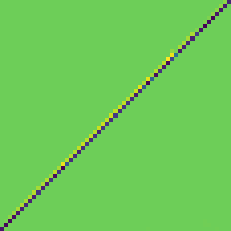

In [66]:
# Laplacian of network
A = binned_x_transition_matrix_higher_order_list_dict['long_LR'][0]
J = np.copy(A)      # This already sets the non-diagonal elements
for i in range(np.shape(A)[0]):
    J[i,i] = - np.sum(A[:,i]) - A[i,i]
    
J

In [86]:
from pyphoplacecellanalysis.Analysis.Decoder.transition_matrix import ExpectedVelocityTuple

expected_velocity_list_dict: Dict[types.DecoderName, List[ExpectedVelocityTuple]] = {}

for a_decoder_name, a_transition_mat_list in binned_x_transition_matrix_higher_order_list_dict.items():
    expected_velocity_list_dict[a_decoder_name] = []
    for A in a_transition_mat_list:
        combined_expected_incoming_velocity, (fwd_expected_incoming_velocity, bkwd_expected_incoming_velocity) = TransitionMatrixComputations._compute_expected_velocity_out_per_node(A, should_split_fwd_and_bkwd_velocities=True, velocity_type='in')
        # expected_velocity_list_dict[a_decoder_name].append(fwd_expected_incoming_velocity,
        combined_expected_out_velocity, (fwd_expected_out_velocity, bkwd_expected_out_velocity) = TransitionMatrixComputations._compute_expected_velocity_out_per_node(A, should_split_fwd_and_bkwd_velocities=True, velocity_type='out')

        expected_velocity_list_dict[a_decoder_name].append(
            ExpectedVelocityTuple(in_fwd=fwd_expected_incoming_velocity, in_bkwd=bkwd_expected_incoming_velocity, in_combined=combined_expected_incoming_velocity,
                              out_fwd=fwd_expected_out_velocity, out_bkwd=bkwd_expected_out_velocity, out_combined=combined_expected_out_velocity)
        )
        


In [87]:
expected_velocity_list_dict

{'long_LR': [ExpectedVelocityTuple(in_combined=array([0.0118343, 0.0250608, 0.120616, 0.192308, 0.235294, 0.25974, 0.240964, 0.25641, 0.30303, 0.229885, 0.246914, 0.277778, 0.186916, 0.3125, 0.232558, 0.5, 0.298507, 0.289855, 0.277778, 0.333333, 0.357143, 0.307692, 0.327869, 0.30303, 0.37037, 0.37037, 0.344828, 0.37037, 0.333333, 0.357143, 0.338983, 0.294118, 0.277778, 0.377358, 0.465116, 0.243902, -0.125, 0.194175, 0.267308, 0.240506, 0.19496, 0.580645, 0.78866, 0.0412371, 0.236842, 0.25, 0.225, 0.253521, 0.0810811, -0.274804, -0.886385, -0.730023, -0.190512, -0.75, 0.142857, 0.125, -0.162722]), in_fwd=array([0, 0.0333333, 0.0118343, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.6, 0, 0.025, 0, 0.115385, 0, 0, 0, 0, 0, 0, 0, 0, 0.313545, 0.960459, 0.801451, 0.333369, 0.883333, 0, 0, 0.162722]), in_bkwd=array([0.0118343, 0.0583942, 0.13245, 0.192308, 0.235294, 0.25974, 0.240964, 0.25641, 0.30303, 0.229885, 0.246914, 0.277778, 0.186

In [95]:
%config_ndarray_preview height=200

# V = expected_velocity_list_dict['long_LR'][0].in_combined
# V = np.stack([v.in_combined for v in expected_velocity_list_dict['long_LR']])

for a_decoder_name, a_velocity_tuple_list in expected_velocity_list_dict.items():
	
    V = np.stack([v.in_combined for v in a_velocity_tuple_list]) # Stack over orders. This doesn't make much sense actually
    display(V[1])

Array 
 Chunk 
 
 
 
 
 
 Bytes 
 456 B 
 456 B 
 
 
 
 Shape 
 (57,) 
 (57,) 
 
 
 Dask graph 
 1 chunks in 1 graph layer 
 
 
 Data type 
 float64 numpy.ndarray 
 
 
 
 
 
 

 <!-- Horizontal lines -->
 
 

 <!-- Vertical lines -->
 
 

 <!-- Colored Rectangle -->
 

 <!-- Text -->
 57 
 1 
 
 
 
 
 
 
 
 
 [0.0236686 0.0601315 0.23461 0.384615 0.484798 0.517603 0.46988 0.512821 0.613898 0.448276 0.493827 0.555556 0.373832 0.640262 0.44186 1.02425 0.522388 0.57971 0.555556 0.685714 0.735165 0.569231 0.655738 0.606061 0.759259 0.738186 0.692209 0.722222 0.666667 0.714286 0.677966 0.588235 0.555556 0.810004 0.891662 -0.193089 0.32767 0.339806 0.559615 0.481013 0.437195 1.77295 0.849227 0.0618557 0.473684 0.5 0.45 0.507042 0.1625 -0.872301 -1.6082 -1.31474 -0.382361 -1.5 0.285714 0.25 -0.325444]

Array 
 Chunk 
 
 
 
 
 
 Bytes 
 456 B 
 456 B 
 
 
 
 Shape 
 (57,) 
 (57,) 
 
 
 Dask graph 
 1 chunks in 1 graph layer 
 
 
 Data type 
 float64 numpy.ndarray 
 
 
 
 
 
 

 <!-- Horizontal lines -->
 
 

 <!-- Vertical lines -->
 
 

 <!-- Colored Rectangle -->
 

 <!-- Text -->
 57 
 1 
 
 
 
 
 
 
 
 
 [0.236324 1.34029 2.1437 17.8908 -0.16614 0.721928 -0.170369 -0.455474 -0.604742 -0.679317 -1.00686 -0.472194 -0.771744 -1.36659 -0.727273 -1.18356 -0.58 -1.27871 -1.02282 -0.919069 -0.857294 -0.983615 -0.982517 -1.02564 -1.09987 -0.83697 -1.02661 -1.6 -0.839394 -0.817016 -1.33952 -0.925616 -0.717143 -0.836364 -0.969345 -0.946844 -1.05388 -0.947368 -0.907539 -1.64961 -0.866883 -0.91866 -0.821053 -0.753247 -3.03636 -1.25067 -0.519481 -0.533333 -0.533333 -0.519481 -0.353982 -0.180995 -0.35514 -0.248366 -0.133376 -0.0306346 -0.015625]

Array 
 Chunk 
 
 
 
 
 
 Bytes 
 456 B 
 456 B 
 
 
 
 Shape 
 (57,) 
 (57,) 
 
 
 Dask graph 
 1 chunks in 1 graph layer 
 
 
 Data type 
 float64 numpy.ndarray 
 
 
 
 
 
 

 <!-- Horizontal lines -->
 
 

 <!-- Vertical lines -->
 
 

 <!-- Colored Rectangle -->
 

 <!-- Text -->
 57 
 1 
 
 
 
 
 
 
 
 
 [0 0 0 0 0 0 0 0 0 0 0.133739 0.530653 0.361905 0.40404 0.380952 0.703068 0.468354 0.506329 0.588235 0.748299 0.811617 0.730769 0.924444 0.76 0.994755 1.04274 0.833333 0.988889 0.852991 0.6 0.644498 0.745098 0.527778 0.977778 0.717615 0.490244 0.579135 0.219557 0.120479 0.120805 -0.321973 -0.0737534 0.104025 -0.0876467 0.203704 -0.0849357 -0.142857 0.142857 0.944444 0.931217 -0.0705467 0 0 0 0 0 0]

Array 
 Chunk 
 
 
 
 
 
 Bytes 
 456 B 
 456 B 
 
 
 
 Shape 
 (57,) 
 (57,) 
 
 
 Dask graph 
 1 chunks in 1 graph layer 
 
 
 Data type 
 float64 numpy.ndarray 
 
 
 
 
 
 

 <!-- Horizontal lines -->
 
 

 <!-- Vertical lines -->
 
 

 <!-- Colored Rectangle -->
 

 <!-- Text -->
 57 
 1 
 
 
 
 
 
 
 
 
 [0 0 0 0 0 0 0 0 0 0.119935 0.425176 1.47724 0.180429 -0.0527925 0.033075 -0.287879 -0.31405 -0.59375 -0.575758 -0.642857 -0.78882 -0.790435 -0.761818 -0.947727 -0.907895 -1.02105 -1.09493 -1.40968 -1.12222 -0.733333 -1.71039 -1.2113 -0.909159 -1.23297 -1.12808 -1.23529 -0.901961 -1.13999 -0.72738 -1.23979 -0.73927 -0.633333 -0.733333 -0.133191 -2.32479 -0.261804 -0.0595322 -0.00972447 0 0 0 0 0 0 0 0 0]

In [108]:
from pyphoplacecellanalysis.GUI.PyQtPlot.BinnedImageRenderingWindow import BasicBinnedImageRenderingWindow

window_title = 'TransitionMatrix: Expected Velocities from Transition Matrix'
a_spec = []

for a_decoder_name, a_velocity_tuple_list in expected_velocity_list_dict.items():
    V = np.stack([v.out_fwd for v in a_velocity_tuple_list]) # Stack over orders. This doesn't make much sense actually
    # a_spec.append(({'position':predicited_posteriors}, {f'velocities[{a_decoder_name}]':V})
    # display(a_velocity_tuple_list[0].out_fwd)
    # _disp_mat = np.atleast_2d(a_velocity_tuple_list[0].out_fwd)
    
    _disp_mat =np.stack([a_velocity_tuple_list[0].out_fwd, a_velocity_tuple_list[0].out_bkwd, a_velocity_tuple_list[0].out_combined])
    _disp_mat = np.atleast_2d(_disp_mat)
    display(_disp_mat)
    
    a_spec.append(
        # ({f'velocities[{a_decoder_name}]':V},) # Stack over orders. This doesn't make much sense actually
        ({f'velocities[{a_decoder_name}]':_disp_mat.T},) # Singe
        
        # ({f'velocities[{a_decoder_name}]':_disp_mat.T},)

    )
    
    
out_test_markov_test_compare = BasicBinnedImageRenderingWindow.init_from_data_spec(a_spec, window_title=window_title) # , xbins=test_pos_bins, ybins=test_pos_bins

Array 
 Chunk 
 
 
 
 
 
 Bytes 
 912 B 
 912 B 
 
 
 
 Shape 
 (2, 57) 
 (2, 57) 
 
 
 Dask graph 
 1 chunks in 1 graph layer 
 
 
 Data type 
 float64 numpy.ndarray 
 
 
 
 
 
 

 <!-- Horizontal lines -->
 
 

 <!-- Vertical lines -->
 
 

 <!-- Colored Rectangle -->
 

 <!-- Text -->
 57 
 2 
 
 
 
 
 
 
 
 
 [[1.51667 1.46154 1.23723 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.025 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0.0118343 0.0583942 0.13245 0.192308 0.235294 0.25974 0.240964 0.25641 0.30303 0.229885 0.246914 0.277778 0.186916 0.3125 0.232558 0.5 0.298507 0.289855 0.277778 0.333333 0.357143 0.307692 0.327869 0.30303 0.37037 0.37037 0.344828 0.37037 0.333333 0.357143 0.338983 0.294118 0.277778 0.377358 0.465116 0.243902 0.475 0.194175 0.292308 0.240506 0.310345 0.580645 0.5 0.329897 0.236842 0.25 0.225 0.253521 0.0810811 0.0387409 0.0740741 0.0714286 0.142857 0.133333 0.142857 0.125]]

Array 
 Chunk 
 
 
 
 
 
 Bytes 
 912 B 
 912 B 
 
 
 
 Shape 
 (2, 57) 
 (2, 57) 
 
 
 Dask graph 
 1 chunks in 1 graph layer 
 
 
 Data type 
 float64 numpy.ndarray 
 
 
 
 
 
 

 <!-- Horizontal lines -->
 
 

 <!-- Vertical lines -->
 
 

 <!-- Colored Rectangle -->
 

 <!-- Text -->
 57 
 2 
 
 
 
 
 
 
 
 
 [[0.0416667 0.0909091 0.111111 0.0969697 0.175258 0.195652 0.228916 0.306452 0.372549 0.475 0.358491 0.512195 0.575758 0.416667 0.540541 0.4 0.645161 0.487805 0.454545 0.465116 0.454545 0.512821 0.512821 0.526316 0.487805 0.606061 0.666667 0.454545 0.512821 0.689655 0.285714 0.4 0.454545 0.465116 0.47619 0.526316 0.526316 0.540541 0.714286 0.454545 0.526316 0.571429 1.36364 0.714286 0.377358 0.25974 0.266667 0.266667 0.25974 0.176991 0.0904977 0.17757 0.124183 0.0979381 0.0152838 0.0078125 0]
 [0 0 0 0 0 0.0108696 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.429907 0 0 1.67467 0.867188 8.83333]]

Array 
 Chunk 
 
 
 
 
 
 Bytes 
 912 B 
 912 B 
 
 
 
 Shape 
 (2, 57) 
 (2, 57) 
 
 
 Dask graph 
 1 chunks in 1 graph layer 
 
 
 Data type 
 float64 numpy.ndarray 
 
 
 
 
 
 

 <!-- Horizontal lines -->
 
 

 <!-- Vertical lines -->
 
 

 <!-- Colored Rectangle -->
 

 <!-- Text -->
 57 
 2 
 
 
 
 
 
 
 
 
 [[0 0 0 0 0 0 0 0 0 0 0.985915 0.145897 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.0166667 0 0 0 0 0 0 0.0144928 0 0 0.0555556 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0.0699088 0.266667 0.190476 0.20202 0.190476 0.338983 0.253165 0.253165 0.294118 0.350877 0.408163 0.384615 0.444444 0.4 0.454545 0.512821 0.444444 0.5 0.444444 0.307692 0.38 0.372549 0.263889 0.422222 0.422222 0.231707 0.316667 0.152672 0.0932642 0.0604027 0.0858896 0.181818 0.189189 0.101449 0.111111 0.0882353 0.0555556 0.0952381 0.5 1 0 0 0 0 0 0]]

Array 
 Chunk 
 
 
 
 
 
 Bytes 
 912 B 
 912 B 
 
 
 
 Shape 
 (2, 57) 
 (2, 57) 
 
 
 Dask graph 
 1 chunks in 1 graph layer 
 
 
 Data type 
 float64 numpy.ndarray 
 
 
 
 
 
 

 <!-- Horizontal lines -->
 
 

 <!-- Vertical lines -->
 
 

 <!-- Colored Rectangle -->
 

 <!-- Text -->
 57 
 2 
 
 
 
 
 
 
 
 
 [[0 0 0 0 0 0 0 0 0 0.166667 0.0647059 0.0416667 0.0607143 0.0629139 0.143939 0.157025 0.296875 0.287879 0.339286 0.413043 0.38 0.431818 0.475 0.5 0.542857 0.612903 0.633333 0.527778 0.542857 0.863636 0.513514 0.527778 0.612903 0.558824 0.558824 0.487179 0.513514 0.413043 0.575758 0.358491 0.333333 0.37037 0.692308 0.666667 0.133333 0.0977778 0.00485437 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0.00757576 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1.03722 0.0789474 0 0 0 0 0 0 0 0 0]]

self.params.plot_row_offset: 1


TypeError: update_columns() got an unexpected keyword argument 'num_new_columns'

Array 
 Chunk 
 
 
 
 
 
 Bytes 
 25.38 kiB 
 25.38 kiB 
 
 
 
 Shape 
 (57, 57) 
 (57, 57) 
 
 
 Dask graph 
 1 chunks in 1 graph layer 
 
 
 Data type 
 float64 numpy.ndarray 
 
 
 
 
 
 

 <!-- Horizontal lines -->
 
 

 <!-- Vertical lines -->
 
 

 <!-- Colored Rectangle -->
 

 <!-- Text -->
 57 
 57 
 
 
 
 
 
 
 
 
 [[0.933333 0.0333333 0 ... 0 0 0]
 [0.0118343 0.946746 0.0118343 ... 0 0 0.00295858]
 [0 0.0583942 0.916058 ... 0 0 0]
 ...
 [0 0 0 ... 0.866667 0 0]
 [0 0 0 ... 0.142857 0.857143 0]
 [0 0 0 ... 0 0.125 0.875]]
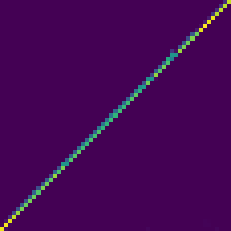

Array 
 Chunk 
 
 
 
 
 
 Bytes 
 25.38 kiB 
 25.38 kiB 
 
 
 
 Shape 
 (57, 57) 
 (57, 57) 
 
 
 Dask graph 
 1 chunks in 1 graph layer 
 
 
 Data type 
 float64 numpy.ndarray 
 
 
 
 
 
 

 <!-- Horizontal lines -->
 
 

 <!-- Vertical lines -->
 
 

 <!-- Colored Rectangle -->
 

 <!-- Text -->
 57 
 57 
 
 
 
 
 
 
 
 
 [[1 -1.01171 -0 ... -0 -0 -0]
 [-0.359188 1 -0.102869 ... -0 -0 -0.179594]
 [-0 -0.507586 1 ... -0 -0 -0]
 ...
 [-0 -0 -0 ... 1 -0 -0]
 [-0 -0 -0 ... -1.06904 1 -0]
 [-0 -0 -0 ... -0 -6.5 1]]
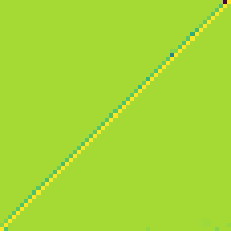

In [68]:
from scipy.sparse.csgraph import laplacian

# Example transition matrix
# T = np.array([
#     [0, 1, 1],
#     [1, 0, 1],
#     [1, 1, 0]
# ])



# Compute the Laplacian matrix
L = laplacian(A, normed=True)

A
L

In [ ]:
# _compute_expected_velocity_out_per_node(A)

In [ ]:
save_path = TransitionMatrixComputations.save_transition_matricies(binned_x_transition_matrix_higher_order_list_dict=binned_x_transition_matrix_higher_order_list_dict, save_path='output/transition_matrix_data.h5')
save_path



In [ ]:
# call the line magic
%config_ndarray_preview width=500 

## Test directly to one another:
# binned_x_transition_matrix_higher_order_list_dict
# makov_assumed_binned_x_transition_matrix_higher_order_list_dict

# single decoder for now
a_decoder_idx = 0
a_decoder_name = 'long_LR'
transition_matrix_order = 4
_measured = binned_x_transition_matrix_higher_order_list_dict[a_decoder_name][transition_matrix_order]
_markov_ideal = makov_assumed_binned_x_transition_matrix_higher_order_list_dict[a_decoder_name][transition_matrix_order]

# np.sum(_measured, axis=0) # test column normalization
# np.sum(_measured, axis=1) # test row normalization

# np.sum(_markov_ideal, axis=0)
# np.sum(_markov_ideal, axis=1)

## test row normalization:
assert np.allclose(np.sum(_measured, axis=1), 1), f"not row normalized!"
assert np.allclose(np.sum(_markov_ideal, axis=1), 1), f"not row normalized!"

_measured
_markov_ideal


# M = M / M.sum(axis=1)[:, np.newaxis] # row sum
# # M = M / M.sum(axis=0)[np.newaxis,:] # col sum
# # ((M.T / M.sum(axis=1, keepdims=True)).T - (M / M.sum(axis=1)[:, np.newaxis]))

# M = (M / M.sum(axis=1, keepdims=True)) # row sum

# np.sum(M, axis=0)
# np.sum(M, axis=1)

_diff = np.abs(_measured - _markov_ideal)
_diff


### Generate test position posteriors

In [ ]:
## Span mode:
start_idx: int = 9

span_size: int = 5 # span 5 bins sequentially, then step
step_size: int = 3
num_repeats: int = 4
step_arr = np.array(list(np.repeat(1.0, span_size)) + list(np.repeat(0.0, step_size)))
step_arr
test_posterior = np.tile(step_arr, num_repeats)
test_posterior
# [5, 3] # 5 ON, 3 OFF (8 total)




# stop_idx = (n_generated_t_bins * step_size)

In [ ]:
# call the line magic
%config_ndarray_preview width=50 

predicted_probabilities_dict = {}
# for a_decoder_idx, (a_decoder_name, a_binned_x_transition_matrix_higher_order_list) in enumerate(binned_x_transition_matrix_higher_order_list_dict.items()):
# single decoder for now
a_decoder_idx = 0
a_decoder_name = 'long_LR'
a_binned_x_transition_matrix_higher_order_list: List[NDArray] = deepcopy(binned_x_transition_matrix_higher_order_list_dict[a_decoder_name])
# single-decoder

# test_posterior, (test_tbins, test_pos_bins) = TransitionMatrixComputations._generate_testing_posteriors(decoders_dict, a_decoder_name, test_posterior_type='directly_adjacent_pos_bins')
test_posterior, (test_tbins, test_pos_bins) = TransitionMatrixComputations._generate_testing_posteriors(decoders_dict, a_decoder_name, test_posterior_type='step_adjacent_pos_bins', n_generated_t_bins=3, blur_vertical_std_dev=0.1, blur_horizontal_std_dev=0.1)
n_xbins = len(test_pos_bins)

np.shape(test_posterior)
test_posterior


In [ ]:
# a_tbin_idx = 0
# a_next_tbin_idx = a_tbin_idx + 1 # the predicted time-bin index

# an_observed_posterior = np.atleast_2d(test_posterior[:, a_tbin_idx]).T # (n_x, 1)
# an_actual_observed_next_step_posterior = np.atleast_2d(test_posterior[:, a_next_tbin_idx]).T # (n_x, 1)

# an_observed_posterior

# ## NOTE: transition_matrix_order does seem to do the identity transformation
# transition_matrix_order_idx: int = 4
# transition_matrix_order: int = transition_matrix_order_idx + 1 ## order is index + 1

# ## single time-bin
# a_trans_prob_mat = a_binned_x_transition_matrix_higher_order_list[transition_matrix_order_idx] # (n_x, n_x)
# a_next_t_predicted_pos_probs = a_trans_prob_mat @ an_observed_posterior # (n_x, 1)
# # a_next_t_predicted_pos_probs

# np.hstack([an_observed_posterior, a_next_t_predicted_pos_probs]) # (n_x, 1)

# # Compare real:
# np.hstack([an_observed_posterior, an_actual_observed_next_step_posterior])


predicited_posteriors = TransitionMatrixComputations._perform_forward_prediction(a_binned_x_transition_matrix_higher_order_list, test_posterior, transition_matrix_order_start_idx=1)
predicited_posteriors

# # Compare real:
## Observed posteriors:
observed_posteriors = deepcopy(test_posterior[:, 1:])
observed_posteriors

assert np.shape(observed_posteriors) == np.shape(predicited_posteriors)
_prediction_observation_diff = observed_posteriors - predicited_posteriors
_prediction_observation_diff
# np.hstack([an_observed_posterior, an_actual_observed_next_step_posterior])


In [ ]:
%config_ndarray_preview height=200

def _perform_future_sliding_predictions(a_binned_x_transition_matrix_higher_order_list, test_posterior, transition_matrix_order_start_idx:int=1, max_transition_matrix_order_idx=None):
    """ takes a a_binned_x_transition_matrix_higher_order_list and a position posterior
    
    Uses the first time bin to and the `a_binned_x_transition_matrix_higher_order_list` to predict the future bins:

    Usage:        
        predicited_posteriors = TransitionMatrixComputations._perform_forward_prediction(a_binned_x_transition_matrix_higher_order_list, test_posterior)
        predicited_posteriors

        # # Compare real:
        ## Observed posteriors:
        observed_posteriors = deepcopy(test_posterior[:, 1:])

        assert np.shape(observed_posteriors) == np.shape(predicited_posteriors)
        _prediction_observation_diff = observed_posteriors - predicited_posteriors
        _prediction_observation_diff

    """
    # n_time_bins: int = np.shape(test_posterior)[1]
    # n_predicted_time_bins = n_time_bins - 1
    if max_transition_matrix_order_idx is None:
        max_transition_matrix_order_idx = len(a_binned_x_transition_matrix_higher_order_list) - transition_matrix_order_start_idx
        
    # print(f'np.shape(test_posterior): {np.shape(test_posterior)}, n_time_bins: {n_time_bins}, n_predicted_time_bins: {n_predicted_time_bins}')
    # Only use the first posterior
    an_initial_observed_posterior = np.atleast_2d(test_posterior[:, 0]).T # (n_x, 1)
    a_following_observed_posterior = np.atleast_2d(test_posterior[:, 1]).T

    predicited_posteriors = []
    # for a_tbin_idx in np.arange(start=1, stop=n_time_bins):
    for i in np.arange(transition_matrix_order_start_idx, max_transition_matrix_order_idx):
        ## NOTE: transition_matrix_order does seem to do the identity transformation
        transition_matrix_order_idx: int = transition_matrix_order_start_idx + i
        # transition_matrix_order: int = transition_matrix_order_idx + 1 ## order is index + 1

        ## single time-bin
        a_trans_prob_mat = a_binned_x_transition_matrix_higher_order_list[transition_matrix_order_idx] # (n_x, n_x)
        # a_next_t_predicted_pos_probs = a_trans_prob_mat @ an_observed_posterior # (n_x, 1)
        a_next_t_predicted_pos_probs = a_trans_prob_mat @ an_initial_observed_posterior # (n_x, 1)

        # a_next_t_predicted_pos_probs
        predicited_posteriors.append(a_next_t_predicted_pos_probs)

    predicited_posteriors = np.hstack(predicited_posteriors) # (n_x, n_predicted_time_bins)
    return predicited_posteriors, a_following_observed_posterior


predicited_posteriors, a_following_observed_posterior = _perform_future_sliding_predictions(a_binned_x_transition_matrix_higher_order_list, test_posterior, transition_matrix_order_start_idx=0, max_transition_matrix_order_idx=15)
predicited_posteriors
a_following_observed_posterior


np.array([np.dot(v, a_following_observed_posterior) for v in predicited_posteriors.T])

# # # Compare real:
# ## Observed posteriors:
# observed_posteriors = deepcopy(test_posterior[:, 1:])
# observed_posteriors

# assert np.shape(observed_posteriors) == np.shape(predicited_posteriors)
# _prediction_observation_diff = observed_posteriors - predicited_posteriors
# _prediction_observation_diff


In [ ]:
test_generated_events = TransitionMatrixComputations._generate_expected_replay_sequences(a_binned_x_transition_matrix_higher_order_list=a_binned_x_transition_matrix_higher_order_list, n_generated_events=5, n_generated_t_bins=10)
test_generated_events

In [ ]:
np.stack(test_generated_events)

In [ ]:
test_generated_events[0]
test_generated_events[1]
test_generated_events[2]

In [ ]:
window_title = 'TransformMatrix: Fwd Predicted vs. Observed Position Posteriors'
a_spec = [ # two rows: (2 columns, 1 column)
    ({'predicted':predicited_posteriors}, {'observed':observed_posteriors},), # single row (2 columns)
    ({'diff':_prediction_observation_diff}, )
]
out_test_markov_test_compare = BasicBinnedImageRenderingWindow.init_from_data_spec(a_spec, window_title=window_title, xbins=test_pos_bins, ybins=test_pos_bins)

In [ ]:
window_title = 'Transform Matrix: Measured v. Markov Ideal'
a_spec = [ # two rows: (2 columns, 1 column)
    ({'measured':_measured}, {'markov_ideal':_markov_ideal},), # single row (2 columns)
    ({'diff':_diff}, )
]
out_test_markov_test_compare = BasicBinnedImageRenderingWindow.init_from_data_spec(a_spec, window_title=window_title, xbins=test_pos_bins, ybins=test_pos_bins)


In [ ]:
# 
# next_pos_likelihood = TransitionMatrixComputations._predicted_probabilities_likelihood(a_binned_x_transition_matrix_higher_order_list, test_posterior, transition_matrix_order=transition_matrix_order)
# predicted_probabilities_dict[a_decoder_name] = next_pos_likelihood
    
# # next_pos_likelihood
# next_pos_likelihood
# display(test_posterior)

_shared_kwargs = dict(xbins=test_pos_bins, ybins=test_pos_bins)

out_test_markov_test_compare = BasicBinnedImageRenderingWindow(_diff, xbins=test_pos_bins, ybins=test_pos_bins,
                                        name=f'_diff', title=f"_diff", variable_label='_diff Matrix', scrollability_mode=LayoutScrollability.NON_SCROLLABLE,
                                        grid_opacity=0.4, drop_below_threshold=1e-12)
out_test_markov_test_compare.add_data(row=0, col=1, matrix=_measured, title='measured', **_shared_kwargs)
out_test_markov_test_compare.add_data(row=0, col=2, matrix=_markov_ideal, title='markov_ideal', **_shared_kwargs)

np.sum(np.isnan(_measured))
np.sum(np.isnan(_markov_ideal))

# T[np.isnan(T)] = float(nan_entries_replace_value)

graphics_layout: pg.GraphicsLayout = out_test_markov_test_compare.graphics_layout
# vb = l.addViewBox(lockAspect=True)
# img = pg.ImageItem(np.random.normal(size=(100,100)))
# vb.addItem(img)
# vb.autoRange()
# graphics_layout.nextColumn()
# graphics_layout.setCo1


In [ ]:
from silx.gui.plot.CompareImages import CompareImages

window = CompareImages()

## Observed posteriors:
observed_posteriors = deepcopy(test_posterior[:, 1:])

window.setData(predicited_posteriors, observed_posteriors)

window.show()

In [ ]:

next_pos_likelihood = TransitionMatrixComputations._predicted_probabilities_likelihood(a_binned_x_transition_matrix_higher_order_list, test_posterior, transition_matrix_order=transition_matrix_order)
# predicted_probabilities_dict[a_decoder_name] = next_pos_likelihood
  
# next_pos_likelihood
next_pos_likelihood
display(test_posterior)

Attempt at proper reverse likelihoods

In [ ]:
a_tbin_idx = 2
start_transition_matrix_order: int = 0
# start_transition_matrix_order: int = 10 # start at index 10

an_observed_posterior = np.atleast_2d(test_posterior[:, a_tbin_idx]).T # (n_x, 1)
an_observed_posterior

preceeding_tbin_idxs = np.arange(a_tbin_idx)

num_timesteps_back: int = 0
t_step_pos_likelihoods = []
for a_preceding_tbin_idx in reversed(preceeding_tbin_idxs):
    # num_timesteps_back: num timesteps into the past
    num_timesteps_back = num_timesteps_back + 1
    transition_order: int = start_transition_matrix_order + num_timesteps_back
    
    print(f'{num_timesteps_back = }, {a_preceding_tbin_idx = }, {transition_order = }')
    a_trans_prob_mat = a_binned_x_transition_matrix_higher_order_list[transition_order] # (n_x, n_x)
    a_t_step_pos_likelihood = TransitionMatrixComputations._likelihood_of_observation(an_observed_posterior, (a_trans_prob_mat @ np.atleast_2d(test_posterior[:, a_preceding_tbin_idx]).T)) # past posterior
    t_step_pos_likelihoods.append(a_t_step_pos_likelihood)
    
t_step_pos_likelihoods

In [ ]:
next_tbin_idx = a_tbin_idx+1
a_next_t_step_obs_posterior = np.atleast_2d(test_posterior[:, next_tbin_idx]).T # (n_x, 1)
next_pos_likelihood = TransitionMatrixComputations._likelihood_of_observation(a_next_t_step_obs_posterior, next_pos_likelihood)



# predicted_probabilities_dict['long_LR']
# predicted_probabilities_dict['long_LR'][0]
# predicted_probabilities_dict['long_LR'][0].shape # (58, 58)
# np.atleast_2d(test_posterior[:, a_tbin_idx]).T

In [ ]:
test_posterior

In [ ]:
out_test_posterior = BasicBinnedImageRenderingWindow(test_posterior, test_tbins, test_pos_bins,
                                        name=f'test_posterior', title=f"test_posterior", variable_label='test_posterior Matrix', scrollability_mode=LayoutScrollability.NON_SCROLLABLE,
                                        grid_opacity=0.4)


In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError import plot_1D_most_likely_position_comparsions

curr_time_bins = test_tbins
_temp_fig, curr_ax = plot_1D_most_likely_position_comparsions(measured_position_df=None, ax=None, time_window_centers=curr_time_bins, variable_name='test_posterior', xbin=test_pos_bins,
    posterior=test_posterior,
    active_most_likely_positions_1D=None,
    )

In [ ]:
_temp_fig, curr_ax = plot_1D_most_likely_position_comparsions(measured_position_df=None, ax=None, time_window_centers=curr_time_bins, variable_name='predicted_probabilities_dict', xbin=test_pos_bins,
    posterior=predicted_probabilities_dict['long_LR'],
    active_most_likely_positions_1D=None,
    )

In [ ]:
# Visualization ______________________________________________________________________________________________________ #
from pyphoplacecellanalysis.GUI.PyQtPlot.BinnedImageRenderingWindow import BasicBinnedImageRenderingWindow, LayoutScrollability

out = BasicBinnedImageRenderingWindow(binned_x_transition_matrix_higher_order_list_dict[a_decoder_name][2], a_pf1D.xbin_labels, a_pf1D.xbin_labels, name='binned_x_transition_matrix', title="Transition Matrix for binned x (from, to)", variable_label='Transition Matrix', scrollability_mode=LayoutScrollability.NON_SCROLLABLE)




In [ ]:
out_decoded = BasicBinnedImageRenderingWindow(decoded_binned_x_transition_matrix_higher_order_list[0], active_one_step_decoder.xbin_centers, active_one_step_decoder.xbin_centers, name='decoded_binned_x_transition_matrix', title="DECODED Transition Matrix for binned x (from, to)", variable_label='Transition Matrix', scrollability_mode=LayoutScrollability.NON_SCROLLABLE)


In [ ]:
binned_x_transition_matrix_higher_order_list = binned_x_transition_matrix_higher_order_list_dict[a_decoder_name]

i = 0
out = BasicBinnedImageRenderingWindow(binned_x_transition_matrix_higher_order_list[i], decoders_dict[a_decoder_name].xbin_centers, decoders_dict[a_decoder_name].xbin_centers, name=f'binned_x_transition_matrix["{a_decoder_name}"]', title=f"Transition Matrix for binned x (from, to) for '{a_decoder_name}'", variable_label='Transition Matrix', scrollability_mode=LayoutScrollability.NON_SCROLLABLE)

# i = np.arange(len(binned_x_transition_matrix_higher_order_list), step=2)
for i in np.arange(len(binned_x_transition_matrix_higher_order_list), step=7):
    out.add_data(row=i, col=0, matrix=binned_x_transition_matrix_higher_order_list[i], xbins=decoders_dict[a_decoder_name].xbin_centers, ybins= decoders_dict[a_decoder_name].xbin_centers, name=f'binned_x_transition_matrix[{i}]', title='', variable_label=f'Transition Matrix[{i}]')



# out.add_data(row=2, col=0, matrix=short_decoded_binned_x_transition_matrix_higher_order_list[i], xbins=decoders_dict[a_decoder_name].xbin_labels, ybins= decoders_dict[a_decoder_name].xbin_labels, name='short_decoded_binned_x_transition_matrix', title='Short DECODED Transition Matrix', variable_label='short decoded')
# out.add_data(row=1, col=0, matrix=binned_x_transition_matrix_higher_order_list[1], xbins=pf1D.xbin_labels, ybins=pf1D.ybin_labels, name='binned_x_transition_matrix^2', title='2nd Order Transition Matrix for binned x (from, to)', variable_label='2nd Order Transition Matrix') # , scrollability_mode=LayoutScrollability.NON_SCROLLABLE
# out.add_data(row=2, col=0, matrix=binned_x_transition_matrix_higher_order_list[2], xbins=pf1D.xbin_labels, ybins=pf1D.ybin_labels, name='binned_x_transition_matrix^3', title='3rd Order Transition Matrix for binned x (from, to)', variable_label='3rd Order Transition Matrix') # , scrollability_mode=LayoutScrollability.NON_SCROLLABLE


# 🛑 Time-based Transition Matrix

In [ ]:
from scipy.sparse import csr_matrix

def _time_transition_matrix(df: pd.DataFrame, bin_size=0.25): # "0.25S"
    """ attempts to determine a spike transition matrix from continuously sampled events (like spike times) given a specified bin_size 
    
    """
    # df["bin"] = pd.cut(df["t_rel_seconds"], bins=pd.timedelta_range(df["t_rel_seconds"].min(), df["t_rel_seconds"].max(), freq=bin_size))
    # df["bin"] = pd.cut(
    # 	pd.to_timedelta(df["t_rel_seconds"], unit="s"),
    # 	bins=pd.timedelta_range(df["t_rel_seconds"].min(), df["t_rel_seconds"].max(), freq=bin_size),
    # )
    def get_bin(seconds):
        bin_number = int(seconds // bin_size)
        return bin_number

    df["bin"] = df["t_rel_seconds"].apply(get_bin)

    transition_matrix = csr_matrix((
        counts, (i, j)
    ) for i, (bin, group) in df.groupby(["bin", "aclu"]).agg(counts=("aclu", "count")).iterrows()
        for j, counts in group.iteritems()
    )
    transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)

    return transition_matrix


test_spikes_df = deepcopy(rank_order_results.LR_laps.spikes_df)

rank_order_results.LR_laps


In [ ]:
a_decoder = deepcopy(track_templates.get_decoders_dict()['long_LR'])
filtered_pos_df: pd.DataFrame = deepcopy(a_decoder.pf.filtered_pos_df)
filtered_pos_df = filtered_pos_df.dropna(axis='index', how='any', subset=['binned_x']).reset_index(drop=True)
filtered_pos_df


In [ ]:
from scipy.sparse import csr_matrix

t_bin_size = 0.25
# time_variable_name: str = 't_rel_seconds'
time_variable_name: str = 't'

df: pd.DataFrame = deepcopy(filtered_pos_df)

# df["bin"] = pd.cut(df["t_rel_seconds"], bins=pd.timedelta_range(df["t_rel_seconds"].min(), df["t_rel_seconds"].max(), freq=bin_size))
# df["bin"] = pd.cut(
# 	pd.to_timedelta(df["t_rel_seconds"], unit="s"),
# 	bins=pd.timedelta_range(df["t_rel_seconds"].min(), df["t_rel_seconds"].max(), freq=bin_size),
# )
def get_bin(seconds):
    bin_number = int(seconds // t_bin_size)
    return bin_number

df["bin"] = df[time_variable_name].apply(get_bin) # .astype(np.int64)
transition_matrix = csr_matrix((
    counts, (i, j)
) for i, (bin, group) in df.groupby(["bin", "binned_x"]).agg(counts=("binned_x", "count")).iterrows()
    for j, counts in group.iteritems()
)
transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)
transition_matrix

In [ ]:
# test_spikes_df = test_spikes_df.spikes.add_binned_time_column()

# [['t_rel_seconds', 'aclu', 'flat_spike_idx', 'Probe_Epoch_id']]]


# test_spikes_df
print(f'list(test_spikes_df.columns): {list(test_spikes_df.columns)}')

# spikes_columns_list = ["t_rel_seconds", "aclu", 'shank', 'cluster', 'aclu', 'qclu', 'x', 'y', 'speed', 'traj', 'lap', 'maze_relative_lap', 'maze_id', 'flat_spike_idx', 'x_loaded', 'y_loaded', 'lin_pos', 'fragile_linear_neuron_IDX', 'PBE_id', 'neuron_IDX', 'Probe_Epoch_id']
spikes_columns_list = ["t_rel_seconds", "aclu"]
test_spikes_df = test_spikes_df[spikes_columns_list]
# Change column type to object for column: 'aclu'
test_spikes_df = test_spikes_df.astype({'aclu': 'int'}).reset_index(drop=True)
test_spikes_df

In [ ]:
from pyphoplacecellanalysis.Analysis.Decoder.transition_matrix import TransitionMatrixComputations

transition_matrix = TransitionMatrixComputations._compute_time_transition_matrix(df=test_spikes_df, bin_size=0.5) #  bin_size="0.25S"
transition_matrix

In [ ]:
# from numpy.core.arrayprint import _leading_trailing
from pyphocorehelpers.print_helpers import _subfn_display_heatmap, _subfn_create_heatmap

# omitted_indicies_list = []
# def _leading_trailing(a: NDArray, edgeitems: int, index=()): # , omitted_indicies_list=[]
#     """
#     Keep only the N-D corners (leading and trailing edges) of an array.

#     Should be passed a base-class ndarray, since it makes no guarantees about
#     preserving subclasses.
#     """
#     global omitted_indicies_list
#     axis = len(index)
#     if axis == a.ndim:
#         return a[index]

#     if a.shape[axis] > 2*edgeitems:
#         left_edge_idxs = (index + np.index_exp[:edgeitems])
#         right_edge_idxs = (index + np.index_exp[-edgeitems:])
#         print(f'index: {index}, axis: {axis}, a.shape[axis]: {a.shape[axis]}')
#         # omitted_idxs = (left_edge_idxs[-1], right_edge_idxs[0])
#         omitted_idxs = (int(edgeitems), int((a.shape[axis]-edgeitems)))
#         # omitted_idxs = (index + np.index_exp[edgeitems:-edgeitems])
#         omitted_indicies_list.append(omitted_idxs)
        
#         return np.concatenate((
#             _leading_trailing(a, edgeitems, left_edge_idxs),
#             _leading_trailing(a, edgeitems, right_edge_idxs)
#         ), axis=axis)#, omitted_idxs)
#     else:
#         # can include all items
#         # return (_leading_trailing(a, edgeitems, index + np.index_exp[:]), None)
#         return _leading_trailing(a, edgeitems, (index + np.index_exp[:]))


omitted_indicies_list = []
def _dropping_middle_leading_trailing(a: NDArray, edgeitems: int, index=(), n_fill_middle_items: int = 4): # , omitted_indicies_list=[]
    """
    Keep only the N-D corners (leading and trailing edges) of an array.

    Should be passed a base-class ndarray, since it makes no guarantees about
    preserving subclasses.
    """
    global omitted_indicies_list
    axis = len(index)
    if axis == a.ndim:
        return a[index]
    
    n_left_fill_middle_items = int(n_fill_middle_items / 2)
    n_right_fill_middle_items = int(n_fill_middle_items / 2)
    n_total_edgeitems: int = (2*edgeitems)
    curr_axis_size: int = a.shape[axis]
    
    if (curr_axis_size > n_total_edgeitems):
        left_range = (0, (edgeitems-n_left_fill_middle_items))
        right_range = ((-edgeitems + n_right_fill_middle_items), n_total_edgeitems)
        middle_fill_range = ((left_range[-1]+1), (right_range[0]-1))
        middle_fill_n_xbins = middle_fill_range[-1] - middle_fill_range[0]
        print(f'left_range: {left_range}, right_range: {right_range}, middle_fill_range: {middle_fill_range}, middle_fill_n_xbins: {middle_fill_n_xbins}')
        
        left_edge_idxs = (index + np.index_exp[:(edgeitems-n_left_fill_middle_items)])
        right_edge_idxs = (index + np.index_exp[(-edgeitems + n_right_fill_middle_items):])
        print(f'axis: {axis}, a.shape[axis]: {a.shape[axis]}') # index: {index}, 
        # omitted_idxs = (left_edge_idxs[-1], right_edge_idxs[0])
        omitted_idxs = (int(edgeitems), int((a.shape[axis]-edgeitems)))
        # omitted_idxs = (index + np.index_exp[edgeitems:-edgeitems])
        omitted_indicies_list.append(omitted_idxs)
        
        middle_fill_array = np.full((middle_fill_n_xbins, *np.shape(a)[1:]), fill_value=np.nan)
        
        
        return np.concatenate((
            _leading_trailing(a, edgeitems, left_edge_idxs),
            middle_fill_array,
            _leading_trailing(a, edgeitems, right_edge_idxs)
        ), axis=axis)#, omitted_idxs)
    else:
        # can include all items
        # return (_leading_trailing(a, edgeitems, index + np.index_exp[:]), None)
        return _leading_trailing(a, edgeitems, (index + np.index_exp[:]))
    

    

max_allowed_arr_elements: int = 200

arr = deepcopy(long_LR_pf1D_Decoder.p_x_given_n)
arr_shape = np.array(np.shape(arr))
arr_shape
arr_too_large_dim = (arr_shape > max_allowed_arr_elements)
arr_too_large_dim

any_dim_arr_has_too_large_dimension: bool = np.any(arr_too_large_dim)

edgeitems: int = int(max_allowed_arr_elements / 2)
print(f'edgeitems: {edgeitems}')

removed_items = [(a_len - (edgeitems * 2)) if is_too_large else 0 for a_len, is_too_large in zip(arr_shape, arr_too_large_dim)]
# removed_items = arr_shape[arr_too_large_dim] - (edgeitems * 2)
removed_items

omitted_indicies_list = []
# _corners = _leading_trailing(arr, edgeitems=edgeitems)
_corners = _dropping_middle_leading_trailing(arr, edgeitems=edgeitems)

_left_edge = _corners[:, :edgeitems]
_right_edge = _corners[:, edgeitems:]
# [_corners[:, :edgeitems], _corners[:, edgeitems:]]
_corners

omitted_indicies_list = np.array(omitted_indicies_list)
omitted_indicies_list = np.squeeze(omitted_indicies_list.flatten()).tolist()
omitted_indicies_list

omission_indices = deepcopy(omitted_indicies_list)
omission_indices = sorted(set(omission_indices))
omission_indices

ylims = [(0, arr_shape[0],)]
ylims

xlims = [(0, omission_indices[0],), (omission_indices[-1], arr_shape[1],)]
xlims


# start_idx = 0
# xlims = []
# for split_idx in omission_indices:
# 	xlims.append((start_idx, split_idx,))
# 	start_idx = 

brokenaxes_kwargs = dict(xlims=xlims) # , ylims=ylims

	
_corners

# breaks = [(omission_indices[i], omission_indices[i+1]-1) for i in range(len(omission_indices)-1)]

# breaks

In [ ]:

# _left_edge
# _right_edge

# display(_subfn_display_heatmap(_corners, omission_indices=omitted_indicies_list))
display(_subfn_display_heatmap(_corners, brokenaxes_kwargs=brokenaxes_kwargs))

# omission_indices: [100, 35704], breaks: [(100, 35703)]


In [ ]:
from neuropy.utils.mixins.binning_helpers import compute_spanning_bins

long_LR_pf1D_Decoder.time_window_centers
# long_LR_pf1D_Decoder.decode_specific_epochs
long_LR_pf1D_Decoder.p_x_given_n

# time_bin_size = 0.25
time_bin_size = 0.1
manual_time_bin_start_t = curr_active_pipeline.sess.t_start
manual_time_bin_end_t = curr_active_pipeline.sess.t_stop

print(f'time_bin_size: {time_bin_size}, manual_time_bins: (start_t: {manual_time_bin_start_t}, end_t: {manual_time_bin_end_t})')
manual_time_window_edges, manual_time_window_edges_binning_info = compute_spanning_bins(None, bin_size=time_bin_size, variable_start_value=manual_time_bin_start_t, variable_end_value=manual_time_bin_end_t) # np.shape(out_digitized_variable_bins)[0] == np.shape(spikes_df)[0]
# debug_print_1D_bin_infos(manual_time_window_edges, 'manual_time_window_edges')

## Build the new decoder with custom params:
new_decoder_pf_params = deepcopy(active_computation_config.pf_params) # should be a PlacefieldComputationParameters
# override some settings before computation:
new_decoder_pf_params.time_bin_size = time_bin_size

## 1D Decoder
new_decoder_pf1D = active_pf_1D
new_1D_decoder_spikes_df = new_decoder_pf1D.filtered_spikes_df.copy()
new_1D_decoder_spikes_df = new_1D_decoder_spikes_df.spikes.add_binned_time_column(manual_time_window_edges, manual_time_window_edges_binning_info, debug_print=False)
new_1D_decoder = BayesianPlacemapPositionDecoder(new_decoder_pf_params.time_bin_size, new_decoder_pf1D, new_1D_decoder_spikes_df, manual_time_window_edges=manual_time_window_edges, manual_time_window_edges_binning_info=manual_time_window_edges_binning_info, debug_print=False)
new_1D_decoder.compute_all() #  --> n = self.


In [ ]:
long_LR_pf1D_Decoder.unit_specific_time_binned_spike_counts.shape

# 2024-08-07 - :❌ Review Velocity/Density measures I developed for Eloy
Needs 'pf2D_TwoStepDecoder'


In [ ]:
# Needs 'pf2D_TwoStepDecoder'
curr_active_pipeline.perform_specific_computation(computation_functions_name_includelist=['pf2D_TwoStepDecoder', 'EloyAnalysis'], enabled_filter_names=None, fail_on_exception=True, debug_print=False)


In [37]:
## Works, displays my velocity/density result for both 2D and 1D:
# out_plot_1D, out_plot_2D = curr_active_pipeline.display('_display_speed_vs_PFoverlapDensity_plots', active_config_name)
curr_display_function_name = '_display_speed_vs_PFoverlapDensity_plots'
plots = curr_active_pipeline.display(curr_display_function_name, global_epoch_name)
plots

AttributeError: 'NoneType' object has no attribute 'sorted_1D_avg_speed_per_pos'

# ❌ 2024-08-07 networkx graph from transition matrix Testing

In [ ]:

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# # Example transition matrix A
A = np.array([[0, 1, 0, 0],
              [0, 0, 1, 0],
              [0, 0, 0, 1],
              [1, 0, 0, 0]])

plt.figure(num=3, figsize=(14,7), clear=True)

# Create a graph from the transition matrix
G = nx.from_numpy_array(A, create_using=nx.DiGraph)

# Define positions for nodes in a straight line
pos = {i: (i, 0) for i in range(len(A))}

# Draw the nodes
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='skyblue')
nx.draw_networkx_labels(G, pos)

# Draw the edges
for (i, j) in G.edges():
    if i < j:
        rad = 0.3  # Radius for upper loop
    else:
        rad = -0.3  # Radius for lower loop
    nx.draw_networkx_edges(G, pos, edgelist=[(i, j)], connectionstyle=f"arc3,rad={rad}", arrows=True)

plt.show()



In [ ]:
import networkx as nx  # For the magic
import matplotlib.pyplot as plt  # For plotting

G = nx.from_numpy_array(A)
G


plt.figure(num=2, figsize=(14,7), clear=True)
nx.draw(G)

# 

# plt.figure(num=2, figsize=(14,7))
# node_size = 200
# # pos = {state:list(state) for state in states}

# nx.draw_networkx_edges(G, pos, width=1.0,alpha=0.5)
# nx.draw_networkx_labels(G, pos, font_weight=2)
# # nx.draw_networkx_edge_labels(G, pos, edge_labels)
# plt.axis('off');


<Figure size 1400x700 with 0 Axes>

In [ ]:
G = nx.MultiDiGraph()
labels={}
edge_labels={}
num_states = np.shape(A)[0]
states = deepcopy(A)
state_identifiers = [f"{s}" for s in np.arange(num_states)]

pos = {}
# for i, origin_state in enumerate(states):
#     for j, destination_state in enumerate(states):
for i in np.arange(num_states):
    for j in np.arange(num_states):
        rate = A[i][j]
        if rate > 0:
            origin_state = state_identifiers[i]
            destination_state = state_identifiers[j]
            G.add_edge(origin_state,
                       destination_state,
                       weight=rate,
                       label="{:.02f}".format(rate))
            edge_labels[(origin_state, destination_state)] = label="{:.02f}".format(rate)
            pos[(origin_state, destination_state)] = float(j)

plt.figure(num=1, figsize=(14,7))
node_size = 200
# pos = {state:list(state) for state in states}

nx.draw_networkx_edges(G, pos, width=1.0,alpha=0.5)
nx.draw_networkx_labels(G, pos, font_weight=2)
nx.draw_networkx_edge_labels(G, pos, edge_labels)
plt.axis('off');

KeyError: '0'